In [69]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

from sklearn.preprocessing import normalize
np.random.seed(42)

In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


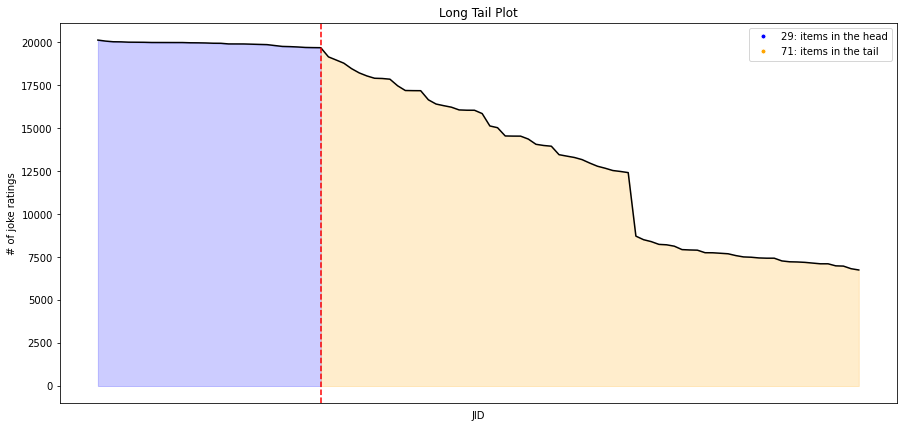

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [7]:

actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [8]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [9]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [10]:
pop = dict(df.JID.value_counts())

In [11]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [34]:
xx = {k:(v, joke_volume[k]) for k, v in joke_quality.items() if v > 0.1 and joke_volume[k] > 0.1}
len(xx), xx

(37,
 {49: (0.7776, 0.3),
  35: (0.6984, 0.4),
  26: (0.6943, 0.3),
  61: (0.635, 0.2),
  34: (0.6339, 0.2),
  28: (0.6309, 0.4),
  53: (0.5896, 0.5),
  67: (0.544, 0.3),
  68: (0.5351, 0.2),
  65: (0.5227, 0.2),
  60: (0.5155, 0.3),
  64: (0.4917, 0.4),
  30: (0.4617, 0.4),
  41: (0.4023, 0.4),
  47: (0.3671, 0.4),
  55: (0.3436, 0.4),
  10: (0.3328, 0.5),
  27: (0.3065, 0.5),
  45: (0.2814, 0.5),
  46: (0.2788, 0.5),
  13: (0.2594, 0.5),
  5: (0.2585, 0.5),
  11: (0.2572, 0.5),
  25: (0.2338, 0.5),
  37: (0.2322, 0.5),
  9: (0.2105, 0.4),
  92: (0.1965, 0.2),
  38: (0.1899, 0.5),
  39: (0.1873, 0.5),
  44: (0.1776, 0.5),
  90: (0.1622, 0.2),
  33: (0.1564, 0.5),
  21: (0.1552, 0.5),
  96: (0.1372, 0.2),
  95: (0.1155, 0.2),
  99: (0.1084, 0.2),
  0: (0.1044, 0.3)})

In [50]:
random.choices(list(xx.keys()), k=10)

[61, 30, 67, 9, 60, 33, 92, 44, 60, 35]

In [45]:
def union_predicts2(params):
    result = []

    for u in range(24983):
        result.append(random.choices(list(xx.keys()), k=10))
        
    return result

In [145]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
                    
        for k in range(100):
            if joke_quality[k] < 0.00:# or joke_volume[k] < 0.1:
                continue
            res[k] = joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        xx = np.array(
            [[x[0], x[1]] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)])
        
        #print(xx.shape)
        pp = xx[:, 1]
        pp += np.abs(np.min(pp))
        result.append(np.random.choice(xx[:, 0], size=10, replace=False, p=pp/np.sum(pp)))
        
    return result#, xx, pp/np.sum(pp)

In [91]:
sum(normalize([xx[:, 1]])[0])

3.14253760456759

In [124]:
r, xx, pp = union_predicts({
              'quality': 1,
              'volume': 1
             })

In [99]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    price = np.mean([sum([joke_volume[x] for x in xx]) for xx in result])
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip, map1, map10, price / 3])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'price', round(price, 3),
         'sum', round(sm, 3))
    return sm

In [144]:
main_metric({
              'quality': 1,
              'volume': 1
             })

time 5.557 cat_cov 70.0 cov 70.0 nov 0.698 ser 0.086 m1 0.145 m10 0.285 price 3.285 sum 3.709


3.7091334343556284

In [146]:
def objective(trial):    
    
    params = {
              'quality': trial.suggest_float(name='quality', low=-5, high=5, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-5, high=5, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4000)


[I 2023-05-08 22:53:02,126] A new study created in memory with name: no-name-363fb5dd-6d3f-4e1c-8d16-85b5ecd10a25
[I 2023-05-08 22:53:07,634] Trial 0 finished with value: 3.728294418778546 and parameters: {'quality': 0.6000000000000005, 'volume': 0.8000000000000007}. Best is trial 0 with value: 3.728294418778546.


time 5.503 cat_cov 70.0 cov 70.0 nov 0.708 ser 0.087 m1 0.145 m10 0.284 price 3.312 sum 3.728


[I 2023-05-08 22:53:12,985] Trial 1 finished with value: 3.7819301148217868 and parameters: {'quality': -2.0999999999999996, 'volume': -1.0}. Best is trial 1 with value: 3.7819301148217868.


time 5.344 cat_cov 69.0 cov 69.0 nov 1.135 ser 0.108 m1 0.089 m10 0.201 price 2.607 sum 3.782


[I 2023-05-08 22:53:18,579] Trial 2 finished with value: 3.5598288262178457 and parameters: {'quality': 4.1, 'volume': 0.0}. Best is trial 1 with value: 3.7819301148217868.


time 5.59 cat_cov 69.0 cov 70.0 nov 0.618 ser 0.069 m1 0.169 m10 0.314 price 3.001 sum 3.56


[I 2023-05-08 22:53:24,084] Trial 3 finished with value: 3.6876853808788983 and parameters: {'quality': 2.7, 'volume': 1.9000000000000004}. Best is trial 1 with value: 3.7819301148217868.


time 5.501 cat_cov 70.0 cov 70.0 nov 0.686 ser 0.082 m1 0.147 m10 0.291 price 3.244 sum 3.688


[I 2023-05-08 22:53:29,557] Trial 4 finished with value: 3.839385437392999 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 4 with value: 3.839385437392999.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.123 m10 0.253 price 3.634 sum 3.839


[I 2023-05-08 22:53:34,901] Trial 5 finished with value: 3.823435759686145 and parameters: {'quality': -0.8999999999999995, 'volume': 0.3000000000000007}. Best is trial 4 with value: 3.839385437392999.


time 5.339 cat_cov 69.0 cov 69.0 nov 1.041 ser 0.109 m1 0.093 m10 0.211 price 2.968 sum 3.823


[I 2023-05-08 22:53:40,257] Trial 6 finished with value: 3.788966057777939 and parameters: {'quality': -4.5, 'volume': 0.10000000000000053}. Best is trial 4 with value: 3.839385437392999.


time 5.35 cat_cov 67.0 cov 69.0 nov 1.077 ser 0.108 m1 0.094 m10 0.207 price 2.829 sum 3.789


[I 2023-05-08 22:53:45,715] Trial 7 finished with value: 3.5744560742651457 and parameters: {'quality': 1.9000000000000004, 'volume': -2.6999999999999997}. Best is trial 4 with value: 3.839385437392999.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.955 ser 0.08 m1 0.132 m10 0.271 price 2.267 sum 3.574


[I 2023-05-08 22:53:51,091] Trial 8 finished with value: 3.8382679135026154 and parameters: {'quality': -4.5, 'volume': 5.0}. Best is trial 4 with value: 3.839385437392999.


time 5.37 cat_cov 69.0 cov 69.0 nov 0.942 ser 0.107 m1 0.104 m10 0.228 price 3.233 sum 3.838


[I 2023-05-08 22:53:56,575] Trial 9 finished with value: 3.7000614001339636 and parameters: {'quality': 4.0, 'volume': 3.3000000000000007}. Best is trial 4 with value: 3.839385437392999.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.691 ser 0.084 m1 0.148 m10 0.289 price 3.267 sum 3.7


[I 2023-05-08 22:54:01,975] Trial 10 finished with value: 3.7026682849995773 and parameters: {'quality': -2.5, 'volume': -4.4}. Best is trial 4 with value: 3.839385437392999.


time 5.388 cat_cov 68.0 cov 69.0 nov 1.198 ser 0.104 m1 0.084 m10 0.198 price 2.243 sum 3.703


[I 2023-05-08 22:54:07,424] Trial 11 finished with value: 3.8270571217098452 and parameters: {'quality': -4.3, 'volume': 4.800000000000001}. Best is trial 4 with value: 3.839385437392999.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.94 ser 0.107 m1 0.104 m10 0.227 price 3.238 sum 3.827


[I 2023-05-08 22:54:12,856] Trial 12 finished with value: 3.8301350487777635 and parameters: {'quality': -2.8, 'volume': 5.0}. Best is trial 4 with value: 3.839385437392999.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.88 ser 0.106 m1 0.11 m10 0.236 price 3.386 sum 3.83


[I 2023-05-08 22:54:18,344] Trial 13 finished with value: 3.8341052370635706 and parameters: {'quality': -0.2999999999999998, 'volume': 3.3000000000000007}. Best is trial 4 with value: 3.839385437392999.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.128 m10 0.262 price 3.641 sum 3.834


[I 2023-05-08 22:54:23,766] Trial 14 finished with value: 3.8352107411469096 and parameters: {'quality': -3.2, 'volume': 3.200000000000001}. Best is trial 4 with value: 3.839385437392999.


time 5.41 cat_cov 69.0 cov 69.0 nov 0.956 ser 0.108 m1 0.101 m10 0.224 price 3.201 sum 3.835


[I 2023-05-08 22:54:29,236] Trial 15 finished with value: 3.841755568910325 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 15 with value: 3.841755568910325.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.802 ser 0.104 m1 0.116 m10 0.249 price 3.574 sum 3.842


[I 2023-05-08 22:54:34,676] Trial 16 finished with value: 3.827837884398572 and parameters: {'quality': -1.4, 'volume': 2.1000000000000005}. Best is trial 15 with value: 3.841755568910325.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.902 ser 0.106 m1 0.106 m10 0.234 price 3.331 sum 3.828


[I 2023-05-08 22:54:40,180] Trial 17 finished with value: 3.748448458383674 and parameters: {'quality': 0.9000000000000004, 'volume': 2.1000000000000005}. Best is trial 15 with value: 3.841755568910325.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.09 m1 0.138 m10 0.276 price 3.365 sum 3.748


[I 2023-05-08 22:54:45,589] Trial 18 finished with value: 3.7468430287012264 and parameters: {'quality': -1.1999999999999997, 'volume': -1.4}. Best is trial 15 with value: 3.841755568910325.


time 5.396 cat_cov 69.0 cov 69.0 nov 1.191 ser 0.106 m1 0.087 m10 0.199 price 2.352 sum 3.747


[I 2023-05-08 22:54:51,091] Trial 19 finished with value: 3.7455130513403607 and parameters: {'quality': 1.6000000000000005, 'volume': 3.8000000000000007}. Best is trial 15 with value: 3.841755568910325.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.09 m1 0.135 m10 0.276 price 3.37 sum 3.746


[I 2023-05-08 22:54:56,616] Trial 20 finished with value: 3.8224807713073865 and parameters: {'quality': -0.1999999999999993, 'volume': 1.2000000000000002}. Best is trial 15 with value: 3.841755568910325.


time 5.512 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.102 m1 0.123 m10 0.259 price 3.764 sum 3.822


[I 2023-05-08 22:55:02,056] Trial 21 finished with value: 3.8232043062563257 and parameters: {'quality': -3.7, 'volume': 4.0}. Best is trial 15 with value: 3.841755568910325.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.944 ser 0.107 m1 0.102 m10 0.224 price 3.229 sum 3.823


[I 2023-05-08 22:55:07,501] Trial 22 finished with value: 3.832738523129963 and parameters: {'quality': -4.9, 'volume': 4.4}. Best is trial 15 with value: 3.841755568910325.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.965 ser 0.108 m1 0.1 m10 0.221 price 3.177 sum 3.833


[I 2023-05-08 22:55:12,944] Trial 23 finished with value: 3.8271359207035607 and parameters: {'quality': -2.0, 'volume': 2.5}. Best is trial 15 with value: 3.841755568910325.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.926 ser 0.106 m1 0.106 m10 0.229 price 3.271 sum 3.827


[I 2023-05-08 22:55:18,423] Trial 24 finished with value: 3.8355640218070794 and parameters: {'quality': -3.4, 'volume': 4.200000000000001}. Best is trial 15 with value: 3.841755568910325.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.928 ser 0.107 m1 0.109 m10 0.233 price 3.268 sum 3.836


[I 2023-05-08 22:55:23,914] Trial 25 finished with value: 3.780544167628478 and parameters: {'quality': 0.5, 'volume': 2.9000000000000004}. Best is trial 15 with value: 3.841755568910325.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.093 m1 0.133 m10 0.272 price 3.426 sum 3.781


[I 2023-05-08 22:55:29,407] Trial 26 finished with value: 3.840964075811124 and parameters: {'quality': -1.7999999999999998, 'volume': 5.0}. Best is trial 15 with value: 3.841755568910325.


time 5.479 cat_cov 69.0 cov 69.0 nov 0.822 ser 0.105 m1 0.114 m10 0.244 price 3.53 sum 3.841


[I 2023-05-08 22:55:34,884] Trial 27 finished with value: 3.832158096831133 and parameters: {'quality': -0.5999999999999996, 'volume': 1.4000000000000004}. Best is trial 15 with value: 3.841755568910325.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.845 ser 0.105 m1 0.112 m10 0.242 price 3.473 sum 3.832


[I 2023-05-08 22:55:40,314] Trial 28 finished with value: 3.8243604153516957 and parameters: {'quality': -1.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 15 with value: 3.841755568910325.


time 5.416 cat_cov 68.0 cov 69.0 nov 0.841 ser 0.104 m1 0.11 m10 0.239 price 3.48 sum 3.824


[I 2023-05-08 22:55:45,796] Trial 29 finished with value: 3.567901534085069 and parameters: {'quality': 0.40000000000000036, 'volume': -5.0}. Best is trial 15 with value: 3.841755568910325.


time 5.469 cat_cov 66.0 cov 69.0 nov 1.185 ser 0.09 m1 0.105 m10 0.228 price 1.832 sum 3.568


[I 2023-05-08 22:55:51,180] Trial 30 finished with value: 3.7802012745022893 and parameters: {'quality': -2.3, 'volume': -1.0}. Best is trial 15 with value: 3.841755568910325.


time 5.371 cat_cov 69.0 cov 69.0 nov 1.131 ser 0.108 m1 0.087 m10 0.2 price 2.625 sum 3.78


[I 2023-05-08 22:55:56,650] Trial 31 finished with value: 3.8491403303459246 and parameters: {'quality': -1.5999999999999996, 'volume': 4.9}. Best is trial 31 with value: 3.8491403303459246.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.807 ser 0.104 m1 0.12 m10 0.25 price 3.563 sum 3.849


[I 2023-05-08 22:56:02,106] Trial 32 finished with value: 3.843492586348847 and parameters: {'quality': -1.6999999999999997, 'volume': 4.5}. Best is trial 31 with value: 3.8491403303459246.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.829 ser 0.104 m1 0.116 m10 0.244 price 3.511 sum 3.843


[I 2023-05-08 22:56:07,582] Trial 33 finished with value: 3.8419005210000403 and parameters: {'quality': -1.7999999999999998, 'volume': 4.600000000000001}. Best is trial 31 with value: 3.8491403303459246.


time 5.462 cat_cov 69.0 cov 69.0 nov 0.832 ser 0.103 m1 0.116 m10 0.243 price 3.502 sum 3.842


[I 2023-05-08 22:56:13,035] Trial 34 finished with value: 3.8306424597605018 and parameters: {'quality': -2.0999999999999996, 'volume': 4.5}. Best is trial 31 with value: 3.8491403303459246.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.859 ser 0.105 m1 0.111 m10 0.24 price 3.438 sum 3.831


[I 2023-05-08 22:56:18,473] Trial 35 finished with value: 3.8162167503888016 and parameters: {'quality': -3.0999999999999996, 'volume': 2.8000000000000007}. Best is trial 31 with value: 3.8491403303459246.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.965 ser 0.107 m1 0.097 m10 0.218 price 3.177 sum 3.816


[I 2023-05-08 22:56:23,981] Trial 36 finished with value: 3.8265172958668447 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 31 with value: 3.8491403303459246.


time 5.495 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.119 m10 0.254 price 3.718 sum 3.827


[I 2023-05-08 22:56:29,432] Trial 37 finished with value: 3.835330913311947 and parameters: {'quality': -2.5999999999999996, 'volume': 4.5}. Best is trial 31 with value: 3.8491403303459246.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.885 ser 0.106 m1 0.112 m10 0.238 price 3.372 sum 3.835


[I 2023-05-08 22:56:34,914] Trial 38 finished with value: 3.82409066657448 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 31 with value: 3.8491403303459246.


time 5.468 cat_cov 67.0 cov 69.0 nov 0.8 ser 0.104 m1 0.119 m10 0.249 price 3.576 sum 3.824


[I 2023-05-08 22:56:40,326] Trial 39 finished with value: 3.823881727199261 and parameters: {'quality': -3.8, 'volume': 2.5}. Best is trial 31 with value: 3.8491403303459246.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.997 ser 0.108 m1 0.099 m10 0.217 price 3.099 sum 3.824


[I 2023-05-08 22:56:45,816] Trial 40 finished with value: 3.580604284888755 and parameters: {'quality': 1.1000000000000005, 'volume': -3.3}. Best is trial 31 with value: 3.8491403303459246.


time 5.476 cat_cov 68.0 cov 69.0 nov 1.066 ser 0.086 m1 0.12 m10 0.251 price 2.061 sum 3.581


[I 2023-05-08 22:56:51,275] Trial 41 finished with value: 3.84468638971118 and parameters: {'quality': -1.6999999999999997, 'volume': 4.800000000000001}. Best is trial 31 with value: 3.8491403303459246.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.819 ser 0.104 m1 0.117 m10 0.247 price 3.534 sum 3.845


[I 2023-05-08 22:56:56,876] Trial 42 finished with value: 3.8274596766358444 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 31 with value: 3.8491403303459246.


time 5.587 cat_cov 67.0 cov 69.0 nov 0.743 ser 0.102 m1 0.125 m10 0.258 price 3.72 sum 3.827


[I 2023-05-08 22:57:02,355] Trial 43 finished with value: 3.7975921871145366 and parameters: {'quality': 0.10000000000000053, 'volume': 3.4000000000000004}. Best is trial 31 with value: 3.8491403303459246.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.129 m10 0.265 price 3.464 sum 3.798


[I 2023-05-08 22:57:07,837] Trial 44 finished with value: 3.831774778432289 and parameters: {'quality': -1.6999999999999997, 'volume': 4.200000000000001}. Best is trial 31 with value: 3.8491403303459246.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.838 ser 0.104 m1 0.114 m10 0.244 price 3.486 sum 3.832


[I 2023-05-08 22:57:13,266] Trial 45 finished with value: 3.824325246485054 and parameters: {'quality': -2.8, 'volume': 5.0}. Best is trial 31 with value: 3.8491403303459246.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.881 ser 0.106 m1 0.106 m10 0.235 price 3.379 sum 3.824


[I 2023-05-08 22:57:18,688] Trial 46 finished with value: 3.8394413768532907 and parameters: {'quality': -2.0999999999999996, 'volume': 3.0}. Best is trial 31 with value: 3.8491403303459246.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.91 ser 0.107 m1 0.106 m10 0.234 price 3.307 sum 3.839


[I 2023-05-08 22:57:24,183] Trial 47 finished with value: 3.8539428370438626 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 47 with value: 3.8539428370438626.


time 5.481 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.261 price 3.754 sum 3.854


[I 2023-05-08 22:57:29,598] Trial 48 finished with value: 3.8337596064659802 and parameters: {'quality': -0.5, 'volume': 0.5}. Best is trial 47 with value: 3.8539428370438626.


time 5.4 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.107 m1 0.101 m10 0.225 price 3.202 sum 3.834


[I 2023-05-08 22:57:35,092] Trial 49 finished with value: 3.579042598290837 and parameters: {'quality': 0.10000000000000053, 'volume': -0.2999999999999998}. Best is trial 47 with value: 3.8539428370438626.


time 5.479 cat_cov 68.0 cov 69.0 nov 1.064 ser 0.085 m1 0.12 m10 0.252 price 2.064 sum 3.579


[I 2023-05-08 22:57:40,620] Trial 50 finished with value: 3.7266282695753556 and parameters: {'quality': 2.6000000000000005, 'volume': 3.5999999999999996}. Best is trial 47 with value: 3.8539428370438626.


time 5.514 cat_cov 70.0 cov 70.0 nov 0.707 ser 0.087 m1 0.142 m10 0.282 price 3.323 sum 3.727


[I 2023-05-08 22:57:46,109] Trial 51 finished with value: 3.824294202604744 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.475 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.102 m1 0.122 m10 0.255 price 3.672 sum 3.824


[I 2023-05-08 22:57:51,571] Trial 52 finished with value: 3.842447483332897 and parameters: {'quality': -1.4, 'volume': 4.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.447 cat_cov 69.0 cov 69.0 nov 0.817 ser 0.104 m1 0.117 m10 0.245 price 3.54 sum 3.842


[I 2023-05-08 22:57:57,060] Trial 53 finished with value: 3.8332814048787416 and parameters: {'quality': -1.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 47 with value: 3.8539428370438626.


time 5.474 cat_cov 68.0 cov 69.0 nov 0.841 ser 0.105 m1 0.114 m10 0.244 price 3.481 sum 3.833


[I 2023-05-08 22:58:02,510] Trial 54 finished with value: 3.8294877427479594 and parameters: {'quality': -2.4, 'volume': 4.700000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.871 ser 0.105 m1 0.11 m10 0.237 price 3.407 sum 3.829


[I 2023-05-08 22:58:08,017] Trial 55 finished with value: 3.830609003331035 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 47 with value: 3.8539428370438626.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.127 m10 0.262 price 3.624 sum 3.831


[I 2023-05-08 22:58:13,471] Trial 56 finished with value: 3.8387869041840803 and parameters: {'quality': -1.0, 'volume': 1.7000000000000002}. Best is trial 47 with value: 3.8539428370438626.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.89 ser 0.106 m1 0.107 m10 0.236 price 3.36 sum 3.839


[I 2023-05-08 22:58:18,999] Trial 57 finished with value: 3.7102842862355914 and parameters: {'quality': 3.8000000000000007, 'volume': 4.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.512 cat_cov 70.0 cov 70.0 nov 0.699 ser 0.085 m1 0.144 m10 0.285 price 3.288 sum 3.71


[I 2023-05-08 22:58:24,456] Trial 58 finished with value: 3.8397522546940666 and parameters: {'quality': -2.9, 'volume': 5.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.886 ser 0.106 m1 0.108 m10 0.236 price 3.371 sum 3.84


[I 2023-05-08 22:58:29,892] Trial 59 finished with value: 3.8143141935864904 and parameters: {'quality': -1.7999999999999998, 'volume': 2.5}. Best is trial 47 with value: 3.8539428370438626.


time 5.421 cat_cov 67.0 cov 69.0 nov 0.914 ser 0.107 m1 0.104 m10 0.23 price 3.301 sum 3.814


[I 2023-05-08 22:58:35,395] Trial 60 finished with value: 3.8346313425583314 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.489 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.26 price 3.778 sum 3.835


[I 2023-05-08 22:58:40,866] Trial 61 finished with value: 3.832448795254285 and parameters: {'quality': -1.4, 'volume': 4.200000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.81 ser 0.104 m1 0.115 m10 0.247 price 3.559 sum 3.832


[I 2023-05-08 22:58:46,353] Trial 62 finished with value: 3.8257857260197676 and parameters: {'quality': -1.2999999999999998, 'volume': 3.700000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.816 ser 0.104 m1 0.113 m10 0.243 price 3.54 sum 3.826


[I 2023-05-08 22:58:51,809] Trial 63 finished with value: 3.8329901010177987 and parameters: {'quality': -2.4, 'volume': 3.200000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.92 ser 0.106 m1 0.104 m10 0.229 price 3.284 sum 3.833


[I 2023-05-08 22:58:57,268] Trial 64 finished with value: 3.826739608392602 and parameters: {'quality': -1.9, 'volume': 4.700000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.837 ser 0.104 m1 0.111 m10 0.242 price 3.49 sum 3.827


[I 2023-05-08 22:59:02,688] Trial 65 finished with value: 3.705389274716885 and parameters: {'quality': -0.8999999999999995, 'volume': -1.9}. Best is trial 47 with value: 3.8539428370438626.


time 5.404 cat_cov 69.0 cov 69.0 nov 1.198 ser 0.102 m1 0.088 m10 0.204 price 2.199 sum 3.705


[I 2023-05-08 22:59:08,153] Trial 66 finished with value: 3.8022903474693193 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 47 with value: 3.8539428370438626.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.475 sum 3.802


[I 2023-05-08 22:59:13,632] Trial 67 finished with value: 3.8374310865578183 and parameters: {'quality': -1.5, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.813 ser 0.103 m1 0.114 m10 0.244 price 3.549 sum 3.837


[I 2023-05-08 22:59:19,073] Trial 68 finished with value: 3.827359013644586 and parameters: {'quality': -2.1999999999999997, 'volume': 3.200000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.908 ser 0.106 m1 0.106 m10 0.233 price 3.313 sum 3.827


[I 2023-05-08 22:59:24,535] Trial 69 finished with value: 3.8310128951200766 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.128 m10 0.263 price 3.617 sum 3.831


[I 2023-05-08 22:59:29,931] Trial 70 finished with value: 3.837440480105294 and parameters: {'quality': -3.5, 'volume': 3.8000000000000007}. Best is trial 47 with value: 3.8539428370438626.


time 5.379 cat_cov 69.0 cov 69.0 nov 0.944 ser 0.108 m1 0.104 m10 0.228 price 3.223 sum 3.837


[I 2023-05-08 22:59:35,399] Trial 71 finished with value: 3.83454825108051 and parameters: {'quality': -1.9, 'volume': 4.800000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.833 ser 0.104 m1 0.116 m10 0.245 price 3.499 sum 3.835


[I 2023-05-08 22:59:40,846] Trial 72 finished with value: 3.851485021933973 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.783 ser 0.104 m1 0.123 m10 0.255 price 3.621 sum 3.851


[I 2023-05-08 22:59:46,319] Trial 73 finished with value: 3.8478122175130403 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.102 m1 0.125 m10 0.254 price 3.645 sum 3.848


[I 2023-05-08 22:59:51,834] Trial 74 finished with value: 3.845124788862111 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.499 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.124 m10 0.258 price 3.742 sum 3.845


[I 2023-05-08 22:59:57,312] Trial 75 finished with value: 3.835322705074746 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.101 m1 0.125 m10 0.258 price 3.733 sum 3.835


[I 2023-05-08 23:00:02,794] Trial 76 finished with value: 3.7679957976239793 and parameters: {'quality': 1.0, 'volume': 4.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.092 m1 0.134 m10 0.273 price 3.401 sum 3.768


[I 2023-05-08 23:00:08,264] Trial 77 finished with value: 3.805847221025963 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5}. Best is trial 47 with value: 3.8539428370438626.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.125 m10 0.263 price 3.515 sum 3.806


[I 2023-05-08 23:00:13,770] Trial 78 finished with value: 3.7900784706259882 and parameters: {'quality': 0.3000000000000007, 'volume': 2.8000000000000007}. Best is trial 47 with value: 3.8539428370438626.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.095 m1 0.134 m10 0.269 price 3.441 sum 3.79


[I 2023-05-08 23:00:19,269] Trial 79 finished with value: 3.8343520245604914 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.483 cat_cov 68.0 cov 69.0 nov 0.766 ser 0.102 m1 0.122 m10 0.253 price 3.664 sum 3.834


[I 2023-05-08 23:00:24,786] Trial 80 finished with value: 3.6965054982914056 and parameters: {'quality': 4.700000000000001, 'volume': 3.8000000000000007}. Best is trial 47 with value: 3.8539428370438626.


time 5.501 cat_cov 70.0 cov 70.0 nov 0.689 ser 0.084 m1 0.147 m10 0.291 price 3.259 sum 3.697


[I 2023-05-08 23:00:30,245] Trial 81 finished with value: 3.829451672625111 and parameters: {'quality': -1.5, 'volume': 4.5}. Best is trial 47 with value: 3.8539428370438626.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.813 ser 0.104 m1 0.116 m10 0.245 price 3.549 sum 3.829


[I 2023-05-08 23:00:35,749] Trial 82 finished with value: 3.8532561934030998 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 47 with value: 3.8539428370438626.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.261 price 3.729 sum 3.853


[I 2023-05-08 23:00:41,255] Trial 83 finished with value: 3.852829869533866 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 47 with value: 3.8539428370438626.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.131 m10 0.264 price 3.698 sum 3.853


[I 2023-05-08 23:00:46,742] Trial 84 finished with value: 3.7830378812628496 and parameters: {'quality': 0.8000000000000007, 'volume': 5.0}. Best is trial 47 with value: 3.8539428370438626.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.093 m1 0.134 m10 0.271 price 3.424 sum 3.783


[I 2023-05-08 23:00:52,263] Trial 85 finished with value: 3.861922450381501 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.506 cat_cov 70.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.263 price 3.777 sum 3.862


[I 2023-05-08 23:00:57,776] Trial 86 finished with value: 3.8483914730642184 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.494 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.129 m10 0.264 price 3.701 sum 3.848


[I 2023-05-08 23:01:03,266] Trial 87 finished with value: 3.832604242332204 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.127 m10 0.262 price 3.647 sum 3.833


[I 2023-05-08 23:01:08,746] Trial 88 finished with value: 3.787829003432249 and parameters: {'quality': 0.3000000000000007, 'volume': 3.3000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.13 m10 0.269 price 3.445 sum 3.788


[I 2023-05-08 23:01:14,265] Trial 89 finished with value: 3.8386326358508134 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.505 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.102 m1 0.128 m10 0.262 price 3.802 sum 3.839


[I 2023-05-08 23:01:19,732] Trial 90 finished with value: 3.56968891974892 and parameters: {'quality': 0.7000000000000002, 'volume': -3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.451 cat_cov 66.0 cov 69.0 nov 1.122 ser 0.087 m1 0.116 m10 0.243 price 1.955 sum 3.57


[I 2023-05-08 23:01:25,225] Trial 91 finished with value: 3.8077147682279966 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.127 m10 0.263 price 3.508 sum 3.808


[I 2023-05-08 23:01:30,703] Trial 92 finished with value: 3.8398493757809566 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.128 m10 0.261 price 3.764 sum 3.84


[I 2023-05-08 23:01:36,198] Trial 93 finished with value: 3.833963007058319 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 68.0 cov 69.0 nov 0.77 ser 0.103 m1 0.119 m10 0.254 price 3.654 sum 3.834


[I 2023-05-08 23:01:41,701] Trial 94 finished with value: 3.8277254967094057 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.616 sum 3.828


[I 2023-05-08 23:01:47,176] Trial 95 finished with value: 3.844996843592583 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.127 m10 0.259 price 3.767 sum 3.845


[I 2023-05-08 23:01:52,681] Trial 96 finished with value: 3.8375379710982105 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.259 price 3.773 sum 3.838


[I 2023-05-08 23:01:58,170] Trial 97 finished with value: 3.793379311483239 and parameters: {'quality': 0.20000000000000018, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.265 price 3.46 sum 3.793


[I 2023-05-08 23:02:03,625] Trial 98 finished with value: 3.830474143743017 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.102 m1 0.119 m10 0.251 price 3.63 sum 3.83


[I 2023-05-08 23:02:09,131] Trial 99 finished with value: 3.773582133743873 and parameters: {'quality': 0.6000000000000005, 'volume': 3.0}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.093 m1 0.131 m10 0.271 price 3.417 sum 3.774


[I 2023-05-08 23:02:14,619] Trial 100 finished with value: 3.7567143715659452 and parameters: {'quality': 1.3000000000000007, 'volume': 3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.091 m1 0.137 m10 0.277 price 3.379 sum 3.757


[I 2023-05-08 23:02:20,130] Trial 101 finished with value: 3.8326201699297884 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.496 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.123 m10 0.257 price 3.747 sum 3.833


[I 2023-05-08 23:02:25,641] Trial 102 finished with value: 3.818358711496262 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.129 m10 0.265 price 3.548 sum 3.818


[I 2023-05-08 23:02:31,135] Trial 103 finished with value: 3.8419439970835265 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.127 m10 0.261 price 3.695 sum 3.842


[I 2023-05-08 23:02:36,638] Trial 104 finished with value: 3.8545740819491625 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.796 sum 3.855


[I 2023-05-08 23:02:42,120] Trial 105 finished with value: 3.8215297852092998 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 67.0 cov 69.0 nov 0.773 ser 0.103 m1 0.119 m10 0.251 price 3.648 sum 3.822


[I 2023-05-08 23:02:47,663] Trial 106 finished with value: 3.8510238219669395 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.527 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.124 m10 0.26 price 3.799 sum 3.851


[I 2023-05-08 23:02:53,165] Trial 107 finished with value: 3.833192454378213 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.487 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.119 m10 0.253 price 3.648 sum 3.833


[I 2023-05-08 23:02:58,628] Trial 108 finished with value: 3.798578449279888 and parameters: {'quality': 0.0, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.262 price 3.473 sum 3.799


[I 2023-05-08 23:03:04,136] Trial 109 finished with value: 3.833252134375085 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.126 m10 0.261 price 3.65 sum 3.833


[I 2023-05-08 23:03:09,642] Trial 110 finished with value: 3.8396112899596977 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.49 cat_cov 69.0 cov 69.0 nov 0.718 ser 0.101 m1 0.122 m10 0.258 price 3.779 sum 3.84


[I 2023-05-08 23:03:15,145] Trial 111 finished with value: 3.8505370615798293 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.128 m10 0.262 price 3.767 sum 3.851


[I 2023-05-08 23:03:20,652] Trial 112 finished with value: 3.8099474464035645 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.124 m10 0.261 price 3.544 sum 3.81


[I 2023-05-08 23:03:26,173] Trial 113 finished with value: 3.8330965607183636 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.506 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.103 m1 0.12 m10 0.253 price 3.653 sum 3.833


[I 2023-05-08 23:03:31,666] Trial 114 finished with value: 3.8305311158091992 and parameters: {'quality': -1.2999999999999998, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 68.0 cov 69.0 nov 0.804 ser 0.104 m1 0.114 m10 0.248 price 3.57 sum 3.831


[I 2023-05-08 23:03:37,185] Trial 115 finished with value: 3.7877419020226606 and parameters: {'quality': 0.5, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.502 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.095 m1 0.132 m10 0.268 price 3.448 sum 3.788


[I 2023-05-08 23:03:42,597] Trial 116 finished with value: 3.7558775941194185 and parameters: {'quality': -0.7999999999999998, 'volume': -0.39999999999999947}. Best is trial 85 with value: 3.861922450381501.


time 5.396 cat_cov 67.0 cov 69.0 nov 1.137 ser 0.108 m1 0.085 m10 0.2 price 2.599 sum 3.756


[I 2023-05-08 23:03:48,072] Trial 117 finished with value: 3.831129652730273 and parameters: {'quality': -1.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.839 ser 0.105 m1 0.112 m10 0.244 price 3.484 sum 3.831


[I 2023-05-08 23:03:53,556] Trial 118 finished with value: 3.7876159466258175 and parameters: {'quality': 0.10000000000000053, 'volume': 0.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.132 m10 0.27 price 3.44 sum 3.788


[I 2023-05-08 23:03:59,081] Trial 119 finished with value: 3.844167341469217 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.509 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.126 m10 0.261 price 3.706 sum 3.844


[I 2023-05-08 23:04:04,586] Trial 120 finished with value: 3.833686209694152 and parameters: {'quality': -1.0999999999999996, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.49 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.122 m10 0.253 price 3.679 sum 3.834


[I 2023-05-08 23:04:10,109] Trial 121 finished with value: 3.8427231713393963 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.507 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.123 m10 0.26 price 3.763 sum 3.843


[I 2023-05-08 23:04:15,609] Trial 122 finished with value: 3.8255568535857174 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.129 m10 0.265 price 3.579 sum 3.826


[I 2023-05-08 23:04:21,102] Trial 123 finished with value: 3.831924351141028 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.124 m10 0.258 price 3.754 sum 3.832


[I 2023-05-08 23:04:26,618] Trial 124 finished with value: 3.842199924379007 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.26 price 3.795 sum 3.842


[I 2023-05-08 23:04:32,100] Trial 125 finished with value: 3.8244665934693245 and parameters: {'quality': -1.4, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 67.0 cov 69.0 nov 0.808 ser 0.103 m1 0.118 m10 0.248 price 3.562 sum 3.824


[I 2023-05-08 23:04:37,589] Trial 126 finished with value: 3.8392190504691674 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.12 m10 0.255 price 3.714 sum 3.839


[I 2023-05-08 23:04:43,051] Trial 127 finished with value: 3.819049600222117 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.265 price 3.552 sum 3.819


[I 2023-05-08 23:04:48,548] Trial 128 finished with value: 3.826798781155021 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.123 m10 0.261 price 3.632 sum 3.827


[I 2023-05-08 23:04:54,028] Trial 129 finished with value: 3.8041089998130992 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.266 price 3.472 sum 3.804


[I 2023-05-08 23:04:59,526] Trial 130 finished with value: 3.832212308864168 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.119 m10 0.252 price 3.647 sum 3.832


[I 2023-05-08 23:05:05,034] Trial 131 finished with value: 3.8355694145331336 and parameters: {'quality': -1.6999999999999997, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 69.0 cov 69.0 nov 0.817 ser 0.104 m1 0.113 m10 0.244 price 3.536 sum 3.836


[I 2023-05-08 23:05:10,519] Trial 132 finished with value: 3.8384178958925252 and parameters: {'quality': -2.0, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 69.0 cov 69.0 nov 0.854 ser 0.105 m1 0.111 m10 0.24 price 3.447 sum 3.838


[I 2023-05-08 23:05:16,007] Trial 133 finished with value: 3.848250599763202 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.121 m10 0.253 price 3.616 sum 3.848


[I 2023-05-08 23:05:21,512] Trial 134 finished with value: 3.830143604177082 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.1 m1 0.127 m10 0.262 price 3.781 sum 3.83


[I 2023-05-08 23:05:26,982] Trial 135 finished with value: 3.8454959183836035 and parameters: {'quality': -1.5, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.807 ser 0.104 m1 0.118 m10 0.249 price 3.563 sum 3.845


[I 2023-05-08 23:05:32,448] Trial 136 finished with value: 3.816023673300362 and parameters: {'quality': -1.4, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.799 ser 0.103 m1 0.114 m10 0.246 price 3.581 sum 3.816


[I 2023-05-08 23:05:37,954] Trial 137 finished with value: 3.8439127295940176 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.49 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.102 m1 0.121 m10 0.253 price 3.647 sum 3.844


[I 2023-05-08 23:05:43,445] Trial 138 finished with value: 3.834788381663534 and parameters: {'quality': -1.5, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.84 ser 0.104 m1 0.116 m10 0.245 price 3.48 sum 3.835


[I 2023-05-08 23:05:48,889] Trial 139 finished with value: 3.8271901490785707 and parameters: {'quality': -2.1999999999999997, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.854 ser 0.105 m1 0.11 m10 0.24 price 3.445 sum 3.827


[I 2023-05-08 23:05:54,344] Trial 140 finished with value: 3.8293518402559195 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.117 m10 0.25 price 3.632 sum 3.829


[I 2023-05-08 23:05:59,834] Trial 141 finished with value: 3.8458819025431588 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.125 m10 0.259 price 3.743 sum 3.846


[I 2023-05-08 23:06:05,316] Trial 142 finished with value: 3.824641719404753 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.102 m1 0.124 m10 0.258 price 3.746 sum 3.825


[I 2023-05-08 23:06:10,829] Trial 143 finished with value: 3.8174877209735176 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.497 cat_cov 66.0 cov 69.0 nov 0.734 ser 0.102 m1 0.126 m10 0.259 price 3.742 sum 3.817


[I 2023-05-08 23:06:16,331] Trial 144 finished with value: 3.8241646622053653 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.486 cat_cov 69.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.261 price 3.662 sum 3.824


[I 2023-05-08 23:06:21,808] Trial 145 finished with value: 3.8375671643418343 and parameters: {'quality': -1.7999999999999998, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.831 ser 0.105 m1 0.111 m10 0.243 price 3.506 sum 3.838


[I 2023-05-08 23:06:27,298] Trial 146 finished with value: 3.8400360204895865 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 69.0 cov 69.0 nov 0.801 ser 0.103 m1 0.116 m10 0.248 price 3.576 sum 3.84


[I 2023-05-08 23:06:32,805] Trial 147 finished with value: 3.841601341712157 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 69.0 cov 69.0 nov 0.78 ser 0.103 m1 0.118 m10 0.251 price 3.629 sum 3.842


[I 2023-05-08 23:06:38,283] Trial 148 finished with value: 3.8056306870286036 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.263 price 3.508 sum 3.806


[I 2023-05-08 23:06:43,727] Trial 149 finished with value: 3.8323538281509344 and parameters: {'quality': -1.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.822 ser 0.104 m1 0.115 m10 0.246 price 3.524 sum 3.832


[I 2023-05-08 23:06:49,228] Trial 150 finished with value: 3.8238301431297415 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.102 m1 0.123 m10 0.26 price 3.765 sum 3.824


[I 2023-05-08 23:06:54,752] Trial 151 finished with value: 3.855320966385751 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.508 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.1 m1 0.125 m10 0.26 price 3.764 sum 3.855


[I 2023-05-08 23:07:00,267] Trial 152 finished with value: 3.8395324747888644 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.13 m10 0.262 price 3.658 sum 3.84


[I 2023-05-08 23:07:05,784] Trial 153 finished with value: 3.842822699684265 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.13 m10 0.263 price 3.713 sum 3.843


[I 2023-05-08 23:07:11,199] Trial 154 finished with value: 3.6987432131222087 and parameters: {'quality': -1.0999999999999996, 'volume': -2.4}. Best is trial 85 with value: 3.861922450381501.


time 5.399 cat_cov 69.0 cov 69.0 nov 1.2 ser 0.103 m1 0.085 m10 0.2 price 2.191 sum 3.699


[I 2023-05-08 23:07:16,705] Trial 155 finished with value: 3.8367253573701694 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.127 m10 0.261 price 3.784 sum 3.837


[I 2023-05-08 23:07:22,232] Trial 156 finished with value: 3.8182629676863407 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.509 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.128 m10 0.265 price 3.549 sum 3.818


[I 2023-05-08 23:07:27,737] Trial 157 finished with value: 3.7924584544160016 and parameters: {'quality': 0.20000000000000018, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.263 price 3.46 sum 3.792


[I 2023-05-08 23:07:33,206] Trial 158 finished with value: 3.8447042508775313 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.801 ser 0.103 m1 0.119 m10 0.249 price 3.578 sum 3.845


[I 2023-05-08 23:07:38,734] Trial 159 finished with value: 3.843349284270431 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.511 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.26 price 3.748 sum 3.843


[I 2023-05-08 23:07:44,237] Trial 160 finished with value: 3.8196703767393236 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.486 cat_cov 67.0 cov 69.0 nov 0.755 ser 0.103 m1 0.119 m10 0.252 price 3.689 sum 3.82


[I 2023-05-08 23:07:49,748] Trial 161 finished with value: 3.8415831030391163 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.496 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.263 price 3.765 sum 3.842


[I 2023-05-08 23:07:55,240] Trial 162 finished with value: 3.830493602653017 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.124 m10 0.257 price 3.763 sum 3.83


[I 2023-05-08 23:08:00,692] Trial 163 finished with value: 3.8275102111762944 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.263 price 3.605 sum 3.828


[I 2023-05-08 23:08:06,226] Trial 164 finished with value: 3.8476029550199193 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.517 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.127 m10 0.261 price 3.769 sum 3.848


[I 2023-05-08 23:08:11,747] Trial 165 finished with value: 3.8267126200812127 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.504 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.102 m1 0.123 m10 0.256 price 3.686 sum 3.827


[I 2023-05-08 23:08:17,284] Trial 166 finished with value: 3.844445254199794 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.519 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.263 price 3.693 sum 3.844


[I 2023-05-08 23:08:22,750] Trial 167 finished with value: 3.820658046025695 and parameters: {'quality': -1.5, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.819 ser 0.104 m1 0.115 m10 0.246 price 3.53 sum 3.821


[I 2023-05-08 23:08:28,262] Trial 168 finished with value: 3.822277905600699 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.496 cat_cov 67.0 cov 69.0 nov 0.738 ser 0.102 m1 0.123 m10 0.255 price 3.734 sum 3.822


[I 2023-05-08 23:08:33,724] Trial 169 finished with value: 3.809238364429936 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.266 price 3.504 sum 3.809


[I 2023-05-08 23:08:39,213] Trial 170 finished with value: 3.8370607346390724 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.101 m1 0.122 m10 0.257 price 3.794 sum 3.837


[I 2023-05-08 23:08:44,700] Trial 171 finished with value: 3.8506172671516614 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.128 m10 0.264 price 3.709 sum 3.851


[I 2023-05-08 23:08:50,199] Trial 172 finished with value: 3.829156519366675 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.128 m10 0.264 price 3.61 sum 3.829


[I 2023-05-08 23:08:55,748] Trial 173 finished with value: 3.8491754304191748 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.534 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.263 price 3.713 sum 3.849


[I 2023-05-08 23:09:01,234] Trial 174 finished with value: 3.8372246724385954 and parameters: {'quality': -0.5, 'volume': 2.2}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 69.0 cov 69.0 nov 0.76 ser 0.102 m1 0.119 m10 0.251 price 3.675 sum 3.837


[I 2023-05-08 23:09:06,701] Trial 175 finished with value: 3.806037295272321 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.13 m10 0.266 price 3.472 sum 3.806


[I 2023-05-08 23:09:12,204] Trial 176 finished with value: 3.846015136080113 and parameters: {'quality': -1.1999999999999997, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.487 cat_cov 69.0 cov 69.0 nov 0.787 ser 0.104 m1 0.12 m10 0.251 price 3.613 sum 3.846


[I 2023-05-08 23:09:17,663] Trial 177 finished with value: 3.837588740330184 and parameters: {'quality': -1.1999999999999997, 'volume': 3.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.818 ser 0.104 m1 0.113 m10 0.244 price 3.538 sum 3.838


[I 2023-05-08 23:09:23,124] Trial 178 finished with value: 3.8271408617220164 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.129 m10 0.263 price 3.595 sum 3.827


[I 2023-05-08 23:09:28,604] Trial 179 finished with value: 3.8294009367821236 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.119 m10 0.252 price 3.673 sum 3.829


[I 2023-05-08 23:09:34,131] Trial 180 finished with value: 3.827262550474787 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.509 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.121 m10 0.258 price 3.773 sum 3.827


[I 2023-05-08 23:09:39,600] Trial 181 finished with value: 3.8456964767488424 and parameters: {'quality': -1.4, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.799 ser 0.103 m1 0.12 m10 0.249 price 3.583 sum 3.846


[I 2023-05-08 23:09:45,069] Trial 182 finished with value: 3.8365749607373725 and parameters: {'quality': -1.2999999999999998, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.798 ser 0.104 m1 0.119 m10 0.252 price 3.583 sum 3.837


[I 2023-05-08 23:09:50,556] Trial 183 finished with value: 3.8240330449739686 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 67.0 cov 69.0 nov 0.764 ser 0.102 m1 0.122 m10 0.253 price 3.67 sum 3.824


[I 2023-05-08 23:09:56,046] Trial 184 finished with value: 3.83219751109615 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.124 m10 0.26 price 3.784 sum 3.832


[I 2023-05-08 23:10:01,496] Trial 185 finished with value: 3.841787818418058 and parameters: {'quality': -1.9, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.831 ser 0.104 m1 0.115 m10 0.244 price 3.503 sum 3.842


[I 2023-05-08 23:10:06,983] Trial 186 finished with value: 3.84219496474635 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 69.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.254 price 3.698 sum 3.842


[I 2023-05-08 23:10:12,492] Trial 187 finished with value: 3.829297654077289 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.125 m10 0.262 price 3.632 sum 3.829


[I 2023-05-08 23:10:17,857] Trial 188 finished with value: 3.7632972079001292 and parameters: {'quality': -1.6999999999999997, 'volume': -1.0999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.349 cat_cov 68.0 cov 69.0 nov 1.154 ser 0.108 m1 0.087 m10 0.199 price 2.537 sum 3.763


[I 2023-05-08 23:10:23,334] Trial 189 finished with value: 3.8365060150015857 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.103 m1 0.122 m10 0.254 price 3.655 sum 3.837


[I 2023-05-08 23:10:28,789] Trial 190 finished with value: 3.652009827186566 and parameters: {'quality': -0.7000000000000002, 'volume': -4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.437 cat_cov 69.0 cov 69.0 nov 1.216 ser 0.097 m1 0.095 m10 0.213 price 1.953 sum 3.652


[I 2023-05-08 23:10:34,240] Trial 191 finished with value: 3.836609790422382 and parameters: {'quality': -1.5, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.81 ser 0.104 m1 0.119 m10 0.249 price 3.556 sum 3.837


[I 2023-05-08 23:10:39,694] Trial 192 finished with value: 3.831130757673077 and parameters: {'quality': -1.4, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.801 ser 0.104 m1 0.117 m10 0.247 price 3.577 sum 3.831


[I 2023-05-08 23:10:45,192] Trial 193 finished with value: 3.8436323045323 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.128 m10 0.264 price 3.669 sum 3.844


[I 2023-05-08 23:10:50,691] Trial 194 finished with value: 3.8450235027244313 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.12 m10 0.251 price 3.615 sum 3.845


[I 2023-05-08 23:10:56,130] Trial 195 finished with value: 3.820151505414028 and parameters: {'quality': -1.5999999999999996, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.422 cat_cov 67.0 cov 69.0 nov 0.818 ser 0.104 m1 0.115 m10 0.245 price 3.535 sum 3.82


[I 2023-05-08 23:11:01,639] Trial 196 finished with value: 3.8589947735758625 and parameters: {'quality': -0.1999999999999993, 'volume': 1.5}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.1 m1 0.128 m10 0.262 price 3.761 sum 3.859


[I 2023-05-08 23:11:07,108] Trial 197 finished with value: 3.8184213329394843 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.264 price 3.549 sum 3.818


[I 2023-05-08 23:11:12,555] Trial 198 finished with value: 3.801592863672222 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.266 price 3.462 sum 3.802


[I 2023-05-08 23:11:18,016] Trial 199 finished with value: 3.8133090821215907 and parameters: {'quality': -0.09999999999999964, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.13 m10 0.268 price 3.503 sum 3.813


[I 2023-05-08 23:11:23,484] Trial 200 finished with value: 3.8353039870026757 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.262 price 3.657 sum 3.835


[I 2023-05-08 23:11:28,983] Trial 201 finished with value: 3.8266407931682713 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.101 m1 0.125 m10 0.26 price 3.757 sum 3.827


[I 2023-05-08 23:11:34,393] Trial 202 finished with value: 3.765270106955319 and parameters: {'quality': -0.5999999999999996, 'volume': -0.39999999999999947}. Best is trial 85 with value: 3.861922450381501.


time 5.392 cat_cov 68.0 cov 69.0 nov 1.158 ser 0.108 m1 0.087 m10 0.202 price 2.521 sum 3.765


[I 2023-05-08 23:11:39,900] Trial 203 finished with value: 3.824580833352114 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.122 m10 0.257 price 3.713 sum 3.825


[I 2023-05-08 23:11:45,395] Trial 204 finished with value: 3.841983537940415 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.12 m10 0.255 price 3.687 sum 3.842


[I 2023-05-08 23:11:50,857] Trial 205 finished with value: 3.823706896501486 and parameters: {'quality': -0.39999999999999947, 'volume': 1.0}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.836 ser 0.104 m1 0.109 m10 0.241 price 3.492 sum 3.824


[I 2023-05-08 23:11:56,371] Trial 206 finished with value: 3.6741005959434307 and parameters: {'quality': 3.0, 'volume': 1.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.671 ser 0.08 m1 0.157 m10 0.299 price 3.2 sum 3.674


[I 2023-05-08 23:12:01,838] Trial 207 finished with value: 3.837150088904259 and parameters: {'quality': -1.4, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.103 m1 0.121 m10 0.251 price 3.591 sum 3.837


[I 2023-05-08 23:12:07,311] Trial 208 finished with value: 3.8267006173446836 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.126 m10 0.261 price 3.776 sum 3.827


[I 2023-05-08 23:12:12,814] Trial 209 finished with value: 3.8197662711227864 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.486 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.129 m10 0.266 price 3.549 sum 3.82


[I 2023-05-08 23:12:18,192] Trial 210 finished with value: 3.8187390833555694 and parameters: {'quality': -2.0, 'volume': 0.5}. Best is trial 85 with value: 3.861922450381501.


time 5.358 cat_cov 69.0 cov 69.0 nov 1.051 ser 0.109 m1 0.093 m10 0.209 price 2.93 sum 3.819


[I 2023-05-08 23:12:23,710] Trial 211 finished with value: 3.8337567504054313 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.257 price 3.749 sum 3.834


[I 2023-05-08 23:12:29,209] Trial 212 finished with value: 3.85205378202979 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.129 m10 0.263 price 3.722 sum 3.852


[I 2023-05-08 23:12:34,706] Trial 213 finished with value: 3.8482399679573933 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.26 price 3.73 sum 3.848


[I 2023-05-08 23:12:40,194] Trial 214 finished with value: 3.8550011878422437 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.128 m10 0.264 price 3.728 sum 3.855


[I 2023-05-08 23:12:45,706] Trial 215 finished with value: 3.836842044174075 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.494 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.1 m1 0.125 m10 0.26 price 3.774 sum 3.837


[I 2023-05-08 23:12:51,200] Trial 216 finished with value: 3.8312535166616577 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.13 m10 0.265 price 3.607 sum 3.831


[I 2023-05-08 23:12:56,726] Trial 217 finished with value: 3.836868807435735 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.508 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.102 m1 0.127 m10 0.261 price 3.796 sum 3.837


[I 2023-05-08 23:13:02,209] Trial 218 finished with value: 3.801137125826216 and parameters: {'quality': 0.0, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.263 price 3.476 sum 3.801


[I 2023-05-08 23:13:07,722] Trial 219 finished with value: 3.795187021324004 and parameters: {'quality': 0.3000000000000007, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.132 m10 0.269 price 3.456 sum 3.795


[I 2023-05-08 23:13:13,190] Trial 220 finished with value: 3.8200066622677595 and parameters: {'quality': -0.5, 'volume': 1.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.788 ser 0.103 m1 0.116 m10 0.249 price 3.611 sum 3.82


[I 2023-05-08 23:13:18,695] Trial 221 finished with value: 3.8396095688642395 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.102 m1 0.126 m10 0.261 price 3.77 sum 3.84


[I 2023-05-08 23:13:24,184] Trial 222 finished with value: 3.832493695031366 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.1 m1 0.123 m10 0.26 price 3.658 sum 3.832


[I 2023-05-08 23:13:29,670] Trial 223 finished with value: 3.8405184578423714 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.103 m1 0.12 m10 0.252 price 3.668 sum 3.841


[I 2023-05-08 23:13:35,172] Trial 224 finished with value: 3.812116210453308 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 69.0 cov 70.0 nov 0.745 ser 0.098 m1 0.13 m10 0.266 price 3.553 sum 3.812


[I 2023-05-08 23:13:40,692] Trial 225 finished with value: 3.8340003518771217 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.502 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.26 price 3.767 sum 3.834


[I 2023-05-08 23:13:46,229] Trial 226 finished with value: 3.8502761358487647 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.518 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.102 m1 0.128 m10 0.262 price 3.778 sum 3.85


[I 2023-05-08 23:13:51,727] Trial 227 finished with value: 3.83535585173788 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.102 m1 0.125 m10 0.262 price 3.78 sum 3.835


[I 2023-05-08 23:13:57,222] Trial 228 finished with value: 3.8287394591766155 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.263 price 3.613 sum 3.829


[I 2023-05-08 23:14:02,730] Trial 229 finished with value: 3.837711254637682 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.127 m10 0.262 price 3.787 sum 3.838


[I 2023-05-08 23:14:08,218] Trial 230 finished with value: 3.8333445033480693 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.119 m10 0.251 price 3.623 sum 3.833


[I 2023-05-08 23:14:13,717] Trial 231 finished with value: 3.843984775408798 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 69.0 cov 69.0 nov 0.716 ser 0.102 m1 0.125 m10 0.26 price 3.785 sum 3.844


[I 2023-05-08 23:14:19,214] Trial 232 finished with value: 3.838076612361644 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.129 m10 0.263 price 3.645 sum 3.838


[I 2023-05-08 23:14:24,688] Trial 233 finished with value: 3.8289722717923045 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.102 m1 0.119 m10 0.249 price 3.64 sum 3.829


[I 2023-05-08 23:14:30,186] Trial 234 finished with value: 3.8488067485240762 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.128 m10 0.261 price 3.767 sum 3.849


[I 2023-05-08 23:14:35,669] Trial 235 finished with value: 3.8181545435595714 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.13 m10 0.264 price 3.547 sum 3.818


[I 2023-05-08 23:14:41,150] Trial 236 finished with value: 3.847215535541456 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.262 price 3.796 sum 3.847


[I 2023-05-08 23:14:46,664] Trial 237 finished with value: 3.828509233243987 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.495 cat_cov 67.0 cov 69.0 nov 0.711 ser 0.102 m1 0.128 m10 0.261 price 3.798 sum 3.829


[I 2023-05-08 23:14:52,126] Trial 238 finished with value: 3.8019307692234703 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.129 m10 0.264 price 3.468 sum 3.802


[I 2023-05-08 23:14:57,614] Trial 239 finished with value: 3.8279277681236437 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.261 price 3.674 sum 3.828


[I 2023-05-08 23:15:03,123] Trial 240 finished with value: 3.8566447631666154 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.127 m10 0.26 price 3.767 sum 3.857


[I 2023-05-08 23:15:08,643] Trial 241 finished with value: 3.830846109721298 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.124 m10 0.258 price 3.78 sum 3.831


[I 2023-05-08 23:15:14,042] Trial 242 finished with value: 3.7957855370293307 and parameters: {'quality': -0.5, 'volume': 0.0}. Best is trial 85 with value: 3.861922450381501.


time 5.381 cat_cov 68.0 cov 69.0 nov 1.08 ser 0.109 m1 0.089 m10 0.208 price 2.819 sum 3.796


[I 2023-05-08 23:15:19,520] Trial 243 finished with value: 3.82717080168812 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.129 m10 0.264 price 3.597 sum 3.827


[I 2023-05-08 23:15:25,016] Trial 244 finished with value: 3.832346324580117 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.102 m1 0.125 m10 0.258 price 3.788 sum 3.832


[I 2023-05-08 23:15:30,499] Trial 245 finished with value: 3.8434226420437403 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.125 m10 0.26 price 3.697 sum 3.843


[I 2023-05-08 23:15:35,986] Trial 246 finished with value: 3.8341096158320633 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.101 m1 0.123 m10 0.257 price 3.729 sum 3.834


[I 2023-05-08 23:15:41,426] Trial 247 finished with value: 3.8153343894427856 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.126 m10 0.263 price 3.545 sum 3.815


[I 2023-05-08 23:15:46,889] Trial 248 finished with value: 3.839342894941941 and parameters: {'quality': -0.5999999999999996, 'volume': 2.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.103 m1 0.117 m10 0.252 price 3.644 sum 3.839


[I 2023-05-08 23:15:52,315] Trial 249 finished with value: 3.837994141705286 and parameters: {'quality': -4.1, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.961 ser 0.108 m1 0.102 m10 0.224 price 3.189 sum 3.838


[I 2023-05-08 23:15:57,794] Trial 250 finished with value: 3.8393620570849993 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 69.0 cov 69.0 nov 0.76 ser 0.102 m1 0.119 m10 0.253 price 3.676 sum 3.839


[I 2023-05-08 23:16:03,253] Trial 251 finished with value: 3.8342189411078182 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.776 ser 0.102 m1 0.121 m10 0.252 price 3.638 sum 3.834


[I 2023-05-08 23:16:08,744] Trial 252 finished with value: 3.826867619546401 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.124 m10 0.261 price 3.634 sum 3.827


[I 2023-05-08 23:16:14,229] Trial 253 finished with value: 3.816772955326267 and parameters: {'quality': -0.1999999999999993, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.129 m10 0.265 price 3.538 sum 3.817


[I 2023-05-08 23:16:19,725] Trial 254 finished with value: 3.8369561606553764 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.099 m1 0.128 m10 0.263 price 3.702 sum 3.837


[I 2023-05-08 23:16:25,210] Trial 255 finished with value: 3.8443869972633147 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.123 m10 0.254 price 3.687 sum 3.844


[I 2023-05-08 23:16:30,738] Trial 256 finished with value: 3.83087984541704 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.509 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.124 m10 0.259 price 3.797 sum 3.831


[I 2023-05-08 23:16:36,192] Trial 257 finished with value: 3.81307995607109 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.132 m10 0.265 price 3.506 sum 3.813


[I 2023-05-08 23:16:41,656] Trial 258 finished with value: 3.8234532695606394 and parameters: {'quality': -1.1999999999999997, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.251 price 3.623 sum 3.823


[I 2023-05-08 23:16:47,144] Trial 259 finished with value: 3.850104216145094 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.126 m10 0.26 price 3.79 sum 3.85


[I 2023-05-08 23:16:52,623] Trial 260 finished with value: 3.8401402148448343 and parameters: {'quality': -0.39999999999999947, 'volume': 1.5}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.781 ser 0.103 m1 0.117 m10 0.25 price 3.624 sum 3.84


[I 2023-05-08 23:16:58,107] Trial 261 finished with value: 3.831808921243303 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.124 m10 0.259 price 3.786 sum 3.832


[I 2023-05-08 23:17:03,576] Trial 262 finished with value: 3.82185560096094 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.45 cat_cov 69.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.263 price 3.623 sum 3.822


[I 2023-05-08 23:17:09,024] Trial 263 finished with value: 3.7982987770939936 and parameters: {'quality': 0.0, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.264 price 3.473 sum 3.798


[I 2023-05-08 23:17:14,514] Trial 264 finished with value: 3.835084523390231 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.125 m10 0.26 price 3.761 sum 3.835


[I 2023-05-08 23:17:20,007] Trial 265 finished with value: 3.84075238983781 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.475 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.102 m1 0.129 m10 0.262 price 3.795 sum 3.841


[I 2023-05-08 23:17:25,496] Trial 266 finished with value: 3.8343076815141166 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.128 m10 0.264 price 3.631 sum 3.834


[I 2023-05-08 23:17:30,982] Trial 267 finished with value: 3.832788353170743 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.754 ser 0.103 m1 0.122 m10 0.255 price 3.689 sum 3.833


[I 2023-05-08 23:17:36,462] Trial 268 finished with value: 3.7940823613629284 and parameters: {'quality': 0.20000000000000018, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.096 m1 0.129 m10 0.267 price 3.46 sum 3.794


[I 2023-05-08 23:17:41,979] Trial 269 finished with value: 3.838471361758346 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.261 price 3.732 sum 3.838


[I 2023-05-08 23:17:47,453] Trial 270 finished with value: 3.8189896115873228 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.129 m10 0.266 price 3.544 sum 3.819


[I 2023-05-08 23:17:52,927] Trial 271 finished with value: 3.831576345046081 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.121 m10 0.254 price 3.686 sum 3.832


[I 2023-05-08 23:17:58,414] Trial 272 finished with value: 3.831477496241673 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.101 m1 0.123 m10 0.257 price 3.761 sum 3.831


[I 2023-05-08 23:18:03,948] Trial 273 finished with value: 3.8282293164176364 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.515 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.262 price 3.618 sum 3.828


[I 2023-05-08 23:18:09,459] Trial 274 finished with value: 3.8348952593130017 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.493 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.126 m10 0.261 price 3.708 sum 3.835


[I 2023-05-08 23:18:14,955] Trial 275 finished with value: 3.830082255746416 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.121 m10 0.254 price 3.708 sum 3.83


[I 2023-05-08 23:18:20,421] Trial 276 finished with value: 3.80980247125619 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.129 m10 0.265 price 3.503 sum 3.81


[I 2023-05-08 23:18:25,914] Trial 277 finished with value: 3.8262888544519638 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.265 price 3.585 sum 3.826


[I 2023-05-08 23:18:31,368] Trial 278 finished with value: 3.844011234769035 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.128 m10 0.261 price 3.785 sum 3.844


[I 2023-05-08 23:18:36,828] Trial 279 finished with value: 3.8366624036138335 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.797 ser 0.103 m1 0.121 m10 0.25 price 3.583 sum 3.837


[I 2023-05-08 23:18:42,328] Trial 280 finished with value: 3.827771747617642 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.12 m10 0.258 price 3.751 sum 3.828


[I 2023-05-08 23:18:47,782] Trial 281 finished with value: 3.7954842442262935 and parameters: {'quality': 0.10000000000000053, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.127 m10 0.264 price 3.465 sum 3.795


[I 2023-05-08 23:18:53,276] Trial 282 finished with value: 3.8357728951781818 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.259 price 3.733 sum 3.836


[I 2023-05-08 23:18:58,716] Trial 283 finished with value: 3.8379816201747436 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0}. Best is trial 85 with value: 3.861922450381501.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.262 price 3.663 sum 3.838


[I 2023-05-08 23:19:04,179] Trial 284 finished with value: 3.82740897550895 and parameters: {'quality': -1.0, 'volume': 2.7}. Best is trial 85 with value: 3.861922450381501.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.826 ser 0.104 m1 0.112 m10 0.243 price 3.518 sum 3.827


[I 2023-05-08 23:19:09,676] Trial 285 finished with value: 3.8502500672221096 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.26 price 3.796 sum 3.85


[I 2023-05-08 23:19:15,173] Trial 286 finished with value: 3.8266029826512282 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.101 m1 0.126 m10 0.261 price 3.776 sum 3.827


[I 2023-05-08 23:19:20,662] Trial 287 finished with value: 3.8388517829591855 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.125 m10 0.258 price 3.705 sum 3.839


[I 2023-05-08 23:19:26,159] Trial 288 finished with value: 3.841334983278451 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.13 m10 0.263 price 3.792 sum 3.841


[I 2023-05-08 23:19:31,636] Trial 289 finished with value: 3.840160079932544 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.784 ser 0.103 m1 0.118 m10 0.249 price 3.619 sum 3.84


[I 2023-05-08 23:19:37,095] Trial 290 finished with value: 3.808504395421946 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.127 m10 0.264 price 3.506 sum 3.809


[I 2023-05-08 23:19:42,597] Trial 291 finished with value: 3.826251994615195 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 69.0 cov 70.0 nov 0.731 ser 0.099 m1 0.129 m10 0.263 price 3.645 sum 3.826


[I 2023-05-08 23:19:47,998] Trial 292 finished with value: 3.683511302981262 and parameters: {'quality': -0.5, 'volume': -1.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.381 cat_cov 69.0 cov 69.0 nov 1.206 ser 0.1 m1 0.091 m10 0.207 price 2.096 sum 3.684


[I 2023-05-08 23:19:53,375] Trial 293 finished with value: 3.7569002065174306 and parameters: {'quality': -0.7999999999999998, 'volume': -0.7999999999999998}. Best is trial 85 with value: 3.861922450381501.


time 5.358 cat_cov 69.0 cov 69.0 nov 1.186 ser 0.107 m1 0.088 m10 0.197 price 2.398 sum 3.757


[I 2023-05-08 23:19:58,862] Trial 294 finished with value: 3.8293236798296237 and parameters: {'quality': -0.1999999999999993, 'volume': 2.0}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.098 m1 0.123 m10 0.259 price 3.664 sum 3.829


[I 2023-05-08 23:20:04,236] Trial 295 finished with value: 3.6539991929110953 and parameters: {'quality': -0.5999999999999996, 'volume': -2.8}. Best is trial 85 with value: 3.861922450381501.


time 5.354 cat_cov 68.0 cov 69.0 nov 1.212 ser 0.098 m1 0.094 m10 0.21 price 2.01 sum 3.654


[I 2023-05-08 23:20:09,723] Trial 296 finished with value: 3.831056886158734 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.121 m10 0.253 price 3.691 sum 3.831


[I 2023-05-08 23:20:15,204] Trial 297 finished with value: 3.838007392623437 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.102 m1 0.124 m10 0.255 price 3.659 sum 3.838


[I 2023-05-08 23:20:20,707] Trial 298 finished with value: 3.7046587593580123 and parameters: {'quality': 5.0, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.694 ser 0.084 m1 0.147 m10 0.29 price 3.27 sum 3.705


[I 2023-05-08 23:20:26,179] Trial 299 finished with value: 3.8234505558508647 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.128 m10 0.264 price 3.574 sum 3.823


[I 2023-05-08 23:20:31,682] Trial 300 finished with value: 3.834651830693046 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.797 sum 3.835


[I 2023-05-08 23:20:37,150] Trial 301 finished with value: 3.8563759862748572 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.131 m10 0.265 price 3.718 sum 3.856


[I 2023-05-08 23:20:42,611] Trial 302 finished with value: 3.800179174868796 and parameters: {'quality': 0.0, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.264 price 3.472 sum 3.8


[I 2023-05-08 23:20:48,060] Trial 303 finished with value: 3.8383831309283503 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.128 m10 0.265 price 3.648 sum 3.838


[I 2023-05-08 23:20:53,456] Trial 304 finished with value: 3.8109753197642804 and parameters: {'quality': -1.6999999999999997, 'volume': 0.5}. Best is trial 85 with value: 3.861922450381501.


time 5.376 cat_cov 68.0 cov 69.0 nov 1.047 ser 0.109 m1 0.092 m10 0.21 price 2.948 sum 3.811


[I 2023-05-08 23:20:58,931] Trial 305 finished with value: 3.8442610368606127 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.254 price 3.644 sum 3.844


[I 2023-05-08 23:21:04,423] Trial 306 finished with value: 3.7832049301397523 and parameters: {'quality': 0.40000000000000036, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.128 m10 0.267 price 3.441 sum 3.783


[I 2023-05-08 23:21:09,934] Trial 307 finished with value: 3.847725113972428 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.262 price 3.715 sum 3.848


[I 2023-05-08 23:21:15,389] Trial 308 finished with value: 3.8164367923772513 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.266 price 3.541 sum 3.816


[I 2023-05-08 23:21:20,897] Trial 309 finished with value: 3.8474381027452758 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.487 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.101 m1 0.126 m10 0.26 price 3.757 sum 3.847


[I 2023-05-08 23:21:26,399] Trial 310 finished with value: 3.8322079026170126 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.126 m10 0.262 price 3.64 sum 3.832


[I 2023-05-08 23:21:31,889] Trial 311 finished with value: 3.831676631163096 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.785 ser 0.102 m1 0.119 m10 0.251 price 3.614 sum 3.832


[I 2023-05-08 23:21:37,423] Trial 312 finished with value: 3.8566710017920727 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.513 cat_cov 70.0 cov 70.0 nov 0.711 ser 0.1 m1 0.126 m10 0.261 price 3.774 sum 3.857


[I 2023-05-08 23:21:42,884] Trial 313 finished with value: 3.8010324283967085 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.129 m10 0.267 price 3.468 sum 3.801


[I 2023-05-08 23:21:48,373] Trial 314 finished with value: 3.854919260437356 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.126 m10 0.262 price 3.744 sum 3.855


[I 2023-05-08 23:21:53,883] Trial 315 finished with value: 3.8474464660274243 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.128 m10 0.263 price 3.799 sum 3.847


[I 2023-05-08 23:21:59,333] Trial 316 finished with value: 3.8134798319265 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.263 price 3.54 sum 3.813


[I 2023-05-08 23:22:04,798] Trial 317 finished with value: 3.85565873790638 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.262 price 3.757 sum 3.856


[I 2023-05-08 23:22:10,304] Trial 318 finished with value: 3.8426246665341335 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.263 price 3.767 sum 3.843


[I 2023-05-08 23:22:15,797] Trial 319 finished with value: 3.8187303894356472 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.124 m10 0.262 price 3.585 sum 3.819


[I 2023-05-08 23:22:21,281] Trial 320 finished with value: 3.8377559725243695 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.127 m10 0.262 price 3.705 sum 3.838


[I 2023-05-08 23:22:26,741] Trial 321 finished with value: 3.838037363738093 and parameters: {'quality': -0.7000000000000002, 'volume': 1.1000000000000005}. Best is trial 85 with value: 3.861922450381501.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.898 ser 0.106 m1 0.107 m10 0.233 price 3.342 sum 3.838


[I 2023-05-08 23:22:32,218] Trial 322 finished with value: 3.8128684947567306 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.265 price 3.504 sum 3.813


[I 2023-05-08 23:22:37,726] Trial 323 finished with value: 3.844674761854117 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 69.0 cov 69.0 nov 0.754 ser 0.102 m1 0.122 m10 0.255 price 3.694 sum 3.845


[I 2023-05-08 23:22:43,223] Trial 324 finished with value: 3.8300195381745032 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.125 m10 0.261 price 3.633 sum 3.83


[I 2023-05-08 23:22:48,721] Trial 325 finished with value: 3.84042779431756 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.262 price 3.776 sum 3.84


[I 2023-05-08 23:22:54,214] Trial 326 finished with value: 3.7482192493417585 and parameters: {'quality': 1.9000000000000004, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.09 m1 0.136 m10 0.275 price 3.373 sum 3.748


[I 2023-05-08 23:22:59,682] Trial 327 finished with value: 3.8176453028811155 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.263 price 3.611 sum 3.818


[I 2023-05-08 23:23:05,180] Trial 328 finished with value: 3.845567968225382 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.101 m1 0.126 m10 0.258 price 3.76 sum 3.846


[I 2023-05-08 23:23:10,653] Trial 329 finished with value: 3.80065745990324 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.264 price 3.473 sum 3.801


[I 2023-05-08 23:23:16,141] Trial 330 finished with value: 3.8432820747374103 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.255 price 3.708 sum 3.843


[I 2023-05-08 23:23:21,617] Trial 331 finished with value: 3.844762924018274 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.264 price 3.682 sum 3.845


[I 2023-05-08 23:23:27,091] Trial 332 finished with value: 3.822422507520197 and parameters: {'quality': -0.2999999999999998, 'volume': 3.3000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.453 cat_cov 69.0 cov 70.0 nov 0.734 ser 0.098 m1 0.127 m10 0.262 price 3.635 sum 3.822


[I 2023-05-08 23:23:32,581] Trial 333 finished with value: 3.835534713944677 and parameters: {'quality': -0.7999999999999998, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.124 m10 0.255 price 3.689 sum 3.836


[I 2023-05-08 23:23:38,101] Trial 334 finished with value: 3.859370850348954 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.26 price 3.776 sum 3.859


[I 2023-05-08 23:23:43,604] Trial 335 finished with value: 3.8346442675611927 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 67.0 cov 70.0 nov 0.713 ser 0.1 m1 0.129 m10 0.264 price 3.775 sum 3.835


[I 2023-05-08 23:23:49,114] Trial 336 finished with value: 3.846830413441089 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.49 cat_cov 69.0 cov 69.0 nov 0.738 ser 0.102 m1 0.125 m10 0.259 price 3.732 sum 3.847


[I 2023-05-08 23:23:54,627] Trial 337 finished with value: 3.832389004172321 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.124 m10 0.26 price 3.656 sum 3.832


[I 2023-05-08 23:24:00,127] Trial 338 finished with value: 3.809667211449896 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.097 m1 0.127 m10 0.265 price 3.502 sum 3.81


[I 2023-05-08 23:24:05,620] Trial 339 finished with value: 3.834985744977682 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.125 m10 0.257 price 3.745 sum 3.835


[I 2023-05-08 23:24:11,125] Trial 340 finished with value: 3.837670050816305 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.1 m1 0.124 m10 0.26 price 3.68 sum 3.838


[I 2023-05-08 23:24:16,601] Trial 341 finished with value: 3.8407125194523175 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.102 m1 0.124 m10 0.257 price 3.768 sum 3.841


[I 2023-05-08 23:24:22,108] Trial 342 finished with value: 3.7242108450929896 and parameters: {'quality': 3.8000000000000007, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.707 ser 0.087 m1 0.142 m10 0.285 price 3.308 sum 3.724


[I 2023-05-08 23:24:27,596] Trial 343 finished with value: 3.82110649727292 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 67.0 cov 69.0 nov 0.789 ser 0.103 m1 0.116 m10 0.25 price 3.606 sum 3.821


[I 2023-05-08 23:24:33,067] Trial 344 finished with value: 3.817836983037387 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.263 price 3.55 sum 3.818


[I 2023-05-08 23:24:38,526] Trial 345 finished with value: 3.789425961144694 and parameters: {'quality': 0.20000000000000018, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.125 m10 0.265 price 3.458 sum 3.789


[I 2023-05-08 23:24:44,010] Trial 346 finished with value: 3.8318918244116427 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.262 price 3.634 sum 3.832


[I 2023-05-08 23:24:49,479] Trial 347 finished with value: 3.8216180713231647 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.752 ser 0.102 m1 0.121 m10 0.255 price 3.695 sum 3.822


[I 2023-05-08 23:24:54,986] Trial 348 finished with value: 3.8509488971318326 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.486 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.132 m10 0.266 price 3.778 sum 3.851


[I 2023-05-08 23:25:00,456] Trial 349 finished with value: 3.842467661067782 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.25 price 3.625 sum 3.842


[I 2023-05-08 23:25:05,948] Trial 350 finished with value: 3.8356903671291347 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.124 m10 0.261 price 3.675 sum 3.836


[I 2023-05-08 23:25:11,425] Trial 351 finished with value: 3.8168409171854014 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.127 m10 0.263 price 3.549 sum 3.817


[I 2023-05-08 23:25:16,927] Trial 352 finished with value: 3.8455203566093683 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.481 cat_cov 69.0 cov 69.0 nov 0.749 ser 0.103 m1 0.122 m10 0.257 price 3.704 sum 3.846


[I 2023-05-08 23:25:22,433] Trial 353 finished with value: 3.8456333093723405 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.132 m10 0.264 price 3.794 sum 3.846


[I 2023-05-08 23:25:27,911] Trial 354 finished with value: 3.833091059746242 and parameters: {'quality': -0.2999999999999998, 'volume': 0.20000000000000018}. Best is trial 85 with value: 3.861922450381501.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.995 ser 0.109 m1 0.098 m10 0.218 price 3.102 sum 3.833


[I 2023-05-08 23:25:33,412] Trial 355 finished with value: 3.858368748440542 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.129 m10 0.265 price 3.74 sum 3.858


[I 2023-05-08 23:25:38,932] Trial 356 finished with value: 3.846023931096017 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.261 price 3.763 sum 3.846


[I 2023-05-08 23:25:44,419] Trial 357 finished with value: 3.8031707291943126 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.476 sum 3.803


[I 2023-05-08 23:25:49,905] Trial 358 finished with value: 3.8285049884283886 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.125 m10 0.262 price 3.628 sum 3.829


[I 2023-05-08 23:25:55,423] Trial 359 finished with value: 3.8457483042480978 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.101 m1 0.127 m10 0.262 price 3.793 sum 3.846


[I 2023-05-08 23:26:00,821] Trial 360 finished with value: 3.642538565381426 and parameters: {'quality': -0.7999999999999998, 'volume': -4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.377 cat_cov 67.0 cov 69.0 nov 1.214 ser 0.098 m1 0.094 m10 0.21 price 1.999 sum 3.643


[I 2023-05-08 23:26:06,354] Trial 361 finished with value: 3.8481414804630996 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.511 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.101 m1 0.122 m10 0.258 price 3.75 sum 3.848


[I 2023-05-08 23:26:11,863] Trial 362 finished with value: 3.8126506743594 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.13 m10 0.265 price 3.506 sum 3.813


[I 2023-05-08 23:26:17,363] Trial 363 finished with value: 3.834839438135761 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.102 m1 0.122 m10 0.255 price 3.685 sum 3.835


[I 2023-05-08 23:26:22,847] Trial 364 finished with value: 3.8323901043906217 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.125 m10 0.262 price 3.645 sum 3.832


[I 2023-05-08 23:26:28,352] Trial 365 finished with value: 3.833773694990877 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.122 m10 0.258 price 3.734 sum 3.834


[I 2023-05-08 23:26:33,865] Trial 366 finished with value: 3.8334008345240678 and parameters: {'quality': -0.2999999999999998, 'volume': 3.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.127 m10 0.261 price 3.646 sum 3.833


[I 2023-05-08 23:26:39,358] Trial 367 finished with value: 3.7961943115953103 and parameters: {'quality': 0.20000000000000018, 'volume': 2.3000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.134 m10 0.271 price 3.446 sum 3.796


[I 2023-05-08 23:26:44,877] Trial 368 finished with value: 3.83860406272023 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.102 m1 0.129 m10 0.262 price 3.795 sum 3.839


[I 2023-05-08 23:26:50,364] Trial 369 finished with value: 3.819837834870004 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.465 cat_cov 67.0 cov 69.0 nov 0.761 ser 0.103 m1 0.119 m10 0.252 price 3.676 sum 3.82


[I 2023-05-08 23:26:55,843] Trial 370 finished with value: 3.838582687052436 and parameters: {'quality': -0.7999999999999998, 'volume': 2.7}. Best is trial 85 with value: 3.861922450381501.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.115 m10 0.249 price 3.59 sum 3.839


[I 2023-05-08 23:27:01,332] Trial 371 finished with value: 3.810904308419108 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.266 price 3.51 sum 3.811


[I 2023-05-08 23:27:06,889] Trial 372 finished with value: 3.722032999275883 and parameters: {'quality': 3.200000000000001, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.536 cat_cov 70.0 cov 70.0 nov 0.705 ser 0.087 m1 0.141 m10 0.285 price 3.313 sum 3.722


[I 2023-05-08 23:27:12,403] Trial 373 finished with value: 3.83663048074492 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.494 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.123 m10 0.26 price 3.695 sum 3.837


[I 2023-05-08 23:27:17,808] Trial 374 finished with value: 3.8227166766808116 and parameters: {'quality': -5.0, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.381 cat_cov 68.0 cov 69.0 nov 0.989 ser 0.108 m1 0.098 m10 0.218 price 3.118 sum 3.823


[I 2023-05-08 23:27:23,302] Trial 375 finished with value: 3.834241879518534 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.134 m10 0.266 price 3.593 sum 3.834


[I 2023-05-08 23:27:28,781] Trial 376 finished with value: 3.832857858930481 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.125 m10 0.26 price 3.791 sum 3.833


[I 2023-05-08 23:27:34,284] Trial 377 finished with value: 3.825496540681981 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.102 m1 0.116 m10 0.247 price 3.614 sum 3.825


[I 2023-05-08 23:27:39,736] Trial 378 finished with value: 3.8279627100764593 and parameters: {'quality': -0.5999999999999996, 'volume': 0.7000000000000002}. Best is trial 85 with value: 3.861922450381501.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.936 ser 0.107 m1 0.105 m10 0.228 price 3.245 sum 3.828


[I 2023-05-08 23:27:45,256] Trial 379 finished with value: 3.842381841425537 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.497 cat_cov 69.0 cov 69.0 nov 0.749 ser 0.102 m1 0.122 m10 0.255 price 3.703 sum 3.842


[I 2023-05-08 23:27:50,678] Trial 380 finished with value: 3.64902812557973 and parameters: {'quality': -0.39999999999999947, 'volume': -2.1999999999999997}. Best is trial 85 with value: 3.861922450381501.


time 5.401 cat_cov 68.0 cov 69.0 nov 1.214 ser 0.098 m1 0.094 m10 0.211 price 1.984 sum 3.649


[I 2023-05-08 23:27:56,185] Trial 381 finished with value: 3.8426617471066065 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.102 m1 0.122 m10 0.256 price 3.704 sum 3.843


[I 2023-05-08 23:28:01,666] Trial 382 finished with value: 3.8062628242713608 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.097 m1 0.131 m10 0.266 price 3.468 sum 3.806


[I 2023-05-08 23:28:07,165] Trial 383 finished with value: 3.810895750543776 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.125 m10 0.261 price 3.551 sum 3.811


[I 2023-05-08 23:28:12,685] Trial 384 finished with value: 3.850494193101115 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.499 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.126 m10 0.263 price 3.72 sum 3.85


[I 2023-05-08 23:28:18,197] Trial 385 finished with value: 3.8413947102710777 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.122 m10 0.259 price 3.762 sum 3.841


[I 2023-05-08 23:28:23,725] Trial 386 finished with value: 3.846363833790237 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.507 cat_cov 69.0 cov 69.0 nov 0.711 ser 0.101 m1 0.127 m10 0.261 price 3.798 sum 3.846


[I 2023-05-08 23:28:29,248] Trial 387 finished with value: 3.8395061133940285 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.502 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.103 m1 0.119 m10 0.254 price 3.709 sum 3.84


[I 2023-05-08 23:28:34,773] Trial 388 finished with value: 3.844575539111273 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.503 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.125 m10 0.262 price 3.714 sum 3.845


[I 2023-05-08 23:28:40,179] Trial 389 finished with value: 3.7399797915055526 and parameters: {'quality': -0.7000000000000002, 'volume': -0.7000000000000002}. Best is trial 85 with value: 3.861922450381501.


time 5.384 cat_cov 68.0 cov 69.0 nov 1.184 ser 0.106 m1 0.085 m10 0.195 price 2.398 sum 3.74


[I 2023-05-08 23:28:45,673] Trial 390 finished with value: 3.8278875928524045 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.118 m10 0.252 price 3.669 sum 3.828


[I 2023-05-08 23:28:51,171] Trial 391 finished with value: 3.8129704079409663 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.261 price 3.553 sum 3.813


[I 2023-05-08 23:28:56,680] Trial 392 finished with value: 3.829015968133839 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.101 m1 0.122 m10 0.256 price 3.746 sum 3.829


[I 2023-05-08 23:29:02,159] Trial 393 finished with value: 3.8018047624794145 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.266 price 3.47 sum 3.802


[I 2023-05-08 23:29:07,668] Trial 394 finished with value: 3.837942497955712 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.125 m10 0.261 price 3.667 sum 3.838


[I 2023-05-08 23:29:13,184] Trial 395 finished with value: 3.8486272609102863 and parameters: {'quality': -0.5999999999999996, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.261 price 3.722 sum 3.849


[I 2023-05-08 23:29:18,695] Trial 396 finished with value: 3.789348986026141 and parameters: {'quality': 0.40000000000000036, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.13 m10 0.267 price 3.45 sum 3.789


[I 2023-05-08 23:29:24,214] Trial 397 finished with value: 3.8379603415164913 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.498 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.103 m1 0.124 m10 0.256 price 3.701 sum 3.838


[I 2023-05-08 23:29:29,718] Trial 398 finished with value: 3.814331438287306 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.127 m10 0.262 price 3.552 sum 3.814


[I 2023-05-08 23:29:35,242] Trial 399 finished with value: 3.8210686180855533 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.502 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.123 m10 0.259 price 3.795 sum 3.821


[I 2023-05-08 23:29:40,665] Trial 400 finished with value: 3.744248430832095 and parameters: {'quality': -4.7, 'volume': -5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.4 cat_cov 68.0 cov 69.0 nov 1.192 ser 0.107 m1 0.088 m10 0.199 price 2.367 sum 3.744


[I 2023-05-08 23:29:46,159] Trial 401 finished with value: 3.8234972852444544 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.124 m10 0.261 price 3.617 sum 3.823


[I 2023-05-08 23:29:51,655] Trial 402 finished with value: 3.822663104609725 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 67.0 cov 69.0 nov 0.773 ser 0.102 m1 0.12 m10 0.253 price 3.646 sum 3.823


[I 2023-05-08 23:29:57,152] Trial 403 finished with value: 3.8350277557445223 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.124 m10 0.261 price 3.662 sum 3.835


[I 2023-05-08 23:30:02,645] Trial 404 finished with value: 3.8358232077725085 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.124 m10 0.256 price 3.706 sum 3.836


[I 2023-05-08 23:30:08,124] Trial 405 finished with value: 3.806927016494584 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.264 price 3.509 sum 3.807


[I 2023-05-08 23:30:13,635] Trial 406 finished with value: 3.8311806728319127 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.126 m10 0.262 price 3.632 sum 3.831


[I 2023-05-08 23:30:19,085] Trial 407 finished with value: 3.830524570667582 and parameters: {'quality': -0.5999999999999996, 'volume': 1.6000000000000005}. Best is trial 85 with value: 3.861922450381501.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.827 ser 0.104 m1 0.114 m10 0.245 price 3.512 sum 3.831


[I 2023-05-08 23:30:24,513] Trial 408 finished with value: 3.8255516328473673 and parameters: {'quality': -1.0, 'volume': 1.3000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.922 ser 0.106 m1 0.104 m10 0.23 price 3.279 sum 3.826


[I 2023-05-08 23:30:30,009] Trial 409 finished with value: 3.8232443190257808 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.126 m10 0.259 price 3.776 sum 3.823


[I 2023-05-08 23:30:35,490] Trial 410 finished with value: 3.8240195827667947 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.264 price 3.577 sum 3.824


[I 2023-05-08 23:30:40,965] Trial 411 finished with value: 3.8548453262598237 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.13 m10 0.265 price 3.719 sum 3.855


[I 2023-05-08 23:30:46,448] Trial 412 finished with value: 3.804856666359683 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.134 m10 0.268 price 3.464 sum 3.805


[I 2023-05-08 23:30:51,955] Trial 413 finished with value: 3.8352293167560028 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.262 price 3.667 sum 3.835


[I 2023-05-08 23:30:57,408] Trial 414 finished with value: 3.8107203695475893 and parameters: {'quality': -0.09999999999999964, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.129 m10 0.264 price 3.511 sum 3.811


[I 2023-05-08 23:31:02,906] Trial 415 finished with value: 3.8247374448510874 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 67.0 cov 69.0 nov 0.745 ser 0.102 m1 0.123 m10 0.257 price 3.711 sum 3.825


[I 2023-05-08 23:31:08,403] Trial 416 finished with value: 3.8354573412361095 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.475 cat_cov 68.0 cov 69.0 nov 0.793 ser 0.103 m1 0.12 m10 0.249 price 3.597 sum 3.835


[I 2023-05-08 23:31:13,884] Trial 417 finished with value: 3.8466609668098233 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.263 price 3.708 sum 3.847


[I 2023-05-08 23:31:19,403] Trial 418 finished with value: 3.8331867316304056 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.496 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.124 m10 0.26 price 3.8 sum 3.833


[I 2023-05-08 23:31:24,863] Trial 419 finished with value: 3.8380217737615063 and parameters: {'quality': -2.5999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.438 cat_cov 69.0 cov 69.0 nov 0.886 ser 0.106 m1 0.107 m10 0.235 price 3.373 sum 3.838


[I 2023-05-08 23:31:30,338] Trial 420 finished with value: 3.8242440328927696 and parameters: {'quality': -0.2999999999999998, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.128 m10 0.264 price 3.573 sum 3.824


[I 2023-05-08 23:31:35,846] Trial 421 finished with value: 3.833430339404827 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.484 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.103 m1 0.121 m10 0.253 price 3.678 sum 3.833


[I 2023-05-08 23:31:41,355] Trial 422 finished with value: 3.8262747536253654 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.488 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.12 m10 0.257 price 3.776 sum 3.826


[I 2023-05-08 23:31:46,795] Trial 423 finished with value: 3.8321289728123498 and parameters: {'quality': -3.2, 'volume': 3.4000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.417 cat_cov 69.0 cov 69.0 nov 0.945 ser 0.107 m1 0.101 m10 0.224 price 3.223 sum 3.832


[I 2023-05-08 23:31:52,286] Trial 424 finished with value: 3.8134222291935176 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.125 m10 0.263 price 3.551 sum 3.813


[I 2023-05-08 23:31:57,777] Trial 425 finished with value: 3.8163542388498737 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.121 m10 0.257 price 3.795 sum 3.816


[I 2023-05-08 23:32:03,222] Trial 426 finished with value: 3.8307354491382735 and parameters: {'quality': -1.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.816 ser 0.104 m1 0.115 m10 0.246 price 3.541 sum 3.831


[I 2023-05-08 23:32:08,686] Trial 427 finished with value: 3.811023230932252 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.134 m10 0.268 price 3.471 sum 3.811


[I 2023-05-08 23:32:14,194] Trial 428 finished with value: 3.8514759697815046 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.263 price 3.722 sum 3.851


[I 2023-05-08 23:32:19,686] Trial 429 finished with value: 3.841712915784477 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.1 m1 0.127 m10 0.263 price 3.777 sum 3.842


[I 2023-05-08 23:32:25,167] Trial 430 finished with value: 3.8259225102507184 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.263 price 3.601 sum 3.826


[I 2023-05-08 23:32:30,672] Trial 431 finished with value: 3.7957541565946373 and parameters: {'quality': 0.20000000000000018, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.267 price 3.462 sum 3.796


[I 2023-05-08 23:32:36,167] Trial 432 finished with value: 3.8346463670786353 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.099 m1 0.129 m10 0.264 price 3.676 sum 3.835


[I 2023-05-08 23:32:41,650] Trial 433 finished with value: 3.809000512581959 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.128 m10 0.264 price 3.515 sum 3.809


[I 2023-05-08 23:32:47,133] Trial 434 finished with value: 3.830941349698648 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.123 m10 0.26 price 3.791 sum 3.831


[I 2023-05-08 23:32:52,615] Trial 435 finished with value: 3.8214113310650486 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.75 ser 0.102 m1 0.121 m10 0.255 price 3.699 sum 3.821


[I 2023-05-08 23:32:58,116] Trial 436 finished with value: 3.825386515951476 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.263 price 3.604 sum 3.825


[I 2023-05-08 23:33:03,632] Trial 437 finished with value: 3.84264353251301 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.494 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.124 m10 0.259 price 3.767 sum 3.843


[I 2023-05-08 23:33:09,126] Trial 438 finished with value: 3.843504052166332 and parameters: {'quality': -0.7999999999999998, 'volume': 3.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 69.0 cov 69.0 nov 0.755 ser 0.102 m1 0.123 m10 0.253 price 3.689 sum 3.844


[I 2023-05-08 23:33:14,619] Trial 439 finished with value: 3.833692168290402 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.785 ser 0.103 m1 0.119 m10 0.252 price 3.616 sum 3.834


[I 2023-05-08 23:33:20,123] Trial 440 finished with value: 3.832803274539965 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.263 price 3.635 sum 3.833


[I 2023-05-08 23:33:25,604] Trial 441 finished with value: 3.80869301943172 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.264 price 3.508 sum 3.809


[I 2023-05-08 23:33:31,083] Trial 442 finished with value: 3.84103368734435 and parameters: {'quality': -0.5, 'volume': 2.0}. Best is trial 85 with value: 3.861922450381501.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.102 m1 0.124 m10 0.257 price 3.646 sum 3.841


[I 2023-05-08 23:33:36,539] Trial 443 finished with value: 3.8387988869008547 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5}. Best is trial 85 with value: 3.861922450381501.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.12 m10 0.254 price 3.716 sum 3.839


[I 2023-05-08 23:33:42,036] Trial 444 finished with value: 3.8424075208786195 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.764 ser 0.102 m1 0.122 m10 0.252 price 3.666 sum 3.842


[I 2023-05-08 23:33:47,561] Trial 445 finished with value: 3.758736837135349 and parameters: {'quality': 1.9000000000000004, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.501 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.09 m1 0.14 m10 0.281 price 3.372 sum 3.759


[I 2023-05-08 23:33:53,052] Trial 446 finished with value: 3.809606860605368 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 85 with value: 3.861922450381501.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.124 m10 0.259 price 3.552 sum 3.81


[I 2023-05-08 23:33:58,528] Trial 447 finished with value: 3.8304071353014377 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.122 m10 0.256 price 3.742 sum 3.83


[I 2023-05-08 23:34:03,996] Trial 448 finished with value: 3.8495505069544915 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 85 with value: 3.861922450381501.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.262 price 3.72 sum 3.85


[I 2023-05-08 23:34:09,481] Trial 449 finished with value: 3.8227984808046367 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.128 m10 0.263 price 3.583 sum 3.823


[I 2023-05-08 23:34:14,998] Trial 450 finished with value: 3.83049923040445 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.494 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.123 m10 0.259 price 3.782 sum 3.83


[I 2023-05-08 23:34:20,475] Trial 451 finished with value: 3.796491521062256 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.128 m10 0.265 price 3.467 sum 3.796


[I 2023-05-08 23:34:25,947] Trial 452 finished with value: 3.8310309617487723 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.122 m10 0.254 price 3.71 sum 3.831


[I 2023-05-08 23:34:31,388] Trial 453 finished with value: 3.786773847276499 and parameters: {'quality': 0.6000000000000005, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.133 m10 0.271 price 3.435 sum 3.787


[I 2023-05-08 23:34:36,878] Trial 454 finished with value: 3.842013832111788 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 85 with value: 3.861922450381501.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.263 price 3.734 sum 3.842


[I 2023-05-08 23:34:42,254] Trial 455 finished with value: 3.77609556315036 and parameters: {'quality': -0.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 85 with value: 3.861922450381501.


time 5.353 cat_cov 68.0 cov 69.0 nov 1.13 ser 0.108 m1 0.088 m10 0.203 price 2.632 sum 3.776


[I 2023-05-08 23:34:47,704] Trial 456 finished with value: 3.806389833548816 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.127 m10 0.262 price 3.514 sum 3.806


[I 2023-05-08 23:34:53,169] Trial 457 finished with value: 3.821519596412692 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.263 price 3.576 sum 3.822


[I 2023-05-08 23:34:58,650] Trial 458 finished with value: 3.8161037602821244 and parameters: {'quality': -1.1999999999999997, 'volume': 3.5999999999999996}. Best is trial 85 with value: 3.861922450381501.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.812 ser 0.104 m1 0.114 m10 0.244 price 3.548 sum 3.816


[I 2023-05-08 23:35:04,152] Trial 459 finished with value: 3.8322957618603035 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.122 m10 0.26 price 3.778 sum 3.832


[I 2023-05-08 23:35:09,603] Trial 460 finished with value: 3.632031269321949 and parameters: {'quality': -0.39999999999999947, 'volume': -3.2}. Best is trial 85 with value: 3.861922450381501.


time 5.428 cat_cov 68.0 cov 69.0 nov 1.218 ser 0.096 m1 0.095 m10 0.213 price 1.919 sum 3.632


[I 2023-05-08 23:35:15,104] Trial 461 finished with value: 3.851560693181728 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.128 m10 0.262 price 3.766 sum 3.852


[I 2023-05-08 23:35:20,492] Trial 462 finished with value: 3.7253062715559078 and parameters: {'quality': -1.0, 'volume': -1.2999999999999998}. Best is trial 85 with value: 3.861922450381501.


time 5.364 cat_cov 68.0 cov 69.0 nov 1.19 ser 0.105 m1 0.085 m10 0.199 price 2.33 sum 3.725


[I 2023-05-08 23:35:25,986] Trial 463 finished with value: 3.8546314354763567 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.125 m10 0.261 price 3.755 sum 3.855


[I 2023-05-08 23:35:31,488] Trial 464 finished with value: 3.832001482853875 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.478 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.123 m10 0.258 price 3.754 sum 3.832


[I 2023-05-08 23:35:36,986] Trial 465 finished with value: 3.8540183966303987 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.127 m10 0.262 price 3.738 sum 3.854


[I 2023-05-08 23:35:42,448] Trial 466 finished with value: 3.8230348831753296 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.438 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.121 m10 0.256 price 3.703 sum 3.823


[I 2023-05-08 23:35:47,920] Trial 467 finished with value: 3.8140338188075575 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.126 m10 0.264 price 3.54 sum 3.814


[I 2023-05-08 23:35:53,415] Trial 468 finished with value: 3.8556880846361725 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.131 m10 0.264 price 3.715 sum 3.856


[I 2023-05-08 23:35:58,884] Trial 469 finished with value: 3.8397067789603954 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.78 ser 0.103 m1 0.123 m10 0.254 price 3.632 sum 3.84


[I 2023-05-08 23:36:04,388] Trial 470 finished with value: 3.851272237666076 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.479 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.127 m10 0.262 price 3.775 sum 3.851


[I 2023-05-08 23:36:09,871] Trial 471 finished with value: 3.83666569141782 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.102 m1 0.127 m10 0.26 price 3.771 sum 3.837


[I 2023-05-08 23:36:15,372] Trial 472 finished with value: 3.836483342455156 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.124 m10 0.256 price 3.685 sum 3.836


[I 2023-05-08 23:36:20,862] Trial 473 finished with value: 3.8517718547044035 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.128 m10 0.261 price 3.779 sum 3.852


[I 2023-05-08 23:36:26,373] Trial 474 finished with value: 3.8461697535326955 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.485 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.13 m10 0.266 price 3.716 sum 3.846


[I 2023-05-08 23:36:31,857] Trial 475 finished with value: 3.8436173875961672 and parameters: {'quality': -0.8999999999999995, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.101 m1 0.124 m10 0.258 price 3.743 sum 3.844


[I 2023-05-08 23:36:37,320] Trial 476 finished with value: 3.8330445792988197 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.13 m10 0.264 price 3.625 sum 3.833


[I 2023-05-08 23:36:42,790] Trial 477 finished with value: 3.8423127122674767 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.446 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.125 m10 0.261 price 3.799 sum 3.842


[I 2023-05-08 23:36:48,221] Trial 478 finished with value: 3.795243361175509 and parameters: {'quality': 0.3000000000000007, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.407 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.132 m10 0.268 price 3.456 sum 3.795


[I 2023-05-08 23:36:53,688] Trial 479 finished with value: 3.799165927133531 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.095 m1 0.127 m10 0.264 price 3.474 sum 3.799


[I 2023-05-08 23:36:59,157] Trial 480 finished with value: 3.824203832934182 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.099 m1 0.127 m10 0.264 price 3.572 sum 3.824


[I 2023-05-08 23:37:04,619] Trial 481 finished with value: 3.8360072863028742 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.124 m10 0.258 price 3.721 sum 3.836


[I 2023-05-08 23:37:10,079] Trial 482 finished with value: 3.8393345529359504 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.676 sum 3.839


[I 2023-05-08 23:37:15,581] Trial 483 finished with value: 3.83951624853848 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.477 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.102 m1 0.128 m10 0.263 price 3.786 sum 3.84


[I 2023-05-08 23:37:21,031] Trial 484 finished with value: 3.7444125441953036 and parameters: {'quality': 2.3000000000000007, 'volume': 4.9}. Best is trial 85 with value: 3.861922450381501.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.089 m1 0.137 m10 0.276 price 3.363 sum 3.744


[I 2023-05-08 23:37:26,500] Trial 485 finished with value: 3.840964051144406 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.446 cat_cov 69.0 cov 69.0 nov 0.768 ser 0.102 m1 0.12 m10 0.252 price 3.655 sum 3.841


[I 2023-05-08 23:37:31,973] Trial 486 finished with value: 3.818467534656839 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.262 price 3.57 sum 3.818


[I 2023-05-08 23:37:37,500] Trial 487 finished with value: 3.8461526543229345 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.5 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.101 m1 0.127 m10 0.264 price 3.734 sum 3.846


[I 2023-05-08 23:37:42,978] Trial 488 finished with value: 3.8350391223721525 and parameters: {'quality': -1.4, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.801 ser 0.104 m1 0.118 m10 0.249 price 3.58 sum 3.835


[I 2023-05-08 23:37:48,458] Trial 489 finished with value: 3.805785066631043 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.127 m10 0.264 price 3.507 sum 3.806


[I 2023-05-08 23:37:53,946] Trial 490 finished with value: 3.8341886235724365 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.123 m10 0.259 price 3.741 sum 3.834


[I 2023-05-08 23:37:59,432] Trial 491 finished with value: 3.832457248863939 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.263 price 3.616 sum 3.832


[I 2023-05-08 23:38:04,915] Trial 492 finished with value: 3.8388541231893285 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.12 m10 0.253 price 3.685 sum 3.839


[I 2023-05-08 23:38:10,431] Trial 493 finished with value: 3.8377986520761516 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 85 with value: 3.861922450381501.


time 5.491 cat_cov 68.0 cov 70.0 nov 0.716 ser 0.1 m1 0.128 m10 0.262 price 3.756 sum 3.838


[I 2023-05-08 23:38:15,921] Trial 494 finished with value: 3.8295460657196374 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 85 with value: 3.861922450381501.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.262 price 3.611 sum 3.83


[I 2023-05-08 23:38:21,374] Trial 495 finished with value: 3.8420819989830397 and parameters: {'quality': -0.7999999999999998, 'volume': 1.8000000000000007}. Best is trial 85 with value: 3.861922450381501.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.851 ser 0.105 m1 0.112 m10 0.242 price 3.456 sum 3.842


[I 2023-05-08 23:38:26,900] Trial 496 finished with value: 3.7167746308674614 and parameters: {'quality': 4.200000000000001, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.501 cat_cov 70.0 cov 70.0 nov 0.698 ser 0.085 m1 0.147 m10 0.289 price 3.294 sum 3.717


[I 2023-05-08 23:38:32,397] Trial 497 finished with value: 3.831062043911629 and parameters: {'quality': -0.1999999999999993, 'volume': 2.5}. Best is trial 85 with value: 3.861922450381501.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.264 price 3.617 sum 3.831


[I 2023-05-08 23:38:37,897] Trial 498 finished with value: 3.8430966196496623 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.476 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.101 m1 0.126 m10 0.261 price 3.739 sum 3.843


[I 2023-05-08 23:38:43,393] Trial 499 finished with value: 3.829804931178502 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.119 m10 0.25 price 3.644 sum 3.83


[I 2023-05-08 23:38:48,876] Trial 500 finished with value: 3.7987478264925265 and parameters: {'quality': 0.10000000000000053, 'volume': 4.4}. Best is trial 85 with value: 3.861922450381501.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.265 price 3.465 sum 3.799


[I 2023-05-08 23:38:54,327] Trial 501 finished with value: 3.8360943003701076 and parameters: {'quality': -0.39999999999999947, 'volume': 0.7000000000000002}. Best is trial 85 with value: 3.861922450381501.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.884 ser 0.105 m1 0.108 m10 0.234 price 3.375 sum 3.836


[I 2023-05-08 23:38:59,791] Trial 502 finished with value: 3.841523491356851 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 85 with value: 3.861922450381501.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.128 m10 0.259 price 3.719 sum 3.842


[I 2023-05-08 23:39:05,284] Trial 503 finished with value: 3.863638897355514 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.263 price 3.777 sum 3.864


[I 2023-05-08 23:39:10,776] Trial 504 finished with value: 3.808771547212503 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.127 m10 0.264 price 3.506 sum 3.809


[I 2023-05-08 23:39:16,279] Trial 505 finished with value: 3.8318957804075673 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.262 price 3.631 sum 3.832


[I 2023-05-08 23:39:21,772] Trial 506 finished with value: 3.8527424856781423 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.128 m10 0.262 price 3.777 sum 3.853


[I 2023-05-08 23:39:27,251] Trial 507 finished with value: 3.8416732112846086 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.739 ser 0.102 m1 0.121 m10 0.256 price 3.73 sum 3.842


[I 2023-05-08 23:39:32,734] Trial 508 finished with value: 3.8445286584937834 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.102 m1 0.13 m10 0.264 price 3.779 sum 3.845


[I 2023-05-08 23:39:38,257] Trial 509 finished with value: 3.850715756868264 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.497 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.125 m10 0.258 price 3.689 sum 3.851


[I 2023-05-08 23:39:43,751] Trial 510 finished with value: 3.850383610818265 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.262 price 3.775 sum 3.85


[I 2023-05-08 23:39:49,139] Trial 511 finished with value: 3.739051179634732 and parameters: {'quality': -1.2999999999999998, 'volume': -1.6999999999999997}. Best is trial 503 with value: 3.863638897355514.


time 5.364 cat_cov 69.0 cov 69.0 nov 1.191 ser 0.106 m1 0.086 m10 0.201 price 2.326 sum 3.739


[I 2023-05-08 23:39:54,627] Trial 512 finished with value: 3.8139583822996794 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.127 m10 0.265 price 3.54 sum 3.814


[I 2023-05-08 23:40:00,083] Trial 513 finished with value: 3.7674659357970834 and parameters: {'quality': 1.3000000000000007, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.092 m1 0.137 m10 0.275 price 3.397 sum 3.767


[I 2023-05-08 23:40:05,584] Trial 514 finished with value: 3.8370315398071915 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.102 m1 0.122 m10 0.256 price 3.777 sum 3.837


[I 2023-05-08 23:40:11,090] Trial 515 finished with value: 3.8466279556964045 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.262 price 3.708 sum 3.847


[I 2023-05-08 23:40:16,585] Trial 516 finished with value: 3.833932106328792 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.766 ser 0.102 m1 0.12 m10 0.255 price 3.66 sum 3.834


[I 2023-05-08 23:40:22,089] Trial 517 finished with value: 3.8334047806848273 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.102 m1 0.13 m10 0.263 price 3.784 sum 3.833


[I 2023-05-08 23:40:27,588] Trial 518 finished with value: 3.8267633246476627 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.128 m10 0.264 price 3.593 sum 3.827


[I 2023-05-08 23:40:33,086] Trial 519 finished with value: 3.8407822476786704 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.128 m10 0.263 price 3.672 sum 3.841


[I 2023-05-08 23:40:38,582] Trial 520 finished with value: 3.828386458069868 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.121 m10 0.256 price 3.743 sum 3.828


[I 2023-05-08 23:40:44,047] Trial 521 finished with value: 3.7964561180542864 and parameters: {'quality': 0.0, 'volume': 2.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.262 price 3.473 sum 3.796


[I 2023-05-08 23:40:49,529] Trial 522 finished with value: 3.8222899104524144 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.129 m10 0.263 price 3.572 sum 3.822


[I 2023-05-08 23:40:55,040] Trial 523 finished with value: 3.826531930449139 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 67.0 cov 69.0 nov 0.756 ser 0.102 m1 0.124 m10 0.255 price 3.689 sum 3.827


[I 2023-05-08 23:41:00,533] Trial 524 finished with value: 3.833335460132167 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.123 m10 0.261 price 3.714 sum 3.833


[I 2023-05-08 23:41:06,068] Trial 525 finished with value: 3.8164173213305457 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.512 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.12 m10 0.254 price 3.755 sum 3.816


[I 2023-05-08 23:41:11,567] Trial 526 finished with value: 3.8205407376959553 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.13 m10 0.267 price 3.544 sum 3.821


[I 2023-05-08 23:41:17,080] Trial 527 finished with value: 3.8452380791451777 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 68.0 cov 70.0 nov 0.717 ser 0.101 m1 0.13 m10 0.264 price 3.76 sum 3.845


[I 2023-05-08 23:41:22,578] Trial 528 finished with value: 3.834932705486073 and parameters: {'quality': -1.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 68.0 cov 69.0 nov 0.808 ser 0.103 m1 0.118 m10 0.249 price 3.56 sum 3.835


[I 2023-05-08 23:41:28,075] Trial 529 finished with value: 3.8346349289817505 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.102 m1 0.123 m10 0.254 price 3.657 sum 3.835


[I 2023-05-08 23:41:33,464] Trial 530 finished with value: 3.760895739606991 and parameters: {'quality': -0.39999999999999947, 'volume': -0.1999999999999993}. Best is trial 503 with value: 3.863638897355514.


time 5.364 cat_cov 67.0 cov 69.0 nov 1.138 ser 0.108 m1 0.088 m10 0.202 price 2.597 sum 3.761


[I 2023-05-08 23:41:38,995] Trial 531 finished with value: 3.8293439327351413 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.507 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.102 m1 0.129 m10 0.262 price 3.773 sum 3.829


[I 2023-05-08 23:41:44,491] Trial 532 finished with value: 3.754131223999977 and parameters: {'quality': 0.10000000000000053, 'volume': 0.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.091 m1 0.133 m10 0.274 price 3.388 sum 3.754


[I 2023-05-08 23:41:49,982] Trial 533 finished with value: 3.83196151436841 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.122 m10 0.257 price 3.731 sum 3.832


[I 2023-05-08 23:41:55,476] Trial 534 finished with value: 3.8188422280634704 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.127 m10 0.264 price 3.557 sum 3.819


[I 2023-05-08 23:42:00,978] Trial 535 finished with value: 3.8495766893402488 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 69.0 cov 69.0 nov 0.768 ser 0.102 m1 0.124 m10 0.257 price 3.656 sum 3.85


[I 2023-05-08 23:42:06,474] Trial 536 finished with value: 3.8451304587505493 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.263 price 3.68 sum 3.845


[I 2023-05-08 23:42:11,990] Trial 537 finished with value: 3.844390748492586 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.102 m1 0.125 m10 0.259 price 3.755 sum 3.844


[I 2023-05-08 23:42:17,483] Trial 538 finished with value: 3.8276243492729582 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.129 m10 0.264 price 3.594 sum 3.828


[I 2023-05-08 23:42:22,981] Trial 539 finished with value: 3.8281175773094827 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 67.0 cov 69.0 nov 0.732 ser 0.102 m1 0.126 m10 0.259 price 3.749 sum 3.828


[I 2023-05-08 23:42:28,481] Trial 540 finished with value: 3.8389829641319246 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.125 m10 0.261 price 3.679 sum 3.839


[I 2023-05-08 23:42:33,973] Trial 541 finished with value: 3.849073167489065 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.759 ser 0.103 m1 0.123 m10 0.257 price 3.679 sum 3.849


[I 2023-05-08 23:42:39,441] Trial 542 finished with value: 3.7981347989789143 and parameters: {'quality': 0.3000000000000007, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.133 m10 0.27 price 3.452 sum 3.798


[I 2023-05-08 23:42:44,914] Trial 543 finished with value: 3.8093299998537895 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.129 m10 0.265 price 3.502 sum 3.809


[I 2023-05-08 23:42:50,344] Trial 544 finished with value: 3.828204839017734 and parameters: {'quality': -4.1, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.403 cat_cov 68.0 cov 69.0 nov 0.931 ser 0.107 m1 0.106 m10 0.228 price 3.259 sum 3.828


[I 2023-05-08 23:42:55,832] Trial 545 finished with value: 3.83374762271402 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.264 price 3.632 sum 3.834


[I 2023-05-08 23:43:01,349] Trial 546 finished with value: 3.8385246299559146 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.124 m10 0.26 price 3.79 sum 3.839


[I 2023-05-08 23:43:06,851] Trial 547 finished with value: 3.837813319703332 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.127 m10 0.26 price 3.756 sum 3.838


[I 2023-05-08 23:43:12,312] Trial 548 finished with value: 3.831860296220559 and parameters: {'quality': -1.1999999999999997, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.799 ser 0.103 m1 0.118 m10 0.248 price 3.582 sum 3.832


[I 2023-05-08 23:43:17,813] Trial 549 finished with value: 3.8232827065390778 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 69.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.262 price 3.645 sum 3.823


[I 2023-05-08 23:43:23,334] Trial 550 finished with value: 3.833570950733007 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.124 m10 0.26 price 3.775 sum 3.834


[I 2023-05-08 23:43:28,805] Trial 551 finished with value: 3.803669913938216 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.265 price 3.472 sum 3.804


[I 2023-05-08 23:43:34,310] Trial 552 finished with value: 3.8309877963335772 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.479 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.119 m10 0.252 price 3.659 sum 3.831


[I 2023-05-08 23:43:39,832] Trial 553 finished with value: 3.809871399590569 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.125 m10 0.261 price 3.54 sum 3.81


[I 2023-05-08 23:43:45,324] Trial 554 finished with value: 3.8550424636421354 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.26 price 3.766 sum 3.855


[I 2023-05-08 23:43:50,839] Trial 555 finished with value: 3.8495294062295997 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.263 price 3.711 sum 3.85


[I 2023-05-08 23:43:56,335] Trial 556 finished with value: 3.8280806712410262 and parameters: {'quality': -0.39999999999999947, 'volume': 1.2000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.104 m1 0.114 m10 0.246 price 3.553 sum 3.828


[I 2023-05-08 23:44:01,829] Trial 557 finished with value: 3.839948647734542 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.129 m10 0.262 price 3.785 sum 3.84


[I 2023-05-08 23:44:07,310] Trial 558 finished with value: 3.821674969528718 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.126 m10 0.262 price 3.592 sum 3.822


[I 2023-05-08 23:44:12,803] Trial 559 finished with value: 3.841907442333856 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.122 m10 0.256 price 3.714 sum 3.842


[I 2023-05-08 23:44:18,296] Trial 560 finished with value: 3.8411947998472957 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.263 price 3.677 sum 3.841


[I 2023-05-08 23:44:23,729] Trial 561 finished with value: 3.8252759927376982 and parameters: {'quality': -3.5999999999999996, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.927 ser 0.107 m1 0.103 m10 0.228 price 3.27 sum 3.825


[I 2023-05-08 23:44:29,105] Trial 562 finished with value: 3.7390100613305264 and parameters: {'quality': -0.5999999999999996, 'volume': -0.7000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.349 cat_cov 69.0 cov 69.0 nov 1.192 ser 0.106 m1 0.084 m10 0.195 price 2.346 sum 3.739


[I 2023-05-08 23:44:34,592] Trial 563 finished with value: 3.8170497541186696 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.264 price 3.555 sum 3.817


[I 2023-05-08 23:44:40,082] Trial 564 finished with value: 3.826293272646275 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.103 m1 0.116 m10 0.253 price 3.692 sum 3.826


[I 2023-05-08 23:44:45,558] Trial 565 finished with value: 3.830351956642587 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.127 m10 0.262 price 3.624 sum 3.83


[I 2023-05-08 23:44:50,938] Trial 566 finished with value: 3.638012685307295 and parameters: {'quality': -0.7000000000000002, 'volume': -4.6}. Best is trial 503 with value: 3.863638897355514.


time 5.355 cat_cov 68.0 cov 69.0 nov 1.218 ser 0.097 m1 0.094 m10 0.21 price 1.951 sum 3.638


[I 2023-05-08 23:44:56,432] Trial 567 finished with value: 3.819934680406524 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 67.0 cov 69.0 nov 0.761 ser 0.103 m1 0.119 m10 0.252 price 3.676 sum 3.82


[I 2023-05-08 23:45:01,894] Trial 568 finished with value: 3.801563414979757 and parameters: {'quality': 0.0, 'volume': 2.2}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.263 price 3.471 sum 3.802


[I 2023-05-08 23:45:07,392] Trial 569 finished with value: 3.8447959251560215 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.126 m10 0.26 price 3.711 sum 3.845


[I 2023-05-08 23:45:12,876] Trial 570 finished with value: 3.816147100970335 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.126 m10 0.26 price 3.569 sum 3.816


[I 2023-05-08 23:45:18,364] Trial 571 finished with value: 3.8452674813246137 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 69.0 cov 69.0 nov 0.742 ser 0.102 m1 0.124 m10 0.257 price 3.72 sum 3.845


[I 2023-05-08 23:45:23,868] Trial 572 finished with value: 3.840035677862952 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.26 price 3.776 sum 3.84


[I 2023-05-08 23:45:29,324] Trial 573 finished with value: 3.809943238343762 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.096 m1 0.126 m10 0.263 price 3.538 sum 3.81


[I 2023-05-08 23:45:34,866] Trial 574 finished with value: 3.8548692630728185 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.514 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.263 price 3.74 sum 3.855


[I 2023-05-08 23:45:40,358] Trial 575 finished with value: 3.844098790064871 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.129 m10 0.262 price 3.68 sum 3.844


[I 2023-05-08 23:45:45,848] Trial 576 finished with value: 3.8088587116771806 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.126 m10 0.264 price 3.516 sum 3.809


[I 2023-05-08 23:45:51,359] Trial 577 finished with value: 3.7948899256268183 and parameters: {'quality': 0.20000000000000018, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.094 m1 0.132 m10 0.267 price 3.456 sum 3.795


[I 2023-05-08 23:45:56,854] Trial 578 finished with value: 3.848614746842031 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.103 m1 0.125 m10 0.258 price 3.708 sum 3.849


[I 2023-05-08 23:46:02,351] Trial 579 finished with value: 3.838602459030586 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.124 m10 0.259 price 3.692 sum 3.839


[I 2023-05-08 23:46:07,862] Trial 580 finished with value: 3.8465141560870935 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 69.0 cov 69.0 nov 0.715 ser 0.101 m1 0.126 m10 0.262 price 3.787 sum 3.847


[I 2023-05-08 23:46:13,361] Trial 581 finished with value: 3.823950322324571 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.606 sum 3.824


[I 2023-05-08 23:46:18,870] Trial 582 finished with value: 3.8251792831993954 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 67.0 cov 69.0 nov 0.756 ser 0.102 m1 0.123 m10 0.256 price 3.686 sum 3.825


[I 2023-05-08 23:46:24,379] Trial 583 finished with value: 3.825905915771126 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.102 m1 0.125 m10 0.258 price 3.733 sum 3.826


[I 2023-05-08 23:46:29,903] Trial 584 finished with value: 3.8228749228509766 and parameters: {'quality': -0.5, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.497 cat_cov 67.0 cov 69.0 nov 0.71 ser 0.101 m1 0.125 m10 0.26 price 3.802 sum 3.823


[I 2023-05-08 23:46:35,388] Trial 585 finished with value: 3.8471574094484318 and parameters: {'quality': -0.09999999999999964, 'volume': 0.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.128 m10 0.264 price 3.692 sum 3.847


[I 2023-05-08 23:46:40,880] Trial 586 finished with value: 3.8399702955574035 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 69.0 cov 69.0 nov 0.783 ser 0.103 m1 0.118 m10 0.25 price 3.62 sum 3.84


[I 2023-05-08 23:46:46,389] Trial 587 finished with value: 3.8388417275725164 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.101 m1 0.122 m10 0.256 price 3.754 sum 3.839


[I 2023-05-08 23:46:51,871] Trial 588 finished with value: 3.829742183720483 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.263 price 3.615 sum 3.83


[I 2023-05-08 23:46:57,378] Trial 589 finished with value: 3.828675173927678 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 68.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.261 price 3.716 sum 3.829


[I 2023-05-08 23:47:02,877] Trial 590 finished with value: 3.8426593852387505 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.26 price 3.704 sum 3.843


[I 2023-05-08 23:47:08,349] Trial 591 finished with value: 3.8088630933823397 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.131 m10 0.267 price 3.476 sum 3.809


[I 2023-05-08 23:47:13,774] Trial 592 finished with value: 3.68820820068513 and parameters: {'quality': -0.8999999999999995, 'volume': -2.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.397 cat_cov 69.0 cov 69.0 nov 1.205 ser 0.101 m1 0.09 m10 0.206 price 2.119 sum 3.688


[I 2023-05-08 23:47:19,231] Trial 593 finished with value: 3.823622506149995 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.128 m10 0.262 price 3.595 sum 3.824


[I 2023-05-08 23:47:24,726] Trial 594 finished with value: 3.8241436465081406 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.101 m1 0.125 m10 0.26 price 3.787 sum 3.824


[I 2023-05-08 23:47:30,213] Trial 595 finished with value: 3.8426038295623517 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.261 price 3.743 sum 3.843


[I 2023-05-08 23:47:35,731] Trial 596 finished with value: 3.834822984323605 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.491 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.122 m10 0.255 price 3.692 sum 3.835


[I 2023-05-08 23:47:41,173] Trial 597 finished with value: 3.626380372407654 and parameters: {'quality': -0.1999999999999993, 'volume': -2.0}. Best is trial 503 with value: 3.863638897355514.


time 5.415 cat_cov 68.0 cov 69.0 nov 1.221 ser 0.095 m1 0.097 m10 0.214 price 1.888 sum 3.626


[I 2023-05-08 23:47:46,651] Trial 598 finished with value: 3.829463951485951 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.451 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.124 m10 0.259 price 3.796 sum 3.829


[I 2023-05-08 23:47:52,123] Trial 599 finished with value: 3.8321178901275923 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.126 m10 0.261 price 3.643 sum 3.832


[I 2023-05-08 23:47:57,635] Trial 600 finished with value: 3.8497103799533328 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.102 m1 0.127 m10 0.26 price 3.758 sum 3.85


[I 2023-05-08 23:48:03,120] Trial 601 finished with value: 3.800522487794537 and parameters: {'quality': 0.10000000000000053, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.13 m10 0.266 price 3.466 sum 3.801


[I 2023-05-08 23:48:08,628] Trial 602 finished with value: 3.8396282567360047 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.128 m10 0.263 price 3.662 sum 3.84


[I 2023-05-08 23:48:14,130] Trial 603 finished with value: 3.8230170317742003 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.103 m1 0.121 m10 0.254 price 3.678 sum 3.823


[I 2023-05-08 23:48:19,595] Trial 604 finished with value: 3.839508492830481 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.762 ser 0.102 m1 0.118 m10 0.253 price 3.672 sum 3.84


[I 2023-05-08 23:48:25,056] Trial 605 finished with value: 3.8174061717292256 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.127 m10 0.262 price 3.561 sum 3.817


[I 2023-05-08 23:48:30,543] Trial 606 finished with value: 3.8416925950418896 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.125 m10 0.261 price 3.699 sum 3.842


[I 2023-05-08 23:48:36,031] Trial 607 finished with value: 3.788750591833483 and parameters: {'quality': 0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.094 m1 0.133 m10 0.271 price 3.435 sum 3.789


[I 2023-05-08 23:48:41,503] Trial 608 finished with value: 3.836556756095035 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.126 m10 0.26 price 3.766 sum 3.837


[I 2023-05-08 23:48:46,976] Trial 609 finished with value: 3.825876697691056 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.126 m10 0.261 price 3.609 sum 3.826


[I 2023-05-08 23:48:52,478] Trial 610 finished with value: 3.853256900103843 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.126 m10 0.26 price 3.745 sum 3.853


[I 2023-05-08 23:48:57,976] Trial 611 finished with value: 3.8064053368479445 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.126 m10 0.263 price 3.511 sum 3.806


[I 2023-05-08 23:49:03,476] Trial 612 finished with value: 3.8360069515902726 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.13 m10 0.264 price 3.633 sum 3.836


[I 2023-05-08 23:49:08,985] Trial 613 finished with value: 3.8394819046213424 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.263 price 3.803 sum 3.839


[I 2023-05-08 23:49:14,459] Trial 614 finished with value: 3.613175377088527 and parameters: {'quality': -0.39999999999999947, 'volume': -3.8}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 66.0 cov 69.0 nov 1.22 ser 0.096 m1 0.098 m10 0.216 price 1.898 sum 3.613


[I 2023-05-08 23:49:19,937] Trial 615 finished with value: 3.8065844012260084 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.131 m10 0.266 price 3.473 sum 3.807


[I 2023-05-08 23:49:25,400] Trial 616 finished with value: 3.833777854418159 and parameters: {'quality': -0.7999999999999998, 'volume': 2.6000000000000005}. Best is trial 503 with value: 3.863638897355514.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.801 ser 0.104 m1 0.118 m10 0.249 price 3.579 sum 3.834


[I 2023-05-08 23:49:30,893] Trial 617 finished with value: 3.83261168609468 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.125 m10 0.26 price 3.795 sum 3.833


[I 2023-05-08 23:49:36,366] Trial 618 finished with value: 3.8336204533472795 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.254 price 3.688 sum 3.834


[I 2023-05-08 23:49:41,944] Trial 619 finished with value: 3.828273612673893 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.55 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.129 m10 0.264 price 3.595 sum 3.828


[I 2023-05-08 23:49:47,353] Trial 620 finished with value: 3.8106110284188115 and parameters: {'quality': -0.5, 'volume': 0.0}. Best is trial 503 with value: 3.863638897355514.


time 5.382 cat_cov 69.0 cov 69.0 nov 1.079 ser 0.11 m1 0.092 m10 0.21 price 2.823 sum 3.811


[I 2023-05-08 23:49:52,823] Trial 621 finished with value: 3.8189905050716337 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.13 m10 0.264 price 3.545 sum 3.819


[I 2023-05-08 23:49:58,319] Trial 622 finished with value: 3.831536927156515 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.126 m10 0.259 price 3.705 sum 3.832


[I 2023-05-08 23:50:03,817] Trial 623 finished with value: 3.8577152367993706 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.128 m10 0.263 price 3.747 sum 3.858


[I 2023-05-08 23:50:09,309] Trial 624 finished with value: 3.842811483986699 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.122 m10 0.255 price 3.685 sum 3.843


[I 2023-05-08 23:50:14,812] Trial 625 finished with value: 3.842908462224204 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 69.0 cov 69.0 nov 0.711 ser 0.101 m1 0.126 m10 0.26 price 3.795 sum 3.843


[I 2023-05-08 23:50:20,295] Trial 626 finished with value: 3.831853485423574 and parameters: {'quality': -1.1999999999999997, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.118 m10 0.25 price 3.625 sum 3.832


[I 2023-05-08 23:50:25,796] Trial 627 finished with value: 3.8508640819053905 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.261 price 3.741 sum 3.851


[I 2023-05-08 23:50:31,279] Trial 628 finished with value: 3.8296240295360278 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.12 m10 0.255 price 3.706 sum 3.83


[I 2023-05-08 23:50:36,756] Trial 629 finished with value: 3.7926577066636096 and parameters: {'quality': 0.20000000000000018, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.127 m10 0.265 price 3.462 sum 3.793


[I 2023-05-08 23:50:42,322] Trial 630 finished with value: 3.836257692472178 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.539 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.128 m10 0.265 price 3.641 sum 3.836


[I 2023-05-08 23:50:47,804] Trial 631 finished with value: 3.824780042600933 and parameters: {'quality': -0.09999999999999964, 'volume': 1.5}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.263 price 3.586 sum 3.825


[I 2023-05-08 23:50:53,336] Trial 632 finished with value: 3.820959305401495 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.505 cat_cov 67.0 cov 69.0 nov 0.711 ser 0.101 m1 0.124 m10 0.259 price 3.798 sum 3.821


[I 2023-05-08 23:50:58,834] Trial 633 finished with value: 3.846538412917944 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.125 m10 0.261 price 3.776 sum 3.847


[I 2023-05-08 23:51:04,339] Trial 634 finished with value: 3.820281029041829 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.125 m10 0.262 price 3.595 sum 3.82


[I 2023-05-08 23:51:09,825] Trial 635 finished with value: 3.8316445088493403 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.121 m10 0.255 price 3.72 sum 3.832


[I 2023-05-08 23:51:15,343] Trial 636 finished with value: 3.853108284656951 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.49 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.263 price 3.778 sum 3.853


[I 2023-05-08 23:51:20,835] Trial 637 finished with value: 3.835041229062856 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.103 m1 0.121 m10 0.254 price 3.673 sum 3.835


[I 2023-05-08 23:51:26,350] Trial 638 finished with value: 3.847457158810016 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.102 m1 0.126 m10 0.259 price 3.749 sum 3.847


[I 2023-05-08 23:51:31,832] Trial 639 finished with value: 3.773975695732648 and parameters: {'quality': 0.8000000000000007, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.093 m1 0.131 m10 0.271 price 3.422 sum 3.774


[I 2023-05-08 23:51:37,324] Trial 640 finished with value: 3.8277720037782634 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.132 m10 0.264 price 3.58 sum 3.828


[I 2023-05-08 23:51:42,831] Trial 641 finished with value: 3.8486763292661026 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.128 m10 0.264 price 3.698 sum 3.849


[I 2023-05-08 23:51:48,332] Trial 642 finished with value: 3.85342534156786 and parameters: {'quality': -0.7000000000000002, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.261 price 3.79 sum 3.853


[I 2023-05-08 23:51:53,842] Trial 643 finished with value: 3.844356368172714 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.255 price 3.687 sum 3.844


[I 2023-05-08 23:51:59,311] Trial 644 finished with value: 3.821156043302396 and parameters: {'quality': -1.2999999999999998, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.44 cat_cov 67.0 cov 69.0 nov 0.781 ser 0.103 m1 0.119 m10 0.251 price 3.625 sum 3.821


[I 2023-05-08 23:52:04,810] Trial 645 finished with value: 3.848474731955415 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.127 m10 0.262 price 3.776 sum 3.848


[I 2023-05-08 23:52:10,328] Trial 646 finished with value: 3.8218459453237807 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.124 m10 0.26 price 3.793 sum 3.822


[I 2023-05-08 23:52:15,817] Trial 647 finished with value: 3.8326874983407757 and parameters: {'quality': -1.0, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.123 m10 0.255 price 3.716 sum 3.833


[I 2023-05-08 23:52:21,333] Trial 648 finished with value: 3.8510533711625383 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.124 m10 0.26 price 3.748 sum 3.851


[I 2023-05-08 23:52:26,835] Trial 649 finished with value: 3.824917461255877 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 67.0 cov 69.0 nov 0.739 ser 0.102 m1 0.123 m10 0.258 price 3.73 sum 3.825


[I 2023-05-08 23:52:32,336] Trial 650 finished with value: 3.827230588120793 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.261 price 3.614 sum 3.827


[I 2023-05-08 23:52:37,838] Trial 651 finished with value: 3.8360377869025104 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.796 sum 3.836


[I 2023-05-08 23:52:43,330] Trial 652 finished with value: 3.809542320182235 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.128 m10 0.264 price 3.506 sum 3.81


[I 2023-05-08 23:52:48,837] Trial 653 finished with value: 3.84942288556684 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.263 price 3.705 sum 3.849


[I 2023-05-08 23:52:54,326] Trial 654 finished with value: 3.844200990333813 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.125 m10 0.259 price 3.769 sum 3.844


[I 2023-05-08 23:52:59,776] Trial 655 finished with value: 3.813525335394943 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.262 price 3.546 sum 3.814


[I 2023-05-08 23:53:05,253] Trial 656 finished with value: 3.833132183472067 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.118 m10 0.25 price 3.594 sum 3.833


[I 2023-05-08 23:53:10,765] Trial 657 finished with value: 3.8506154711490437 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.127 m10 0.262 price 3.714 sum 3.851


[I 2023-05-08 23:53:16,278] Trial 658 finished with value: 3.8453619317123735 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.128 m10 0.264 price 3.684 sum 3.845


[I 2023-05-08 23:53:21,775] Trial 659 finished with value: 3.823159182143584 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 67.0 cov 69.0 nov 0.742 ser 0.102 m1 0.123 m10 0.257 price 3.721 sum 3.823


[I 2023-05-08 23:53:27,171] Trial 660 finished with value: 3.7170514819316067 and parameters: {'quality': -0.5999999999999996, 'volume': -0.8999999999999995}. Best is trial 503 with value: 3.863638897355514.


time 5.367 cat_cov 68.0 cov 69.0 nov 1.196 ser 0.105 m1 0.086 m10 0.198 price 2.284 sum 3.717


[I 2023-05-08 23:53:32,621] Trial 661 finished with value: 3.801861659585845 and parameters: {'quality': 0.0, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.264 price 3.47 sum 3.802


[I 2023-05-08 23:53:38,127] Trial 662 finished with value: 3.8323694608960412 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.131 m10 0.265 price 3.606 sum 3.832


[I 2023-05-08 23:53:43,611] Trial 663 finished with value: 3.8332591915383887 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.122 m10 0.255 price 3.701 sum 3.833


[I 2023-05-08 23:53:49,113] Trial 664 finished with value: 3.82529841257659 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 67.0 cov 69.0 nov 0.715 ser 0.101 m1 0.127 m10 0.26 price 3.787 sum 3.825


[I 2023-05-08 23:53:54,548] Trial 665 finished with value: 3.638425536164222 and parameters: {'quality': -0.39999999999999947, 'volume': -3.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.407 cat_cov 68.0 cov 69.0 nov 1.222 ser 0.096 m1 0.096 m10 0.213 price 1.922 sum 3.638


[I 2023-05-08 23:53:59,998] Trial 666 finished with value: 3.827348241001645 and parameters: {'quality': -1.4, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.814 ser 0.104 m1 0.113 m10 0.245 price 3.547 sum 3.827


[I 2023-05-08 23:54:05,483] Trial 667 finished with value: 3.722732094165573 and parameters: {'quality': 3.200000000000001, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.708 ser 0.087 m1 0.14 m10 0.281 price 3.319 sum 3.723


[I 2023-05-08 23:54:10,972] Trial 668 finished with value: 3.8353614240866953 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.122 m10 0.255 price 3.666 sum 3.835


[I 2023-05-08 23:54:16,474] Trial 669 finished with value: 3.8157023478276395 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.13 m10 0.264 price 3.541 sum 3.816


[I 2023-05-08 23:54:21,985] Trial 670 finished with value: 3.8456663252686916 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.129 m10 0.264 price 3.683 sum 3.846


[I 2023-05-08 23:54:27,476] Trial 671 finished with value: 3.832641189012627 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.262 price 3.786 sum 3.833


[I 2023-05-08 23:54:32,963] Trial 672 finished with value: 3.8363102236008855 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.786 ser 0.103 m1 0.115 m10 0.247 price 3.613 sum 3.836


[I 2023-05-08 23:54:38,465] Trial 673 finished with value: 3.843179064458148 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.257 price 3.745 sum 3.843


[I 2023-05-08 23:54:43,950] Trial 674 finished with value: 3.7790884104748548 and parameters: {'quality': 0.10000000000000053, 'volume': 0.5}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.094 m1 0.135 m10 0.273 price 3.411 sum 3.779


[I 2023-05-08 23:54:49,468] Trial 675 finished with value: 3.8377088839368154 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.264 price 3.642 sum 3.838


[I 2023-05-08 23:54:54,992] Trial 676 finished with value: 3.824479147077966 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 67.0 cov 69.0 nov 0.722 ser 0.101 m1 0.125 m10 0.259 price 3.77 sum 3.824


[I 2023-05-08 23:55:00,469] Trial 677 finished with value: 3.812744726372628 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.262 price 3.54 sum 3.813


[I 2023-05-08 23:55:05,971] Trial 678 finished with value: 3.8240310322803985 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 67.0 cov 69.0 nov 0.739 ser 0.102 m1 0.123 m10 0.257 price 3.73 sum 3.824


[I 2023-05-08 23:55:11,437] Trial 679 finished with value: 3.792218368555041 and parameters: {'quality': 0.3000000000000007, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.094 m1 0.129 m10 0.267 price 3.455 sum 3.792


[I 2023-05-08 23:55:16,907] Trial 680 finished with value: 3.8305655109157506 and parameters: {'quality': -0.39999999999999947, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.127 m10 0.264 price 3.62 sum 3.831


[I 2023-05-08 23:55:22,377] Trial 681 finished with value: 3.8396897883940317 and parameters: {'quality': -0.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.825 ser 0.104 m1 0.113 m10 0.244 price 3.519 sum 3.84


[I 2023-05-08 23:55:27,855] Trial 682 finished with value: 3.820826771837339 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.776 ser 0.103 m1 0.119 m10 0.25 price 3.638 sum 3.821


[I 2023-05-08 23:55:33,334] Trial 683 finished with value: 3.810198817845519 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.265 price 3.506 sum 3.81


[I 2023-05-08 23:55:38,844] Trial 684 finished with value: 3.831502561481435 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.121 m10 0.259 price 3.672 sum 3.832


[I 2023-05-08 23:55:44,362] Trial 685 finished with value: 3.8294168210275172 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.121 m10 0.257 price 3.759 sum 3.829


[I 2023-05-08 23:55:49,863] Trial 686 finished with value: 3.8273847634219518 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.266 price 3.579 sum 3.827


[I 2023-05-08 23:55:55,355] Trial 687 finished with value: 3.821032122472876 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 67.0 cov 69.0 nov 0.75 ser 0.103 m1 0.121 m10 0.255 price 3.699 sum 3.821


[I 2023-05-08 23:56:00,828] Trial 688 finished with value: 3.8261037625522416 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.102 m1 0.118 m10 0.25 price 3.653 sum 3.826


[I 2023-05-08 23:56:06,318] Trial 689 finished with value: 3.8383192714132877 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.124 m10 0.26 price 3.691 sum 3.838


[I 2023-05-08 23:56:11,804] Trial 690 finished with value: 3.8366209240916698 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.101 m1 0.125 m10 0.259 price 3.743 sum 3.837


[I 2023-05-08 23:56:17,285] Trial 691 finished with value: 3.8232840179713548 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.263 price 3.584 sum 3.823


[I 2023-05-08 23:56:22,760] Trial 692 finished with value: 3.802850886384104 and parameters: {'quality': 0.0, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.263 price 3.475 sum 3.803


[I 2023-05-08 23:56:28,278] Trial 693 finished with value: 3.8404634783548364 and parameters: {'quality': -0.5, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.26 price 3.788 sum 3.84


[I 2023-05-08 23:56:33,787] Trial 694 finished with value: 3.830874913747179 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.479 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.122 m10 0.257 price 3.758 sum 3.831


[I 2023-05-08 23:56:39,279] Trial 695 finished with value: 3.82267088563877 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.099 m1 0.124 m10 0.262 price 3.6 sum 3.823


[I 2023-05-08 23:56:44,764] Trial 696 finished with value: 3.8157282747958856 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 66.0 cov 69.0 nov 0.75 ser 0.103 m1 0.122 m10 0.256 price 3.704 sum 3.816


[I 2023-05-08 23:56:50,262] Trial 697 finished with value: 3.85493085585159 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.101 m1 0.126 m10 0.261 price 3.753 sum 3.855


[I 2023-05-08 23:56:55,726] Trial 698 finished with value: 3.8387280442437963 and parameters: {'quality': -3.0, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.892 ser 0.106 m1 0.109 m10 0.235 price 3.352 sum 3.839


[I 2023-05-08 23:57:01,212] Trial 699 finished with value: 3.827134719172089 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.126 m10 0.261 price 3.631 sum 3.827


[I 2023-05-08 23:57:06,711] Trial 700 finished with value: 3.836060716794803 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 67.0 cov 70.0 nov 0.709 ser 0.101 m1 0.127 m10 0.261 price 3.802 sum 3.836


[I 2023-05-08 23:57:12,195] Trial 701 finished with value: 3.8389413676064557 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.126 m10 0.258 price 3.711 sum 3.839


[I 2023-05-08 23:57:17,707] Trial 702 finished with value: 3.848744132470962 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.13 m10 0.263 price 3.693 sum 3.849


[I 2023-05-08 23:57:23,182] Trial 703 finished with value: 3.814962504860171 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.127 m10 0.263 price 3.539 sum 3.815


[I 2023-05-08 23:57:28,689] Trial 704 finished with value: 3.845558279269259 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.102 m1 0.122 m10 0.255 price 3.659 sum 3.846


[I 2023-05-08 23:57:34,223] Trial 705 finished with value: 3.8253264523296213 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.504 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.125 m10 0.261 price 3.78 sum 3.825


[I 2023-05-08 23:57:39,739] Trial 706 finished with value: 3.8254975313220743 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.125 m10 0.261 price 3.615 sum 3.825


[I 2023-05-08 23:57:45,180] Trial 707 finished with value: 3.798511205004159 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.131 m10 0.265 price 3.466 sum 3.799


[I 2023-05-08 23:57:50,665] Trial 708 finished with value: 3.8506050630400876 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.102 m1 0.128 m10 0.262 price 3.756 sum 3.851


[I 2023-05-08 23:57:56,179] Trial 709 finished with value: 3.8196257345705735 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.123 m10 0.257 price 3.784 sum 3.82


[I 2023-05-08 23:58:01,516] Trial 710 finished with value: 3.7809547632604947 and parameters: {'quality': -1.2999999999999998, 'volume': -0.5}. Best is trial 503 with value: 3.863638897355514.


time 5.307 cat_cov 69.0 cov 69.0 nov 1.125 ser 0.108 m1 0.086 m10 0.2 price 2.646 sum 3.781


[I 2023-05-08 23:58:06,999] Trial 711 finished with value: 3.808188288569866 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.127 m10 0.265 price 3.512 sum 3.808


[I 2023-05-08 23:58:12,403] Trial 712 finished with value: 3.667081268865176 and parameters: {'quality': -0.2999999999999998, 'volume': -1.4}. Best is trial 503 with value: 3.863638897355514.


time 5.374 cat_cov 69.0 cov 69.0 nov 1.214 ser 0.099 m1 0.094 m10 0.21 price 2.012 sum 3.667


[I 2023-05-08 23:58:17,924] Trial 713 finished with value: 3.835122037784049 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.126 m10 0.261 price 3.794 sum 3.835


[I 2023-05-08 23:58:23,423] Trial 714 finished with value: 3.837219184810446 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.125 m10 0.259 price 3.731 sum 3.837


[I 2023-05-08 23:58:28,927] Trial 715 finished with value: 3.850563194595563 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.128 m10 0.263 price 3.72 sum 3.851


[I 2023-05-08 23:58:34,428] Trial 716 finished with value: 3.8303464766579216 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.122 m10 0.257 price 3.752 sum 3.83


[I 2023-05-08 23:58:39,924] Trial 717 finished with value: 3.8544340670332256 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.127 m10 0.262 price 3.791 sum 3.854


[I 2023-05-08 23:58:45,380] Trial 718 finished with value: 3.8342038128722207 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.796 ser 0.104 m1 0.119 m10 0.249 price 3.588 sum 3.834


[I 2023-05-08 23:58:50,890] Trial 719 finished with value: 3.8566994160368124 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.131 m10 0.264 price 3.729 sum 3.857


[I 2023-05-08 23:58:56,370] Trial 720 finished with value: 3.811262438054497 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.264 price 3.516 sum 3.811


[I 2023-05-08 23:59:01,853] Trial 721 finished with value: 3.8289490516169336 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.263 price 3.608 sum 3.829


[I 2023-05-08 23:59:07,352] Trial 722 finished with value: 3.7937240283477314 and parameters: {'quality': 0.20000000000000018, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.13 m10 0.266 price 3.46 sum 3.794


[I 2023-05-08 23:59:12,852] Trial 723 finished with value: 3.8385832986551334 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.123 m10 0.26 price 3.748 sum 3.839


[I 2023-05-08 23:59:18,334] Trial 724 finished with value: 3.8110760214987707 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.129 m10 0.264 price 3.509 sum 3.811


[I 2023-05-08 23:59:23,806] Trial 725 finished with value: 3.8294460621643323 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.621 sum 3.829


[I 2023-05-08 23:59:29,300] Trial 726 finished with value: 3.8306296329305747 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.102 m1 0.122 m10 0.258 price 3.76 sum 3.831


[I 2023-05-08 23:59:34,815] Trial 727 finished with value: 3.841917436010701 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.262 price 3.738 sum 3.842


[I 2023-05-08 23:59:40,350] Trial 728 finished with value: 3.8367417883738573 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.505 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.103 m1 0.122 m10 0.257 price 3.688 sum 3.837


[I 2023-05-08 23:59:45,850] Trial 729 finished with value: 3.8454266101551458 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.129 m10 0.265 price 3.683 sum 3.845


[I 2023-05-08 23:59:51,337] Trial 730 finished with value: 3.8359066108971156 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.125 m10 0.26 price 3.765 sum 3.836


[I 2023-05-08 23:59:56,810] Trial 731 finished with value: 3.7997084350378936 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.127 m10 0.263 price 3.471 sum 3.8


[I 2023-05-09 00:00:02,279] Trial 732 finished with value: 3.8262583791231695 and parameters: {'quality': -0.5, 'volume': 1.7000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.103 m1 0.115 m10 0.247 price 3.589 sum 3.826


[I 2023-05-09 00:00:07,776] Trial 733 finished with value: 3.8398544927688087 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.125 m10 0.255 price 3.659 sum 3.84


[I 2023-05-09 00:00:13,274] Trial 734 finished with value: 3.815733436551196 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.127 m10 0.263 price 3.552 sum 3.816


[I 2023-05-09 00:00:18,760] Trial 735 finished with value: 3.8222587216806425 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.101 m1 0.122 m10 0.256 price 3.712 sum 3.822


[I 2023-05-09 00:00:24,229] Trial 736 finished with value: 3.837760963663179 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.127 m10 0.259 price 3.756 sum 3.838


[I 2023-05-09 00:00:29,702] Trial 737 finished with value: 3.8228084459448946 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 69.0 cov 70.0 nov 0.739 ser 0.098 m1 0.131 m10 0.266 price 3.595 sum 3.823


[I 2023-05-09 00:00:35,192] Trial 738 finished with value: 3.8407628689240436 and parameters: {'quality': -1.1999999999999997, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.802 ser 0.104 m1 0.116 m10 0.247 price 3.574 sum 3.841


[I 2023-05-09 00:00:40,700] Trial 739 finished with value: 3.8478947715081926 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.125 m10 0.259 price 3.733 sum 3.848


[I 2023-05-09 00:00:46,200] Trial 740 finished with value: 3.842241559981591 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.263 price 3.726 sum 3.842


[I 2023-05-09 00:00:51,695] Trial 741 finished with value: 3.8417084426521955 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 69.0 cov 69.0 nov 0.762 ser 0.102 m1 0.12 m10 0.254 price 3.672 sum 3.842


[I 2023-05-09 00:00:57,194] Trial 742 finished with value: 3.8302470456098012 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.131 m10 0.265 price 3.596 sum 3.83


[I 2023-05-09 00:01:02,705] Trial 743 finished with value: 3.8300817975225976 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 67.0 cov 69.0 nov 0.721 ser 0.102 m1 0.128 m10 0.261 price 3.775 sum 3.83


[I 2023-05-09 00:01:08,198] Trial 744 finished with value: 3.8299312739454847 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.12 m10 0.254 price 3.695 sum 3.83


[I 2023-05-09 00:01:13,691] Trial 745 finished with value: 3.7927908181252405 and parameters: {'quality': 0.40000000000000036, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.134 m10 0.269 price 3.444 sum 3.793


[I 2023-05-09 00:01:19,138] Trial 746 finished with value: 3.7972314403192047 and parameters: {'quality': 0.10000000000000053, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.127 m10 0.266 price 3.463 sum 3.797


[I 2023-05-09 00:01:24,635] Trial 747 finished with value: 3.8267506037325862 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.263 price 3.642 sum 3.827


[I 2023-05-09 00:01:30,120] Trial 748 finished with value: 3.836883481658095 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.103 m1 0.123 m10 0.257 price 3.685 sum 3.837


[I 2023-05-09 00:01:35,637] Trial 749 finished with value: 3.8107690852295892 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.125 m10 0.261 price 3.545 sum 3.811


[I 2023-05-09 00:01:41,156] Trial 750 finished with value: 3.8383001713115927 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.128 m10 0.262 price 3.787 sum 3.838


[I 2023-05-09 00:01:46,655] Trial 751 finished with value: 3.8371522352178937 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.13 m10 0.265 price 3.632 sum 3.837


[I 2023-05-09 00:01:52,155] Trial 752 finished with value: 3.8307645539029114 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.102 m1 0.121 m10 0.256 price 3.736 sum 3.831


[I 2023-05-09 00:01:57,638] Trial 753 finished with value: 3.8399955224922637 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.104 m1 0.116 m10 0.25 price 3.599 sum 3.84


[I 2023-05-09 00:02:03,013] Trial 754 finished with value: 3.7501538690995617 and parameters: {'quality': -1.4, 'volume': -1.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.346 cat_cov 68.0 cov 69.0 nov 1.172 ser 0.107 m1 0.083 m10 0.194 price 2.472 sum 3.75


[I 2023-05-09 00:02:08,493] Trial 755 finished with value: 3.8159113608014668 and parameters: {'quality': -0.09999999999999964, 'volume': 2.2}. Best is trial 503 with value: 3.863638897355514.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.264 price 3.544 sum 3.816


[I 2023-05-09 00:02:14,001] Trial 756 finished with value: 3.8362025652238567 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.126 m10 0.26 price 3.756 sum 3.836


[I 2023-05-09 00:02:19,494] Trial 757 finished with value: 3.8249897093663527 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.734 ser 0.098 m1 0.128 m10 0.264 price 3.634 sum 3.825


[I 2023-05-09 00:02:24,981] Trial 758 finished with value: 3.829989462859045 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.741 ser 0.102 m1 0.121 m10 0.255 price 3.725 sum 3.83


[I 2023-05-09 00:02:30,498] Trial 759 finished with value: 3.8395159843013458 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.262 price 3.776 sum 3.84


[I 2023-05-09 00:02:35,999] Trial 760 finished with value: 3.8151989011396568 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.128 m10 0.264 price 3.538 sum 3.815


[I 2023-05-09 00:02:41,498] Trial 761 finished with value: 3.845420931882557 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.761 ser 0.102 m1 0.123 m10 0.255 price 3.673 sum 3.845


[I 2023-05-09 00:02:47,009] Trial 762 finished with value: 3.8358435728802247 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.129 m10 0.264 price 3.735 sum 3.836


[I 2023-05-09 00:02:52,491] Trial 763 finished with value: 3.833672419876561 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.121 m10 0.252 price 3.633 sum 3.834


[I 2023-05-09 00:02:57,998] Trial 764 finished with value: 3.8524304960735236 and parameters: {'quality': -0.2999999999999998, 'volume': 2.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.262 price 3.731 sum 3.852


[I 2023-05-09 00:03:03,494] Trial 765 finished with value: 3.799010628975002 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.264 price 3.474 sum 3.799


[I 2023-05-09 00:03:08,999] Trial 766 finished with value: 3.710193942108864 and parameters: {'quality': 5.0, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.699 ser 0.086 m1 0.146 m10 0.287 price 3.279 sum 3.71


[I 2023-05-09 00:03:14,532] Trial 767 finished with value: 3.829372919981761 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.502 cat_cov 67.0 cov 69.0 nov 0.74 ser 0.102 m1 0.127 m10 0.259 price 3.725 sum 3.829


[I 2023-05-09 00:03:20,026] Trial 768 finished with value: 3.834853348911923 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.726 ser 0.1 m1 0.129 m10 0.263 price 3.679 sum 3.835


[I 2023-05-09 00:03:25,488] Trial 769 finished with value: 3.7660174307972243 and parameters: {'quality': 1.2000000000000002, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.092 m1 0.135 m10 0.274 price 3.395 sum 3.766


[I 2023-05-09 00:03:31,002] Trial 770 finished with value: 3.755150555679344 and parameters: {'quality': 1.6000000000000005, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.09 m1 0.136 m10 0.275 price 3.379 sum 3.755


[I 2023-05-09 00:03:36,499] Trial 771 finished with value: 3.823634590522489 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 67.0 cov 69.0 nov 0.776 ser 0.103 m1 0.12 m10 0.253 price 3.637 sum 3.824


[I 2023-05-09 00:03:42,010] Trial 772 finished with value: 3.826437670228957 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.123 m10 0.261 price 3.626 sum 3.826


[I 2023-05-09 00:03:47,549] Trial 773 finished with value: 3.836247258376726 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.508 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.125 m10 0.26 price 3.766 sum 3.836


[I 2023-05-09 00:03:53,017] Trial 774 finished with value: 3.823738878510226 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.133 m10 0.267 price 3.541 sum 3.824


[I 2023-05-09 00:03:58,516] Trial 775 finished with value: 3.840278083453303 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.117 m10 0.252 price 3.645 sum 3.84


[I 2023-05-09 00:04:04,207] Trial 776 finished with value: 3.858516112922101 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.515 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.102 m1 0.127 m10 0.262 price 3.804 sum 3.859


[I 2023-05-09 00:04:09,693] Trial 777 finished with value: 3.8120153398909684 and parameters: {'quality': -0.09999999999999964, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.129 m10 0.264 price 3.514 sum 3.812


[I 2023-05-09 00:04:15,219] Trial 778 finished with value: 3.731297348634468 and parameters: {'quality': 2.4000000000000004, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.088 m1 0.139 m10 0.279 price 3.336 sum 3.731


[I 2023-05-09 00:04:20,723] Trial 779 finished with value: 3.7956033224238057 and parameters: {'quality': 0.20000000000000018, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.268 price 3.457 sum 3.796


[I 2023-05-09 00:04:26,244] Trial 780 finished with value: 3.8331108476106106 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 69.0 cov 70.0 nov 0.73 ser 0.099 m1 0.129 m10 0.264 price 3.661 sum 3.833


[I 2023-05-09 00:04:31,757] Trial 781 finished with value: 3.8321990872840255 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.121 m10 0.26 price 3.721 sum 3.832


[I 2023-05-09 00:04:37,169] Trial 782 finished with value: 3.8102344647720923 and parameters: {'quality': -0.8999999999999995, 'volume': 0.20000000000000018}. Best is trial 503 with value: 3.863638897355514.


time 5.381 cat_cov 68.0 cov 69.0 nov 1.056 ser 0.11 m1 0.093 m10 0.21 price 2.913 sum 3.81


[I 2023-05-09 00:04:42,672] Trial 783 finished with value: 3.8150800651197185 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.126 m10 0.262 price 3.564 sum 3.815


[I 2023-05-09 00:04:48,192] Trial 784 finished with value: 3.8560090758614782 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.1 m1 0.124 m10 0.258 price 3.784 sum 3.856


[I 2023-05-09 00:04:53,715] Trial 785 finished with value: 3.818869024892699 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 67.0 cov 69.0 nov 0.722 ser 0.101 m1 0.122 m10 0.257 price 3.771 sum 3.819


[I 2023-05-09 00:04:59,128] Trial 786 finished with value: 3.8358915596349314 and parameters: {'quality': -0.8999999999999995, 'volume': 1.0}. Best is trial 503 with value: 3.863638897355514.


time 5.38 cat_cov 69.0 cov 69.0 nov 0.942 ser 0.107 m1 0.102 m10 0.227 price 3.236 sum 3.836


[I 2023-05-09 00:05:04,676] Trial 787 finished with value: 3.856290078119039 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.517 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.262 price 3.787 sum 3.856


[I 2023-05-09 00:05:10,132] Trial 788 finished with value: 3.823979973353956 and parameters: {'quality': -4.4, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.963 ser 0.108 m1 0.1 m10 0.222 price 3.182 sum 3.824


[I 2023-05-09 00:05:15,672] Trial 789 finished with value: 3.836635503691914 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.507 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.262 price 3.714 sum 3.837


[I 2023-05-09 00:05:21,188] Trial 790 finished with value: 3.828670638549674 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.129 m10 0.264 price 3.606 sum 3.829


[I 2023-05-09 00:05:26,706] Trial 791 finished with value: 3.8448195704608032 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 69.0 cov 69.0 nov 0.736 ser 0.102 m1 0.125 m10 0.257 price 3.735 sum 3.845


[I 2023-05-09 00:05:32,238] Trial 792 finished with value: 3.843633017462042 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.128 m10 0.261 price 3.794 sum 3.844


[I 2023-05-09 00:05:37,718] Trial 793 finished with value: 3.8289772642104793 and parameters: {'quality': -1.0999999999999996, 'volume': 1.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.449 cat_cov 68.0 cov 69.0 nov 0.934 ser 0.107 m1 0.104 m10 0.23 price 3.249 sum 3.829


[I 2023-05-09 00:05:43,183] Trial 794 finished with value: 3.8027483278045744 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.265 price 3.472 sum 3.803


[I 2023-05-09 00:05:48,688] Trial 795 finished with value: 3.8290850392840268 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.123 m10 0.261 price 3.642 sum 3.829


[I 2023-05-09 00:05:54,206] Trial 796 finished with value: 3.8418757793838783 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.102 m1 0.122 m10 0.254 price 3.679 sum 3.842


[I 2023-05-09 00:05:59,752] Trial 797 finished with value: 3.702496733393661 and parameters: {'quality': 4.700000000000001, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.515 cat_cov 70.0 cov 70.0 nov 0.696 ser 0.084 m1 0.144 m10 0.286 price 3.279 sum 3.702


[I 2023-05-09 00:06:05,266] Trial 798 finished with value: 3.8387526404084698 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.126 m10 0.259 price 3.742 sum 3.839


[I 2023-05-09 00:06:10,783] Trial 799 finished with value: 3.8538927626461144 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.263 price 3.724 sum 3.854


[I 2023-05-09 00:06:16,188] Trial 800 finished with value: 3.839739644528006 and parameters: {'quality': -3.8, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.373 cat_cov 69.0 cov 69.0 nov 0.94 ser 0.108 m1 0.105 m10 0.228 price 3.236 sum 3.84


[I 2023-05-09 00:06:21,654] Trial 801 finished with value: 3.832122444733378 and parameters: {'quality': -1.2999999999999998, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.818 ser 0.104 m1 0.117 m10 0.246 price 3.535 sum 3.832


[I 2023-05-09 00:06:27,179] Trial 802 finished with value: 3.8247486909672164 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.494 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.263 price 3.592 sum 3.825


[I 2023-05-09 00:06:32,710] Trial 803 finished with value: 3.8342183016919087 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.5 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.102 m1 0.125 m10 0.261 price 3.793 sum 3.834


[I 2023-05-09 00:06:38,241] Trial 804 finished with value: 3.8313716348600035 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.498 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.122 m10 0.253 price 3.709 sum 3.831


[I 2023-05-09 00:06:43,756] Trial 805 finished with value: 3.817450207111172 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.127 m10 0.263 price 3.552 sum 3.817


[I 2023-05-09 00:06:49,282] Trial 806 finished with value: 3.8167991099581933 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.102 m1 0.121 m10 0.257 price 3.781 sum 3.817


[I 2023-05-09 00:06:54,803] Trial 807 finished with value: 3.8419511813701 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.49 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.263 price 3.678 sum 3.842


[I 2023-05-09 00:07:00,320] Trial 808 finished with value: 3.8497519790139823 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 69.0 cov 69.0 nov 0.766 ser 0.103 m1 0.124 m10 0.256 price 3.664 sum 3.85


[I 2023-05-09 00:07:05,875] Trial 809 finished with value: 3.836507412725821 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.524 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.1 m1 0.125 m10 0.261 price 3.765 sum 3.837


[I 2023-05-09 00:07:11,398] Trial 810 finished with value: 3.7976943890234693 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.127 m10 0.263 price 3.476 sum 3.798


[I 2023-05-09 00:07:16,907] Trial 811 finished with value: 3.833712868087561 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.103 m1 0.121 m10 0.254 price 3.676 sum 3.834


[I 2023-05-09 00:07:22,411] Trial 812 finished with value: 3.8290175848087493 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.126 m10 0.261 price 3.634 sum 3.829


[I 2023-05-09 00:07:27,928] Trial 813 finished with value: 3.8216612468954283 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.131 m10 0.265 price 3.549 sum 3.822


[I 2023-05-09 00:07:33,426] Trial 814 finished with value: 3.8366924496915713 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.782 ser 0.103 m1 0.122 m10 0.251 price 3.623 sum 3.837


[I 2023-05-09 00:07:38,976] Trial 815 finished with value: 3.850208108645493 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.519 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.128 m10 0.263 price 3.766 sum 3.85


[I 2023-05-09 00:07:44,530] Trial 816 finished with value: 3.845023966425819 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.521 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.258 price 3.748 sum 3.845


[I 2023-05-09 00:07:50,043] Trial 817 finished with value: 3.8249734910017903 and parameters: {'quality': -0.5, 'volume': 2.7}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 67.0 cov 69.0 nov 0.735 ser 0.102 m1 0.125 m10 0.257 price 3.739 sum 3.825


[I 2023-05-09 00:07:55,581] Trial 818 finished with value: 3.826318722439204 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.507 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.099 m1 0.126 m10 0.263 price 3.604 sum 3.826


[I 2023-05-09 00:08:01,108] Trial 819 finished with value: 3.8214495889635804 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.102 m1 0.121 m10 0.254 price 3.7 sum 3.821


[I 2023-05-09 00:08:06,639] Trial 820 finished with value: 3.8351947070019117 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 68.0 cov 69.0 nov 0.722 ser 0.102 m1 0.126 m10 0.259 price 3.771 sum 3.835


[I 2023-05-09 00:08:12,152] Trial 821 finished with value: 3.799137051534861 and parameters: {'quality': 0.20000000000000018, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.131 m10 0.267 price 3.463 sum 3.799


[I 2023-05-09 00:08:17,647] Trial 822 finished with value: 3.5752650278587192 and parameters: {'quality': -0.09999999999999964, 'volume': -2.9}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 65.0 cov 69.0 nov 1.228 ser 0.094 m1 0.098 m10 0.216 price 1.798 sum 3.575


[I 2023-05-09 00:08:23,124] Trial 823 finished with value: 3.840399131779439 and parameters: {'quality': -1.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.828 ser 0.104 m1 0.114 m10 0.244 price 3.512 sum 3.84


[I 2023-05-09 00:08:28,595] Trial 824 finished with value: 3.6199847185467626 and parameters: {'quality': -0.39999999999999947, 'volume': -4.2}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 67.0 cov 69.0 nov 1.223 ser 0.095 m1 0.099 m10 0.217 price 1.88 sum 3.62


[I 2023-05-09 00:08:34,116] Trial 825 finished with value: 3.848958416494204 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.125 m10 0.261 price 3.745 sum 3.849


[I 2023-05-09 00:08:39,578] Trial 826 finished with value: 3.8242877444995944 and parameters: {'quality': -2.5999999999999996, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.888 ser 0.105 m1 0.106 m10 0.233 price 3.365 sum 3.824


[I 2023-05-09 00:08:45,069] Trial 827 finished with value: 3.847445710879014 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.794 ser 0.104 m1 0.121 m10 0.251 price 3.595 sum 3.847


[I 2023-05-09 00:08:50,613] Trial 828 finished with value: 3.8481019964767986 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.512 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.262 price 3.707 sum 3.848


[I 2023-05-09 00:08:56,123] Trial 829 finished with value: 3.8354068873631473 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.124 m10 0.257 price 3.721 sum 3.835


[I 2023-05-09 00:09:01,640] Trial 830 finished with value: 3.8279113643152973 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.263 price 3.604 sum 3.828


[I 2023-05-09 00:09:07,079] Trial 831 finished with value: 3.836885338997595 and parameters: {'quality': -0.7000000000000002, 'volume': 0.7000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.955 ser 0.107 m1 0.102 m10 0.227 price 3.199 sum 3.837


[I 2023-05-09 00:09:12,555] Trial 832 finished with value: 3.801277284123825 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.127 m10 0.264 price 3.471 sum 3.801


[I 2023-05-09 00:09:18,046] Trial 833 finished with value: 3.8407206651173893 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.784 ser 0.104 m1 0.118 m10 0.249 price 3.62 sum 3.841


[I 2023-05-09 00:09:23,563] Trial 834 finished with value: 3.8355323463204396 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.26 price 3.711 sum 3.836


[I 2023-05-09 00:09:29,066] Trial 835 finished with value: 3.8300360360164696 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.122 m10 0.257 price 3.756 sum 3.83


[I 2023-05-09 00:09:34,495] Trial 836 finished with value: 3.8254930237878435 and parameters: {'quality': -4.7, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.974 ser 0.108 m1 0.1 m10 0.221 price 3.156 sum 3.825


[I 2023-05-09 00:09:39,995] Trial 837 finished with value: 3.6250824217389224 and parameters: {'quality': -0.2999999999999998, 'volume': -3.4}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 68.0 cov 69.0 nov 1.224 ser 0.095 m1 0.098 m10 0.214 price 1.871 sum 3.625


[I 2023-05-09 00:09:45,524] Trial 838 finished with value: 3.8356527518411667 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.496 cat_cov 69.0 cov 69.0 nov 0.734 ser 0.102 m1 0.12 m10 0.254 price 3.738 sum 3.836


[I 2023-05-09 00:09:51,026] Trial 839 finished with value: 3.813660946834469 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.126 m10 0.262 price 3.549 sum 3.814


[I 2023-05-09 00:09:56,585] Trial 840 finished with value: 3.8211244819764074 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.526 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.101 m1 0.123 m10 0.257 price 3.752 sum 3.821


[I 2023-05-09 00:10:02,086] Trial 841 finished with value: 3.834752611962405 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.774 ser 0.103 m1 0.12 m10 0.253 price 3.644 sum 3.835


[I 2023-05-09 00:10:07,625] Trial 842 finished with value: 3.8434101229758793 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.506 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.124 m10 0.26 price 3.712 sum 3.843


[I 2023-05-09 00:10:13,139] Trial 843 finished with value: 3.8478931218250616 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.127 m10 0.263 price 3.703 sum 3.848


[I 2023-05-09 00:10:18,600] Trial 844 finished with value: 3.8295425699548593 and parameters: {'quality': -1.4, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.817 ser 0.104 m1 0.113 m10 0.246 price 3.538 sum 3.83


[I 2023-05-09 00:10:24,032] Trial 845 finished with value: 3.8209338751995316 and parameters: {'quality': -0.7000000000000002, 'volume': 0.40000000000000036}. Best is trial 503 with value: 3.863638897355514.


time 5.4 cat_cov 68.0 cov 69.0 nov 1.009 ser 0.109 m1 0.097 m10 0.214 price 3.067 sum 3.821


[I 2023-05-09 00:10:29,550] Trial 846 finished with value: 3.812135999802209 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.13 m10 0.265 price 3.504 sum 3.812


[I 2023-05-09 00:10:35,079] Trial 847 finished with value: 3.8347393624364616 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.496 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.119 m10 0.253 price 3.631 sum 3.835


[I 2023-05-09 00:10:40,589] Trial 848 finished with value: 3.857663744893858 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.262 price 3.769 sum 3.858


[I 2023-05-09 00:10:46,076] Trial 849 finished with value: 3.821959145654769 and parameters: {'quality': -0.2999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.127 m10 0.263 price 3.58 sum 3.822


[I 2023-05-09 00:10:51,571] Trial 850 finished with value: 3.831953033642879 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.122 m10 0.257 price 3.745 sum 3.832


[I 2023-05-09 00:10:57,072] Trial 851 finished with value: 3.525318582496865 and parameters: {'quality': 0.10000000000000053, 'volume': -1.7999999999999998}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 62.0 cov 69.0 nov 1.198 ser 0.09 m1 0.1 m10 0.224 price 1.808 sum 3.525


[I 2023-05-09 00:11:02,589] Trial 852 finished with value: 3.8427133947249392 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.263 price 3.694 sum 3.843


[I 2023-05-09 00:11:08,124] Trial 853 finished with value: 3.842803669587207 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.502 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.102 m1 0.123 m10 0.26 price 3.797 sum 3.843


[I 2023-05-09 00:11:13,654] Trial 854 finished with value: 3.820609580426248 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.497 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.127 m10 0.263 price 3.58 sum 3.821


[I 2023-05-09 00:11:19,185] Trial 855 finished with value: 3.832917768646944 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.121 m10 0.256 price 3.711 sum 3.833


[I 2023-05-09 00:11:24,700] Trial 856 finished with value: 3.79154196097093 and parameters: {'quality': 0.40000000000000036, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.133 m10 0.269 price 3.445 sum 3.792


[I 2023-05-09 00:11:30,227] Trial 857 finished with value: 3.849228949119042 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.126 m10 0.262 price 3.719 sum 3.849


[I 2023-05-09 00:11:35,745] Trial 858 finished with value: 3.813123609078023 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.126 m10 0.262 price 3.54 sum 3.813


[I 2023-05-09 00:11:41,273] Trial 859 finished with value: 3.835421902964904 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.494 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.103 m1 0.122 m10 0.254 price 3.655 sum 3.835


[I 2023-05-09 00:11:46,803] Trial 860 finished with value: 3.8564678595478314 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.496 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.124 m10 0.26 price 3.776 sum 3.856


[I 2023-05-09 00:11:52,291] Trial 861 finished with value: 3.7966899336958972 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.262 price 3.475 sum 3.797


[I 2023-05-09 00:11:57,817] Trial 862 finished with value: 3.84735384944953 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.132 m10 0.266 price 3.669 sum 3.847


[I 2023-05-09 00:12:03,343] Trial 863 finished with value: 3.8313169484889222 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.493 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.123 m10 0.261 price 3.79 sum 3.831


[I 2023-05-09 00:12:08,902] Trial 864 finished with value: 3.839726991825778 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.527 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.129 m10 0.266 price 3.643 sum 3.84


[I 2023-05-09 00:12:14,417] Trial 865 finished with value: 3.833861948763625 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.124 m10 0.259 price 3.767 sum 3.834


[I 2023-05-09 00:12:19,914] Trial 866 finished with value: 3.808195426500805 and parameters: {'quality': -0.09999999999999964, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.126 m10 0.264 price 3.516 sum 3.808


[I 2023-05-09 00:12:25,433] Trial 867 finished with value: 3.820146277873965 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 67.0 cov 69.0 nov 0.748 ser 0.102 m1 0.121 m10 0.254 price 3.704 sum 3.82


[I 2023-05-09 00:12:31,004] Trial 868 finished with value: 3.849803782436126 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.538 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.123 m10 0.259 price 3.799 sum 3.85


[I 2023-05-09 00:12:36,530] Trial 869 finished with value: 3.8248775264377217 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.492 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.264 price 3.592 sum 3.825


[I 2023-05-09 00:12:41,992] Trial 870 finished with value: 3.6459424515116483 and parameters: {'quality': -0.5, 'volume': -3.7}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 69.0 cov 69.0 nov 1.218 ser 0.096 m1 0.095 m10 0.213 price 1.931 sum 3.646


[I 2023-05-09 00:12:47,540] Trial 871 finished with value: 3.831062859955602 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.512 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.122 m10 0.253 price 3.701 sum 3.831


[I 2023-05-09 00:12:53,052] Trial 872 finished with value: 3.8204013647344572 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.13 m10 0.265 price 3.547 sum 3.82


[I 2023-05-09 00:12:58,551] Trial 873 finished with value: 3.835086849144883 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.122 m10 0.254 price 3.671 sum 3.835


[I 2023-05-09 00:13:04,067] Trial 874 finished with value: 3.852135726622816 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.129 m10 0.262 price 3.719 sum 3.852


[I 2023-05-09 00:13:09,559] Trial 875 finished with value: 3.7991587778092537 and parameters: {'quality': 0.20000000000000018, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.129 m10 0.268 price 3.461 sum 3.799


[I 2023-05-09 00:13:15,055] Trial 876 finished with value: 3.840685453649688 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.102 m1 0.122 m10 0.255 price 3.727 sum 3.841


[I 2023-05-09 00:13:20,523] Trial 877 finished with value: 3.6518592912357897 and parameters: {'quality': -0.39999999999999947, 'volume': -2.4}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 69.0 cov 69.0 nov 1.215 ser 0.096 m1 0.095 m10 0.21 price 1.967 sum 3.652


[I 2023-05-09 00:13:26,032] Trial 878 finished with value: 3.805297149155054 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.125 m10 0.263 price 3.51 sum 3.805


[I 2023-05-09 00:13:31,578] Trial 879 finished with value: 3.831194290852621 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.511 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.123 m10 0.256 price 3.748 sum 3.831


[I 2023-05-09 00:13:37,107] Trial 880 finished with value: 3.8417704107630115 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.261 price 3.783 sum 3.842


[I 2023-05-09 00:13:42,585] Trial 881 finished with value: 3.827640446284602 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.265 price 3.607 sum 3.828


[I 2023-05-09 00:13:48,099] Trial 882 finished with value: 3.822233875104865 and parameters: {'quality': -1.0999999999999996, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 67.0 cov 69.0 nov 0.805 ser 0.103 m1 0.118 m10 0.248 price 3.566 sum 3.822


[I 2023-05-09 00:13:53,629] Trial 883 finished with value: 3.8515270510744077 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.498 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.1 m1 0.125 m10 0.259 price 3.759 sum 3.852


[I 2023-05-09 00:13:59,159] Trial 884 finished with value: 3.8222133355437764 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.102 m1 0.121 m10 0.255 price 3.698 sum 3.822


[I 2023-05-09 00:14:04,680] Trial 885 finished with value: 3.8344354013608903 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.128 m10 0.265 price 3.633 sum 3.834


[I 2023-05-09 00:14:10,167] Trial 886 finished with value: 3.842739623695113 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.101 m1 0.123 m10 0.258 price 3.737 sum 3.843


[I 2023-05-09 00:14:15,647] Trial 887 finished with value: 3.8148768785321314 and parameters: {'quality': -0.09999999999999964, 'volume': 2.0}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.126 m10 0.262 price 3.552 sum 3.815


[I 2023-05-09 00:14:21,181] Trial 888 finished with value: 3.8332733976905082 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.124 m10 0.262 price 3.657 sum 3.833


[I 2023-05-09 00:14:26,684] Trial 889 finished with value: 3.8360144356116814 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.102 m1 0.123 m10 0.255 price 3.677 sum 3.836


[I 2023-05-09 00:14:32,314] Trial 890 finished with value: 3.536925809576623 and parameters: {'quality': 3.5, 'volume': -0.5}. Best is trial 503 with value: 3.863638897355514.


time 5.596 cat_cov 68.0 cov 69.0 nov 0.663 ser 0.069 m1 0.167 m10 0.311 price 2.869 sum 3.537


[I 2023-05-09 00:14:37,827] Trial 891 finished with value: 3.8485166083112765 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.101 m1 0.127 m10 0.26 price 3.756 sum 3.849


[I 2023-05-09 00:14:43,345] Trial 892 finished with value: 3.8248942829520103 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.123 m10 0.258 price 3.786 sum 3.825


[I 2023-05-09 00:14:48,873] Trial 893 finished with value: 3.8383379556526895 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 69.0 cov 69.0 nov 0.807 ser 0.104 m1 0.114 m10 0.246 price 3.563 sum 3.838


[I 2023-05-09 00:14:54,392] Trial 894 finished with value: 3.8262337871146253 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.263 price 3.587 sum 3.826


[I 2023-05-09 00:14:59,874] Trial 895 finished with value: 3.798472547472893 and parameters: {'quality': 0.10000000000000053, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.13 m10 0.267 price 3.468 sum 3.798


[I 2023-05-09 00:15:05,379] Trial 896 finished with value: 3.845781957714979 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.13 m10 0.264 price 3.678 sum 3.846


[I 2023-05-09 00:15:10,890] Trial 897 finished with value: 3.817797523232075 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.128 m10 0.264 price 3.553 sum 3.818


[I 2023-05-09 00:15:16,371] Trial 898 finished with value: 3.822810030537548 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.124 m10 0.259 price 3.745 sum 3.823


[I 2023-05-09 00:15:21,869] Trial 899 finished with value: 3.8344772803441094 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.124 m10 0.26 price 3.764 sum 3.834


[I 2023-05-09 00:15:27,369] Trial 900 finished with value: 3.8358242904038278 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.122 m10 0.252 price 3.646 sum 3.836


[I 2023-05-09 00:15:32,854] Trial 901 finished with value: 3.8360773527176066 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.264 price 3.643 sum 3.836


[I 2023-05-09 00:15:38,414] Trial 902 finished with value: 3.830023220632766 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.525 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.124 m10 0.259 price 3.796 sum 3.83


[I 2023-05-09 00:15:43,901] Trial 903 finished with value: 3.8041743809184188 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.265 price 3.474 sum 3.804


[I 2023-05-09 00:15:49,419] Trial 904 finished with value: 3.8183425943215257 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.264 price 3.552 sum 3.818


[I 2023-05-09 00:15:54,931] Trial 905 finished with value: 3.8340129006115484 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.265 price 3.672 sum 3.834


[I 2023-05-09 00:16:00,438] Trial 906 finished with value: 3.8508919716829197 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 69.0 cov 69.0 nov 0.75 ser 0.102 m1 0.125 m10 0.26 price 3.702 sum 3.851


[I 2023-05-09 00:16:05,931] Trial 907 finished with value: 3.840768627942777 and parameters: {'quality': -1.1999999999999997, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.801 ser 0.104 m1 0.117 m10 0.247 price 3.575 sum 3.841


[I 2023-05-09 00:16:11,441] Trial 908 finished with value: 3.8128973171038902 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 66.0 cov 69.0 nov 0.718 ser 0.102 m1 0.123 m10 0.26 price 3.782 sum 3.813


[I 2023-05-09 00:16:16,965] Trial 909 finished with value: 3.820136370120404 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.491 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.124 m10 0.261 price 3.601 sum 3.82


[I 2023-05-09 00:16:22,474] Trial 910 finished with value: 3.8251532558903856 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.473 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.098 m1 0.125 m10 0.259 price 3.674 sum 3.825


[I 2023-05-09 00:16:27,979] Trial 911 finished with value: 3.821742653052354 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 67.0 cov 69.0 nov 0.75 ser 0.103 m1 0.121 m10 0.254 price 3.703 sum 3.822


[I 2023-05-09 00:16:33,480] Trial 912 finished with value: 3.833150618544887 and parameters: {'quality': -0.5999999999999996, 'volume': 1.6000000000000005}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.828 ser 0.103 m1 0.117 m10 0.245 price 3.511 sum 3.833


[I 2023-05-09 00:16:39,026] Trial 913 finished with value: 3.7136320357526778 and parameters: {'quality': 4.200000000000001, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.512 cat_cov 70.0 cov 70.0 nov 0.698 ser 0.085 m1 0.146 m10 0.287 price 3.29 sum 3.714


[I 2023-05-09 00:16:44,521] Trial 914 finished with value: 3.8183313579024976 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.13 m10 0.265 price 3.541 sum 3.818


[I 2023-05-09 00:16:50,026] Trial 915 finished with value: 3.8385630406131996 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.123 m10 0.252 price 3.623 sum 3.839


[I 2023-05-09 00:16:55,549] Trial 916 finished with value: 3.839602729887365 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.489 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.26 price 3.685 sum 3.84


[I 2023-05-09 00:17:01,030] Trial 917 finished with value: 3.827592431322868 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.103 m1 0.118 m10 0.254 price 3.699 sum 3.828


[I 2023-05-09 00:17:06,512] Trial 918 finished with value: 3.801129635051989 and parameters: {'quality': 0.0, 'volume': 3.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.265 price 3.471 sum 3.801


[I 2023-05-09 00:17:11,950] Trial 919 finished with value: 3.7317665900905825 and parameters: {'quality': -0.7000000000000002, 'volume': -1.1999999999999997}. Best is trial 503 with value: 3.863638897355514.


time 5.402 cat_cov 69.0 cov 69.0 nov 1.197 ser 0.104 m1 0.094 m10 0.206 price 2.254 sum 3.732


[I 2023-05-09 00:17:17,452] Trial 920 finished with value: 3.8528239999114495 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.263 price 3.728 sum 3.853


[I 2023-05-09 00:17:22,962] Trial 921 finished with value: 3.8207871425157434 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.126 m10 0.262 price 3.583 sum 3.821


[I 2023-05-09 00:17:28,475] Trial 922 finished with value: 3.836237744311563 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.125 m10 0.261 price 3.761 sum 3.836


[I 2023-05-09 00:17:34,016] Trial 923 finished with value: 3.851874180235061 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.506 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.264 price 3.774 sum 3.852


[I 2023-05-09 00:17:39,551] Trial 924 finished with value: 3.8339883938857806 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.501 cat_cov 68.0 cov 69.0 nov 0.774 ser 0.103 m1 0.121 m10 0.251 price 3.647 sum 3.834


[I 2023-05-09 00:17:45,019] Trial 925 finished with value: 3.6249696788780907 and parameters: {'quality': -0.39999999999999947, 'volume': -4.7}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 68.0 cov 69.0 nov 1.225 ser 0.096 m1 0.097 m10 0.214 price 1.867 sum 3.625


[I 2023-05-09 00:17:50,445] Trial 926 finished with value: 3.828091516597234 and parameters: {'quality': -3.3, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.392 cat_cov 68.0 cov 69.0 nov 0.913 ser 0.107 m1 0.107 m10 0.23 price 3.303 sum 3.828


[I 2023-05-09 00:17:55,951] Trial 927 finished with value: 3.7753277958529887 and parameters: {'quality': 0.6000000000000005, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.093 m1 0.133 m10 0.27 price 3.416 sum 3.775


[I 2023-05-09 00:18:01,584] Trial 928 finished with value: 3.542130987126886 and parameters: {'quality': 2.8000000000000007, 'volume': 0.0}. Best is trial 503 with value: 3.863638897355514.


time 5.599 cat_cov 67.0 cov 70.0 nov 0.616 ser 0.069 m1 0.17 m10 0.315 price 3.007 sum 3.542


[I 2023-05-09 00:18:07,081] Trial 929 finished with value: 3.8114904333976156 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.13 m10 0.264 price 3.506 sum 3.811


[I 2023-05-09 00:18:12,586] Trial 930 finished with value: 3.8023796790562265 and parameters: {'quality': 0.20000000000000018, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.133 m10 0.268 price 3.462 sum 3.802


[I 2023-05-09 00:18:18,075] Trial 931 finished with value: 3.829441555134692 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.121 m10 0.257 price 3.743 sum 3.829


[I 2023-05-09 00:18:23,613] Trial 932 finished with value: 3.845114768696181 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.504 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.26 price 3.709 sum 3.845


[I 2023-05-09 00:18:29,135] Trial 933 finished with value: 3.829971960795409 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.121 m10 0.256 price 3.731 sum 3.83


[I 2023-05-09 00:18:34,639] Trial 934 finished with value: 3.8166714147657554 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.264 price 3.546 sum 3.817


[I 2023-05-09 00:18:40,159] Trial 935 finished with value: 3.8449021967048536 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.126 m10 0.262 price 3.798 sum 3.845


[I 2023-05-09 00:18:45,680] Trial 936 finished with value: 3.8348455292920622 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.13 m10 0.263 price 3.629 sum 3.835


[I 2023-05-09 00:18:51,140] Trial 937 finished with value: 3.8386338753766354 and parameters: {'quality': -4.1, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.959 ser 0.107 m1 0.102 m10 0.226 price 3.19 sum 3.839


[I 2023-05-09 00:18:56,637] Trial 938 finished with value: 3.8451178342473655 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 69.0 cov 69.0 nov 0.802 ser 0.104 m1 0.118 m10 0.249 price 3.575 sum 3.845


[I 2023-05-09 00:19:02,137] Trial 939 finished with value: 3.8286422236883375 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.101 m1 0.121 m10 0.255 price 3.748 sum 3.829


[I 2023-05-09 00:19:07,730] Trial 940 finished with value: 3.840966666365765 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.559 cat_cov 69.0 cov 69.0 nov 0.762 ser 0.102 m1 0.12 m10 0.252 price 3.673 sum 3.841


[I 2023-05-09 00:19:13,237] Trial 941 finished with value: 3.8246075652761977 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.125 m10 0.26 price 3.617 sum 3.825


[I 2023-05-09 00:19:18,770] Trial 942 finished with value: 3.8394447652865793 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.498 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.261 price 3.776 sum 3.839


[I 2023-05-09 00:19:24,249] Trial 943 finished with value: 3.801865768972234 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.129 m10 0.264 price 3.474 sum 3.802


[I 2023-05-09 00:19:29,741] Trial 944 finished with value: 3.832642463811024 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.745 ser 0.102 m1 0.123 m10 0.256 price 3.711 sum 3.833


[I 2023-05-09 00:19:35,264] Trial 945 finished with value: 3.829980419950143 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 69.0 cov 70.0 nov 0.729 ser 0.099 m1 0.129 m10 0.264 price 3.66 sum 3.83


[I 2023-05-09 00:19:40,762] Trial 946 finished with value: 3.817231180189089 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.263 price 3.548 sum 3.817


[I 2023-05-09 00:19:46,292] Trial 947 finished with value: 3.846477548932686 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 69.0 cov 69.0 nov 0.711 ser 0.101 m1 0.127 m10 0.262 price 3.794 sum 3.846


[I 2023-05-09 00:19:51,816] Trial 948 finished with value: 3.833801956191494 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.491 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.26 price 3.707 sum 3.834


[I 2023-05-09 00:19:57,353] Trial 949 finished with value: 3.8197376932694294 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.502 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.123 m10 0.258 price 3.778 sum 3.82


[I 2023-05-09 00:20:02,875] Trial 950 finished with value: 3.8405393115092457 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 69.0 cov 69.0 nov 0.771 ser 0.103 m1 0.119 m10 0.251 price 3.648 sum 3.841


[I 2023-05-09 00:20:08,373] Trial 951 finished with value: 3.8366287057627853 and parameters: {'quality': -1.5, 'volume': 2.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 69.0 cov 69.0 nov 0.874 ser 0.105 m1 0.109 m10 0.236 price 3.398 sum 3.837


[I 2023-05-09 00:20:13,923] Trial 952 finished with value: 3.8565955336480324 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.515 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.124 m10 0.26 price 3.773 sum 3.857


[I 2023-05-09 00:20:19,438] Trial 953 finished with value: 3.817667099783441 and parameters: {'quality': -0.1999999999999993, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.126 m10 0.262 price 3.571 sum 3.818


[I 2023-05-09 00:20:24,940] Trial 954 finished with value: 3.8113229047196873 and parameters: {'quality': 0.0, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.133 m10 0.267 price 3.477 sum 3.811


[I 2023-05-09 00:20:30,485] Trial 955 finished with value: 3.835171319389933 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.51 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.127 m10 0.262 price 3.7 sum 3.835


[I 2023-05-09 00:20:36,009] Trial 956 finished with value: 3.8370469276114294 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.488 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.131 m10 0.265 price 3.628 sum 3.837


[I 2023-05-09 00:20:41,506] Trial 957 finished with value: 3.7924713091615603 and parameters: {'quality': 0.3000000000000007, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.131 m10 0.268 price 3.451 sum 3.792


[I 2023-05-09 00:20:47,041] Trial 958 finished with value: 3.853353794291639 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.501 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.128 m10 0.262 price 3.777 sum 3.853


[I 2023-05-09 00:20:52,532] Trial 959 finished with value: 3.8301711142352355 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.121 m10 0.254 price 3.702 sum 3.83


[I 2023-05-09 00:20:58,130] Trial 960 finished with value: 3.8075809714041684 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.563 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.127 m10 0.264 price 3.511 sum 3.808


[I 2023-05-09 00:21:03,623] Trial 961 finished with value: 3.828911394248974 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.123 m10 0.259 price 3.794 sum 3.829


[I 2023-05-09 00:21:09,162] Trial 962 finished with value: 3.8391572983799405 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.502 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.26 price 3.678 sum 3.839


[I 2023-05-09 00:21:14,581] Trial 963 finished with value: 3.79082050638291 and parameters: {'quality': -0.7999999999999998, 'volume': -0.1999999999999993}. Best is trial 503 with value: 3.863638897355514.


time 5.385 cat_cov 69.0 cov 69.0 nov 1.111 ser 0.108 m1 0.088 m10 0.203 price 2.7 sum 3.791


[I 2023-05-09 00:21:20,093] Trial 964 finished with value: 3.8257510820900267 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 67.0 cov 69.0 nov 0.783 ser 0.103 m1 0.121 m10 0.252 price 3.621 sum 3.826


[I 2023-05-09 00:21:25,579] Trial 965 finished with value: 3.8228430533106903 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.131 m10 0.266 price 3.554 sum 3.823


[I 2023-05-09 00:21:31,122] Trial 966 finished with value: 3.858182287943333 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.508 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.262 price 3.798 sum 3.858


[I 2023-05-09 00:21:36,637] Trial 967 finished with value: 3.8456831014173565 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.479 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.103 m1 0.123 m10 0.254 price 3.682 sum 3.846


[I 2023-05-09 00:21:42,149] Trial 968 finished with value: 3.8316583488250036 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.477 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.103 m1 0.127 m10 0.26 price 3.739 sum 3.832


[I 2023-05-09 00:21:47,618] Trial 969 finished with value: 3.836184017486345 and parameters: {'quality': -0.5999999999999996, 'volume': 0.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.919 ser 0.106 m1 0.105 m10 0.23 price 3.288 sum 3.836


[I 2023-05-09 00:21:53,124] Trial 970 finished with value: 3.835043016185291 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.122 m10 0.254 price 3.663 sum 3.835


[I 2023-05-09 00:21:58,638] Trial 971 finished with value: 3.8327995855451906 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.125 m10 0.26 price 3.707 sum 3.833


[I 2023-05-09 00:22:04,138] Trial 972 finished with value: 3.832925951393084 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.102 m1 0.121 m10 0.255 price 3.683 sum 3.833


[I 2023-05-09 00:22:09,690] Trial 973 finished with value: 3.7288692304018722 and parameters: {'quality': 1.6000000000000005, 'volume': 2.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.517 cat_cov 70.0 cov 70.0 nov 0.711 ser 0.087 m1 0.143 m10 0.283 price 3.318 sum 3.729


[I 2023-05-09 00:22:15,174] Trial 974 finished with value: 3.8268686491744264 and parameters: {'quality': -0.39999999999999947, 'volume': 1.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.449 cat_cov 68.0 cov 69.0 nov 0.789 ser 0.103 m1 0.116 m10 0.247 price 3.605 sum 3.827


[I 2023-05-09 00:22:20,669] Trial 975 finished with value: 3.837818064236789 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 69.0 cov 69.0 nov 0.808 ser 0.104 m1 0.115 m10 0.245 price 3.559 sum 3.838


[I 2023-05-09 00:22:26,096] Trial 976 finished with value: 3.7058718305674425 and parameters: {'quality': -0.7000000000000002, 'volume': -1.5}. Best is trial 503 with value: 3.863638897355514.


time 5.39 cat_cov 69.0 cov 69.0 nov 1.2 ser 0.102 m1 0.089 m10 0.203 price 2.195 sum 3.706


[I 2023-05-09 00:22:31,605] Trial 977 finished with value: 3.8137729948522 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.122 m10 0.258 price 3.595 sum 3.814


[I 2023-05-09 00:22:37,107] Trial 978 finished with value: 3.800001377742209 and parameters: {'quality': 0.10000000000000053, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.129 m10 0.267 price 3.463 sum 3.8


[I 2023-05-09 00:22:42,650] Trial 979 finished with value: 3.8079133477613256 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.507 cat_cov 66.0 cov 69.0 nov 0.709 ser 0.101 m1 0.124 m10 0.257 price 3.8 sum 3.808


[I 2023-05-09 00:22:48,192] Trial 980 finished with value: 3.8336067795505793 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.505 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.122 m10 0.254 price 3.673 sum 3.834


[I 2023-05-09 00:22:53,701] Trial 981 finished with value: 3.829667841075641 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.122 m10 0.254 price 3.734 sum 3.83


[I 2023-05-09 00:22:59,219] Trial 982 finished with value: 3.845035406884712 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.128 m10 0.264 price 3.685 sum 3.845


[I 2023-05-09 00:23:04,725] Trial 983 finished with value: 3.817524115067748 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.128 m10 0.263 price 3.558 sum 3.818


[I 2023-05-09 00:23:10,212] Trial 984 finished with value: 3.8435538712807524 and parameters: {'quality': -1.0999999999999996, 'volume': 3.0}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.823 ser 0.104 m1 0.116 m10 0.246 price 3.525 sum 3.844


[I 2023-05-09 00:23:15,690] Trial 985 finished with value: 3.8368520718186607 and parameters: {'quality': -0.39999999999999947, 'volume': 1.2000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.812 ser 0.104 m1 0.113 m10 0.245 price 3.551 sum 3.837


[I 2023-05-09 00:23:21,219] Trial 986 finished with value: 3.8335320692450336 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.494 cat_cov 68.0 cov 69.0 nov 0.722 ser 0.101 m1 0.124 m10 0.259 price 3.772 sum 3.834


[I 2023-05-09 00:23:26,734] Trial 987 finished with value: 3.8255868899762895 and parameters: {'quality': -0.8999999999999995, 'volume': 3.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 67.0 cov 69.0 nov 0.789 ser 0.103 m1 0.12 m10 0.252 price 3.607 sum 3.826


[I 2023-05-09 00:23:32,216] Trial 988 finished with value: 3.8087749064098517 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.128 m10 0.264 price 3.503 sum 3.809


[I 2023-05-09 00:23:37,806] Trial 989 finished with value: 3.820418319837465 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.555 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.123 m10 0.259 price 3.793 sum 3.82


[I 2023-05-09 00:23:43,338] Trial 990 finished with value: 3.827018013959865 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.496 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.13 m10 0.264 price 3.585 sum 3.827


[I 2023-05-09 00:23:48,892] Trial 991 finished with value: 3.8629200769151355 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.519 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.128 m10 0.264 price 3.77 sum 3.863


[I 2023-05-09 00:23:54,387] Trial 992 finished with value: 3.82417201499204 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.102 m1 0.121 m10 0.254 price 3.672 sum 3.824


[I 2023-05-09 00:23:59,869] Trial 993 finished with value: 3.662985919013174 and parameters: {'quality': -0.5, 'volume': -2.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 69.0 cov 69.0 nov 1.21 ser 0.098 m1 0.089 m10 0.206 price 2.038 sum 3.663


[I 2023-05-09 00:24:05,376] Trial 994 finished with value: 3.8343406023860904 and parameters: {'quality': -0.2999999999999998, 'volume': 3.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.127 m10 0.262 price 3.648 sum 3.834


[I 2023-05-09 00:24:10,849] Trial 995 finished with value: 3.8274209268051074 and parameters: {'quality': -1.1999999999999997, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.103 m1 0.115 m10 0.244 price 3.553 sum 3.827


[I 2023-05-09 00:24:16,318] Trial 996 finished with value: 3.799099495772108 and parameters: {'quality': 0.0, 'volume': 3.5}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.469 sum 3.799


[I 2023-05-09 00:24:21,873] Trial 997 finished with value: 3.8627356242654223 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.518 cat_cov 70.0 cov 70.0 nov 0.712 ser 0.101 m1 0.129 m10 0.262 price 3.775 sum 3.863


[I 2023-05-09 00:24:27,410] Trial 998 finished with value: 3.8249244242500406 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.501 cat_cov 67.0 cov 69.0 nov 0.745 ser 0.102 m1 0.124 m10 0.256 price 3.714 sum 3.825


[I 2023-05-09 00:24:32,932] Trial 999 finished with value: 3.8395612121689657 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.487 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.129 m10 0.262 price 3.778 sum 3.84


[I 2023-05-09 00:24:38,494] Trial 1000 finished with value: 3.855260281739472 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.524 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.129 m10 0.264 price 3.781 sum 3.855


[I 2023-05-09 00:24:43,990] Trial 1001 finished with value: 3.830943985439813 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.121 m10 0.255 price 3.716 sum 3.831


[I 2023-05-09 00:24:49,496] Trial 1002 finished with value: 3.835380781586565 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.121 m10 0.251 price 3.612 sum 3.835


[I 2023-05-09 00:24:55,013] Trial 1003 finished with value: 3.8356823722633777 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.482 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.123 m10 0.26 price 3.745 sum 3.836


[I 2023-05-09 00:25:00,536] Trial 1004 finished with value: 3.8436296029790515 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.485 cat_cov 69.0 cov 69.0 nov 0.768 ser 0.102 m1 0.122 m10 0.253 price 3.657 sum 3.844


[I 2023-05-09 00:25:06,057] Trial 1005 finished with value: 3.852503674365085 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.263 price 3.78 sum 3.853


[I 2023-05-09 00:25:11,581] Trial 1006 finished with value: 3.847463283396576 and parameters: {'quality': -0.7000000000000002, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.49 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.102 m1 0.128 m10 0.264 price 3.785 sum 3.847


[I 2023-05-09 00:25:17,123] Trial 1007 finished with value: 3.8418486305323425 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.505 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.128 m10 0.264 price 3.67 sum 3.842


[I 2023-05-09 00:25:22,637] Trial 1008 finished with value: 3.8446915667520862 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.478 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.125 m10 0.257 price 3.732 sum 3.845


[I 2023-05-09 00:25:28,159] Trial 1009 finished with value: 3.832233898909979 and parameters: {'quality': -0.2999999999999998, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.262 price 3.638 sum 3.832


[I 2023-05-09 00:25:33,696] Trial 1010 finished with value: 3.8314506910208688 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.5 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.103 m1 0.12 m10 0.254 price 3.682 sum 3.831


[I 2023-05-09 00:25:39,233] Trial 1011 finished with value: 3.8581701933492667 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.131 m10 0.265 price 3.733 sum 3.858


[I 2023-05-09 00:25:44,762] Trial 1012 finished with value: 3.8492926104014833 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.494 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.102 m1 0.128 m10 0.261 price 3.767 sum 3.849


[I 2023-05-09 00:25:50,296] Trial 1013 finished with value: 3.857027238178329 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.499 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.101 m1 0.129 m10 0.264 price 3.733 sum 3.857


[I 2023-05-09 00:25:55,824] Trial 1014 finished with value: 3.8444864243969072 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.49 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.257 price 3.746 sum 3.844


[I 2023-05-09 00:26:01,357] Trial 1015 finished with value: 3.8422914158002923 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.497 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.128 m10 0.264 price 3.715 sum 3.842


[I 2023-05-09 00:26:06,848] Trial 1016 finished with value: 3.8378029346222666 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.775 ser 0.103 m1 0.117 m10 0.25 price 3.642 sum 3.838


[I 2023-05-09 00:26:12,377] Trial 1017 finished with value: 3.8331226210755096 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.493 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.1 m1 0.127 m10 0.26 price 3.795 sum 3.833


[I 2023-05-09 00:26:17,977] Trial 1018 finished with value: 3.826144003324158 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.565 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.126 m10 0.262 price 3.609 sum 3.826


[I 2023-05-09 00:26:23,494] Trial 1019 finished with value: 3.831543243722525 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.481 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.101 m1 0.122 m10 0.257 price 3.735 sum 3.832


[I 2023-05-09 00:26:29,010] Trial 1020 finished with value: 3.8409874781674995 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.264 price 3.674 sum 3.841


[I 2023-05-09 00:26:34,556] Trial 1021 finished with value: 3.849612177679232 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.51 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.127 m10 0.261 price 3.778 sum 3.85


[I 2023-05-09 00:26:40,058] Trial 1022 finished with value: 3.844499207561002 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.103 m1 0.121 m10 0.254 price 3.669 sum 3.844


[I 2023-05-09 00:26:45,564] Trial 1023 finished with value: 3.7250596285080957 and parameters: {'quality': 3.8000000000000007, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.707 ser 0.087 m1 0.145 m10 0.284 price 3.305 sum 3.725


[I 2023-05-09 00:26:51,048] Trial 1024 finished with value: 3.8120941374392845 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.126 m10 0.264 price 3.535 sum 3.812


[I 2023-05-09 00:26:56,544] Trial 1025 finished with value: 3.835229200525225 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.13 m10 0.266 price 3.618 sum 3.835


[I 2023-05-09 00:27:02,030] Trial 1026 finished with value: 3.8325172404282863 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.101 m1 0.124 m10 0.259 price 3.759 sum 3.833


[I 2023-05-09 00:27:07,510] Trial 1027 finished with value: 3.832877953137918 and parameters: {'quality': -0.5, 'volume': 2.6000000000000005}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.125 m10 0.255 price 3.728 sum 3.833


[I 2023-05-09 00:27:12,966] Trial 1028 finished with value: 3.8022976824841326 and parameters: {'quality': 0.10000000000000053, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.267 price 3.466 sum 3.802


[I 2023-05-09 00:27:18,465] Trial 1029 finished with value: 3.799104199019066 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 65.0 cov 69.0 nov 0.711 ser 0.101 m1 0.123 m10 0.259 price 3.798 sum 3.799


[I 2023-05-09 00:27:23,914] Trial 1030 finished with value: 3.817149109395362 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.13 m10 0.264 price 3.544 sum 3.817


[I 2023-05-09 00:27:29,418] Trial 1031 finished with value: 3.833852210711349 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.123 m10 0.256 price 3.703 sum 3.834


[I 2023-05-09 00:27:34,875] Trial 1032 finished with value: 3.8485015800230933 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.261 price 3.718 sum 3.849


[I 2023-05-09 00:27:40,391] Trial 1033 finished with value: 3.8348541555003868 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.129 m10 0.264 price 3.625 sum 3.835


[I 2023-05-09 00:27:45,859] Trial 1034 finished with value: 3.8288554536985506 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.121 m10 0.254 price 3.714 sum 3.829


[I 2023-05-09 00:27:51,310] Trial 1035 finished with value: 3.827276634124244 and parameters: {'quality': -2.4, 'volume': 4.9}. Best is trial 503 with value: 3.863638897355514.


time 5.414 cat_cov 68.0 cov 69.0 nov 0.863 ser 0.105 m1 0.111 m10 0.238 price 3.423 sum 3.827


[I 2023-05-09 00:27:56,774] Trial 1036 finished with value: 3.831674995583186 and parameters: {'quality': -1.4, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.799 ser 0.103 m1 0.117 m10 0.247 price 3.582 sum 3.832


[I 2023-05-09 00:28:02,231] Trial 1037 finished with value: 3.8314955483849706 and parameters: {'quality': -1.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.828 ser 0.105 m1 0.114 m10 0.244 price 3.509 sum 3.831


[I 2023-05-09 00:28:07,697] Trial 1038 finished with value: 3.8071947950497673 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.128 m10 0.264 price 3.504 sum 3.807


[I 2023-05-09 00:28:13,202] Trial 1039 finished with value: 3.7119792620200123 and parameters: {'quality': 4.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.697 ser 0.086 m1 0.146 m10 0.288 price 3.287 sum 3.712


[I 2023-05-09 00:28:18,725] Trial 1040 finished with value: 3.8308015882755058 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.486 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.12 m10 0.258 price 3.739 sum 3.831


[I 2023-05-09 00:28:24,196] Trial 1041 finished with value: 3.8254876782943485 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.265 price 3.577 sum 3.825


[I 2023-05-09 00:28:29,696] Trial 1042 finished with value: 3.8482582938800936 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.102 m1 0.127 m10 0.259 price 3.753 sum 3.848


[I 2023-05-09 00:28:35,165] Trial 1043 finished with value: 3.83243563055672 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.12 m10 0.255 price 3.684 sum 3.832


[I 2023-05-09 00:28:40,628] Trial 1044 finished with value: 3.8295402070514815 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.26 price 3.681 sum 3.83


[I 2023-05-09 00:28:46,079] Trial 1045 finished with value: 3.843981673997713 and parameters: {'quality': -0.7000000000000002, 'volume': 2.1000000000000005}. Best is trial 503 with value: 3.863638897355514.


time 5.414 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.104 m1 0.116 m10 0.248 price 3.553 sum 3.844


[I 2023-05-09 00:28:51,561] Trial 1046 finished with value: 3.7963491824615474 and parameters: {'quality': 0.3000000000000007, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.132 m10 0.268 price 3.456 sum 3.796


[I 2023-05-09 00:28:57,022] Trial 1047 finished with value: 3.8208212336753595 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.126 m10 0.262 price 3.583 sum 3.821


[I 2023-05-09 00:29:02,482] Trial 1048 finished with value: 3.828209102626845 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.12 m10 0.255 price 3.729 sum 3.828


[I 2023-05-09 00:29:07,982] Trial 1049 finished with value: 3.832275731490368 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.124 m10 0.26 price 3.66 sum 3.832


[I 2023-05-09 00:29:13,484] Trial 1050 finished with value: 3.805254749915404 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.263 price 3.505 sum 3.805


[I 2023-05-09 00:29:18,987] Trial 1051 finished with value: 3.8392902551635597 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.129 m10 0.262 price 3.79 sum 3.839


[I 2023-05-09 00:29:24,519] Trial 1052 finished with value: 3.829231285839372 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.495 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.624 sum 3.829


[I 2023-05-09 00:29:30,033] Trial 1053 finished with value: 3.8302052285596266 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.118 m10 0.25 price 3.646 sum 3.83


[I 2023-05-09 00:29:35,529] Trial 1054 finished with value: 3.8397283814495475 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.258 price 3.743 sum 3.84


[I 2023-05-09 00:29:41,041] Trial 1055 finished with value: 3.8313848123773875 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.474 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.123 m10 0.258 price 3.779 sum 3.831


[I 2023-05-09 00:29:46,520] Trial 1056 finished with value: 3.823961730084243 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.262 price 3.591 sum 3.824


[I 2023-05-09 00:29:51,974] Trial 1057 finished with value: 3.7978318427748636 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.262 price 3.474 sum 3.798


[I 2023-05-09 00:29:57,477] Trial 1058 finished with value: 3.8335633861075467 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.124 m10 0.257 price 3.717 sum 3.834


[I 2023-05-09 00:30:02,934] Trial 1059 finished with value: 3.829404442976502 and parameters: {'quality': -1.2999999999999998, 'volume': 2.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.851 ser 0.105 m1 0.111 m10 0.24 price 3.455 sum 3.829


[I 2023-05-09 00:30:08,391] Trial 1060 finished with value: 3.831917710368943 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.123 m10 0.256 price 3.742 sum 3.832


[I 2023-05-09 00:30:13,894] Trial 1061 finished with value: 3.836507148865941 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.128 m10 0.263 price 3.698 sum 3.837


[I 2023-05-09 00:30:19,386] Trial 1062 finished with value: 3.81526327118591 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.128 m10 0.264 price 3.533 sum 3.815


[I 2023-05-09 00:30:24,846] Trial 1063 finished with value: 3.7741475231986334 and parameters: {'quality': 0.9000000000000004, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.093 m1 0.132 m10 0.271 price 3.415 sum 3.774


[I 2023-05-09 00:30:30,316] Trial 1064 finished with value: 3.8260525635217153 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.102 m1 0.124 m10 0.255 price 3.7 sum 3.826


[I 2023-05-09 00:30:35,808] Trial 1065 finished with value: 3.836774243932542 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.128 m10 0.259 price 3.776 sum 3.837


[I 2023-05-09 00:30:41,287] Trial 1066 finished with value: 3.837324450830047 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.264 price 3.647 sum 3.837


[I 2023-05-09 00:30:46,756] Trial 1067 finished with value: 3.840249108898928 and parameters: {'quality': -0.7999999999999998, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.754 ser 0.102 m1 0.12 m10 0.253 price 3.691 sum 3.84


[I 2023-05-09 00:30:52,231] Trial 1068 finished with value: 3.835115092551087 and parameters: {'quality': -0.39999999999999947, 'volume': 1.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.124 m10 0.255 price 3.698 sum 3.835


[I 2023-05-09 00:30:57,710] Trial 1069 finished with value: 3.8410917184059628 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.443 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.26 price 3.744 sum 3.841


[I 2023-05-09 00:31:03,173] Trial 1070 finished with value: 3.8029117911492882 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.131 m10 0.266 price 3.463 sum 3.803


[I 2023-05-09 00:31:08,637] Trial 1071 finished with value: 3.8105277871028047 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.097 m1 0.129 m10 0.263 price 3.503 sum 3.811


[I 2023-05-09 00:31:14,101] Trial 1072 finished with value: 3.8307105467578326 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.103 m1 0.12 m10 0.253 price 3.689 sum 3.831


[I 2023-05-09 00:31:19,580] Trial 1073 finished with value: 3.8278084044537533 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.131 m10 0.266 price 3.575 sum 3.828


[I 2023-05-09 00:31:25,057] Trial 1074 finished with value: 3.8452293896485514 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.126 m10 0.261 price 3.756 sum 3.845


[I 2023-05-09 00:31:30,549] Trial 1075 finished with value: 3.8453320518925365 and parameters: {'quality': -1.1999999999999997, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.776 ser 0.103 m1 0.121 m10 0.252 price 3.64 sum 3.845


[I 2023-05-09 00:31:36,040] Trial 1076 finished with value: 3.822579166262413 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.735 ser 0.102 m1 0.123 m10 0.256 price 3.739 sum 3.823


[I 2023-05-09 00:31:41,499] Trial 1077 finished with value: 3.833106340775606 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 68.0 cov 70.0 nov 0.721 ser 0.1 m1 0.129 m10 0.263 price 3.72 sum 3.833


[I 2023-05-09 00:31:46,959] Trial 1078 finished with value: 3.831556653128694 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.784 ser 0.103 m1 0.119 m10 0.249 price 3.62 sum 3.832


[I 2023-05-09 00:31:52,435] Trial 1079 finished with value: 3.8188966916482614 and parameters: {'quality': -0.1999999999999993, 'volume': 3.0999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.126 m10 0.262 price 3.577 sum 3.819


[I 2023-05-09 00:31:57,871] Trial 1080 finished with value: 3.830308922769785 and parameters: {'quality': -2.1999999999999997, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.902 ser 0.106 m1 0.109 m10 0.234 price 3.328 sum 3.83


[I 2023-05-09 00:32:03,369] Trial 1081 finished with value: 3.855889584744303 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.461 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.101 m1 0.127 m10 0.263 price 3.795 sum 3.856


[I 2023-05-09 00:32:08,844] Trial 1082 finished with value: 3.8349025192622515 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.263 price 3.635 sum 3.835


[I 2023-05-09 00:32:14,297] Trial 1083 finished with value: 3.8429023237647404 and parameters: {'quality': -0.5999999999999996, 'volume': 1.0}. Best is trial 503 with value: 3.863638897355514.


time 5.416 cat_cov 69.0 cov 69.0 nov 0.888 ser 0.106 m1 0.11 m10 0.237 price 3.365 sum 3.843


[I 2023-05-09 00:32:19,749] Trial 1084 finished with value: 3.8461139904601653 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.416 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.126 m10 0.257 price 3.733 sum 3.846


[I 2023-05-09 00:32:25,209] Trial 1085 finished with value: 3.814246390466122 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.263 price 3.542 sum 3.814


[I 2023-05-09 00:32:30,704] Trial 1086 finished with value: 3.846010057241599 and parameters: {'quality': -0.39999999999999947, 'volume': 2.5}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.124 m10 0.261 price 3.779 sum 3.846


[I 2023-05-09 00:32:36,171] Trial 1087 finished with value: 3.8230027398803004 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.429 cat_cov 67.0 cov 69.0 nov 0.773 ser 0.102 m1 0.121 m10 0.252 price 3.645 sum 3.823


[I 2023-05-09 00:32:41,589] Trial 1088 finished with value: 3.7487050653693097 and parameters: {'quality': 2.2, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.381 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.089 m1 0.141 m10 0.279 price 3.362 sum 3.749


[I 2023-05-09 00:32:47,014] Trial 1089 finished with value: 3.834863137715568 and parameters: {'quality': -1.5, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.387 cat_cov 68.0 cov 69.0 nov 0.82 ser 0.104 m1 0.119 m10 0.246 price 3.528 sum 3.835


[I 2023-05-09 00:32:52,526] Trial 1090 finished with value: 3.8161429608570483 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 66.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.261 price 3.767 sum 3.816


[I 2023-05-09 00:32:57,997] Trial 1091 finished with value: 3.8327624654626105 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.102 m1 0.122 m10 0.258 price 3.753 sum 3.833


[I 2023-05-09 00:33:03,463] Trial 1092 finished with value: 3.8035983036498457 and parameters: {'quality': 0.0, 'volume': 1.7000000000000002}. Best is trial 503 with value: 3.863638897355514.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.129 m10 0.265 price 3.471 sum 3.804


[I 2023-05-09 00:33:08,957] Trial 1093 finished with value: 3.8240063929659565 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.456 cat_cov 69.0 cov 70.0 nov 0.726 ser 0.099 m1 0.124 m10 0.259 price 3.679 sum 3.824


[I 2023-05-09 00:33:14,416] Trial 1094 finished with value: 3.8439370821397274 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.103 m1 0.119 m10 0.25 price 3.603 sum 3.844


[I 2023-05-09 00:33:19,932] Trial 1095 finished with value: 3.854690314902861 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.101 m1 0.125 m10 0.26 price 3.765 sum 3.855


[I 2023-05-09 00:33:25,400] Trial 1096 finished with value: 3.8147401510456227 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.126 m10 0.262 price 3.556 sum 3.815


[I 2023-05-09 00:33:30,884] Trial 1097 finished with value: 3.8245008145107033 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.753 ser 0.102 m1 0.122 m10 0.255 price 3.694 sum 3.825


[I 2023-05-09 00:33:36,378] Trial 1098 finished with value: 3.8359364377772183 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.101 m1 0.126 m10 0.259 price 3.76 sum 3.836


[I 2023-05-09 00:33:41,879] Trial 1099 finished with value: 3.820908038443086 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.463 cat_cov 68.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.261 price 3.69 sum 3.821


[I 2023-05-09 00:33:47,347] Trial 1100 finished with value: 3.798487864746283 and parameters: {'quality': 0.20000000000000018, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.13 m10 0.268 price 3.458 sum 3.798


[I 2023-05-09 00:33:52,827] Trial 1101 finished with value: 3.8463282245105135 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.101 m1 0.125 m10 0.261 price 3.765 sum 3.846


[I 2023-05-09 00:33:58,257] Trial 1102 finished with value: 3.8282529012167377 and parameters: {'quality': -0.5999999999999996, 'volume': 0.6000000000000005}. Best is trial 503 with value: 3.863638897355514.


time 5.392 cat_cov 68.0 cov 69.0 nov 0.955 ser 0.107 m1 0.103 m10 0.225 price 3.204 sum 3.828


[I 2023-05-09 00:34:03,741] Trial 1103 finished with value: 3.8200814313001343 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.124 m10 0.261 price 3.595 sum 3.82


[I 2023-05-09 00:34:09,210] Trial 1104 finished with value: 3.845518961065231 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.129 m10 0.264 price 3.732 sum 3.846


[I 2023-05-09 00:34:14,675] Trial 1105 finished with value: 3.8434821891268114 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.102 m1 0.123 m10 0.256 price 3.727 sum 3.843


[I 2023-05-09 00:34:20,154] Trial 1106 finished with value: 3.8095620425448695 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.265 price 3.508 sum 3.81


[I 2023-05-09 00:34:25,663] Trial 1107 finished with value: 3.8406377639071305 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.124 m10 0.259 price 3.704 sum 3.841


[I 2023-05-09 00:34:31,141] Trial 1108 finished with value: 3.831759888668272 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.102 m1 0.122 m10 0.257 price 3.738 sum 3.832


[I 2023-05-09 00:34:36,602] Trial 1109 finished with value: 3.8282645261845167 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.784 ser 0.102 m1 0.117 m10 0.248 price 3.621 sum 3.828


[I 2023-05-09 00:34:42,079] Trial 1110 finished with value: 3.7872142563470295 and parameters: {'quality': 0.40000000000000036, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.131 m10 0.267 price 3.443 sum 3.787


[I 2023-05-09 00:34:47,537] Trial 1111 finished with value: 3.8228586666095152 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.126 m10 0.262 price 3.592 sum 3.823


[I 2023-05-09 00:34:53,027] Trial 1112 finished with value: 3.819745983926971 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.738 ser 0.101 m1 0.12 m10 0.256 price 3.731 sum 3.82


[I 2023-05-09 00:34:58,470] Trial 1113 finished with value: 3.8365251094394743 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.405 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.124 m10 0.261 price 3.667 sum 3.837


[I 2023-05-09 00:35:03,948] Trial 1114 finished with value: 3.812209476469929 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.13 m10 0.266 price 3.511 sum 3.812


[I 2023-05-09 00:35:09,413] Trial 1115 finished with value: 3.829977566586357 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.253 price 3.679 sum 3.83


[I 2023-05-09 00:35:14,891] Trial 1116 finished with value: 3.8398019730895276 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.102 m1 0.123 m10 0.256 price 3.751 sum 3.84


[I 2023-05-09 00:35:20,352] Trial 1117 finished with value: 3.8281369924115913 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.13 m10 0.265 price 3.592 sum 3.828


[I 2023-05-09 00:35:25,824] Trial 1118 finished with value: 3.821198716790539 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 67.0 cov 69.0 nov 0.784 ser 0.103 m1 0.119 m10 0.25 price 3.618 sum 3.821


[I 2023-05-09 00:35:31,295] Trial 1119 finished with value: 3.8485927136991185 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.13 m10 0.265 price 3.685 sum 3.849


[I 2023-05-09 00:35:36,781] Trial 1120 finished with value: 3.7994093596712397 and parameters: {'quality': 0.10000000000000053, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.13 m10 0.266 price 3.463 sum 3.799


[I 2023-05-09 00:35:42,275] Trial 1121 finished with value: 3.8218006591691767 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.101 m1 0.123 m10 0.257 price 3.74 sum 3.822


[I 2023-05-09 00:35:47,773] Trial 1122 finished with value: 3.853683578752161 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.1 m1 0.126 m10 0.261 price 3.795 sum 3.854


[I 2023-05-09 00:35:53,240] Trial 1123 finished with value: 3.8200680595031313 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 69.0 cov 70.0 nov 0.736 ser 0.098 m1 0.129 m10 0.263 price 3.615 sum 3.82


[I 2023-05-09 00:35:58,714] Trial 1124 finished with value: 3.824801255237867 and parameters: {'quality': -1.0, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.113 m10 0.248 price 3.591 sum 3.825


[I 2023-05-09 00:36:04,183] Trial 1125 finished with value: 3.8205308388385193 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.131 m10 0.266 price 3.543 sum 3.821


[I 2023-05-09 00:36:09,682] Trial 1126 finished with value: 3.8238738229378493 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.258 price 3.768 sum 3.824


[I 2023-05-09 00:36:15,188] Trial 1127 finished with value: 3.8316344893831533 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.124 m10 0.259 price 3.789 sum 3.832


[I 2023-05-09 00:36:20,679] Trial 1128 finished with value: 3.831110372609401 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.125 m10 0.262 price 3.639 sum 3.831


[I 2023-05-09 00:36:26,111] Trial 1129 finished with value: 3.602565816584124 and parameters: {'quality': -0.09999999999999964, 'volume': -0.8999999999999995}. Best is trial 503 with value: 3.863638897355514.


time 5.39 cat_cov 65.0 cov 69.0 nov 1.221 ser 0.096 m1 0.097 m10 0.214 price 1.905 sum 3.603


[I 2023-05-09 00:36:31,599] Trial 1130 finished with value: 3.8400502415868325 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.102 m1 0.123 m10 0.257 price 3.765 sum 3.84


[I 2023-05-09 00:36:37,048] Trial 1131 finished with value: 3.824591117891072 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.41 cat_cov 67.0 cov 69.0 nov 0.742 ser 0.103 m1 0.123 m10 0.257 price 3.72 sum 3.825


[I 2023-05-09 00:36:42,507] Trial 1132 finished with value: 3.8466549883979813 and parameters: {'quality': -1.1999999999999997, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.796 ser 0.103 m1 0.12 m10 0.251 price 3.588 sum 3.847


[I 2023-05-09 00:36:48,006] Trial 1133 finished with value: 3.838256058578831 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.671 sum 3.838


[I 2023-05-09 00:36:53,490] Trial 1134 finished with value: 3.8240139271186155 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.264 price 3.593 sum 3.824


[I 2023-05-09 00:36:58,963] Trial 1135 finished with value: 3.8356729167964225 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.123 m10 0.259 price 3.732 sum 3.836


[I 2023-05-09 00:37:04,435] Trial 1136 finished with value: 3.8447065162752416 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.255 price 3.69 sum 3.845


[I 2023-05-09 00:37:09,848] Trial 1137 finished with value: 3.82206103000578 and parameters: {'quality': -0.5, 'volume': 0.3000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.373 cat_cov 68.0 cov 69.0 nov 1.004 ser 0.109 m1 0.095 m10 0.217 price 3.079 sum 3.822


[I 2023-05-09 00:37:15,288] Trial 1138 finished with value: 3.8008517856647206 and parameters: {'quality': 0.0, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.264 price 3.477 sum 3.801


[I 2023-05-09 00:37:20,802] Trial 1139 finished with value: 3.8215597126344445 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.263 price 3.581 sum 3.822


[I 2023-05-09 00:37:26,276] Trial 1140 finished with value: 3.8244302485250934 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.436 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.101 m1 0.125 m10 0.259 price 3.758 sum 3.824


[I 2023-05-09 00:37:31,763] Trial 1141 finished with value: 3.831657235653349 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.449 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.262 price 3.739 sum 3.832


[I 2023-05-09 00:37:37,260] Trial 1142 finished with value: 3.8338815200614516 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.102 m1 0.126 m10 0.259 price 3.778 sum 3.834


[I 2023-05-09 00:37:42,725] Trial 1143 finished with value: 3.813549790040507 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.127 m10 0.262 price 3.554 sum 3.814


[I 2023-05-09 00:37:48,208] Trial 1144 finished with value: 3.833374542564882 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.122 m10 0.256 price 3.72 sum 3.833


[I 2023-05-09 00:37:53,712] Trial 1145 finished with value: 3.835209801653719 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.122 m10 0.255 price 3.669 sum 3.835


[I 2023-05-09 00:37:59,215] Trial 1146 finished with value: 3.84868000439875 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.465 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.26 price 3.783 sum 3.849


[I 2023-05-09 00:38:04,680] Trial 1147 finished with value: 3.8340038145074145 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.13 m10 0.265 price 3.615 sum 3.834


[I 2023-05-09 00:38:10,131] Trial 1148 finished with value: 3.831598007839732 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.101 m1 0.121 m10 0.257 price 3.721 sum 3.832


[I 2023-05-09 00:38:15,565] Trial 1149 finished with value: 3.796630472300259 and parameters: {'quality': 0.20000000000000018, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.394 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.13 m10 0.266 price 3.459 sum 3.797


[I 2023-05-09 00:38:21,034] Trial 1150 finished with value: 3.826244848082599 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.263 price 3.605 sum 3.826


[I 2023-05-09 00:38:26,493] Trial 1151 finished with value: 3.8345385130745404 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.256 price 3.698 sum 3.835


[I 2023-05-09 00:38:31,998] Trial 1152 finished with value: 3.8445078802077113 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.265 price 3.672 sum 3.845


[I 2023-05-09 00:38:37,465] Trial 1153 finished with value: 3.8109017892835757 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.128 m10 0.265 price 3.513 sum 3.811


[I 2023-05-09 00:38:42,945] Trial 1154 finished with value: 3.8426674150029836 and parameters: {'quality': -0.5999999999999996, 'volume': 2.9000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.102 m1 0.12 m10 0.256 price 3.708 sum 3.843


[I 2023-05-09 00:38:48,387] Trial 1155 finished with value: 3.840204530235418 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.402 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.104 m1 0.123 m10 0.251 price 3.593 sum 3.84


[I 2023-05-09 00:38:53,855] Trial 1156 finished with value: 3.8470274244517038 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.743 ser 0.102 m1 0.124 m10 0.259 price 3.717 sum 3.847


[I 2023-05-09 00:38:59,347] Trial 1157 finished with value: 3.8329929423815656 and parameters: {'quality': -0.2999999999999998, 'volume': 3.200000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.126 m10 0.262 price 3.649 sum 3.833


[I 2023-05-09 00:39:04,839] Trial 1158 finished with value: 3.834972858076749 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 503 with value: 3.863638897355514.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.125 m10 0.258 price 3.741 sum 3.835


[I 2023-05-09 00:39:10,310] Trial 1159 finished with value: 3.843570781051239 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.103 m1 0.121 m10 0.255 price 3.685 sum 3.844


[I 2023-05-09 00:39:15,806] Trial 1160 finished with value: 3.839309590717196 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.262 price 3.723 sum 3.839


[I 2023-05-09 00:39:21,280] Trial 1161 finished with value: 3.8338758656521996 and parameters: {'quality': -2.8, 'volume': 3.4000000000000004}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.934 ser 0.108 m1 0.107 m10 0.232 price 3.253 sum 3.834


[I 2023-05-09 00:39:26,745] Trial 1162 finished with value: 3.8097756933159292 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 503 with value: 3.863638897355514.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.133 m10 0.267 price 3.474 sum 3.81


[I 2023-05-09 00:39:32,219] Trial 1163 finished with value: 3.829051592869133 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.121 m10 0.257 price 3.759 sum 3.829


[I 2023-05-09 00:39:37,726] Trial 1164 finished with value: 3.836394423139021 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.263 price 3.644 sum 3.836


[I 2023-05-09 00:39:43,245] Trial 1165 finished with value: 3.8367492254659448 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 503 with value: 3.863638897355514.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.102 m1 0.126 m10 0.262 price 3.796 sum 3.837


[I 2023-05-09 00:39:48,707] Trial 1166 finished with value: 3.816080911966745 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.266 price 3.539 sum 3.816


[I 2023-05-09 00:39:54,179] Trial 1167 finished with value: 3.8357048896499726 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 503 with value: 3.863638897355514.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.745 ser 0.102 m1 0.124 m10 0.257 price 3.714 sum 3.836


[I 2023-05-09 00:39:59,676] Trial 1168 finished with value: 3.8369265162272823 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 503 with value: 3.863638897355514.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.099 m1 0.13 m10 0.263 price 3.69 sum 3.837


[I 2023-05-09 00:40:05,090] Trial 1169 finished with value: 3.6402238862474667 and parameters: {'quality': -0.7000000000000002, 'volume': -5.0}. Best is trial 503 with value: 3.863638897355514.


time 5.376 cat_cov 68.0 cov 69.0 nov 1.219 ser 0.097 m1 0.096 m10 0.214 price 1.937 sum 3.64


[I 2023-05-09 00:40:10,559] Trial 1170 finished with value: 3.845617370846731 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 503 with value: 3.863638897355514.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.103 m1 0.122 m10 0.255 price 3.658 sum 3.846


[I 2023-05-09 00:40:16,062] Trial 1171 finished with value: 3.8663304797001357 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.263 price 3.793 sum 3.866


[I 2023-05-09 00:40:21,526] Trial 1172 finished with value: 3.819951679564176 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.129 m10 0.262 price 3.561 sum 3.82


[I 2023-05-09 00:40:27,035] Trial 1173 finished with value: 3.8452717266768 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.47 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.262 price 3.731 sum 3.845


[I 2023-05-09 00:40:32,517] Trial 1174 finished with value: 3.83851219848568 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.125 m10 0.257 price 3.702 sum 3.839


[I 2023-05-09 00:40:38,010] Trial 1175 finished with value: 3.8442223473334654 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.261 price 3.79 sum 3.844


[I 2023-05-09 00:40:43,459] Trial 1176 finished with value: 3.8266883630757897 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.263 price 3.598 sum 3.827


[I 2023-05-09 00:40:48,901] Trial 1177 finished with value: 3.8097272050669293 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.133 m10 0.266 price 3.473 sum 3.81


[I 2023-05-09 00:40:54,351] Trial 1178 finished with value: 3.830442214434716 and parameters: {'quality': -1.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.41 cat_cov 68.0 cov 69.0 nov 0.829 ser 0.104 m1 0.114 m10 0.243 price 3.51 sum 3.83


[I 2023-05-09 00:40:59,813] Trial 1179 finished with value: 3.832316954838757 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.103 m1 0.12 m10 0.254 price 3.664 sum 3.832


[I 2023-05-09 00:41:05,301] Trial 1180 finished with value: 3.828259809909425 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1171 with value: 3.8663304797001357.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.74 ser 0.102 m1 0.125 m10 0.259 price 3.725 sum 3.828


[I 2023-05-09 00:41:10,777] Trial 1181 finished with value: 3.828438332240775 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.261 price 3.615 sum 3.828


[I 2023-05-09 00:41:16,266] Trial 1182 finished with value: 3.818578308252885 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.451 cat_cov 67.0 cov 69.0 nov 0.76 ser 0.103 m1 0.117 m10 0.253 price 3.677 sum 3.819


[I 2023-05-09 00:41:21,770] Trial 1183 finished with value: 3.832787792279028 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.464 cat_cov 67.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.263 price 3.768 sum 3.833


[I 2023-05-09 00:41:27,239] Trial 1184 finished with value: 3.813952041019764 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.263 price 3.54 sum 3.814


[I 2023-05-09 00:41:32,730] Trial 1185 finished with value: 3.8502982430356365 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.45 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.128 m10 0.263 price 3.762 sum 3.85


[I 2023-05-09 00:41:38,192] Trial 1186 finished with value: 3.8360516619508456 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.121 m10 0.251 price 3.592 sum 3.836


[I 2023-05-09 00:41:43,689] Trial 1187 finished with value: 3.82768100383783 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.459 cat_cov 67.0 cov 69.0 nov 0.732 ser 0.102 m1 0.125 m10 0.259 price 3.746 sum 3.828


[I 2023-05-09 00:41:49,174] Trial 1188 finished with value: 3.8002861020482968 and parameters: {'quality': 0.10000000000000053, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.129 m10 0.267 price 3.467 sum 3.8


[I 2023-05-09 00:41:54,686] Trial 1189 finished with value: 3.821912962319707 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.125 m10 0.261 price 3.596 sum 3.822


[I 2023-05-09 00:42:00,159] Trial 1190 finished with value: 3.8539129892633817 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.099 m1 0.129 m10 0.261 price 3.741 sum 3.854


[I 2023-05-09 00:42:05,608] Trial 1191 finished with value: 3.8285330377049895 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.41 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.101 m1 0.121 m10 0.254 price 3.715 sum 3.829


[I 2023-05-09 00:42:11,114] Trial 1192 finished with value: 3.842640909720026 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.26 price 3.71 sum 3.843


[I 2023-05-09 00:42:16,642] Trial 1193 finished with value: 3.8234384807712107 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.488 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.102 m1 0.124 m10 0.257 price 3.739 sum 3.823


[I 2023-05-09 00:42:22,105] Trial 1194 finished with value: 3.8020055741211394 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.124 m10 0.261 price 3.507 sum 3.802


[I 2023-05-09 00:42:27,595] Trial 1195 finished with value: 3.8358607304326378 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.128 m10 0.26 price 3.796 sum 3.836


[I 2023-05-09 00:42:33,077] Trial 1196 finished with value: 3.8539984202568194 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.132 m10 0.265 price 3.704 sum 3.854


[I 2023-05-09 00:42:38,515] Trial 1197 finished with value: 3.8412107727696077 and parameters: {'quality': -1.4, 'volume': 1.4000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.397 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.108 m1 0.105 m10 0.227 price 3.202 sum 3.841


[I 2023-05-09 00:42:44,129] Trial 1198 finished with value: 3.8332479512051805 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.102 m1 0.123 m10 0.26 price 3.763 sum 3.833


[I 2023-05-09 00:42:49,605] Trial 1199 finished with value: 3.8180848280298596 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 69.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.617 sum 3.818


[I 2023-05-09 00:42:55,119] Trial 1200 finished with value: 3.825940747113928 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.474 cat_cov 67.0 cov 69.0 nov 0.765 ser 0.102 m1 0.122 m10 0.255 price 3.662 sum 3.826


[I 2023-05-09 00:43:00,615] Trial 1201 finished with value: 3.8334369271551454 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.125 m10 0.26 price 3.786 sum 3.833


[I 2023-05-09 00:43:06,099] Trial 1202 finished with value: 3.822342264464061 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.444 cat_cov 69.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.263 price 3.629 sum 3.822


[I 2023-05-09 00:43:11,585] Trial 1203 finished with value: 3.8108312941500193 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.129 m10 0.264 price 3.514 sum 3.811


[I 2023-05-09 00:43:17,084] Trial 1204 finished with value: 3.8637387282912226 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.264 price 3.776 sum 3.864


[I 2023-05-09 00:43:22,566] Trial 1205 finished with value: 3.7926038303730403 and parameters: {'quality': 0.5, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.134 m10 0.272 price 3.436 sum 3.793


[I 2023-05-09 00:43:28,058] Trial 1206 finished with value: 3.8221651498061107 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.453 cat_cov 67.0 cov 69.0 nov 0.726 ser 0.102 m1 0.122 m10 0.258 price 3.763 sum 3.822


[I 2023-05-09 00:43:33,515] Trial 1207 finished with value: 3.842287597038366 and parameters: {'quality': -1.1999999999999997, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.417 cat_cov 69.0 cov 69.0 nov 0.805 ser 0.104 m1 0.116 m10 0.249 price 3.568 sum 3.842


[I 2023-05-09 00:43:38,956] Trial 1208 finished with value: 3.6545395057501713 and parameters: {'quality': -0.39999999999999947, 'volume': -2.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.4 cat_cov 69.0 cov 69.0 nov 1.215 ser 0.097 m1 0.095 m10 0.213 price 1.963 sum 3.655


[I 2023-05-09 00:43:44,426] Trial 1209 finished with value: 3.7912204545790344 and parameters: {'quality': 0.20000000000000018, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.127 m10 0.266 price 3.456 sum 3.791


[I 2023-05-09 00:43:49,906] Trial 1210 finished with value: 3.820511319580687 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.778 ser 0.103 m1 0.118 m10 0.25 price 3.635 sum 3.821


[I 2023-05-09 00:43:55,397] Trial 1211 finished with value: 3.845867041854742 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.123 m10 0.261 price 3.776 sum 3.846


[I 2023-05-09 00:44:00,863] Trial 1212 finished with value: 3.815525415060672 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.128 m10 0.262 price 3.555 sum 3.816


[I 2023-05-09 00:44:06,354] Trial 1213 finished with value: 3.834676638725533 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.099 m1 0.125 m10 0.259 price 3.721 sum 3.835


[I 2023-05-09 00:44:11,829] Trial 1214 finished with value: 3.825876736631721 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.737 ser 0.101 m1 0.125 m10 0.259 price 3.733 sum 3.826


[I 2023-05-09 00:44:17,294] Trial 1215 finished with value: 3.844074157703017 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.264 price 3.681 sum 3.844


[I 2023-05-09 00:44:22,748] Trial 1216 finished with value: 3.825402337994894 and parameters: {'quality': -1.0, 'volume': 3.0999999999999996}. Best is trial 1171 with value: 3.8663304797001357.


time 5.414 cat_cov 67.0 cov 69.0 nov 0.806 ser 0.104 m1 0.119 m10 0.249 price 3.563 sum 3.825


[I 2023-05-09 00:44:28,135] Trial 1217 finished with value: 3.7342415471059938 and parameters: {'quality': -0.7000000000000002, 'volume': -0.7000000000000002}. Best is trial 1171 with value: 3.8663304797001357.


time 5.346 cat_cov 67.0 cov 69.0 nov 1.185 ser 0.107 m1 0.086 m10 0.197 price 2.398 sum 3.734


[I 2023-05-09 00:44:33,612] Trial 1218 finished with value: 3.8042638110416975 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.124 m10 0.263 price 3.506 sum 3.804


[I 2023-05-09 00:44:39,090] Trial 1219 finished with value: 3.849052932441989 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.261 price 3.728 sum 3.849


[I 2023-05-09 00:44:44,586] Trial 1220 finished with value: 3.8141399567160255 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 66.0 cov 69.0 nov 0.734 ser 0.101 m1 0.123 m10 0.258 price 3.742 sum 3.814


[I 2023-05-09 00:44:50,044] Trial 1221 finished with value: 3.8190859738508616 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.128 m10 0.265 price 3.545 sum 3.819


[I 2023-05-09 00:44:55,510] Trial 1222 finished with value: 3.852748194330207 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.101 m1 0.127 m10 0.259 price 3.747 sum 3.853


[I 2023-05-09 00:45:00,986] Trial 1223 finished with value: 3.838889194816116 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.103 m1 0.118 m10 0.248 price 3.604 sum 3.839


[I 2023-05-09 00:45:06,338] Trial 1224 finished with value: 3.8154052710215782 and parameters: {'quality': -0.2999999999999998, 'volume': 0.10000000000000053}. Best is trial 1171 with value: 3.8663304797001357.


time 5.311 cat_cov 68.0 cov 69.0 nov 1.042 ser 0.109 m1 0.095 m10 0.212 price 2.964 sum 3.815


[I 2023-05-09 00:45:11,816] Trial 1225 finished with value: 3.8324068058791667 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.123 m10 0.256 price 3.744 sum 3.832


[I 2023-05-09 00:45:17,285] Trial 1226 finished with value: 3.796860084221726 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.128 m10 0.266 price 3.462 sum 3.797


[I 2023-05-09 00:45:22,789] Trial 1227 finished with value: 3.840153581291249 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.678 sum 3.84


[I 2023-05-09 00:45:28,286] Trial 1228 finished with value: 3.842107090002828 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.126 m10 0.258 price 3.691 sum 3.842


[I 2023-05-09 00:45:33,786] Trial 1229 finished with value: 3.8260162431240925 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.263 price 3.594 sum 3.826


[I 2023-05-09 00:45:39,286] Trial 1230 finished with value: 3.8362793395754564 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.102 m1 0.131 m10 0.265 price 3.785 sum 3.836


[I 2023-05-09 00:45:44,744] Trial 1231 finished with value: 3.8356872286591255 and parameters: {'quality': -0.5, 'volume': 4.9}. Best is trial 1171 with value: 3.8663304797001357.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.124 m10 0.262 price 3.665 sum 3.836


[I 2023-05-09 00:45:50,190] Trial 1232 finished with value: 3.841581392611653 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.102 m1 0.127 m10 0.256 price 3.643 sum 3.842


[I 2023-05-09 00:45:55,664] Trial 1233 finished with value: 3.8444257328683733 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.123 m10 0.258 price 3.744 sum 3.844


[I 2023-05-09 00:46:01,135] Trial 1234 finished with value: 3.80563192333166 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.129 m10 0.262 price 3.503 sum 3.806


[I 2023-05-09 00:46:06,487] Trial 1235 finished with value: 3.763702722748794 and parameters: {'quality': -0.5, 'volume': -0.2999999999999998}. Best is trial 1171 with value: 3.8663304797001357.


time 5.312 cat_cov 68.0 cov 69.0 nov 1.149 ser 0.108 m1 0.086 m10 0.199 price 2.554 sum 3.764


[I 2023-05-09 00:46:11,973] Trial 1236 finished with value: 3.847098716441521 and parameters: {'quality': -0.2999999999999998, 'volume': 2.7}. Best is trial 1171 with value: 3.8663304797001357.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.129 m10 0.264 price 3.692 sum 3.847


[I 2023-05-09 00:46:17,422] Trial 1237 finished with value: 3.840781986447026 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.409 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.104 m1 0.117 m10 0.249 price 3.591 sum 3.841


[I 2023-05-09 00:46:22,933] Trial 1238 finished with value: 3.829986057065223 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.102 m1 0.123 m10 0.257 price 3.767 sum 3.83


[I 2023-05-09 00:46:28,425] Trial 1239 finished with value: 3.8315985816172535 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.13 m10 0.264 price 3.613 sum 3.832


[I 2023-05-09 00:46:33,908] Trial 1240 finished with value: 3.831683982029231 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.102 m1 0.123 m10 0.256 price 3.753 sum 3.832


[I 2023-05-09 00:46:39,338] Trial 1241 finished with value: 3.8338457688222 and parameters: {'quality': -0.5999999999999996, 'volume': 1.1000000000000005}. Best is trial 1171 with value: 3.8663304797001357.


time 5.389 cat_cov 69.0 cov 69.0 nov 0.876 ser 0.106 m1 0.106 m10 0.234 price 3.394 sum 3.834


[I 2023-05-09 00:46:44,787] Trial 1242 finished with value: 3.808035144436717 and parameters: {'quality': 0.0, 'volume': 3.3000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.132 m10 0.266 price 3.474 sum 3.808


[I 2023-05-09 00:46:50,261] Trial 1243 finished with value: 3.8269097260950486 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.103 m1 0.116 m10 0.25 price 3.64 sum 3.827


[I 2023-05-09 00:46:55,717] Trial 1244 finished with value: 3.8452547294708506 and parameters: {'quality': -1.4, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.415 cat_cov 69.0 cov 69.0 nov 0.804 ser 0.104 m1 0.118 m10 0.25 price 3.569 sum 3.845


[I 2023-05-09 00:47:01,161] Trial 1245 finished with value: 3.831043986795514 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1171 with value: 3.8663304797001357.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.126 m10 0.264 price 3.623 sum 3.831


[I 2023-05-09 00:47:06,659] Trial 1246 finished with value: 3.83622131856814 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.458 cat_cov 68.0 cov 70.0 nov 0.72 ser 0.101 m1 0.13 m10 0.264 price 3.726 sum 3.836


[I 2023-05-09 00:47:12,113] Trial 1247 finished with value: 3.8339245717039456 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.741 ser 0.102 m1 0.123 m10 0.257 price 3.721 sum 3.834


[I 2023-05-09 00:47:17,587] Trial 1248 finished with value: 3.8444250933807336 and parameters: {'quality': -0.39999999999999947, 'volume': 2.4000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.125 m10 0.258 price 3.77 sum 3.844


[I 2023-05-09 00:47:23,089] Trial 1249 finished with value: 3.8361699373338585 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.462 cat_cov 67.0 cov 70.0 nov 0.713 ser 0.1 m1 0.13 m10 0.264 price 3.778 sum 3.836


[I 2023-05-09 00:47:28,558] Trial 1250 finished with value: 3.815708717413303 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.263 price 3.544 sum 3.816


[I 2023-05-09 00:47:34,051] Trial 1251 finished with value: 3.833163453712 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.102 m1 0.121 m10 0.253 price 3.673 sum 3.833


[I 2023-05-09 00:47:39,576] Trial 1252 finished with value: 3.8437554505062543 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.484 cat_cov 69.0 cov 69.0 nov 0.771 ser 0.103 m1 0.121 m10 0.253 price 3.646 sum 3.844


[I 2023-05-09 00:47:45,143] Trial 1253 finished with value: 3.8457634183514986 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.527 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.126 m10 0.262 price 3.704 sum 3.846


[I 2023-05-09 00:47:50,649] Trial 1254 finished with value: 3.849506501215199 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.464 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.127 m10 0.26 price 3.779 sum 3.85


[I 2023-05-09 00:47:56,126] Trial 1255 finished with value: 3.7988838551025013 and parameters: {'quality': 0.3000000000000007, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.133 m10 0.269 price 3.453 sum 3.799


[I 2023-05-09 00:48:01,551] Trial 1256 finished with value: 3.796836189927824 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.384 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.263 price 3.472 sum 3.797


[I 2023-05-09 00:48:07,018] Trial 1257 finished with value: 3.835570093298272 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.129 m10 0.262 price 3.638 sum 3.836


[I 2023-05-09 00:48:12,496] Trial 1258 finished with value: 3.8158212532252422 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 67.0 cov 69.0 nov 0.769 ser 0.102 m1 0.116 m10 0.25 price 3.654 sum 3.816


[I 2023-05-09 00:48:17,993] Trial 1259 finished with value: 3.819575693739107 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.129 m10 0.265 price 3.553 sum 3.82


[I 2023-05-09 00:48:23,496] Trial 1260 finished with value: 3.8468086500774454 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.463 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.128 m10 0.262 price 3.798 sum 3.847


[I 2023-05-09 00:48:28,994] Trial 1261 finished with value: 3.8289912573775178 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.117 m10 0.25 price 3.629 sum 3.829


[I 2023-05-09 00:48:34,467] Trial 1262 finished with value: 3.8225992426438307 and parameters: {'quality': -0.5, 'volume': 2.2}. Best is trial 1171 with value: 3.8663304797001357.


time 5.431 cat_cov 66.0 cov 69.0 nov 0.764 ser 0.102 m1 0.126 m10 0.257 price 3.671 sum 3.823


[I 2023-05-09 00:48:39,957] Trial 1263 finished with value: 3.8189414386933 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.121 m10 0.256 price 3.747 sum 3.819


[I 2023-05-09 00:48:45,433] Trial 1264 finished with value: 3.826022441744703 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.264 price 3.586 sum 3.826


[I 2023-05-09 00:48:50,966] Trial 1265 finished with value: 3.8397713649647107 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.491 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.125 m10 0.261 price 3.741 sum 3.84


[I 2023-05-09 00:48:56,435] Trial 1266 finished with value: 3.8059986922346187 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.126 m10 0.263 price 3.505 sum 3.806


[I 2023-05-09 00:49:01,902] Trial 1267 finished with value: 3.833770294942756 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.261 price 3.656 sum 3.834


[I 2023-05-09 00:49:07,338] Trial 1268 finished with value: 3.8368507559354796 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.394 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.116 m10 0.249 price 3.622 sum 3.837


[I 2023-05-09 00:49:12,852] Trial 1269 finished with value: 3.843020494754889 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.722 ser 0.102 m1 0.123 m10 0.259 price 3.772 sum 3.843


[I 2023-05-09 00:49:18,389] Trial 1270 finished with value: 3.841557729052945 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.496 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.101 m1 0.126 m10 0.261 price 3.741 sum 3.842


[I 2023-05-09 00:49:23,887] Trial 1271 finished with value: 3.832048302069304 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.123 m10 0.256 price 3.719 sum 3.832


[I 2023-05-09 00:49:29,365] Trial 1272 finished with value: 3.799159830180698 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.129 m10 0.265 price 3.466 sum 3.799


[I 2023-05-09 00:49:34,865] Trial 1273 finished with value: 3.720286173215875 and parameters: {'quality': 3.4000000000000004, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.704 ser 0.086 m1 0.143 m10 0.285 price 3.304 sum 3.72


[I 2023-05-09 00:49:40,395] Trial 1274 finished with value: 3.8331197772298853 and parameters: {'quality': -0.2999999999999998, 'volume': 1.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.489 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.259 price 3.767 sum 3.833


[I 2023-05-09 00:49:45,896] Trial 1275 finished with value: 3.837807522586199 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.102 m1 0.127 m10 0.261 price 3.759 sum 3.838


[I 2023-05-09 00:49:51,361] Trial 1276 finished with value: 3.8408355562347234 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.102 m1 0.127 m10 0.262 price 3.749 sum 3.841


[I 2023-05-09 00:49:56,832] Trial 1277 finished with value: 3.843315888640333 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.793 ser 0.103 m1 0.119 m10 0.25 price 3.596 sum 3.843


[I 2023-05-09 00:50:02,333] Trial 1278 finished with value: 3.8148290460798635 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.127 m10 0.263 price 3.556 sum 3.815


[I 2023-05-09 00:50:07,813] Trial 1279 finished with value: 3.8389341650316693 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.263 price 3.671 sum 3.839


[I 2023-05-09 00:50:13,283] Trial 1280 finished with value: 3.828487847791475 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.119 m10 0.252 price 3.688 sum 3.828


[I 2023-05-09 00:50:18,814] Trial 1281 finished with value: 3.8229947772658175 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.489 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.101 m1 0.125 m10 0.258 price 3.766 sum 3.823


[I 2023-05-09 00:50:24,310] Trial 1282 finished with value: 3.8315843244344365 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.127 m10 0.262 price 3.63 sum 3.832


[I 2023-05-09 00:50:29,784] Trial 1283 finished with value: 3.81823975629485 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.431 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.102 m1 0.119 m10 0.251 price 3.671 sum 3.818


[I 2023-05-09 00:50:35,262] Trial 1284 finished with value: 3.8107917507845404 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1171 with value: 3.8663304797001357.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.265 price 3.511 sum 3.811


[I 2023-05-09 00:50:40,855] Trial 1285 finished with value: 3.857634510574295 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.55 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.101 m1 0.127 m10 0.263 price 3.802 sum 3.858


[I 2023-05-09 00:50:46,335] Trial 1286 finished with value: 3.8304853346229244 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1171 with value: 3.8663304797001357.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.123 m10 0.257 price 3.769 sum 3.83


[I 2023-05-09 00:50:51,840] Trial 1287 finished with value: 3.829997105119427 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.263 price 3.614 sum 3.83


[I 2023-05-09 00:50:57,339] Trial 1288 finished with value: 3.825788292366017 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.743 ser 0.102 m1 0.125 m10 0.257 price 3.716 sum 3.826


[I 2023-05-09 00:51:02,831] Trial 1289 finished with value: 3.8439020249654785 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.125 m10 0.259 price 3.718 sum 3.844


[I 2023-05-09 00:51:08,287] Trial 1290 finished with value: 3.8347751020869003 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.793 ser 0.103 m1 0.119 m10 0.25 price 3.597 sum 3.835


[I 2023-05-09 00:51:13,780] Trial 1291 finished with value: 3.8280017154612827 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.101 m1 0.121 m10 0.257 price 3.757 sum 3.828


[I 2023-05-09 00:51:19,252] Trial 1292 finished with value: 3.837700338108613 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.672 sum 3.838


[I 2023-05-09 00:51:24,733] Trial 1293 finished with value: 3.8075922760346517 and parameters: {'quality': -0.09999999999999964, 'volume': 3.4000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.125 m10 0.262 price 3.517 sum 3.808


[I 2023-05-09 00:51:30,227] Trial 1294 finished with value: 3.8419089173543997 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.755 ser 0.102 m1 0.12 m10 0.254 price 3.695 sum 3.842


[I 2023-05-09 00:51:35,723] Trial 1295 finished with value: 3.83705939072812 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.102 m1 0.127 m10 0.258 price 3.777 sum 3.837


[I 2023-05-09 00:51:41,196] Trial 1296 finished with value: 3.828939892865704 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.131 m10 0.264 price 3.598 sum 3.829


[I 2023-05-09 00:51:46,648] Trial 1297 finished with value: 3.7987195870610315 and parameters: {'quality': 0.10000000000000053, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.13 m10 0.266 price 3.468 sum 3.799


[I 2023-05-09 00:51:52,141] Trial 1298 finished with value: 3.8417845943887645 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1171 with value: 3.8663304797001357.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.103 m1 0.12 m10 0.256 price 3.713 sum 3.842


[I 2023-05-09 00:51:57,615] Trial 1299 finished with value: 3.8496139537791425 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.128 m10 0.264 price 3.707 sum 3.85


[I 2023-05-09 00:52:03,088] Trial 1300 finished with value: 3.835534848582059 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.784 ser 0.103 m1 0.115 m10 0.247 price 3.619 sum 3.836


[I 2023-05-09 00:52:08,531] Trial 1301 finished with value: 3.8137090546413863 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1171 with value: 3.8663304797001357.


time 5.4 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.126 m10 0.262 price 3.552 sum 3.814


[I 2023-05-09 00:52:14,018] Trial 1302 finished with value: 3.736763827118324 and parameters: {'quality': 2.7, 'volume': 4.300000000000001}. Best is trial 1171 with value: 3.8663304797001357.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.088 m1 0.143 m10 0.281 price 3.336 sum 3.737


[I 2023-05-09 00:52:19,524] Trial 1303 finished with value: 3.838904837842003 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1171 with value: 3.8663304797001357.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.128 m10 0.26 price 3.742 sum 3.839


[I 2023-05-09 00:52:25,010] Trial 1304 finished with value: 3.8478474830435667 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1171 with value: 3.8663304797001357.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.261 price 3.721 sum 3.848


[I 2023-05-09 00:52:30,392] Trial 1305 finished with value: 3.6823566238091874 and parameters: {'quality': -1.2999999999999998, 'volume': -4.3}. Best is trial 1171 with value: 3.8663304797001357.


time 5.342 cat_cov 69.0 cov 69.0 nov 1.208 ser 0.1 m1 0.091 m10 0.208 price 2.084 sum 3.682


[I 2023-05-09 00:52:35,885] Trial 1306 finished with value: 3.8691943612054835 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.712 ser 0.101 m1 0.131 m10 0.263 price 3.786 sum 3.869


[I 2023-05-09 00:52:41,360] Trial 1307 finished with value: 3.800710709664896 and parameters: {'quality': 0.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.095 m1 0.128 m10 0.265 price 3.47 sum 3.801


[I 2023-05-09 00:52:46,846] Trial 1308 finished with value: 3.811547365035807 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.125 m10 0.261 price 3.555 sum 3.812


[I 2023-05-09 00:52:52,324] Trial 1309 finished with value: 3.833126189156314 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.261 price 3.655 sum 3.833


[I 2023-05-09 00:52:57,822] Trial 1310 finished with value: 3.8534575454896713 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.126 m10 0.26 price 3.75 sum 3.853


[I 2023-05-09 00:53:03,305] Trial 1311 finished with value: 3.848151654570356 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.102 m1 0.127 m10 0.261 price 3.767 sum 3.848


[I 2023-05-09 00:53:08,795] Trial 1312 finished with value: 3.8267799916458527 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.099 m1 0.127 m10 0.263 price 3.598 sum 3.827


[I 2023-05-09 00:53:14,293] Trial 1313 finished with value: 3.836708655322382 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.125 m10 0.255 price 3.703 sum 3.837


[I 2023-05-09 00:53:19,764] Trial 1314 finished with value: 3.7902203565629247 and parameters: {'quality': 0.20000000000000018, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.128 m10 0.264 price 3.459 sum 3.79


[I 2023-05-09 00:53:25,199] Trial 1315 finished with value: 3.8300395794601902 and parameters: {'quality': -3.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 69.0 cov 69.0 nov 0.934 ser 0.107 m1 0.102 m10 0.223 price 3.252 sum 3.83


[I 2023-05-09 00:53:30,702] Trial 1316 finished with value: 3.834792972214629 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.12 m10 0.259 price 3.785 sum 3.835


[I 2023-05-09 00:53:36,206] Trial 1317 finished with value: 3.815434168483587 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.131 m10 0.267 price 3.509 sum 3.815


[I 2023-05-09 00:53:41,619] Trial 1318 finished with value: 3.651026881703762 and parameters: {'quality': -0.39999999999999947, 'volume': -2.6999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.371 cat_cov 69.0 cov 69.0 nov 1.218 ser 0.097 m1 0.095 m10 0.213 price 1.948 sum 3.651


[I 2023-05-09 00:53:47,102] Trial 1319 finished with value: 3.829053645838906 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.102 m1 0.12 m10 0.252 price 3.671 sum 3.829


[I 2023-05-09 00:53:52,606] Trial 1320 finished with value: 3.8296862643007663 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.101 m1 0.128 m10 0.262 price 3.786 sum 3.83


[I 2023-05-09 00:53:58,091] Trial 1321 finished with value: 3.8252803966922277 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.263 price 3.601 sum 3.825


[I 2023-05-09 00:54:03,569] Trial 1322 finished with value: 3.8404220024072444 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.124 m10 0.254 price 3.638 sum 3.84


[I 2023-05-09 00:54:09,063] Trial 1323 finished with value: 3.8567192124410927 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.1 m1 0.127 m10 0.263 price 3.756 sum 3.857


[I 2023-05-09 00:54:14,515] Trial 1324 finished with value: 3.8026634648888518 and parameters: {'quality': 0.0, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.265 price 3.472 sum 3.803


[I 2023-05-09 00:54:20,036] Trial 1325 finished with value: 3.8226590269120226 and parameters: {'quality': -0.1999999999999993, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.129 m10 0.263 price 3.573 sum 3.823


[I 2023-05-09 00:54:25,536] Trial 1326 finished with value: 3.8419704753509674 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.261 price 3.69 sum 3.842


[I 2023-05-09 00:54:31,036] Trial 1327 finished with value: 3.7931367720139004 and parameters: {'quality': 0.3000000000000007, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.095 m1 0.133 m10 0.269 price 3.453 sum 3.793


[I 2023-05-09 00:54:36,488] Trial 1328 finished with value: 3.8162779354434617 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.13 m10 0.265 price 3.523 sum 3.816


[I 2023-05-09 00:54:41,986] Trial 1329 finished with value: 3.8336702510977725 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.261 price 3.748 sum 3.834


[I 2023-05-09 00:54:47,460] Trial 1330 finished with value: 3.837046236808618 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.741 ser 0.102 m1 0.124 m10 0.258 price 3.723 sum 3.837


[I 2023-05-09 00:54:52,957] Trial 1331 finished with value: 3.8289423256396344 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.263 price 3.612 sum 3.829


[I 2023-05-09 00:54:58,457] Trial 1332 finished with value: 3.848816113126174 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.26 price 3.773 sum 3.849


[I 2023-05-09 00:55:03,991] Trial 1333 finished with value: 3.834294367190963 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.492 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.121 m10 0.254 price 3.665 sum 3.834


[I 2023-05-09 00:55:09,588] Trial 1334 finished with value: 3.8285785385409192 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.554 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.264 price 3.607 sum 3.829


[I 2023-05-09 00:55:15,188] Trial 1335 finished with value: 3.820848434927722 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.556 cat_cov 67.0 cov 69.0 nov 0.735 ser 0.101 m1 0.123 m10 0.257 price 3.736 sum 3.821


[I 2023-05-09 00:55:20,771] Trial 1336 finished with value: 3.7985338973402896 and parameters: {'quality': 0.10000000000000053, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.541 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.128 m10 0.267 price 3.464 sum 3.799


[I 2023-05-09 00:55:26,389] Trial 1337 finished with value: 3.8555558291020953 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.575 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.261 price 3.761 sum 3.856


[I 2023-05-09 00:55:31,927] Trial 1338 finished with value: 3.8210721318016514 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.494 cat_cov 67.0 cov 69.0 nov 0.783 ser 0.103 m1 0.118 m10 0.25 price 3.621 sum 3.821


[I 2023-05-09 00:55:37,515] Trial 1339 finished with value: 3.8169293965622613 and parameters: {'quality': -0.1999999999999993, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.542 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.125 m10 0.263 price 3.565 sum 3.817


[I 2023-05-09 00:55:43,017] Trial 1340 finished with value: 3.8294069188376216 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.102 m1 0.119 m10 0.254 price 3.675 sum 3.829


[I 2023-05-09 00:55:48,510] Trial 1341 finished with value: 3.834926056630409 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.261 price 3.704 sum 3.835


[I 2023-05-09 00:55:54,014] Trial 1342 finished with value: 3.841758280253872 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.738 ser 0.102 m1 0.122 m10 0.256 price 3.729 sum 3.842


[I 2023-05-09 00:55:59,504] Trial 1343 finished with value: 3.8353171428037705 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.127 m10 0.262 price 3.653 sum 3.835


[I 2023-05-09 00:56:04,980] Trial 1344 finished with value: 3.8177623518594137 and parameters: {'quality': -0.09999999999999964, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.13 m10 0.268 price 3.518 sum 3.818


[I 2023-05-09 00:56:10,465] Trial 1345 finished with value: 3.8425673994946834 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.123 m10 0.257 price 3.739 sum 3.843


[I 2023-05-09 00:56:15,950] Trial 1346 finished with value: 3.835555878230483 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.102 m1 0.126 m10 0.26 price 3.784 sum 3.836


[I 2023-05-09 00:56:21,440] Trial 1347 finished with value: 3.8167479078612843 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.263 price 3.598 sum 3.817


[I 2023-05-09 00:56:26,869] Trial 1348 finished with value: 3.8382803654895414 and parameters: {'quality': -1.0999999999999996, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.386 cat_cov 69.0 cov 69.0 nov 0.908 ser 0.106 m1 0.108 m10 0.231 price 3.315 sum 3.838


[I 2023-05-09 00:56:32,338] Trial 1349 finished with value: 3.8267612988604274 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.119 m10 0.252 price 3.708 sum 3.827


[I 2023-05-09 00:56:37,849] Trial 1350 finished with value: 3.845277017164679 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.125 m10 0.26 price 3.767 sum 3.845


[I 2023-05-09 00:56:43,351] Trial 1351 finished with value: 3.8369787035086 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.263 price 3.65 sum 3.837


[I 2023-05-09 00:56:48,818] Trial 1352 finished with value: 3.8065703137949107 and parameters: {'quality': -0.09999999999999964, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.127 m10 0.262 price 3.511 sum 3.807


[I 2023-05-09 00:56:54,306] Trial 1353 finished with value: 3.788970056654544 and parameters: {'quality': 0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.094 m1 0.137 m10 0.274 price 3.425 sum 3.789


[I 2023-05-09 00:56:59,860] Trial 1354 finished with value: 3.8268588117628246 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.512 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.124 m10 0.257 price 3.712 sum 3.827


[I 2023-05-09 00:57:05,347] Trial 1355 finished with value: 3.853024637907221 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.263 price 3.784 sum 3.853


[I 2023-05-09 00:57:10,821] Trial 1356 finished with value: 3.828948055396634 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.127 m10 0.262 price 3.624 sum 3.829


[I 2023-05-09 00:57:16,289] Trial 1357 finished with value: 3.845080449384996 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.778 ser 0.103 m1 0.121 m10 0.252 price 3.633 sum 3.845


[I 2023-05-09 00:57:21,774] Trial 1358 finished with value: 3.7983917834020273 and parameters: {'quality': 0.10000000000000053, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.095 m1 0.129 m10 0.265 price 3.465 sum 3.798


[I 2023-05-09 00:57:27,272] Trial 1359 finished with value: 3.848089182030318 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.262 price 3.714 sum 3.848


[I 2023-05-09 00:57:32,724] Trial 1360 finished with value: 3.838804502636108 and parameters: {'quality': -1.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.814 ser 0.104 m1 0.114 m10 0.246 price 3.543 sum 3.839


[I 2023-05-09 00:57:38,147] Trial 1361 finished with value: 3.8341418591654697 and parameters: {'quality': -0.7000000000000002, 'volume': 0.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.379 cat_cov 69.0 cov 69.0 nov 0.924 ser 0.106 m1 0.104 m10 0.229 price 3.277 sum 3.834


[I 2023-05-09 00:57:43,528] Trial 1362 finished with value: 3.7734296890829904 and parameters: {'quality': -0.1999999999999993, 'volume': -0.09999999999999964}. Best is trial 1306 with value: 3.8691943612054835.


time 5.338 cat_cov 68.0 cov 69.0 nov 1.138 ser 0.108 m1 0.09 m10 0.202 price 2.597 sum 3.773


[I 2023-05-09 00:57:48,992] Trial 1363 finished with value: 3.8332519330348953 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.122 m10 0.255 price 3.707 sum 3.833


[I 2023-05-09 00:57:54,481] Trial 1364 finished with value: 3.8376924116357145 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.125 m10 0.26 price 3.68 sum 3.838


[I 2023-05-09 00:57:59,985] Trial 1365 finished with value: 3.7939589404756795 and parameters: {'quality': 0.40000000000000036, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.134 m10 0.27 price 3.447 sum 3.794


[I 2023-05-09 00:58:05,385] Trial 1366 finished with value: 3.8276517996714547 and parameters: {'quality': -4.8, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.357 cat_cov 68.0 cov 69.0 nov 0.968 ser 0.108 m1 0.101 m10 0.224 price 3.171 sum 3.828


[I 2023-05-09 00:58:10,888] Trial 1367 finished with value: 3.816212950696109 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 66.0 cov 69.0 nov 0.716 ser 0.102 m1 0.127 m10 0.26 price 3.784 sum 3.816


[I 2023-05-09 00:58:16,345] Trial 1368 finished with value: 3.832241769961824 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.117 m10 0.25 price 3.596 sum 3.832


[I 2023-05-09 00:58:21,862] Trial 1369 finished with value: 3.8185372305575402 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 66.0 cov 69.0 nov 0.747 ser 0.102 m1 0.126 m10 0.258 price 3.707 sum 3.819


[I 2023-05-09 00:58:27,349] Trial 1370 finished with value: 3.8518191270536404 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.128 m10 0.263 price 3.716 sum 3.852


[I 2023-05-09 00:58:32,790] Trial 1371 finished with value: 3.805117853186326 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.13 m10 0.266 price 3.471 sum 3.805


[I 2023-05-09 00:58:38,302] Trial 1372 finished with value: 3.844889251917188 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 69.0 cov 69.0 nov 0.717 ser 0.101 m1 0.127 m10 0.258 price 3.786 sum 3.845


[I 2023-05-09 00:58:43,799] Trial 1373 finished with value: 3.8476718526148677 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.128 m10 0.263 price 3.705 sum 3.848


[I 2023-05-09 00:58:49,299] Trial 1374 finished with value: 3.820755848417873 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.129 m10 0.264 price 3.561 sum 3.821


[I 2023-05-09 00:58:54,757] Trial 1375 finished with value: 3.833142454188541 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.103 m1 0.12 m10 0.253 price 3.671 sum 3.833


[I 2023-05-09 00:59:00,232] Trial 1376 finished with value: 3.8321933538884707 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.123 m10 0.26 price 3.76 sum 3.832


[I 2023-05-09 00:59:05,704] Trial 1377 finished with value: 3.847943140181016 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.128 m10 0.262 price 3.701 sum 3.848


[I 2023-05-09 00:59:11,189] Trial 1378 finished with value: 3.8298063232582527 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.102 m1 0.119 m10 0.252 price 3.651 sum 3.83


[I 2023-05-09 00:59:16,619] Trial 1379 finished with value: 3.818607243987418 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.131 m10 0.263 price 3.543 sum 3.819


[I 2023-05-09 00:59:22,094] Trial 1380 finished with value: 3.8197516795135535 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 67.0 cov 70.0 nov 0.722 ser 0.1 m1 0.129 m10 0.261 price 3.712 sum 3.82


[I 2023-05-09 00:59:27,581] Trial 1381 finished with value: 3.827257680592978 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.102 m1 0.127 m10 0.26 price 3.787 sum 3.827


[I 2023-05-09 00:59:33,054] Trial 1382 finished with value: 3.8456699726199197 and parameters: {'quality': -1.0999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.787 ser 0.104 m1 0.119 m10 0.251 price 3.613 sum 3.846


[I 2023-05-09 00:59:38,538] Trial 1383 finished with value: 3.8219798920671657 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.126 m10 0.263 price 3.593 sum 3.822


[I 2023-05-09 00:59:44,033] Trial 1384 finished with value: 3.836772151991867 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.126 m10 0.259 price 3.748 sum 3.837


[I 2023-05-09 00:59:49,496] Trial 1385 finished with value: 3.8447316405221033 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.261 price 3.787 sum 3.845


[I 2023-05-09 00:59:54,894] Trial 1386 finished with value: 3.6730762880680157 and parameters: {'quality': -0.5, 'volume': -1.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.355 cat_cov 69.0 cov 69.0 nov 1.21 ser 0.099 m1 0.092 m10 0.206 price 2.058 sum 3.673


[I 2023-05-09 01:00:00,335] Trial 1387 finished with value: 3.799441943078053 and parameters: {'quality': 0.10000000000000053, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.13 m10 0.267 price 3.47 sum 3.799


[I 2023-05-09 01:00:05,800] Trial 1388 finished with value: 3.8340243268687857 and parameters: {'quality': -0.8999999999999995, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.805 ser 0.103 m1 0.118 m10 0.248 price 3.567 sum 3.834


[I 2023-05-09 01:00:11,179] Trial 1389 finished with value: 3.8171799549047836 and parameters: {'quality': -1.2999999999999998, 'volume': 0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.336 cat_cov 68.0 cov 69.0 nov 1.034 ser 0.109 m1 0.094 m10 0.212 price 2.991 sum 3.817


[I 2023-05-09 01:00:16,603] Trial 1390 finished with value: 3.5546229670648013 and parameters: {'quality': -0.09999999999999964, 'volume': -3.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 63.0 cov 69.0 nov 1.23 ser 0.094 m1 0.1 m10 0.217 price 1.782 sum 3.555


[I 2023-05-09 01:00:22,108] Trial 1391 finished with value: 3.8418708334477394 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.262 price 3.683 sum 3.842


[I 2023-05-09 01:00:27,604] Trial 1392 finished with value: 3.8380469686032295 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.715 ser 0.101 m1 0.122 m10 0.257 price 3.787 sum 3.838


[I 2023-05-09 01:00:33,072] Trial 1393 finished with value: 3.8260038081191405 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.262 price 3.6 sum 3.826


[I 2023-05-09 01:00:38,560] Trial 1394 finished with value: 3.8156138016996444 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 66.0 cov 69.0 nov 0.716 ser 0.101 m1 0.125 m10 0.261 price 3.788 sum 3.816


[I 2023-05-09 01:00:44,064] Trial 1395 finished with value: 3.830621580799967 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.102 m1 0.12 m10 0.253 price 3.677 sum 3.831


[I 2023-05-09 01:00:49,542] Trial 1396 finished with value: 3.823696596309089 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 67.0 cov 69.0 nov 0.76 ser 0.102 m1 0.122 m10 0.254 price 3.678 sum 3.824


[I 2023-05-09 01:00:55,022] Trial 1397 finished with value: 3.841539505912116 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.683 sum 3.842


[I 2023-05-09 01:01:00,474] Trial 1398 finished with value: 3.8086558862596007 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.263 price 3.511 sum 3.809


[I 2023-05-09 01:01:05,939] Trial 1399 finished with value: 3.8221857853664067 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.125 m10 0.261 price 3.603 sum 3.822


[I 2023-05-09 01:01:11,436] Trial 1400 finished with value: 3.8450021645429713 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.13 m10 0.263 price 3.777 sum 3.845


[I 2023-05-09 01:01:16,868] Trial 1401 finished with value: 3.8191735266662965 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 67.0 cov 69.0 nov 0.792 ser 0.103 m1 0.115 m10 0.248 price 3.6 sum 3.819


[I 2023-05-09 01:01:22,246] Trial 1402 finished with value: 3.7623979466220634 and parameters: {'quality': -0.7999999999999998, 'volume': -0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.334 cat_cov 68.0 cov 69.0 nov 1.151 ser 0.108 m1 0.087 m10 0.2 price 2.542 sum 3.762


[I 2023-05-09 01:01:27,709] Trial 1403 finished with value: 3.828400760216953 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.126 m10 0.261 price 3.632 sum 3.828


[I 2023-05-09 01:01:33,067] Trial 1404 finished with value: 3.7142398745559935 and parameters: {'quality': -0.5999999999999996, 'volume': -1.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.315 cat_cov 69.0 cov 69.0 nov 1.198 ser 0.103 m1 0.087 m10 0.201 price 2.237 sum 3.714


[I 2023-05-09 01:01:38,548] Trial 1405 finished with value: 3.8192738930909815 and parameters: {'quality': -0.1999999999999993, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.127 m10 0.263 price 3.573 sum 3.819


[I 2023-05-09 01:01:44,014] Trial 1406 finished with value: 3.8330327747720894 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.123 m10 0.255 price 3.701 sum 3.833


[I 2023-05-09 01:01:49,499] Trial 1407 finished with value: 3.8438503337189767 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.099 m1 0.124 m10 0.26 price 3.725 sum 3.844


[I 2023-05-09 01:01:54,987] Trial 1408 finished with value: 3.851448611248272 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.716 ser 0.102 m1 0.131 m10 0.261 price 3.787 sum 3.851


[I 2023-05-09 01:02:00,366] Trial 1409 finished with value: 3.3067386996290273 and parameters: {'quality': 0.0, 'volume': -3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.334 cat_cov 54.0 cov 54.0 nov 1.236 ser 0.093 m1 0.099 m10 0.22 price 1.737 sum 3.307


[I 2023-05-09 01:02:05,816] Trial 1410 finished with value: 3.821492403307638 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.264 price 3.617 sum 3.821


[I 2023-05-09 01:02:11,290] Trial 1411 finished with value: 3.825009587421354 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.102 m1 0.122 m10 0.255 price 3.683 sum 3.825


[I 2023-05-09 01:02:16,839] Trial 1412 finished with value: 3.842183465233268 and parameters: {'quality': -1.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.375 cat_cov 69.0 cov 69.0 nov 0.812 ser 0.103 m1 0.116 m10 0.247 price 3.551 sum 3.842


[I 2023-05-09 01:02:22,298] Trial 1413 finished with value: 3.7928948208297184 and parameters: {'quality': 0.3000000000000007, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.13 m10 0.267 price 3.456 sum 3.793


[I 2023-05-09 01:02:27,787] Trial 1414 finished with value: 3.8389853331468817 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.128 m10 0.262 price 3.707 sum 3.839


[I 2023-05-09 01:02:33,296] Trial 1415 finished with value: 3.820085106343405 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.123 m10 0.259 price 3.793 sum 3.82


[I 2023-05-09 01:02:38,739] Trial 1416 finished with value: 3.843693772981827 and parameters: {'quality': -1.0999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 69.0 cov 69.0 nov 0.803 ser 0.104 m1 0.118 m10 0.249 price 3.57 sum 3.844


[I 2023-05-09 01:02:44,245] Trial 1417 finished with value: 3.8384949488826026 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.263 price 3.666 sum 3.838


[I 2023-05-09 01:02:49,719] Trial 1418 finished with value: 3.8106664561749843 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.266 price 3.507 sum 3.811


[I 2023-05-09 01:02:55,297] Trial 1419 finished with value: 3.8311488216193794 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.53 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.102 m1 0.128 m10 0.262 price 3.77 sum 3.831


[I 2023-05-09 01:03:00,667] Trial 1420 finished with value: 3.7015793305614597 and parameters: {'quality': -0.8999999999999995, 'volume': -1.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.326 cat_cov 68.0 cov 69.0 nov 1.196 ser 0.103 m1 0.085 m10 0.199 price 2.245 sum 3.702


[I 2023-05-09 01:03:06,125] Trial 1421 finished with value: 3.8314226077990785 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.128 m10 0.263 price 3.618 sum 3.831


[I 2023-05-09 01:03:11,607] Trial 1422 finished with value: 3.8383228784458145 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.263 price 3.7 sum 3.838


[I 2023-05-09 01:03:17,067] Trial 1423 finished with value: 3.840136210340705 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.122 m10 0.257 price 3.745 sum 3.84


[I 2023-05-09 01:03:22,534] Trial 1424 finished with value: 3.8121681594256787 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.262 price 3.54 sum 3.812


[I 2023-05-09 01:03:28,040] Trial 1425 finished with value: 3.688303136117989 and parameters: {'quality': 1.8000000000000007, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.684 ser 0.082 m1 0.15 m10 0.292 price 3.238 sum 3.688


[I 2023-05-09 01:03:33,497] Trial 1426 finished with value: 3.848334124383927 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.262 price 3.718 sum 3.848


[I 2023-05-09 01:03:38,975] Trial 1427 finished with value: 3.8469065971901895 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.102 m1 0.122 m10 0.256 price 3.669 sum 3.847


[I 2023-05-09 01:03:44,455] Trial 1428 finished with value: 3.8363137513974728 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.126 m10 0.26 price 3.76 sum 3.836


[I 2023-05-09 01:03:49,926] Trial 1429 finished with value: 3.791960571205353 and parameters: {'quality': 0.10000000000000053, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.262 price 3.459 sum 3.792


[I 2023-05-09 01:03:55,395] Trial 1430 finished with value: 3.8235633064158074 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.102 m1 0.124 m10 0.259 price 3.774 sum 3.824


[I 2023-05-09 01:04:00,888] Trial 1431 finished with value: 3.7084940461819986 and parameters: {'quality': 4.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.696 ser 0.085 m1 0.144 m10 0.286 price 3.293 sum 3.708


[I 2023-05-09 01:04:06,346] Trial 1432 finished with value: 3.8304434877289295 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.126 m10 0.262 price 3.626 sum 3.83


[I 2023-05-09 01:04:11,847] Trial 1433 finished with value: 3.8408768098337154 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.122 m10 0.257 price 3.745 sum 3.841


[I 2023-05-09 01:04:17,326] Trial 1434 finished with value: 3.8353415766235535 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.127 m10 0.263 price 3.651 sum 3.835


[I 2023-05-09 01:04:22,778] Trial 1435 finished with value: 3.837328997407142 and parameters: {'quality': -0.5999999999999996, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.123 m10 0.255 price 3.66 sum 3.837


[I 2023-05-09 01:04:28,215] Trial 1436 finished with value: 3.8415623848774114 and parameters: {'quality': -1.1999999999999997, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 69.0 cov 69.0 nov 0.799 ser 0.103 m1 0.118 m10 0.248 price 3.58 sum 3.842


[I 2023-05-09 01:04:33,679] Trial 1437 finished with value: 3.809841246722738 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.265 price 3.508 sum 3.81


[I 2023-05-09 01:04:39,155] Trial 1438 finished with value: 3.8441812073472637 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.751 ser 0.102 m1 0.122 m10 0.256 price 3.699 sum 3.844


[I 2023-05-09 01:04:44,631] Trial 1439 finished with value: 3.845685032560597 and parameters: {'quality': -0.5, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.775 ser 0.103 m1 0.121 m10 0.252 price 3.643 sum 3.846


[I 2023-05-09 01:04:50,110] Trial 1440 finished with value: 3.8284009243630654 and parameters: {'quality': -0.2999999999999998, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.124 m10 0.259 price 3.641 sum 3.828


[I 2023-05-09 01:04:55,601] Trial 1441 finished with value: 3.832236613199294 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.101 m1 0.129 m10 0.261 price 3.751 sum 3.832


[I 2023-05-09 01:05:01,054] Trial 1442 finished with value: 3.8377802542904407 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.103 m1 0.121 m10 0.252 price 3.59 sum 3.838


[I 2023-05-09 01:05:06,492] Trial 1443 finished with value: 3.827765538445134 and parameters: {'quality': -1.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 68.0 cov 69.0 nov 0.812 ser 0.104 m1 0.113 m10 0.245 price 3.552 sum 3.828


[I 2023-05-09 01:05:11,929] Trial 1444 finished with value: 3.7991360871355155 and parameters: {'quality': 0.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.126 m10 0.263 price 3.474 sum 3.799


[I 2023-05-09 01:05:17,353] Trial 1445 finished with value: 3.8403385004134827 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.676 sum 3.84


[I 2023-05-09 01:05:22,811] Trial 1446 finished with value: 3.8236394689904643 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 67.0 cov 69.0 nov 0.78 ser 0.103 m1 0.121 m10 0.251 price 3.63 sum 3.824


[I 2023-05-09 01:05:28,268] Trial 1447 finished with value: 3.8293823573854597 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.265 price 3.605 sum 3.829


[I 2023-05-09 01:05:33,664] Trial 1448 finished with value: 3.8276847396220512 and parameters: {'quality': -0.5999999999999996, 'volume': 0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.35 cat_cov 68.0 cov 69.0 nov 0.936 ser 0.107 m1 0.104 m10 0.228 price 3.249 sum 3.828


[I 2023-05-09 01:05:39,163] Trial 1449 finished with value: 3.8362914553348606 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.124 m10 0.258 price 3.706 sum 3.836


[I 2023-05-09 01:05:44,672] Trial 1450 finished with value: 3.828093415379435 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.132 m10 0.267 price 3.569 sum 3.828


[I 2023-05-09 01:05:50,134] Trial 1451 finished with value: 3.83574239859812 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.262 price 3.648 sum 3.836


[I 2023-05-09 01:05:55,627] Trial 1452 finished with value: 3.8280477765801737 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.711 ser 0.102 m1 0.127 m10 0.262 price 3.797 sum 3.828


[I 2023-05-09 01:06:01,038] Trial 1453 finished with value: 3.8426329611013577 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.366 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.102 m1 0.121 m10 0.254 price 3.683 sum 3.843


[I 2023-05-09 01:06:06,497] Trial 1454 finished with value: 3.794669423131561 and parameters: {'quality': 0.20000000000000018, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.13 m10 0.266 price 3.457 sum 3.795


[I 2023-05-09 01:06:11,971] Trial 1455 finished with value: 3.8452717796314135 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.129 m10 0.263 price 3.732 sum 3.845


[I 2023-05-09 01:06:17,447] Trial 1456 finished with value: 3.8480766512067026 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.126 m10 0.259 price 3.772 sum 3.848


[I 2023-05-09 01:06:22,879] Trial 1457 finished with value: 3.842953565040215 and parameters: {'quality': -1.6999999999999997, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.387 cat_cov 69.0 cov 69.0 nov 0.823 ser 0.104 m1 0.116 m10 0.245 price 3.522 sum 3.843


[I 2023-05-09 01:06:28,350] Trial 1458 finished with value: 3.8184627625767913 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.264 price 3.553 sum 3.818


[I 2023-05-09 01:06:33,840] Trial 1459 finished with value: 3.8295097312864543 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.101 m1 0.127 m10 0.261 price 3.747 sum 3.83


[I 2023-05-09 01:06:39,278] Trial 1460 finished with value: 3.841102319655814 and parameters: {'quality': -1.1999999999999997, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 69.0 cov 69.0 nov 0.805 ser 0.103 m1 0.118 m10 0.246 price 3.567 sum 3.841


[I 2023-05-09 01:06:44,762] Trial 1461 finished with value: 3.841952866862224 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.131 m10 0.265 price 3.646 sum 3.842


[I 2023-05-09 01:06:50,203] Trial 1462 finished with value: 3.801101953772209 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.264 price 3.477 sum 3.801


[I 2023-05-09 01:06:55,654] Trial 1463 finished with value: 3.8359183392394947 and parameters: {'quality': -0.7000000000000002, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.101 m1 0.124 m10 0.257 price 3.702 sum 3.836


[I 2023-05-09 01:07:01,127] Trial 1464 finished with value: 3.829133230607641 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.12 m10 0.252 price 3.687 sum 3.829


[I 2023-05-09 01:07:06,596] Trial 1465 finished with value: 3.8368646263651724 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.129 m10 0.265 price 3.632 sum 3.837


[I 2023-05-09 01:07:12,060] Trial 1466 finished with value: 3.832997916214021 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.1 m1 0.124 m10 0.261 price 3.799 sum 3.833


[I 2023-05-09 01:07:17,490] Trial 1467 finished with value: 3.8162740087838936 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.385 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.128 m10 0.264 price 3.55 sum 3.816


[I 2023-05-09 01:07:22,953] Trial 1468 finished with value: 3.828578242504546 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.797 ser 0.103 m1 0.115 m10 0.248 price 3.587 sum 3.829


[I 2023-05-09 01:07:28,451] Trial 1469 finished with value: 3.8238997560066066 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.101 m1 0.12 m10 0.257 price 3.799 sum 3.824


[I 2023-05-09 01:07:33,943] Trial 1470 finished with value: 3.8420602541886337 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.129 m10 0.263 price 3.669 sum 3.842


[I 2023-05-09 01:07:39,441] Trial 1471 finished with value: 3.8327411446548565 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.122 m10 0.256 price 3.72 sum 3.833


[I 2023-05-09 01:07:44,903] Trial 1472 finished with value: 3.81622711213899 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.131 m10 0.268 price 3.506 sum 3.816


[I 2023-05-09 01:07:50,380] Trial 1473 finished with value: 3.726972235119078 and parameters: {'quality': 3.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.087 m1 0.139 m10 0.281 price 3.328 sum 3.727


[I 2023-05-09 01:07:55,815] Trial 1474 finished with value: 3.6582831673450196 and parameters: {'quality': -0.5999999999999996, 'volume': -3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 69.0 cov 69.0 nov 1.213 ser 0.098 m1 0.094 m10 0.21 price 1.993 sum 3.658


[I 2023-05-09 01:08:01,293] Trial 1475 finished with value: 3.828663604631065 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.263 price 3.668 sum 3.829


[I 2023-05-09 01:08:06,777] Trial 1476 finished with value: 3.841023142343569 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.121 m10 0.254 price 3.687 sum 3.841


[I 2023-05-09 01:08:12,249] Trial 1477 finished with value: 3.8422803352874517 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.103 m1 0.12 m10 0.254 price 3.685 sum 3.842


[I 2023-05-09 01:08:17,700] Trial 1478 finished with value: 3.8524495950629936 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.128 m10 0.264 price 3.725 sum 3.852


[I 2023-05-09 01:08:23,170] Trial 1479 finished with value: 3.8127466108956733 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.125 m10 0.263 price 3.546 sum 3.813


[I 2023-05-09 01:08:28,673] Trial 1480 finished with value: 3.85345322749159 and parameters: {'quality': -0.7000000000000002, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.261 price 3.79 sum 3.853


[I 2023-05-09 01:08:34,150] Trial 1481 finished with value: 3.8397586236212238 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.801 ser 0.103 m1 0.117 m10 0.246 price 3.578 sum 3.84


[I 2023-05-09 01:08:39,644] Trial 1482 finished with value: 3.8351806321563813 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.099 m1 0.129 m10 0.264 price 3.679 sum 3.835


[I 2023-05-09 01:08:45,124] Trial 1483 finished with value: 3.8298149417103544 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.131 m10 0.265 price 3.588 sum 3.83


[I 2023-05-09 01:08:50,549] Trial 1484 finished with value: 3.8023559766804125 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.379 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.265 price 3.473 sum 3.802


[I 2023-05-09 01:08:55,932] Trial 1485 finished with value: 3.8208262688391925 and parameters: {'quality': -0.7999999999999998, 'volume': 0.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.335 cat_cov 69.0 cov 69.0 nov 1.035 ser 0.11 m1 0.091 m10 0.21 price 2.988 sum 3.821


[I 2023-05-09 01:09:01,433] Trial 1486 finished with value: 3.711006007288576 and parameters: {'quality': 4.600000000000001, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.694 ser 0.085 m1 0.149 m10 0.291 price 3.277 sum 3.711


[I 2023-05-09 01:09:06,909] Trial 1487 finished with value: 3.844179975347166 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.127 m10 0.261 price 3.752 sum 3.844


[I 2023-05-09 01:09:12,373] Trial 1488 finished with value: 3.8350430197629457 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.103 m1 0.121 m10 0.255 price 3.671 sum 3.835


[I 2023-05-09 01:09:17,811] Trial 1489 finished with value: 3.7919324578549842 and parameters: {'quality': 0.20000000000000018, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.129 m10 0.266 price 3.455 sum 3.792


[I 2023-05-09 01:09:23,289] Trial 1490 finished with value: 3.825577769302656 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.13 m10 0.265 price 3.581 sum 3.826


[I 2023-05-09 01:09:28,763] Trial 1491 finished with value: 3.8383710290084556 and parameters: {'quality': -0.5999999999999996, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.126 m10 0.26 price 3.731 sum 3.838


[I 2023-05-09 01:09:34,227] Trial 1492 finished with value: 3.842816892209667 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.121 m10 0.256 price 3.711 sum 3.843


[I 2023-05-09 01:09:39,741] Trial 1493 finished with value: 3.843989527934684 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.1 m1 0.127 m10 0.263 price 3.685 sum 3.844


[I 2023-05-09 01:09:45,223] Trial 1494 finished with value: 3.8258331346396623 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.13 m10 0.266 price 3.564 sum 3.826


[I 2023-05-09 01:09:50,709] Trial 1495 finished with value: 3.8317527473689648 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.118 m10 0.251 price 3.631 sum 3.832


[I 2023-05-09 01:09:56,170] Trial 1496 finished with value: 3.8404939713418305 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.1 m1 0.127 m10 0.262 price 3.672 sum 3.84


[I 2023-05-09 01:10:01,598] Trial 1497 finished with value: 3.8380989439394972 and parameters: {'quality': -3.7, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.382 cat_cov 69.0 cov 69.0 nov 0.92 ser 0.107 m1 0.107 m10 0.23 price 3.284 sum 3.838


[I 2023-05-09 01:10:07,012] Trial 1498 finished with value: 3.8325239682926435 and parameters: {'quality': -0.7000000000000002, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.366 cat_cov 69.0 cov 69.0 nov 0.864 ser 0.105 m1 0.108 m10 0.235 price 3.42 sum 3.833


[I 2023-05-09 01:10:12,483] Trial 1499 finished with value: 3.8288662564967937 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.103 m1 0.119 m10 0.254 price 3.711 sum 3.829


[I 2023-05-09 01:10:17,994] Trial 1500 finished with value: 3.80861782425456 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.264 price 3.508 sum 3.809


[I 2023-05-09 01:10:23,505] Trial 1501 finished with value: 3.845268967118547 and parameters: {'quality': -0.5, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 69.0 cov 69.0 nov 0.762 ser 0.103 m1 0.122 m10 0.255 price 3.674 sum 3.845


[I 2023-05-09 01:10:28,974] Trial 1502 finished with value: 3.8288111177952002 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.102 m1 0.127 m10 0.26 price 3.759 sum 3.829


[I 2023-05-09 01:10:34,465] Trial 1503 finished with value: 3.833814258363578 and parameters: {'quality': -5.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.969 ser 0.107 m1 0.1 m10 0.222 price 3.166 sum 3.834


[I 2023-05-09 01:10:39,944] Trial 1504 finished with value: 3.744389410343728 and parameters: {'quality': 2.1000000000000005, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.089 m1 0.141 m10 0.281 price 3.346 sum 3.744


[I 2023-05-09 01:10:45,415] Trial 1505 finished with value: 3.8198126906529346 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.097 m1 0.126 m10 0.263 price 3.583 sum 3.82


[I 2023-05-09 01:10:50,906] Trial 1506 finished with value: 3.8490463804133013 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.127 m10 0.264 price 3.762 sum 3.849


[I 2023-05-09 01:10:56,438] Trial 1507 finished with value: 3.83416992455032 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.485 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.103 m1 0.12 m10 0.252 price 3.634 sum 3.834


[I 2023-05-09 01:11:02,045] Trial 1508 finished with value: 3.839128828672407 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.124 m10 0.261 price 3.691 sum 3.839


[I 2023-05-09 01:11:07,531] Trial 1509 finished with value: 3.845479800522229 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.262 price 3.779 sum 3.845


[I 2023-05-09 01:11:12,978] Trial 1510 finished with value: 3.80158745110408 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.266 price 3.473 sum 3.802


[I 2023-05-09 01:11:18,432] Trial 1511 finished with value: 3.831050330792803 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.122 m10 0.254 price 3.72 sum 3.831


[I 2023-05-09 01:11:23,931] Trial 1512 finished with value: 3.8410562598026807 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.78 sum 3.841


[I 2023-05-09 01:11:29,401] Trial 1513 finished with value: 3.8163989184552602 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.127 m10 0.263 price 3.557 sum 3.816


[I 2023-05-09 01:11:34,855] Trial 1514 finished with value: 3.776840280093083 and parameters: {'quality': 0.5, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.094 m1 0.13 m10 0.267 price 3.429 sum 3.777


[I 2023-05-09 01:11:40,351] Trial 1515 finished with value: 3.8304456505585103 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.263 price 3.619 sum 3.83


[I 2023-05-09 01:11:45,840] Trial 1516 finished with value: 3.8392620562882542 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.771 ser 0.102 m1 0.118 m10 0.251 price 3.651 sum 3.839


[I 2023-05-09 01:11:51,269] Trial 1517 finished with value: 3.8366625528797282 and parameters: {'quality': -1.2999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.383 cat_cov 69.0 cov 69.0 nov 0.862 ser 0.105 m1 0.109 m10 0.238 price 3.429 sum 3.837


[I 2023-05-09 01:11:56,808] Trial 1518 finished with value: 3.826946488228333 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.492 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.127 m10 0.261 price 3.782 sum 3.827


[I 2023-05-09 01:12:02,323] Trial 1519 finished with value: 3.8484931603741086 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.128 m10 0.263 price 3.754 sum 3.848


[I 2023-05-09 01:12:07,773] Trial 1520 finished with value: 3.7664589513948323 and parameters: {'quality': 1.3000000000000007, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.092 m1 0.137 m10 0.273 price 3.394 sum 3.766


[I 2023-05-09 01:12:13,299] Trial 1521 finished with value: 3.8330910740759623 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.123 m10 0.257 price 3.724 sum 3.833


[I 2023-05-09 01:12:18,787] Trial 1522 finished with value: 3.821924879696792 and parameters: {'quality': -0.2999999999999998, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.725 ser 0.102 m1 0.123 m10 0.258 price 3.764 sum 3.822


[I 2023-05-09 01:12:24,263] Trial 1523 finished with value: 3.799150580250554 and parameters: {'quality': 0.10000000000000053, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.265 price 3.468 sum 3.799


[I 2023-05-09 01:12:29,775] Trial 1524 finished with value: 3.84769605723005 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.127 m10 0.261 price 3.764 sum 3.848


[I 2023-05-09 01:12:35,260] Trial 1525 finished with value: 3.836382699426993 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.103 m1 0.123 m10 0.257 price 3.701 sum 3.836


[I 2023-05-09 01:12:40,723] Trial 1526 finished with value: 3.810120144200426 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.265 price 3.51 sum 3.81


[I 2023-05-09 01:12:46,212] Trial 1527 finished with value: 3.859306573535741 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.26 price 3.776 sum 3.859


[I 2023-05-09 01:12:51,677] Trial 1528 finished with value: 3.8356312484323887 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.788 ser 0.103 m1 0.121 m10 0.251 price 3.611 sum 3.836


[I 2023-05-09 01:12:57,167] Trial 1529 finished with value: 3.8217992344796032 and parameters: {'quality': -1.0999999999999996, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.103 m1 0.119 m10 0.254 price 3.678 sum 3.822


[I 2023-05-09 01:13:02,645] Trial 1530 finished with value: 3.82493798541486 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.102 m1 0.125 m10 0.258 price 3.743 sum 3.825


[I 2023-05-09 01:13:08,117] Trial 1531 finished with value: 3.8294678923383367 and parameters: {'quality': -1.9, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.829 ser 0.104 m1 0.113 m10 0.244 price 3.508 sum 3.829


[I 2023-05-09 01:13:13,586] Trial 1532 finished with value: 3.8495709410987917 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.128 m10 0.263 price 3.718 sum 3.85


[I 2023-05-09 01:13:19,059] Trial 1533 finished with value: 3.828778813114713 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.102 m1 0.119 m10 0.251 price 3.662 sum 3.829


[I 2023-05-09 01:13:24,538] Trial 1534 finished with value: 3.8490894887341014 and parameters: {'quality': -0.7999999999999998, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.721 ser 0.102 m1 0.127 m10 0.262 price 3.774 sum 3.849


[I 2023-05-09 01:13:30,045] Trial 1535 finished with value: 3.8469543144144636 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.128 m10 0.261 price 3.802 sum 3.847


[I 2023-05-09 01:13:35,526] Trial 1536 finished with value: 3.8302068911009597 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.12 m10 0.254 price 3.698 sum 3.83


[I 2023-05-09 01:13:41,010] Trial 1537 finished with value: 3.8277846136615077 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.099 m1 0.128 m10 0.262 price 3.609 sum 3.828


[I 2023-05-09 01:13:46,493] Trial 1538 finished with value: 3.837472389215862 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.129 m10 0.262 price 3.793 sum 3.837


[I 2023-05-09 01:13:51,978] Trial 1539 finished with value: 3.8235013341857327 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.128 m10 0.264 price 3.578 sum 3.824


[I 2023-05-09 01:13:57,452] Trial 1540 finished with value: 3.8365757553537856 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.126 m10 0.262 price 3.655 sum 3.837


[I 2023-05-09 01:14:02,930] Trial 1541 finished with value: 3.832349719555219 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.754 ser 0.102 m1 0.121 m10 0.255 price 3.691 sum 3.832


[I 2023-05-09 01:14:08,412] Trial 1542 finished with value: 3.820773520471275 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.122 m10 0.258 price 3.769 sum 3.821


[I 2023-05-09 01:14:13,882] Trial 1543 finished with value: 3.814030988143262 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.262 price 3.543 sum 3.814


[I 2023-05-09 01:14:19,377] Trial 1544 finished with value: 3.8390613063461894 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.262 price 3.676 sum 3.839


[I 2023-05-09 01:14:24,857] Trial 1545 finished with value: 3.8339222472684193 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.122 m10 0.258 price 3.781 sum 3.834


[I 2023-05-09 01:14:30,324] Trial 1546 finished with value: 3.832203851562574 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.263 price 3.629 sum 3.832


[I 2023-05-09 01:14:35,805] Trial 1547 finished with value: 3.846790822512639 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.121 m10 0.254 price 3.644 sum 3.847


[I 2023-05-09 01:14:41,261] Trial 1548 finished with value: 3.836347375937119 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.125 m10 0.256 price 3.725 sum 3.836


[I 2023-05-09 01:14:46,745] Trial 1549 finished with value: 3.842845025965226 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.128 m10 0.264 price 3.718 sum 3.843


[I 2023-05-09 01:14:52,161] Trial 1550 finished with value: 3.641102002191573 and parameters: {'quality': -0.1999999999999993, 'volume': -1.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.369 cat_cov 68.0 cov 69.0 nov 1.218 ser 0.097 m1 0.095 m10 0.213 price 1.943 sum 3.641


[I 2023-05-09 01:14:57,657] Trial 1551 finished with value: 3.8382759579603016 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.128 m10 0.262 price 3.79 sum 3.838


[I 2023-05-09 01:15:03,112] Trial 1552 finished with value: 3.800652864309729 and parameters: {'quality': 0.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.264 price 3.472 sum 3.801


[I 2023-05-09 01:15:08,577] Trial 1553 finished with value: 3.829082369267602 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.125 m10 0.261 price 3.634 sum 3.829


[I 2023-05-09 01:15:14,037] Trial 1554 finished with value: 3.819546166261734 and parameters: {'quality': -0.8999999999999995, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 67.0 cov 69.0 nov 0.735 ser 0.101 m1 0.121 m10 0.256 price 3.738 sum 3.82


[I 2023-05-09 01:15:19,521] Trial 1555 finished with value: 3.8362745785074335 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 70.0 nov 0.715 ser 0.1 m1 0.127 m10 0.261 price 3.759 sum 3.836


[I 2023-05-09 01:15:24,992] Trial 1556 finished with value: 3.8343221773304563 and parameters: {'quality': -0.39999999999999947, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.1 m1 0.126 m10 0.259 price 3.772 sum 3.834


[I 2023-05-09 01:15:30,481] Trial 1557 finished with value: 3.7428638426697747 and parameters: {'quality': 2.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.089 m1 0.139 m10 0.281 price 3.349 sum 3.743


[I 2023-05-09 01:15:35,963] Trial 1558 finished with value: 3.84253848281455 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.103 m1 0.121 m10 0.254 price 3.687 sum 3.843


[I 2023-05-09 01:15:41,436] Trial 1559 finished with value: 3.8346894584891036 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.124 m10 0.258 price 3.747 sum 3.835


[I 2023-05-09 01:15:46,934] Trial 1560 finished with value: 3.7913772863599045 and parameters: {'quality': 0.20000000000000018, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.127 m10 0.264 price 3.46 sum 3.791


[I 2023-05-09 01:15:52,362] Trial 1561 finished with value: 3.808902344743052 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.379 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.123 m10 0.262 price 3.534 sum 3.809


[I 2023-05-09 01:15:57,860] Trial 1562 finished with value: 3.84236472412576 and parameters: {'quality': -0.5999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.101 m1 0.124 m10 0.257 price 3.749 sum 3.842


[I 2023-05-09 01:16:03,336] Trial 1563 finished with value: 3.847708411390772 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.133 m10 0.265 price 3.672 sum 3.848


[I 2023-05-09 01:16:08,824] Trial 1564 finished with value: 3.834642128441528 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.754 ser 0.103 m1 0.123 m10 0.254 price 3.694 sum 3.835


[I 2023-05-09 01:16:14,329] Trial 1565 finished with value: 3.826022996865124 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.101 m1 0.119 m10 0.254 price 3.743 sum 3.826


[I 2023-05-09 01:16:19,766] Trial 1566 finished with value: 3.6427879845267044 and parameters: {'quality': -0.2999999999999998, 'volume': -2.1999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.39 cat_cov 68.0 cov 69.0 nov 1.221 ser 0.096 m1 0.098 m10 0.215 price 1.927 sum 3.643


[I 2023-05-09 01:16:25,233] Trial 1567 finished with value: 3.8042273809448623 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.128 m10 0.262 price 3.505 sum 3.804


[I 2023-05-09 01:16:30,694] Trial 1568 finished with value: 3.8346727947676653 and parameters: {'quality': -0.5999999999999996, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.123 m10 0.258 price 3.733 sum 3.835


[I 2023-05-09 01:16:36,169] Trial 1569 finished with value: 3.8278146617955313 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.121 m10 0.255 price 3.747 sum 3.828


[I 2023-05-09 01:16:41,543] Trial 1570 finished with value: 3.5950591950154958 and parameters: {'quality': -0.39999999999999947, 'volume': -4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.325 cat_cov 65.0 cov 69.0 nov 1.222 ser 0.095 m1 0.096 m10 0.215 price 1.883 sum 3.595


[I 2023-05-09 01:16:46,996] Trial 1571 finished with value: 3.825552522096163 and parameters: {'quality': -1.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 68.0 cov 69.0 nov 0.796 ser 0.103 m1 0.113 m10 0.247 price 3.588 sum 3.826


[I 2023-05-09 01:16:52,463] Trial 1572 finished with value: 3.827207848931563 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 67.0 cov 69.0 nov 0.742 ser 0.101 m1 0.125 m10 0.258 price 3.723 sum 3.827


[I 2023-05-09 01:16:57,911] Trial 1573 finished with value: 3.8299960609077166 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.128 m10 0.263 price 3.622 sum 3.83


[I 2023-05-09 01:17:03,392] Trial 1574 finished with value: 3.840829006925385 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.262 price 3.726 sum 3.841


[I 2023-05-09 01:17:08,849] Trial 1575 finished with value: 3.8024748929563428 and parameters: {'quality': 0.0, 'volume': 0.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.128 m10 0.264 price 3.475 sum 3.802


[I 2023-05-09 01:17:14,333] Trial 1576 finished with value: 3.829929826598727 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.101 m1 0.128 m10 0.26 price 3.742 sum 3.83


[I 2023-05-09 01:17:19,846] Trial 1577 finished with value: 3.85539329012607 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.13 m10 0.264 price 3.727 sum 3.855


[I 2023-05-09 01:17:25,317] Trial 1578 finished with value: 3.840685241223035 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.777 ser 0.103 m1 0.118 m10 0.252 price 3.633 sum 3.841


[I 2023-05-09 01:17:30,764] Trial 1579 finished with value: 3.8099144221268944 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.122 m10 0.262 price 3.546 sum 3.81


[I 2023-05-09 01:17:36,279] Trial 1580 finished with value: 3.824167713791751 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.125 m10 0.26 price 3.793 sum 3.824


[I 2023-05-09 01:17:41,671] Trial 1581 finished with value: 3.838785604822058 and parameters: {'quality': -4.0, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.344 cat_cov 69.0 cov 69.0 nov 0.964 ser 0.108 m1 0.103 m10 0.225 price 3.179 sum 3.839


[I 2023-05-09 01:17:47,144] Trial 1582 finished with value: 3.838263714001378 and parameters: {'quality': -1.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.796 ser 0.103 m1 0.115 m10 0.248 price 3.589 sum 3.838


[I 2023-05-09 01:17:52,590] Trial 1583 finished with value: 3.825410312746568 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.122 m10 0.26 price 3.635 sum 3.825


[I 2023-05-09 01:17:58,054] Trial 1584 finished with value: 3.852837506041757 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.128 m10 0.264 price 3.719 sum 3.853


[I 2023-05-09 01:18:03,499] Trial 1585 finished with value: 3.8325395961080915 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.102 m1 0.124 m10 0.257 price 3.765 sum 3.833


[I 2023-05-09 01:18:08,964] Trial 1586 finished with value: 3.795089049408982 and parameters: {'quality': 0.3000000000000007, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.134 m10 0.269 price 3.452 sum 3.795


[I 2023-05-09 01:18:14,415] Trial 1587 finished with value: 3.811623996902699 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.125 m10 0.261 price 3.552 sum 3.812


[I 2023-05-09 01:18:19,865] Trial 1588 finished with value: 3.8441944241202854 and parameters: {'quality': -1.0, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 69.0 cov 69.0 nov 0.84 ser 0.105 m1 0.114 m10 0.245 price 3.481 sum 3.844


[I 2023-05-09 01:18:25,307] Trial 1589 finished with value: 3.8342233059706112 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.124 m10 0.259 price 3.758 sum 3.834


[I 2023-05-09 01:18:30,773] Trial 1590 finished with value: 3.8311975858650618 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.264 price 3.627 sum 3.831


[I 2023-05-09 01:18:36,254] Trial 1591 finished with value: 3.8437081854995165 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.77 ser 0.103 m1 0.12 m10 0.254 price 3.653 sum 3.844


[I 2023-05-09 01:18:41,698] Trial 1592 finished with value: 3.798753952254576 and parameters: {'quality': 0.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.263 price 3.477 sum 3.799


[I 2023-05-09 01:18:47,164] Trial 1593 finished with value: 3.7660771010615672 and parameters: {'quality': 1.1000000000000005, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.092 m1 0.135 m10 0.275 price 3.398 sum 3.766


[I 2023-05-09 01:18:52,665] Trial 1594 finished with value: 3.8608294319140573 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.13 m10 0.264 price 3.798 sum 3.861


[I 2023-05-09 01:18:58,120] Trial 1595 finished with value: 3.8457368080237546 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.104 m1 0.12 m10 0.253 price 3.63 sum 3.846


[I 2023-05-09 01:19:03,576] Trial 1596 finished with value: 3.8330618216737697 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.12 m10 0.252 price 3.661 sum 3.833


[I 2023-05-09 01:19:09,051] Trial 1597 finished with value: 3.838665022081157 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.121 m10 0.255 price 3.733 sum 3.839


[I 2023-05-09 01:19:14,546] Trial 1598 finished with value: 3.8371768337502603 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.102 m1 0.126 m10 0.261 price 3.767 sum 3.837


[I 2023-05-09 01:19:20,022] Trial 1599 finished with value: 3.842444260244067 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.102 m1 0.12 m10 0.253 price 3.672 sum 3.842


[I 2023-05-09 01:19:25,501] Trial 1600 finished with value: 3.845525820813257 and parameters: {'quality': -0.7999999999999998, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.102 m1 0.125 m10 0.26 price 3.769 sum 3.846


[I 2023-05-09 01:19:30,979] Trial 1601 finished with value: 3.858365880832449 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.1 m1 0.125 m10 0.26 price 3.776 sum 3.858


[I 2023-05-09 01:19:36,427] Trial 1602 finished with value: 3.837651729615051 and parameters: {'quality': -4.6, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 69.0 cov 69.0 nov 0.943 ser 0.106 m1 0.106 m10 0.227 price 3.226 sum 3.838


[I 2023-05-09 01:19:41,927] Trial 1603 finished with value: 3.839505949599622 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.12 m10 0.254 price 3.712 sum 3.84


[I 2023-05-09 01:19:47,427] Trial 1604 finished with value: 3.845776720498975 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.123 m10 0.256 price 3.685 sum 3.846


[I 2023-05-09 01:19:52,953] Trial 1605 finished with value: 3.849651275836344 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.477 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.262 price 3.772 sum 3.85


[I 2023-05-09 01:19:58,494] Trial 1606 finished with value: 3.6638649776699816 and parameters: {'quality': -0.8999999999999995, 'volume': -4.8}. Best is trial 1306 with value: 3.8691943612054835.


time 5.365 cat_cov 69.0 cov 69.0 nov 1.214 ser 0.098 m1 0.097 m10 0.213 price 1.987 sum 3.664


[I 2023-05-09 01:20:03,983] Trial 1607 finished with value: 3.839701959676212 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.119 m10 0.249 price 3.631 sum 3.84


[I 2023-05-09 01:20:09,512] Trial 1608 finished with value: 3.8495847269465093 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.482 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.261 price 3.782 sum 3.85


[I 2023-05-09 01:20:15,011] Trial 1609 finished with value: 3.832372782426664 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.122 m10 0.258 price 3.743 sum 3.832


[I 2023-05-09 01:20:20,522] Trial 1610 finished with value: 3.8562049748921083 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.128 m10 0.265 price 3.733 sum 3.856


[I 2023-05-09 01:20:25,971] Trial 1611 finished with value: 3.844049800133313 and parameters: {'quality': -1.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.104 m1 0.118 m10 0.247 price 3.554 sum 3.844


[I 2023-05-09 01:20:31,429] Trial 1612 finished with value: 3.8316700245880053 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.121 m10 0.252 price 3.674 sum 3.832


[I 2023-05-09 01:20:36,905] Trial 1613 finished with value: 3.713036821071224 and parameters: {'quality': 4.4, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.085 m1 0.144 m10 0.286 price 3.293 sum 3.713


[I 2023-05-09 01:20:42,381] Trial 1614 finished with value: 3.8265468602416335 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.102 m1 0.121 m10 0.255 price 3.763 sum 3.827


[I 2023-05-09 01:20:47,837] Trial 1615 finished with value: 3.8334846591991125 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.125 m10 0.259 price 3.721 sum 3.833


[I 2023-05-09 01:20:53,276] Trial 1616 finished with value: 3.8368043009503596 and parameters: {'quality': -3.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 69.0 cov 69.0 nov 0.904 ser 0.106 m1 0.106 m10 0.233 price 3.326 sum 3.837


[I 2023-05-09 01:20:58,745] Trial 1617 finished with value: 3.8291614021366556 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.122 m10 0.255 price 3.745 sum 3.829


[I 2023-05-09 01:21:04,230] Trial 1618 finished with value: 3.723213805132157 and parameters: {'quality': 3.700000000000001, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.706 ser 0.086 m1 0.144 m10 0.284 price 3.31 sum 3.723


[I 2023-05-09 01:21:09,736] Trial 1619 finished with value: 3.8352198911165964 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.262 price 3.657 sum 3.835


[I 2023-05-09 01:21:15,184] Trial 1620 finished with value: 3.8253191207414945 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.102 m1 0.126 m10 0.259 price 3.756 sum 3.825


[I 2023-05-09 01:21:20,630] Trial 1621 finished with value: 3.8287942769345578 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.125 m10 0.262 price 3.625 sum 3.829


[I 2023-05-09 01:21:26,142] Trial 1622 finished with value: 3.8360265067687185 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.794 sum 3.836


[I 2023-05-09 01:21:31,614] Trial 1623 finished with value: 3.8405149078890846 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.752 ser 0.102 m1 0.121 m10 0.253 price 3.697 sum 3.841


[I 2023-05-09 01:21:37,109] Trial 1624 finished with value: 3.831945828994023 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.261 price 3.742 sum 3.832


[I 2023-05-09 01:21:42,562] Trial 1625 finished with value: 3.8303956690480625 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.117 m10 0.25 price 3.615 sum 3.83


[I 2023-05-09 01:21:48,066] Trial 1626 finished with value: 3.7094580918303848 and parameters: {'quality': 4.800000000000001, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.697 ser 0.084 m1 0.145 m10 0.288 price 3.286 sum 3.709


[I 2023-05-09 01:21:53,592] Trial 1627 finished with value: 3.820241679076145 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.261 price 3.583 sum 3.82


[I 2023-05-09 01:21:59,109] Trial 1628 finished with value: 3.82883804811554 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.117 m10 0.252 price 3.66 sum 3.829


[I 2023-05-09 01:22:04,609] Trial 1629 finished with value: 3.84054298833086 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.126 m10 0.261 price 3.682 sum 3.841


[I 2023-05-09 01:22:10,019] Trial 1630 finished with value: 3.668765238420453 and parameters: {'quality': -0.7000000000000002, 'volume': -2.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.362 cat_cov 69.0 cov 69.0 nov 1.21 ser 0.099 m1 0.091 m10 0.209 price 2.041 sum 3.669


[I 2023-05-09 01:22:15,515] Trial 1631 finished with value: 3.833079487898969 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.123 m10 0.257 price 3.732 sum 3.833


[I 2023-05-09 01:22:20,974] Trial 1632 finished with value: 3.8213438968452893 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.128 m10 0.263 price 3.578 sum 3.821


[I 2023-05-09 01:22:26,466] Trial 1633 finished with value: 3.848552347522574 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.1 m1 0.13 m10 0.265 price 3.68 sum 3.849


[I 2023-05-09 01:22:31,868] Trial 1634 finished with value: 3.8435912251947637 and parameters: {'quality': -1.0, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.354 cat_cov 69.0 cov 69.0 nov 0.894 ser 0.107 m1 0.11 m10 0.236 price 3.348 sum 3.844


[I 2023-05-09 01:22:37,352] Trial 1635 finished with value: 3.854140529532698 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.129 m10 0.262 price 3.78 sum 3.854


[I 2023-05-09 01:22:42,818] Trial 1636 finished with value: 3.8154108608015567 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.264 price 3.54 sum 3.815


[I 2023-05-09 01:22:48,205] Trial 1637 finished with value: 3.7229895785599414 and parameters: {'quality': -0.5, 'volume': -0.7999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.339 cat_cov 69.0 cov 69.0 nov 1.196 ser 0.104 m1 0.087 m10 0.199 price 2.27 sum 3.723


[I 2023-05-09 01:22:53,678] Trial 1638 finished with value: 3.821909362128138 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.122 m10 0.258 price 3.75 sum 3.822


[I 2023-05-09 01:22:59,137] Trial 1639 finished with value: 3.834142059199908 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.129 m10 0.266 price 3.612 sum 3.834


[I 2023-05-09 01:23:04,652] Trial 1640 finished with value: 3.8391269077440056 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.129 m10 0.262 price 3.787 sum 3.839


[I 2023-05-09 01:23:10,131] Trial 1641 finished with value: 3.8203230945131397 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.768 ser 0.102 m1 0.12 m10 0.251 price 3.658 sum 3.82


[I 2023-05-09 01:23:15,589] Trial 1642 finished with value: 3.8147459496419263 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.128 m10 0.263 price 3.536 sum 3.815


[I 2023-05-09 01:23:21,093] Trial 1643 finished with value: 3.8539416704158276 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.101 m1 0.128 m10 0.263 price 3.731 sum 3.854


[I 2023-05-09 01:23:26,567] Trial 1644 finished with value: 3.8348104848307827 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.124 m10 0.258 price 3.742 sum 3.835


[I 2023-05-09 01:23:32,065] Trial 1645 finished with value: 3.845130530267113 and parameters: {'quality': -0.39999999999999947, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.124 m10 0.258 price 3.713 sum 3.845


[I 2023-05-09 01:23:37,528] Trial 1646 finished with value: 3.8024162194028914 and parameters: {'quality': 0.10000000000000053, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.131 m10 0.266 price 3.465 sum 3.802


[I 2023-05-09 01:23:43,021] Trial 1647 finished with value: 3.8289650713866434 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.714 ser 0.102 m1 0.128 m10 0.262 price 3.791 sum 3.829


[I 2023-05-09 01:23:48,498] Trial 1648 finished with value: 3.843195781689249 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.263 price 3.676 sum 3.843


[I 2023-05-09 01:23:53,959] Trial 1649 finished with value: 3.808175375008388 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.127 m10 0.264 price 3.507 sum 3.808


[I 2023-05-09 01:23:59,420] Trial 1650 finished with value: 3.8293542106692477 and parameters: {'quality': -1.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.808 ser 0.103 m1 0.115 m10 0.247 price 3.56 sum 3.829


[I 2023-05-09 01:24:04,909] Trial 1651 finished with value: 3.8245957460169038 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.129 m10 0.265 price 3.574 sum 3.825


[I 2023-05-09 01:24:10,407] Trial 1652 finished with value: 3.825550083333079 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.259 price 3.771 sum 3.826


[I 2023-05-09 01:24:15,909] Trial 1653 finished with value: 3.828882938833328 and parameters: {'quality': -1.1999999999999997, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.781 ser 0.103 m1 0.118 m10 0.248 price 3.626 sum 3.829


[I 2023-05-09 01:24:21,276] Trial 1654 finished with value: 3.812011806897433 and parameters: {'quality': -0.5999999999999996, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.317 cat_cov 69.0 cov 69.0 nov 1.062 ser 0.108 m1 0.091 m10 0.208 price 2.89 sum 3.812


[I 2023-05-09 01:24:26,792] Trial 1655 finished with value: 3.829910195513021 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.126 m10 0.263 price 3.629 sum 3.83


[I 2023-05-09 01:24:32,177] Trial 1656 finished with value: 3.766778057084695 and parameters: {'quality': -0.7999999999999998, 'volume': -0.39999999999999947}. Best is trial 1306 with value: 3.8691943612054835.


time 5.335 cat_cov 68.0 cov 69.0 nov 1.138 ser 0.108 m1 0.086 m10 0.199 price 2.598 sum 3.767


[I 2023-05-09 01:24:37,667] Trial 1657 finished with value: 3.8516358774912636 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.101 m1 0.126 m10 0.261 price 3.731 sum 3.852


[I 2023-05-09 01:24:43,149] Trial 1658 finished with value: 3.826134578420426 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.265 price 3.592 sum 3.826


[I 2023-05-09 01:24:48,580] Trial 1659 finished with value: 3.8299141371114325 and parameters: {'quality': -2.5999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.382 cat_cov 68.0 cov 69.0 nov 0.922 ser 0.107 m1 0.107 m10 0.231 price 3.283 sum 3.83


[I 2023-05-09 01:24:54,043] Trial 1660 finished with value: 3.805004598670723 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.127 m10 0.263 price 3.504 sum 3.805


[I 2023-05-09 01:24:59,523] Trial 1661 finished with value: 3.8214256094499985 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.755 ser 0.103 m1 0.119 m10 0.254 price 3.693 sum 3.821


[I 2023-05-09 01:25:05,005] Trial 1662 finished with value: 3.846248280092076 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.128 m10 0.261 price 3.697 sum 3.846


[I 2023-05-09 01:25:10,471] Trial 1663 finished with value: 3.8363694167104336 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.259 price 3.77 sum 3.836


[I 2023-05-09 01:25:15,982] Trial 1664 finished with value: 3.8452973146088176 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.26 price 3.768 sum 3.845


[I 2023-05-09 01:25:21,457] Trial 1665 finished with value: 3.827631784068468 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.125 m10 0.262 price 3.62 sum 3.828


[I 2023-05-09 01:25:26,947] Trial 1666 finished with value: 3.851391104845309 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.743 ser 0.102 m1 0.128 m10 0.259 price 3.719 sum 3.851


[I 2023-05-09 01:25:32,417] Trial 1667 finished with value: 3.8421856524869686 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.768 ser 0.103 m1 0.12 m10 0.253 price 3.656 sum 3.842


[I 2023-05-09 01:25:37,934] Trial 1668 finished with value: 3.8439407670086596 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.126 m10 0.261 price 3.8 sum 3.844


[I 2023-05-09 01:25:43,413] Trial 1669 finished with value: 3.8103307630093326 and parameters: {'quality': -0.09999999999999964, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.128 m10 0.263 price 3.522 sum 3.81


[I 2023-05-09 01:25:48,886] Trial 1670 finished with value: 3.834389612504282 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.264 price 3.641 sum 3.834


[I 2023-05-09 01:25:54,379] Trial 1671 finished with value: 3.8246743160650984 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 70.0 nov 0.718 ser 0.101 m1 0.126 m10 0.262 price 3.745 sum 3.825


[I 2023-05-09 01:25:59,842] Trial 1672 finished with value: 3.8354108978955748 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.12 m10 0.252 price 3.621 sum 3.835


[I 2023-05-09 01:26:05,320] Trial 1673 finished with value: 3.80022992441872 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.267 price 3.465 sum 3.8


[I 2023-05-09 01:26:10,937] Trial 1674 finished with value: 3.8321142153111176 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.263 price 3.629 sum 3.832


[I 2023-05-09 01:26:16,453] Trial 1675 finished with value: 3.837357348025139 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.126 m10 0.261 price 3.782 sum 3.837


[I 2023-05-09 01:26:21,985] Trial 1676 finished with value: 3.849635171825719 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.484 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.264 price 3.767 sum 3.85


[I 2023-05-09 01:26:27,432] Trial 1677 finished with value: 3.8329098728514683 and parameters: {'quality': -1.4, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 68.0 cov 69.0 nov 0.791 ser 0.103 m1 0.119 m10 0.249 price 3.602 sum 3.833


[I 2023-05-09 01:26:32,891] Trial 1678 finished with value: 3.818081755770911 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.127 m10 0.263 price 3.558 sum 3.818


[I 2023-05-09 01:26:38,365] Trial 1679 finished with value: 3.8479286899870484 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.262 price 3.715 sum 3.848


[I 2023-05-09 01:26:43,889] Trial 1680 finished with value: 3.8517203836066662 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.102 m1 0.129 m10 0.26 price 3.749 sum 3.852


[I 2023-05-09 01:26:49,364] Trial 1681 finished with value: 3.8404961857546693 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.124 m10 0.256 price 3.644 sum 3.84


[I 2023-05-09 01:26:54,838] Trial 1682 finished with value: 3.8279705544019658 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.125 m10 0.263 price 3.621 sum 3.828


[I 2023-05-09 01:27:00,261] Trial 1683 finished with value: 3.8383109816279566 and parameters: {'quality': -0.7000000000000002, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.37 cat_cov 69.0 cov 69.0 nov 0.887 ser 0.106 m1 0.107 m10 0.236 price 3.369 sum 3.838


[I 2023-05-09 01:27:05,736] Trial 1684 finished with value: 3.842671986581931 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.265 price 3.669 sum 3.843


[I 2023-05-09 01:27:11,216] Trial 1685 finished with value: 3.836032864423145 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.125 m10 0.257 price 3.716 sum 3.836


[I 2023-05-09 01:27:16,672] Trial 1686 finished with value: 3.803284439077463 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.128 m10 0.265 price 3.476 sum 3.803


[I 2023-05-09 01:27:22,153] Trial 1687 finished with value: 3.8239863970262165 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.097 m1 0.127 m10 0.262 price 3.598 sum 3.824


[I 2023-05-09 01:27:27,640] Trial 1688 finished with value: 3.841537034863433 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.787 ser 0.103 m1 0.119 m10 0.249 price 3.612 sum 3.842


[I 2023-05-09 01:27:33,135] Trial 1689 finished with value: 3.8298719774112246 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.122 m10 0.259 price 3.795 sum 3.83


[I 2023-05-09 01:27:38,634] Trial 1690 finished with value: 3.790669006467754 and parameters: {'quality': 0.40000000000000036, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.134 m10 0.271 price 3.44 sum 3.791


[I 2023-05-09 01:27:44,114] Trial 1691 finished with value: 3.8543385691608076 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.263 price 3.717 sum 3.854


[I 2023-05-09 01:27:49,595] Trial 1692 finished with value: 3.8128776590360585 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.125 m10 0.262 price 3.548 sum 3.813


[I 2023-05-09 01:27:55,153] Trial 1693 finished with value: 3.8376490972658486 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.508 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.26 price 3.773 sum 3.838


[I 2023-05-09 01:28:00,682] Trial 1694 finished with value: 3.8332223196784296 and parameters: {'quality': -1.0, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 68.0 cov 69.0 nov 0.83 ser 0.104 m1 0.116 m10 0.244 price 3.508 sum 3.833


[I 2023-05-09 01:28:06,153] Trial 1695 finished with value: 3.8425881716353816 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.128 m10 0.262 price 3.683 sum 3.843


[I 2023-05-09 01:28:11,642] Trial 1696 finished with value: 3.8329660400869425 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.121 m10 0.255 price 3.714 sum 3.833


[I 2023-05-09 01:28:17,137] Trial 1697 finished with value: 3.835112751944294 and parameters: {'quality': -0.39999999999999947, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.124 m10 0.26 price 3.772 sum 3.835


[I 2023-05-09 01:28:22,597] Trial 1698 finished with value: 3.8355876421651933 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.101 m1 0.125 m10 0.26 price 3.759 sum 3.836


[I 2023-05-09 01:28:28,077] Trial 1699 finished with value: 3.80906921948616 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.129 m10 0.265 price 3.504 sum 3.809


[I 2023-05-09 01:28:33,457] Trial 1700 finished with value: 3.812516632333357 and parameters: {'quality': -0.8999999999999995, 'volume': 0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.329 cat_cov 67.0 cov 69.0 nov 1.012 ser 0.109 m1 0.096 m10 0.214 price 3.065 sum 3.813


[I 2023-05-09 01:28:38,931] Trial 1701 finished with value: 3.8217926062244896 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.125 m10 0.263 price 3.591 sum 3.822


[I 2023-05-09 01:28:44,453] Trial 1702 finished with value: 3.8327115511926353 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.1 m1 0.128 m10 0.26 price 3.79 sum 3.833


[I 2023-05-09 01:28:49,935] Trial 1703 finished with value: 3.8406160775260023 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.104 m1 0.117 m10 0.25 price 3.596 sum 3.841


[I 2023-05-09 01:28:55,459] Trial 1704 finished with value: 3.8287924200928685 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.126 m10 0.261 price 3.629 sum 3.829


[I 2023-05-09 01:29:00,965] Trial 1705 finished with value: 3.848095452700859 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.125 m10 0.257 price 3.713 sum 3.848


[I 2023-05-09 01:29:06,453] Trial 1706 finished with value: 3.8001856806785153 and parameters: {'quality': 0.20000000000000018, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.133 m10 0.267 price 3.461 sum 3.8


[I 2023-05-09 01:29:11,942] Trial 1707 finished with value: 3.837772942472882 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 70.0 nov 0.717 ser 0.1 m1 0.131 m10 0.264 price 3.737 sum 3.838


[I 2023-05-09 01:29:17,415] Trial 1708 finished with value: 3.815073713598774 and parameters: {'quality': -0.09999999999999964, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.129 m10 0.265 price 3.528 sum 3.815


[I 2023-05-09 01:29:22,894] Trial 1709 finished with value: 3.8385320947858217 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.127 m10 0.259 price 3.742 sum 3.839


[I 2023-05-09 01:29:28,384] Trial 1710 finished with value: 3.830424527994647 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.262 price 3.629 sum 3.83


[I 2023-05-09 01:29:33,881] Trial 1711 finished with value: 3.831885957859429 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.122 m10 0.255 price 3.723 sum 3.832


[I 2023-05-09 01:29:39,361] Trial 1712 finished with value: 3.8185704700358327 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.128 m10 0.264 price 3.554 sum 3.819


[I 2023-05-09 01:29:44,843] Trial 1713 finished with value: 3.836595091000911 and parameters: {'quality': -1.4, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.803 ser 0.103 m1 0.119 m10 0.25 price 3.573 sum 3.837


[I 2023-05-09 01:29:50,314] Trial 1714 finished with value: 3.82372153207754 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.103 m1 0.121 m10 0.254 price 3.67 sum 3.824


[I 2023-05-09 01:29:55,746] Trial 1715 finished with value: 3.8373784838376714 and parameters: {'quality': -4.3, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.382 cat_cov 69.0 cov 69.0 nov 0.958 ser 0.108 m1 0.102 m10 0.225 price 3.192 sum 3.837


[I 2023-05-09 01:30:01,188] Trial 1716 finished with value: 3.85091371419977 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.133 m10 0.265 price 3.681 sum 3.851


[I 2023-05-09 01:30:06,672] Trial 1717 finished with value: 3.843771094359866 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.124 m10 0.257 price 3.736 sum 3.844


[I 2023-05-09 01:30:12,143] Trial 1718 finished with value: 3.8276760671608177 and parameters: {'quality': -0.2999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.124 m10 0.262 price 3.636 sum 3.828


[I 2023-05-09 01:30:17,636] Trial 1719 finished with value: 3.83720984972623 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.123 m10 0.256 price 3.68 sum 3.837


[I 2023-05-09 01:30:23,128] Trial 1720 finished with value: 3.8492937922007835 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.099 m1 0.129 m10 0.264 price 3.707 sum 3.849


[I 2023-05-09 01:30:28,605] Trial 1721 finished with value: 3.8005700922584724 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.471 sum 3.801


[I 2023-05-09 01:30:34,097] Trial 1722 finished with value: 3.852658712488293 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.262 price 3.78 sum 3.853


[I 2023-05-09 01:30:39,463] Trial 1723 finished with value: 3.7924052002618756 and parameters: {'quality': -1.1999999999999997, 'volume': -0.09999999999999964}. Best is trial 1306 with value: 3.8691943612054835.


time 5.314 cat_cov 68.0 cov 69.0 nov 1.089 ser 0.108 m1 0.092 m10 0.205 price 2.783 sum 3.792


[I 2023-05-09 01:30:44,916] Trial 1724 finished with value: 3.8192559174830785 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.097 m1 0.125 m10 0.261 price 3.59 sum 3.819


[I 2023-05-09 01:30:50,274] Trial 1725 finished with value: 3.7576222239016377 and parameters: {'quality': -0.7999999999999998, 'volume': -0.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.306 cat_cov 68.0 cov 69.0 nov 1.165 ser 0.107 m1 0.086 m10 0.199 price 2.49 sum 3.758


[I 2023-05-09 01:30:55,752] Trial 1726 finished with value: 3.8457116613433313 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.127 m10 0.262 price 3.693 sum 3.846


[I 2023-05-09 01:31:01,232] Trial 1727 finished with value: 3.816668966341844 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 66.0 cov 69.0 nov 0.763 ser 0.103 m1 0.124 m10 0.255 price 3.666 sum 3.817


[I 2023-05-09 01:31:06,714] Trial 1728 finished with value: 3.8318170356059964 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.263 price 3.685 sum 3.832


[I 2023-05-09 01:31:12,171] Trial 1729 finished with value: 3.8081562059719385 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.126 m10 0.263 price 3.519 sum 3.808


[I 2023-05-09 01:31:17,648] Trial 1730 finished with value: 3.8518006613299045 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.126 m10 0.263 price 3.736 sum 3.852


[I 2023-05-09 01:31:23,130] Trial 1731 finished with value: 3.8366045395185764 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.77 ser 0.102 m1 0.123 m10 0.254 price 3.654 sum 3.837


[I 2023-05-09 01:31:28,642] Trial 1732 finished with value: 3.8197282130801486 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.127 m10 0.263 price 3.577 sum 3.82


[I 2023-05-09 01:31:34,118] Trial 1733 finished with value: 3.8319843610743716 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.102 m1 0.122 m10 0.259 price 3.778 sum 3.832


[I 2023-05-09 01:31:39,599] Trial 1734 finished with value: 3.7987656931785665 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.129 m10 0.265 price 3.466 sum 3.799


[I 2023-05-09 01:31:45,129] Trial 1735 finished with value: 3.8355105059023957 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.13 m10 0.264 price 3.63 sum 3.836


[I 2023-05-09 01:31:50,640] Trial 1736 finished with value: 3.818675799025313 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 67.0 cov 69.0 nov 0.748 ser 0.102 m1 0.121 m10 0.253 price 3.706 sum 3.819


[I 2023-05-09 01:31:56,120] Trial 1737 finished with value: 3.8194015809055863 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.102 m1 0.12 m10 0.251 price 3.672 sum 3.819


[I 2023-05-09 01:32:01,727] Trial 1738 finished with value: 3.8477123470793315 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.125 m10 0.261 price 3.764 sum 3.848


[I 2023-05-09 01:32:07,202] Trial 1739 finished with value: 3.8265878545751715 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.263 price 3.599 sum 3.827


[I 2023-05-09 01:32:12,669] Trial 1740 finished with value: 3.8263551494004084 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.101 m1 0.12 m10 0.253 price 3.725 sum 3.826


[I 2023-05-09 01:32:18,145] Trial 1741 finished with value: 3.8459922925934755 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.129 m10 0.264 price 3.684 sum 3.846


[I 2023-05-09 01:32:23,629] Trial 1742 finished with value: 3.812807663015583 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.266 price 3.515 sum 3.813


[I 2023-05-09 01:32:29,123] Trial 1743 finished with value: 3.841490404933083 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.129 m10 0.26 price 3.746 sum 3.841


[I 2023-05-09 01:32:34,597] Trial 1744 finished with value: 3.8268739924137805 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.26 price 3.621 sum 3.827


[I 2023-05-09 01:32:40,051] Trial 1745 finished with value: 3.8400093166796436 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 69.0 cov 69.0 nov 0.794 ser 0.103 m1 0.117 m10 0.249 price 3.594 sum 3.84


[I 2023-05-09 01:32:45,524] Trial 1746 finished with value: 3.8294977869913858 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.121 m10 0.256 price 3.746 sum 3.829


[I 2023-05-09 01:32:50,985] Trial 1747 finished with value: 3.831281359763798 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.119 m10 0.249 price 3.601 sum 3.831


[I 2023-05-09 01:32:56,456] Trial 1748 finished with value: 3.832193457183486 and parameters: {'quality': -0.5, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.104 m1 0.115 m10 0.247 price 3.554 sum 3.832


[I 2023-05-09 01:33:01,906] Trial 1749 finished with value: 3.810488272489488 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.124 m10 0.261 price 3.544 sum 3.81


[I 2023-05-09 01:33:07,402] Trial 1750 finished with value: 3.8356648353165337 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.126 m10 0.259 price 3.757 sum 3.836


[I 2023-05-09 01:33:12,893] Trial 1751 finished with value: 3.8564104236083225 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.262 price 3.798 sum 3.856


[I 2023-05-09 01:33:18,356] Trial 1752 finished with value: 3.8283373247691888 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.263 price 3.614 sum 3.828


[I 2023-05-09 01:33:23,833] Trial 1753 finished with value: 3.825749297210991 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.102 m1 0.116 m10 0.251 price 3.667 sum 3.826


[I 2023-05-09 01:33:29,278] Trial 1754 finished with value: 3.804864341781686 and parameters: {'quality': 0.0, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.128 m10 0.267 price 3.473 sum 3.805


[I 2023-05-09 01:33:34,769] Trial 1755 finished with value: 3.8474126727379296 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.262 price 3.799 sum 3.847


[I 2023-05-09 01:33:40,262] Trial 1756 finished with value: 3.829649601364583 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.263 price 3.613 sum 3.83


[I 2023-05-09 01:33:45,718] Trial 1757 finished with value: 3.7952446130380966 and parameters: {'quality': 0.20000000000000018, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.131 m10 0.266 price 3.458 sum 3.795


[I 2023-05-09 01:33:51,227] Trial 1758 finished with value: 3.8414704249970546 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.102 m1 0.122 m10 0.257 price 3.747 sum 3.841


[I 2023-05-09 01:33:56,721] Trial 1759 finished with value: 3.849075637458373 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.128 m10 0.262 price 3.713 sum 3.849


[I 2023-05-09 01:34:02,197] Trial 1760 finished with value: 3.8344591918086603 and parameters: {'quality': -1.1999999999999997, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.12 m10 0.251 price 3.64 sum 3.834


[I 2023-05-09 01:34:07,674] Trial 1761 finished with value: 3.8403806234685094 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.102 m1 0.121 m10 0.259 price 3.769 sum 3.84


[I 2023-05-09 01:34:13,154] Trial 1762 finished with value: 3.806736821684716 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.263 price 3.509 sum 3.807


[I 2023-05-09 01:34:18,645] Trial 1763 finished with value: 3.8361447169761362 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.102 m1 0.123 m10 0.255 price 3.677 sum 3.836


[I 2023-05-09 01:34:24,120] Trial 1764 finished with value: 3.8267019303831575 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.128 m10 0.265 price 3.593 sum 3.827


[I 2023-05-09 01:34:29,600] Trial 1765 finished with value: 3.8538964429038356 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.099 m1 0.129 m10 0.264 price 3.73 sum 3.854


[I 2023-05-09 01:34:35,056] Trial 1766 finished with value: 3.846551248685447 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 69.0 cov 69.0 nov 0.754 ser 0.103 m1 0.123 m10 0.256 price 3.693 sum 3.847


[I 2023-05-09 01:34:40,541] Trial 1767 finished with value: 3.841907878791747 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.129 m10 0.261 price 3.732 sum 3.842


[I 2023-05-09 01:34:46,008] Trial 1768 finished with value: 3.8131560156441413 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.128 m10 0.262 price 3.545 sum 3.813


[I 2023-05-09 01:34:51,473] Trial 1769 finished with value: 3.826361250063501 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 67.0 cov 69.0 nov 0.768 ser 0.103 m1 0.122 m10 0.254 price 3.657 sum 3.826


[I 2023-05-09 01:34:56,960] Trial 1770 finished with value: 3.8627694727820407 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.263 price 3.781 sum 3.863


[I 2023-05-09 01:35:02,431] Trial 1771 finished with value: 3.822492594692137 and parameters: {'quality': -1.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 67.0 cov 69.0 nov 0.822 ser 0.104 m1 0.117 m10 0.245 price 3.523 sum 3.822


[I 2023-05-09 01:35:07,908] Trial 1772 finished with value: 3.840629487522479 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.765 ser 0.103 m1 0.119 m10 0.252 price 3.665 sum 3.841


[I 2023-05-09 01:35:13,385] Trial 1773 finished with value: 3.8314940207436186 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.101 m1 0.123 m10 0.257 price 3.737 sum 3.831


[I 2023-05-09 01:35:18,755] Trial 1774 finished with value: 3.7414386322238116 and parameters: {'quality': -0.8999999999999995, 'volume': -1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.318 cat_cov 68.0 cov 69.0 nov 1.19 ser 0.106 m1 0.087 m10 0.199 price 2.37 sum 3.741


[I 2023-05-09 01:35:24,203] Trial 1775 finished with value: 3.8402538222871176 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.118 m10 0.248 price 3.602 sum 3.84


[I 2023-05-09 01:35:29,670] Trial 1776 finished with value: 3.8308487435915852 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.125 m10 0.258 price 3.78 sum 3.831


[I 2023-05-09 01:35:35,151] Trial 1777 finished with value: 3.8316577449030236 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 67.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.263 price 3.777 sum 3.832


[I 2023-05-09 01:35:40,654] Trial 1778 finished with value: 3.8344171524000994 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.103 m1 0.122 m10 0.254 price 3.689 sum 3.834


[I 2023-05-09 01:35:46,151] Trial 1779 finished with value: 3.830662930293439 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.257 price 3.766 sum 3.831


[I 2023-05-09 01:35:51,599] Trial 1780 finished with value: 3.6669727714544735 and parameters: {'quality': -0.5, 'volume': -2.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 69.0 cov 69.0 nov 1.212 ser 0.098 m1 0.095 m10 0.212 price 2.009 sum 3.667


[I 2023-05-09 01:35:57,074] Trial 1781 finished with value: 3.833620356285415 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.741 ser 0.102 m1 0.123 m10 0.256 price 3.723 sum 3.834


[I 2023-05-09 01:36:02,516] Trial 1782 finished with value: 3.846118061077626 and parameters: {'quality': -1.4, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 69.0 cov 69.0 nov 0.806 ser 0.104 m1 0.119 m10 0.25 price 3.565 sum 3.846


[I 2023-05-09 01:36:07,986] Trial 1783 finished with value: 3.8319108569874807 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.262 price 3.624 sum 3.832


[I 2023-05-09 01:36:13,465] Trial 1784 finished with value: 3.8321821621781 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.124 m10 0.259 price 3.782 sum 3.832


[I 2023-05-09 01:36:18,949] Trial 1785 finished with value: 3.8181189592209575 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.129 m10 0.265 price 3.541 sum 3.818


[I 2023-05-09 01:36:24,427] Trial 1786 finished with value: 3.840659480298978 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.264 price 3.715 sum 3.841


[I 2023-05-09 01:36:29,871] Trial 1787 finished with value: 3.8375467567188633 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.104 m1 0.121 m10 0.255 price 3.66 sum 3.838


[I 2023-05-09 01:36:35,329] Trial 1788 finished with value: 3.8406519090704503 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.741 ser 0.102 m1 0.122 m10 0.255 price 3.722 sum 3.841


[I 2023-05-09 01:36:40,819] Trial 1789 finished with value: 3.8328469071954867 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.261 price 3.745 sum 3.833


[I 2023-05-09 01:36:46,310] Trial 1790 finished with value: 3.835564683536579 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.125 m10 0.262 price 3.653 sum 3.836


[I 2023-05-09 01:36:51,716] Trial 1791 finished with value: 3.8337151488299757 and parameters: {'quality': -0.8999999999999995, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.354 cat_cov 69.0 cov 69.0 nov 0.968 ser 0.108 m1 0.099 m10 0.222 price 3.171 sum 3.834


[I 2023-05-09 01:36:57,194] Trial 1792 finished with value: 3.815774504118375 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.264 price 3.54 sum 3.816


[I 2023-05-09 01:37:02,681] Trial 1793 finished with value: 3.8348147154581573 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.102 m1 0.126 m10 0.26 price 3.779 sum 3.835


[I 2023-05-09 01:37:08,163] Trial 1794 finished with value: 3.825856768588247 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.261 price 3.617 sum 3.826


[I 2023-05-09 01:37:13,662] Trial 1795 finished with value: 3.8538064423248444 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.101 m1 0.125 m10 0.261 price 3.748 sum 3.854


[I 2023-05-09 01:37:19,136] Trial 1796 finished with value: 3.8423717522655325 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.794 ser 0.103 m1 0.119 m10 0.249 price 3.593 sum 3.842


[I 2023-05-09 01:37:24,607] Trial 1797 finished with value: 3.8403277596451444 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.126 m10 0.258 price 3.709 sum 3.84


[I 2023-05-09 01:37:30,046] Trial 1798 finished with value: 3.800939774471929 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.128 m10 0.263 price 3.471 sum 3.801


[I 2023-05-09 01:37:35,660] Trial 1799 finished with value: 3.82340420037218 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.262 price 3.594 sum 3.823


[I 2023-05-09 01:37:41,173] Trial 1800 finished with value: 3.852755052732772 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.13 m10 0.264 price 3.76 sum 3.853


[I 2023-05-09 01:37:46,672] Trial 1801 finished with value: 3.8322219393958825 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.123 m10 0.253 price 3.702 sum 3.832


[I 2023-05-09 01:37:52,148] Trial 1802 finished with value: 3.7799752867851213 and parameters: {'quality': 0.6000000000000005, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.094 m1 0.131 m10 0.27 price 3.429 sum 3.78


[I 2023-05-09 01:37:57,625] Trial 1803 finished with value: 3.8392985236648745 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.121 m10 0.256 price 3.731 sum 3.839


[I 2023-05-09 01:38:03,096] Trial 1804 finished with value: 3.841296949128279 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.261 price 3.683 sum 3.841


[I 2023-05-09 01:38:08,586] Trial 1805 finished with value: 3.8169384312407377 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.13 m10 0.264 price 3.537 sum 3.817


[I 2023-05-09 01:38:14,079] Trial 1806 finished with value: 3.828680198170204 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.101 m1 0.121 m10 0.256 price 3.751 sum 3.829


[I 2023-05-09 01:38:19,575] Trial 1807 finished with value: 3.8358403455301042 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.129 m10 0.262 price 3.639 sum 3.836


[I 2023-05-09 01:38:25,077] Trial 1808 finished with value: 3.83348316074225 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.123 m10 0.259 price 3.76 sum 3.833


[I 2023-05-09 01:38:30,584] Trial 1809 finished with value: 3.8444197798019877 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.121 m10 0.252 price 3.63 sum 3.844


[I 2023-05-09 01:38:36,078] Trial 1810 finished with value: 3.8292551747569936 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.1 m1 0.127 m10 0.261 price 3.672 sum 3.829


[I 2023-05-09 01:38:41,528] Trial 1811 finished with value: 3.810095732032311 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.266 price 3.506 sum 3.81


[I 2023-05-09 01:38:47,015] Trial 1812 finished with value: 3.8013434051601873 and parameters: {'quality': 0.3000000000000007, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.134 m10 0.272 price 3.456 sum 3.801


[I 2023-05-09 01:38:52,511] Trial 1813 finished with value: 3.8637727741539276 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.101 m1 0.128 m10 0.262 price 3.771 sum 3.864


[I 2023-05-09 01:38:58,002] Trial 1814 finished with value: 3.8439525391383085 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.102 m1 0.125 m10 0.257 price 3.753 sum 3.844


[I 2023-05-09 01:39:03,486] Trial 1815 finished with value: 3.8283156388505297 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.129 m10 0.261 price 3.605 sum 3.828


[I 2023-05-09 01:39:08,976] Trial 1816 finished with value: 3.8283510410902606 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.754 ser 0.102 m1 0.119 m10 0.254 price 3.692 sum 3.828


[I 2023-05-09 01:39:14,445] Trial 1817 finished with value: 3.8475670730281264 and parameters: {'quality': -0.5, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.786 ser 0.104 m1 0.122 m10 0.251 price 3.613 sum 3.848


[I 2023-05-09 01:39:19,913] Trial 1818 finished with value: 3.8004054512592003 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.13 m10 0.267 price 3.471 sum 3.8


[I 2023-05-09 01:39:25,374] Trial 1819 finished with value: 3.831745347135827 and parameters: {'quality': -1.4, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.817 ser 0.104 m1 0.115 m10 0.247 price 3.537 sum 3.832


[I 2023-05-09 01:39:30,860] Trial 1820 finished with value: 3.847240795490505 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.259 price 3.777 sum 3.847


[I 2023-05-09 01:39:36,377] Trial 1821 finished with value: 3.824791091465321 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.126 m10 0.262 price 3.604 sum 3.825


[I 2023-05-09 01:39:41,868] Trial 1822 finished with value: 3.838034716015122 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.125 m10 0.259 price 3.719 sum 3.838


[I 2023-05-09 01:39:47,342] Trial 1823 finished with value: 3.84013845081578 and parameters: {'quality': -0.7000000000000002, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.813 ser 0.104 m1 0.115 m10 0.246 price 3.547 sum 3.84


[I 2023-05-09 01:39:52,794] Trial 1824 finished with value: 3.8423950489952867 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.118 m10 0.251 price 3.624 sum 3.842


[I 2023-05-09 01:39:58,327] Trial 1825 finished with value: 3.8322721388190315 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.126 m10 0.262 price 3.639 sum 3.832


[I 2023-05-09 01:40:03,837] Trial 1826 finished with value: 3.8505379803918727 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.262 price 3.732 sum 3.851


[I 2023-05-09 01:40:09,306] Trial 1827 finished with value: 3.8130269020312526 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.131 m10 0.265 price 3.508 sum 3.813


[I 2023-05-09 01:40:14,822] Trial 1828 finished with value: 3.8342855979451222 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.718 ser 0.101 m1 0.12 m10 0.255 price 3.779 sum 3.834


[I 2023-05-09 01:40:20,305] Trial 1829 finished with value: 3.8363404332104443 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.131 m10 0.264 price 3.628 sum 3.836


[I 2023-05-09 01:40:25,784] Trial 1830 finished with value: 3.8304441834335003 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.103 m1 0.12 m10 0.253 price 3.674 sum 3.83


[I 2023-05-09 01:40:31,301] Trial 1831 finished with value: 3.8414895059054377 and parameters: {'quality': -2.0999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 69.0 cov 69.0 nov 0.878 ser 0.106 m1 0.11 m10 0.239 price 3.39 sum 3.841


[I 2023-05-09 01:40:36,799] Trial 1832 finished with value: 3.8397627333289197 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.261 price 3.731 sum 3.84


[I 2023-05-09 01:40:42,286] Trial 1833 finished with value: 3.819243731846943 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.128 m10 0.264 price 3.551 sum 3.819


[I 2023-05-09 01:40:47,771] Trial 1834 finished with value: 3.8497687951409456 and parameters: {'quality': -1.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.104 m1 0.122 m10 0.253 price 3.601 sum 3.85


[I 2023-05-09 01:40:53,243] Trial 1835 finished with value: 3.8465892434109876 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.102 m1 0.126 m10 0.259 price 3.759 sum 3.847


[I 2023-05-09 01:40:58,746] Trial 1836 finished with value: 3.834062292577919 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.263 price 3.639 sum 3.834


[I 2023-05-09 01:41:04,241] Trial 1837 finished with value: 3.823159327992517 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.102 m1 0.123 m10 0.257 price 3.745 sum 3.823


[I 2023-05-09 01:41:09,751] Trial 1838 finished with value: 3.8463975591310207 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.124 m10 0.26 price 3.737 sum 3.846


[I 2023-05-09 01:41:15,234] Trial 1839 finished with value: 3.8101045074232784 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.132 m10 0.267 price 3.469 sum 3.81


[I 2023-05-09 01:41:20,747] Trial 1840 finished with value: 3.8317186686846725 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.715 ser 0.101 m1 0.129 m10 0.264 price 3.787 sum 3.832


[I 2023-05-09 01:41:26,220] Trial 1841 finished with value: 3.816763470204174 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.263 price 3.548 sum 3.817


[I 2023-05-09 01:41:31,714] Trial 1842 finished with value: 3.838453927685685 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.125 m10 0.256 price 3.695 sum 3.838


[I 2023-05-09 01:41:37,239] Trial 1843 finished with value: 3.8433788207220108 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.263 price 3.728 sum 3.843


[I 2023-05-09 01:41:42,744] Trial 1844 finished with value: 3.8441277426905054 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.736 ser 0.102 m1 0.124 m10 0.257 price 3.738 sum 3.844


[I 2023-05-09 01:41:48,227] Trial 1845 finished with value: 3.835310846707158 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.122 m10 0.253 price 3.658 sum 3.835


[I 2023-05-09 01:41:53,701] Trial 1846 finished with value: 3.8200393557493246 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.097 m1 0.127 m10 0.261 price 3.586 sum 3.82


[I 2023-05-09 01:41:59,196] Trial 1847 finished with value: 3.836705746941864 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.127 m10 0.26 price 3.765 sum 3.837


[I 2023-05-09 01:42:04,698] Trial 1848 finished with value: 3.8401917396449248 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.259 price 3.741 sum 3.84


[I 2023-05-09 01:42:10,170] Trial 1849 finished with value: 3.8443802220077243 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.738 ser 0.101 m1 0.123 m10 0.259 price 3.729 sum 3.844


[I 2023-05-09 01:42:15,648] Trial 1850 finished with value: 3.7911140974013167 and parameters: {'quality': 0.10000000000000053, 'volume': 1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.132 m10 0.27 price 3.441 sum 3.791


[I 2023-05-09 01:42:21,109] Trial 1851 finished with value: 3.824949831058068 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.263 price 3.596 sum 3.825


[I 2023-05-09 01:42:26,597] Trial 1852 finished with value: 3.861450460090132 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.129 m10 0.264 price 3.755 sum 3.861


[I 2023-05-09 01:42:32,097] Trial 1853 finished with value: 3.8500106141984243 and parameters: {'quality': -0.5999999999999996, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.101 m1 0.126 m10 0.261 price 3.722 sum 3.85


[I 2023-05-09 01:42:37,622] Trial 1854 finished with value: 3.834763119560507 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.124 m10 0.26 price 3.756 sum 3.835


[I 2023-05-09 01:42:43,113] Trial 1855 finished with value: 3.8328891049314375 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.121 m10 0.253 price 3.657 sum 3.833


[I 2023-05-09 01:42:48,608] Trial 1856 finished with value: 3.8307371616446524 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.263 price 3.625 sum 3.831


[I 2023-05-09 01:42:54,065] Trial 1857 finished with value: 3.83336938052639 and parameters: {'quality': -2.9, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.887 ser 0.106 m1 0.111 m10 0.237 price 3.368 sum 3.833


[I 2023-05-09 01:42:59,563] Trial 1858 finished with value: 3.8137437908871954 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.126 m10 0.262 price 3.552 sum 3.814


[I 2023-05-09 01:43:05,074] Trial 1859 finished with value: 3.855574342832005 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.129 m10 0.261 price 3.736 sum 3.856


[I 2023-05-09 01:43:10,699] Trial 1860 finished with value: 3.8404085353677635 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.121 m10 0.254 price 3.712 sum 3.84


[I 2023-05-09 01:43:16,166] Trial 1861 finished with value: 3.8272331449979173 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.126 m10 0.261 price 3.626 sum 3.827


[I 2023-05-09 01:43:21,676] Trial 1862 finished with value: 3.844552943711033 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.123 m10 0.259 price 3.779 sum 3.845


[I 2023-05-09 01:43:27,150] Trial 1863 finished with value: 3.8076010383967 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.264 price 3.503 sum 3.808


[I 2023-05-09 01:43:32,669] Trial 1864 finished with value: 3.843575805731284 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.126 m10 0.262 price 3.696 sum 3.844


[I 2023-05-09 01:43:38,190] Trial 1865 finished with value: 3.8288485291564083 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.102 m1 0.125 m10 0.256 price 3.686 sum 3.829


[I 2023-05-09 01:43:43,704] Trial 1866 finished with value: 3.821490741811462 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.101 m1 0.122 m10 0.257 price 3.745 sum 3.821


[I 2023-05-09 01:43:49,216] Trial 1867 finished with value: 3.8512607712484312 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.263 price 3.711 sum 3.851


[I 2023-05-09 01:43:54,699] Trial 1868 finished with value: 3.8195246494167625 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.126 m10 0.261 price 3.578 sum 3.82


[I 2023-05-09 01:44:00,164] Trial 1869 finished with value: 3.836423712624473 and parameters: {'quality': -1.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.104 m1 0.121 m10 0.25 price 3.601 sum 3.836


[I 2023-05-09 01:44:05,663] Trial 1870 finished with value: 3.8307665357865703 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.121 m10 0.256 price 3.728 sum 3.831


[I 2023-05-09 01:44:11,112] Trial 1871 finished with value: 3.804232591370466 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.265 price 3.472 sum 3.804


[I 2023-05-09 01:44:16,598] Trial 1872 finished with value: 3.842957894822212 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.123 m10 0.26 price 3.723 sum 3.843


[I 2023-05-09 01:44:22,087] Trial 1873 finished with value: 3.8398464036238362 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.761 ser 0.102 m1 0.119 m10 0.253 price 3.674 sum 3.84


[I 2023-05-09 01:44:27,587] Trial 1874 finished with value: 3.824119327411232 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.127 m10 0.263 price 3.588 sum 3.824


[I 2023-05-09 01:44:33,088] Trial 1875 finished with value: 3.821585259551589 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.735 ser 0.102 m1 0.124 m10 0.255 price 3.737 sum 3.822


[I 2023-05-09 01:44:38,504] Trial 1876 finished with value: 3.6968090778890508 and parameters: {'quality': -0.5, 'volume': -1.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.362 cat_cov 69.0 cov 69.0 nov 1.205 ser 0.102 m1 0.09 m10 0.205 price 2.144 sum 3.697


[I 2023-05-09 01:44:43,975] Trial 1877 finished with value: 3.790528118999937 and parameters: {'quality': 0.3000000000000007, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.129 m10 0.266 price 3.458 sum 3.791


[I 2023-05-09 01:44:49,447] Trial 1878 finished with value: 3.8348931415236054 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.123 m10 0.256 price 3.697 sum 3.835


[I 2023-05-09 01:44:54,930] Trial 1879 finished with value: 3.8024128940445427 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.125 m10 0.261 price 3.509 sum 3.802


[I 2023-05-09 01:45:00,445] Trial 1880 finished with value: 3.8179856177201286 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 67.0 cov 69.0 nov 0.715 ser 0.101 m1 0.122 m10 0.258 price 3.786 sum 3.818


[I 2023-05-09 01:45:05,941] Trial 1881 finished with value: 3.8243173190051487 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.264 price 3.579 sum 3.824


[I 2023-05-09 01:45:11,447] Trial 1882 finished with value: 3.8436906479704778 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.125 m10 0.262 price 3.752 sum 3.844


[I 2023-05-09 01:45:16,937] Trial 1883 finished with value: 3.8223164934342986 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.764 ser 0.102 m1 0.12 m10 0.253 price 3.669 sum 3.822


[I 2023-05-09 01:45:22,456] Trial 1884 finished with value: 3.8484306789147578 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.101 m1 0.128 m10 0.262 price 3.753 sum 3.848


[I 2023-05-09 01:45:27,939] Trial 1885 finished with value: 3.823201200120814 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.131 m10 0.266 price 3.559 sum 3.823


[I 2023-05-09 01:45:33,455] Trial 1886 finished with value: 3.8469852686094175 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.124 m10 0.26 price 3.775 sum 3.847


[I 2023-05-09 01:45:38,964] Trial 1887 finished with value: 3.8324194939520915 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.126 m10 0.262 price 3.638 sum 3.832


[I 2023-05-09 01:45:44,369] Trial 1888 finished with value: 3.7013902641016485 and parameters: {'quality': -0.7999999999999998, 'volume': -1.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.351 cat_cov 69.0 cov 69.0 nov 1.203 ser 0.102 m1 0.089 m10 0.205 price 2.167 sum 3.701


[I 2023-05-09 01:45:49,824] Trial 1889 finished with value: 3.482437174914563 and parameters: {'quality': 0.10000000000000053, 'volume': -4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 58.0 cov 69.0 nov 1.22 ser 0.091 m1 0.095 m10 0.217 price 1.765 sum 3.482


[I 2023-05-09 01:45:55,300] Trial 1890 finished with value: 3.838662476722364 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.125 m10 0.258 price 3.696 sum 3.839


[I 2023-05-09 01:46:00,799] Trial 1891 finished with value: 3.841214013970011 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.263 price 3.68 sum 3.841


[I 2023-05-09 01:46:06,272] Trial 1892 finished with value: 3.8460674657053913 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.12 m10 0.252 price 3.602 sum 3.846


[I 2023-05-09 01:46:11,802] Trial 1893 finished with value: 3.574592833298947 and parameters: {'quality': 2.9000000000000004, 'volume': -3.3}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 69.0 cov 69.0 nov 0.92 ser 0.079 m1 0.139 m10 0.278 price 2.336 sum 3.575


[I 2023-05-09 01:46:17,283] Trial 1894 finished with value: 3.8435238829135403 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.122 m10 0.256 price 3.716 sum 3.844


[I 2023-05-09 01:46:22,776] Trial 1895 finished with value: 3.821809868208961 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.125 m10 0.263 price 3.588 sum 3.822


[I 2023-05-09 01:46:28,279] Trial 1896 finished with value: 3.8361469125338497 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.102 m1 0.125 m10 0.26 price 3.781 sum 3.836


[I 2023-05-09 01:46:33,748] Trial 1897 finished with value: 3.807290967387709 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.263 price 3.502 sum 3.807


[I 2023-05-09 01:46:39,259] Trial 1898 finished with value: 3.8482880439214213 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.125 m10 0.257 price 3.683 sum 3.848


[I 2023-05-09 01:46:44,757] Trial 1899 finished with value: 3.83202255538039 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.127 m10 0.263 price 3.637 sum 3.832


[I 2023-05-09 01:46:50,235] Trial 1900 finished with value: 3.8382211111382674 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.262 price 3.717 sum 3.838


[I 2023-05-09 01:46:55,727] Trial 1901 finished with value: 3.840114163733693 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.102 m1 0.126 m10 0.26 price 3.738 sum 3.84


[I 2023-05-09 01:47:01,205] Trial 1902 finished with value: 3.836125674556267 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.122 m10 0.255 price 3.664 sum 3.836


[I 2023-05-09 01:47:06,617] Trial 1903 finished with value: 3.6693215853025696 and parameters: {'quality': -0.39999999999999947, 'volume': -1.6999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.357 cat_cov 69.0 cov 69.0 nov 1.211 ser 0.098 m1 0.093 m10 0.21 price 2.032 sum 3.669


[I 2023-05-09 01:47:12,076] Trial 1904 finished with value: 3.8418627451758227 and parameters: {'quality': -0.1999999999999993, 'volume': 0.40000000000000036}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 69.0 cov 69.0 nov 0.865 ser 0.105 m1 0.112 m10 0.24 price 3.423 sum 3.842


[I 2023-05-09 01:47:17,554] Trial 1905 finished with value: 3.8532160884554054 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.262 price 3.784 sum 3.853


[I 2023-05-09 01:47:23,047] Trial 1906 finished with value: 3.828414162215071 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.118 m10 0.254 price 3.698 sum 3.828


[I 2023-05-09 01:47:28,534] Trial 1907 finished with value: 3.8287552152383233 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.125 m10 0.262 price 3.629 sum 3.829


[I 2023-05-09 01:47:34,027] Trial 1908 finished with value: 3.8509332039877613 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.263 price 3.73 sum 3.851


[I 2023-05-09 01:47:39,539] Trial 1909 finished with value: 3.8454209180502037 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.121 m10 0.254 price 3.643 sum 3.845


[I 2023-05-09 01:47:44,995] Trial 1910 finished with value: 3.8153389858525806 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.263 price 3.544 sum 3.815


[I 2023-05-09 01:47:50,473] Trial 1911 finished with value: 3.8394849084378686 and parameters: {'quality': -1.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.117 m10 0.247 price 3.591 sum 3.839


[I 2023-05-09 01:47:55,953] Trial 1912 finished with value: 3.7561849724029788 and parameters: {'quality': 1.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.091 m1 0.136 m10 0.274 price 3.383 sum 3.756


[I 2023-05-09 01:48:01,385] Trial 1913 finished with value: 3.7882187347463914 and parameters: {'quality': 0.10000000000000053, 'volume': 1.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.377 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.129 m10 0.265 price 3.448 sum 3.788


[I 2023-05-09 01:48:06,868] Trial 1914 finished with value: 3.8372300395670687 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.126 m10 0.261 price 3.763 sum 3.837


[I 2023-05-09 01:48:12,475] Trial 1915 finished with value: 3.840081275642588 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.262 price 3.679 sum 3.84


[I 2023-05-09 01:48:17,951] Trial 1916 finished with value: 3.836429279944154 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.807 ser 0.103 m1 0.12 m10 0.249 price 3.563 sum 3.836


[I 2023-05-09 01:48:23,428] Trial 1917 finished with value: 3.8337420971005276 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.255 price 3.694 sum 3.834


[I 2023-05-09 01:48:28,897] Trial 1918 finished with value: 3.8196383532459874 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.097 m1 0.127 m10 0.263 price 3.578 sum 3.82


[I 2023-05-09 01:48:34,396] Trial 1919 finished with value: 3.8243304371916294 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.101 m1 0.124 m10 0.258 price 3.734 sum 3.824


[I 2023-05-09 01:48:39,871] Trial 1920 finished with value: 3.8463967172675924 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.1 m1 0.128 m10 0.264 price 3.683 sum 3.846


[I 2023-05-09 01:48:45,354] Trial 1921 finished with value: 3.835385967176319 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.123 m10 0.256 price 3.686 sum 3.835


[I 2023-05-09 01:48:50,790] Trial 1922 finished with value: 3.837309600846349 and parameters: {'quality': -0.09999999999999964, 'volume': 0.20000000000000018}. Best is trial 1306 with value: 3.8691943612054835.


time 5.383 cat_cov 68.0 cov 69.0 nov 0.865 ser 0.106 m1 0.115 m10 0.241 price 3.421 sum 3.837


[I 2023-05-09 01:48:56,263] Trial 1923 finished with value: 3.8281747696597597 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.101 m1 0.126 m10 0.26 price 3.739 sum 3.828


[I 2023-05-09 01:49:01,748] Trial 1924 finished with value: 3.8381652881466604 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.127 m10 0.263 price 3.655 sum 3.838


[I 2023-05-09 01:49:07,357] Trial 1925 finished with value: 3.848867540687051 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.553 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.129 m10 0.261 price 3.759 sum 3.849


[I 2023-05-09 01:49:12,829] Trial 1926 finished with value: 3.8357247708009794 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.101 m1 0.125 m10 0.259 price 3.739 sum 3.836


[I 2023-05-09 01:49:18,294] Trial 1927 finished with value: 3.821006722404336 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.125 m10 0.262 price 3.594 sum 3.821


[I 2023-05-09 01:49:23,790] Trial 1928 finished with value: 3.8263250704159093 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.126 m10 0.259 price 3.748 sum 3.826


[I 2023-05-09 01:49:29,247] Trial 1929 finished with value: 3.799723451980949 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.127 m10 0.264 price 3.479 sum 3.8


[I 2023-05-09 01:49:34,715] Trial 1930 finished with value: 3.841058293167877 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.261 price 3.681 sum 3.841


[I 2023-05-09 01:49:40,208] Trial 1931 finished with value: 3.827764165298662 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.784 ser 0.103 m1 0.12 m10 0.254 price 3.618 sum 3.828


[I 2023-05-09 01:49:45,702] Trial 1932 finished with value: 3.8180954259303777 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.13 m10 0.265 price 3.534 sum 3.818


[I 2023-05-09 01:49:51,194] Trial 1933 finished with value: 3.8230135861403394 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.725 ser 0.101 m1 0.123 m10 0.259 price 3.765 sum 3.823


[I 2023-05-09 01:49:56,675] Trial 1934 finished with value: 3.844422081020964 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.261 price 3.706 sum 3.844


[I 2023-05-09 01:50:02,151] Trial 1935 finished with value: 3.8394273641595955 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.103 m1 0.123 m10 0.255 price 3.633 sum 3.839


[I 2023-05-09 01:50:07,644] Trial 1936 finished with value: 3.835383314360689 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.125 m10 0.258 price 3.759 sum 3.835


[I 2023-05-09 01:50:13,148] Trial 1937 finished with value: 3.838381007779343 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.129 m10 0.264 price 3.641 sum 3.838


[I 2023-05-09 01:50:18,625] Trial 1938 finished with value: 3.8348829930517594 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.102 m1 0.121 m10 0.254 price 3.638 sum 3.835


[I 2023-05-09 01:50:24,119] Trial 1939 finished with value: 3.8367662129580733 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.122 m10 0.26 price 3.74 sum 3.837


[I 2023-05-09 01:50:29,582] Trial 1940 finished with value: 3.818553119729006 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.265 price 3.548 sum 3.819


[I 2023-05-09 01:50:35,043] Trial 1941 finished with value: 3.831515613325286 and parameters: {'quality': -1.6999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.822 ser 0.104 m1 0.115 m10 0.245 price 3.526 sum 3.832


[I 2023-05-09 01:50:40,532] Trial 1942 finished with value: 3.8242545493067195 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 67.0 cov 69.0 nov 0.732 ser 0.102 m1 0.125 m10 0.258 price 3.743 sum 3.824


[I 2023-05-09 01:50:46,009] Trial 1943 finished with value: 3.7927987104354983 and parameters: {'quality': 0.3000000000000007, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.131 m10 0.268 price 3.451 sum 3.793


[I 2023-05-09 01:50:51,521] Trial 1944 finished with value: 3.836134101693871 and parameters: {'quality': -0.39999999999999947, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.126 m10 0.26 price 3.782 sum 3.836


[I 2023-05-09 01:50:57,032] Trial 1945 finished with value: 3.8441027152361302 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.26 price 3.713 sum 3.844


[I 2023-05-09 01:51:02,498] Trial 1946 finished with value: 3.801520699952336 and parameters: {'quality': 0.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.128 m10 0.262 price 3.478 sum 3.802


[I 2023-05-09 01:51:07,973] Trial 1947 finished with value: 3.842902891717819 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.759 ser 0.102 m1 0.121 m10 0.255 price 3.678 sum 3.843


[I 2023-05-09 01:51:13,442] Trial 1948 finished with value: 3.828787328019124 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.099 m1 0.13 m10 0.264 price 3.585 sum 3.829


[I 2023-05-09 01:51:18,949] Trial 1949 finished with value: 3.856776038455954 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.129 m10 0.263 price 3.738 sum 3.857


[I 2023-05-09 01:51:24,413] Trial 1950 finished with value: 3.8334340863081566 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 68.0 cov 69.0 nov 0.784 ser 0.103 m1 0.12 m10 0.25 price 3.618 sum 3.833


[I 2023-05-09 01:51:29,917] Trial 1951 finished with value: 3.824616457456361 and parameters: {'quality': -1.0999999999999996, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.102 m1 0.122 m10 0.254 price 3.68 sum 3.825


[I 2023-05-09 01:51:35,400] Trial 1952 finished with value: 3.832854414320139 and parameters: {'quality': -0.8999999999999995, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.122 m10 0.258 price 3.742 sum 3.833


[I 2023-05-09 01:51:40,925] Trial 1953 finished with value: 3.845454063159343 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.798 sum 3.845


[I 2023-05-09 01:51:46,403] Trial 1954 finished with value: 3.8376892650161905 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.125 m10 0.258 price 3.712 sum 3.838


[I 2023-05-09 01:51:51,912] Trial 1955 finished with value: 3.8263261815260403 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.71 ser 0.102 m1 0.127 m10 0.263 price 3.797 sum 3.826


[I 2023-05-09 01:51:57,431] Trial 1956 finished with value: 3.83429301749391 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.101 m1 0.125 m10 0.259 price 3.757 sum 3.834


[I 2023-05-09 01:52:02,937] Trial 1957 finished with value: 3.844171558987167 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.26 price 3.71 sum 3.844


[I 2023-05-09 01:52:08,415] Trial 1958 finished with value: 3.8286086946467064 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.103 m1 0.118 m10 0.252 price 3.674 sum 3.829


[I 2023-05-09 01:52:13,906] Trial 1959 finished with value: 3.840672821425148 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.261 price 3.688 sum 3.841


[I 2023-05-09 01:52:19,277] Trial 1960 finished with value: 3.7869181396442766 and parameters: {'quality': -0.7999999999999998, 'volume': -0.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.315 cat_cov 69.0 cov 69.0 nov 1.122 ser 0.108 m1 0.088 m10 0.204 price 2.655 sum 3.787


[I 2023-05-09 01:52:24,757] Trial 1961 finished with value: 3.8350494200887555 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.265 price 3.631 sum 3.835


[I 2023-05-09 01:52:30,241] Trial 1962 finished with value: 3.8500824318981737 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.261 price 3.727 sum 3.85


[I 2023-05-09 01:52:35,720] Trial 1963 finished with value: 3.8386555577468258 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.127 m10 0.259 price 3.747 sum 3.839


[I 2023-05-09 01:52:41,165] Trial 1964 finished with value: 3.8440609385447533 and parameters: {'quality': -1.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 69.0 cov 69.0 nov 0.81 ser 0.103 m1 0.118 m10 0.248 price 3.553 sum 3.844


[I 2023-05-09 01:52:46,656] Trial 1965 finished with value: 3.834207206853513 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.252 price 3.646 sum 3.834


[I 2023-05-09 01:52:52,117] Trial 1966 finished with value: 3.815202289930474 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.098 m1 0.128 m10 0.263 price 3.538 sum 3.815


[I 2023-05-09 01:52:57,619] Trial 1967 finished with value: 3.8468565043938914 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.13 m10 0.264 price 3.73 sum 3.847


[I 2023-05-09 01:53:03,112] Trial 1968 finished with value: 3.828269013966057 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.123 m10 0.261 price 3.637 sum 3.828


[I 2023-05-09 01:53:08,657] Trial 1969 finished with value: 3.670169174867426 and parameters: {'quality': -0.8999999999999995, 'volume': -3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.36 cat_cov 69.0 cov 69.0 nov 1.21 ser 0.098 m1 0.092 m10 0.208 price 2.044 sum 3.67


[I 2023-05-09 01:53:14,176] Trial 1970 finished with value: 3.841611985827222 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.263 price 3.777 sum 3.842


[I 2023-05-09 01:53:19,676] Trial 1971 finished with value: 3.8335526706898335 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.129 m10 0.263 price 3.63 sum 3.834


[I 2023-05-09 01:53:25,160] Trial 1972 finished with value: 3.841794183416372 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.729 ser 0.101 m1 0.123 m10 0.257 price 3.754 sum 3.842


[I 2023-05-09 01:53:30,688] Trial 1973 finished with value: 3.8069400844302796 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.127 m10 0.263 price 3.509 sum 3.807


[I 2023-05-09 01:53:36,101] Trial 1974 finished with value: 3.8301121189556886 and parameters: {'quality': -0.5999999999999996, 'volume': 0.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.357 cat_cov 69.0 cov 69.0 nov 0.956 ser 0.107 m1 0.099 m10 0.222 price 3.2 sum 3.83


[I 2023-05-09 01:53:41,604] Trial 1975 finished with value: 3.842807420762559 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 69.0 nov 0.751 ser 0.103 m1 0.121 m10 0.255 price 3.7 sum 3.843


[I 2023-05-09 01:53:47,030] Trial 1976 finished with value: 3.839712786088767 and parameters: {'quality': -3.9, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.372 cat_cov 69.0 cov 69.0 nov 0.939 ser 0.108 m1 0.103 m10 0.228 price 3.244 sum 3.84


[I 2023-05-09 01:53:52,496] Trial 1977 finished with value: 3.8183687263433006 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.127 m10 0.261 price 3.575 sum 3.818


[I 2023-05-09 01:53:57,993] Trial 1978 finished with value: 3.8461283195702247 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.128 m10 0.264 price 3.684 sum 3.846


[I 2023-05-09 01:54:03,516] Trial 1979 finished with value: 3.8424808951871094 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.126 m10 0.26 price 3.801 sum 3.842


[I 2023-05-09 01:54:09,015] Trial 1980 finished with value: 3.8435826808679128 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.784 ser 0.103 m1 0.119 m10 0.252 price 3.617 sum 3.844


[I 2023-05-09 01:54:14,520] Trial 1981 finished with value: 3.8477310119516384 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 69.0 nov 0.738 ser 0.102 m1 0.126 m10 0.258 price 3.73 sum 3.848


[I 2023-05-09 01:54:20,005] Trial 1982 finished with value: 3.8283610387985343 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.265 price 3.587 sum 3.828


[I 2023-05-09 01:54:25,522] Trial 1983 finished with value: 3.8436804132055906 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.13 m10 0.264 price 3.664 sum 3.844


[I 2023-05-09 01:54:31,008] Trial 1984 finished with value: 3.824332828871004 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.124 m10 0.261 price 3.794 sum 3.824


[I 2023-05-09 01:54:36,483] Trial 1985 finished with value: 3.771039424712103 and parameters: {'quality': 0.9000000000000004, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.093 m1 0.131 m10 0.271 price 3.413 sum 3.771


[I 2023-05-09 01:54:41,960] Trial 1986 finished with value: 3.8005432374660284 and parameters: {'quality': 0.10000000000000053, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.129 m10 0.265 price 3.465 sum 3.801


[I 2023-05-09 01:54:47,466] Trial 1987 finished with value: 3.844936627893035 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.123 m10 0.257 price 3.716 sum 3.845


[I 2023-05-09 01:54:52,951] Trial 1988 finished with value: 3.81685931819608 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.264 price 3.553 sum 3.817


[I 2023-05-09 01:54:58,452] Trial 1989 finished with value: 3.829514011517938 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.259 price 3.687 sum 3.83


[I 2023-05-09 01:55:03,960] Trial 1990 finished with value: 3.8410058979920034 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.725 ser 0.102 m1 0.124 m10 0.257 price 3.762 sum 3.841


[I 2023-05-09 01:55:09,432] Trial 1991 finished with value: 3.8299109178177426 and parameters: {'quality': -0.5999999999999996, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 68.0 cov 69.0 nov 0.818 ser 0.103 m1 0.115 m10 0.245 price 3.535 sum 3.83


[I 2023-05-09 01:55:14,874] Trial 1992 finished with value: 3.8339038356458905 and parameters: {'quality': -3.4, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.387 cat_cov 69.0 cov 69.0 nov 0.918 ser 0.106 m1 0.104 m10 0.228 price 3.293 sum 3.834


[I 2023-05-09 01:55:20,365] Trial 1993 finished with value: 3.809736245063644 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.264 price 3.508 sum 3.81


[I 2023-05-09 01:55:25,841] Trial 1994 finished with value: 3.831503730973334 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.128 m10 0.264 price 3.622 sum 3.832


[I 2023-05-09 01:55:31,326] Trial 1995 finished with value: 3.835586588631595 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.122 m10 0.256 price 3.686 sum 3.836


[I 2023-05-09 01:55:36,819] Trial 1996 finished with value: 3.8256866424329727 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.125 m10 0.259 price 3.751 sum 3.826


[I 2023-05-09 01:55:42,325] Trial 1997 finished with value: 3.854884249835126 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.13 m10 0.262 price 3.778 sum 3.855


[I 2023-05-09 01:55:47,807] Trial 1998 finished with value: 3.8316977056918704 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.262 price 3.628 sum 3.832


[I 2023-05-09 01:55:53,310] Trial 1999 finished with value: 3.823397580584161 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.738 ser 0.101 m1 0.125 m10 0.256 price 3.733 sum 3.823


[I 2023-05-09 01:55:58,804] Trial 2000 finished with value: 3.817378418710602 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.264 price 3.552 sum 3.817


[I 2023-05-09 01:56:04,296] Trial 2001 finished with value: 3.8404002896152294 and parameters: {'quality': -1.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.102 m1 0.117 m10 0.25 price 3.608 sum 3.84


[I 2023-05-09 01:56:09,812] Trial 2002 finished with value: 3.861580805520532 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.101 m1 0.127 m10 0.262 price 3.771 sum 3.862


[I 2023-05-09 01:56:15,293] Trial 2003 finished with value: 3.8395984604934608 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.788 ser 0.103 m1 0.117 m10 0.249 price 3.609 sum 3.84


[I 2023-05-09 01:56:20,796] Trial 2004 finished with value: 3.8335546393476867 and parameters: {'quality': -1.0999999999999996, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.121 m10 0.254 price 3.679 sum 3.834


[I 2023-05-09 01:56:26,289] Trial 2005 finished with value: 3.843014187026151 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.122 m10 0.256 price 3.715 sum 3.843


[I 2023-05-09 01:56:31,825] Trial 2006 finished with value: 3.7260176744306426 and parameters: {'quality': 3.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.708 ser 0.088 m1 0.141 m10 0.282 price 3.324 sum 3.726


[I 2023-05-09 01:56:37,337] Trial 2007 finished with value: 3.8208783804744435 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.257 price 3.77 sum 3.821


[I 2023-05-09 01:56:42,814] Trial 2008 finished with value: 3.8397927196479924 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.768 ser 0.103 m1 0.119 m10 0.251 price 3.656 sum 3.84


[I 2023-05-09 01:56:48,304] Trial 2009 finished with value: 3.832515407568568 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.121 m10 0.255 price 3.701 sum 3.833


[I 2023-05-09 01:56:53,799] Trial 2010 finished with value: 3.848408441620472 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.127 m10 0.262 price 3.776 sum 3.848


[I 2023-05-09 01:56:59,314] Trial 2011 finished with value: 3.853872930861722 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.129 m10 0.263 price 3.78 sum 3.854


[I 2023-05-09 01:57:04,807] Trial 2012 finished with value: 3.832571968198936 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.101 m1 0.123 m10 0.257 price 3.739 sum 3.833


[I 2023-05-09 01:57:10,319] Trial 2013 finished with value: 3.842764261190343 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 67.0 cov 70.0 nov 0.709 ser 0.101 m1 0.13 m10 0.265 price 3.801 sum 3.843


[I 2023-05-09 01:57:15,814] Trial 2014 finished with value: 3.8324826830187444 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.255 price 3.683 sum 3.832


[I 2023-05-09 01:57:21,307] Trial 2015 finished with value: 3.8517140591200945 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.101 m1 0.126 m10 0.262 price 3.732 sum 3.852


[I 2023-05-09 01:57:26,793] Trial 2016 finished with value: 3.7096645044630057 and parameters: {'quality': 5.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.697 ser 0.085 m1 0.148 m10 0.287 price 3.281 sum 3.71


[I 2023-05-09 01:57:32,280] Trial 2017 finished with value: 3.848036964664024 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.127 m10 0.258 price 3.746 sum 3.848


[I 2023-05-09 01:57:37,820] Trial 2018 finished with value: 3.8295220550054125 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.482 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.128 m10 0.262 price 3.797 sum 3.83


[I 2023-05-09 01:57:43,320] Trial 2019 finished with value: 3.7339255343440225 and parameters: {'quality': 3.200000000000001, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.087 m1 0.143 m10 0.284 price 3.321 sum 3.734


[I 2023-05-09 01:57:48,797] Trial 2020 finished with value: 3.8403096189833503 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 69.0 cov 69.0 nov 0.777 ser 0.103 m1 0.118 m10 0.251 price 3.633 sum 3.84


[I 2023-05-09 01:57:54,298] Trial 2021 finished with value: 3.8387412134933596 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.125 m10 0.26 price 3.683 sum 3.839


[I 2023-05-09 01:57:59,946] Trial 2022 finished with value: 3.834989999262665 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.101 m1 0.124 m10 0.258 price 3.732 sum 3.835


[I 2023-05-09 01:58:05,432] Trial 2023 finished with value: 3.838237157046117 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.102 m1 0.127 m10 0.26 price 3.761 sum 3.838


[I 2023-05-09 01:58:10,925] Trial 2024 finished with value: 3.839208067444873 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.123 m10 0.261 price 3.745 sum 3.839


[I 2023-05-09 01:58:16,424] Trial 2025 finished with value: 3.834727151172665 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.121 m10 0.255 price 3.671 sum 3.835


[I 2023-05-09 01:58:21,920] Trial 2026 finished with value: 3.8289657943520696 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.129 m10 0.262 price 3.615 sum 3.829


[I 2023-05-09 01:58:27,418] Trial 2027 finished with value: 3.8276315529641094 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.126 m10 0.262 price 3.781 sum 3.828


[I 2023-05-09 01:58:32,904] Trial 2028 finished with value: 3.83066479080138 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.262 price 3.683 sum 3.831


[I 2023-05-09 01:58:38,386] Trial 2029 finished with value: 3.8203415964539147 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 67.0 cov 69.0 nov 0.738 ser 0.102 m1 0.122 m10 0.255 price 3.731 sum 3.82


[I 2023-05-09 01:58:43,908] Trial 2030 finished with value: 3.8234947545341127 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.264 price 3.574 sum 3.823


[I 2023-05-09 01:58:49,400] Trial 2031 finished with value: 3.8465817790413928 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.102 m1 0.125 m10 0.261 price 3.777 sum 3.847


[I 2023-05-09 01:58:54,884] Trial 2032 finished with value: 3.8314095725697683 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.121 m10 0.254 price 3.689 sum 3.831


[I 2023-05-09 01:59:00,378] Trial 2033 finished with value: 3.8370362809881655 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.127 m10 0.262 price 3.657 sum 3.837


[I 2023-05-09 01:59:05,873] Trial 2034 finished with value: 3.8210744723757655 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.262 price 3.587 sum 3.821


[I 2023-05-09 01:59:11,383] Trial 2035 finished with value: 3.8348569654016433 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.26 price 3.794 sum 3.835


[I 2023-05-09 01:59:16,900] Trial 2036 finished with value: 3.841269909840263 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.124 m10 0.26 price 3.751 sum 3.841


[I 2023-05-09 01:59:22,348] Trial 2037 finished with value: 3.822566326015221 and parameters: {'quality': -4.3, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 68.0 cov 69.0 nov 0.939 ser 0.107 m1 0.101 m10 0.225 price 3.239 sum 3.823


[I 2023-05-09 01:59:27,856] Trial 2038 finished with value: 3.8389972129292125 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.786 ser 0.103 m1 0.118 m10 0.249 price 3.613 sum 3.839


[I 2023-05-09 01:59:33,301] Trial 2039 finished with value: 3.835051584474892 and parameters: {'quality': -0.8999999999999995, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 69.0 cov 69.0 nov 0.851 ser 0.104 m1 0.109 m10 0.239 price 3.454 sum 3.835


[I 2023-05-09 01:59:38,821] Trial 2040 finished with value: 3.8329983413913826 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.128 m10 0.265 price 3.615 sum 3.833


[I 2023-05-09 01:59:44,285] Trial 2041 finished with value: 3.8252827529373565 and parameters: {'quality': -1.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 68.0 cov 69.0 nov 0.808 ser 0.104 m1 0.113 m10 0.245 price 3.557 sum 3.825


[I 2023-05-09 01:59:49,759] Trial 2042 finished with value: 3.836241030633171 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.126 m10 0.259 price 3.768 sum 3.836


[I 2023-05-09 01:59:55,233] Trial 2043 finished with value: 3.8082159309809276 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.128 m10 0.264 price 3.508 sum 3.808


[I 2023-05-09 02:00:00,766] Trial 2044 finished with value: 3.84285237519427 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.099 m1 0.128 m10 0.261 price 3.743 sum 3.843


[I 2023-05-09 02:00:06,265] Trial 2045 finished with value: 3.829527109185113 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.13 m10 0.264 price 3.584 sum 3.83


[I 2023-05-09 02:00:11,776] Trial 2046 finished with value: 3.823796175591477 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 70.0 nov 0.728 ser 0.099 m1 0.13 m10 0.263 price 3.668 sum 3.824


[I 2023-05-09 02:00:17,278] Trial 2047 finished with value: 3.823122267287636 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.123 m10 0.255 price 3.713 sum 3.823


[I 2023-05-09 02:00:22,763] Trial 2048 finished with value: 3.8294751259529427 and parameters: {'quality': -0.7999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.796 ser 0.103 m1 0.117 m10 0.247 price 3.588 sum 3.829


[I 2023-05-09 02:00:28,245] Trial 2049 finished with value: 3.799778817151908 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.129 m10 0.266 price 3.471 sum 3.8


[I 2023-05-09 02:00:33,745] Trial 2050 finished with value: 3.857148395147174 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.127 m10 0.26 price 3.764 sum 3.857


[I 2023-05-09 02:00:39,246] Trial 2051 finished with value: 3.8267596073992376 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.265 price 3.593 sum 3.827


[I 2023-05-09 02:00:44,729] Trial 2052 finished with value: 3.836811525951254 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.102 m1 0.123 m10 0.255 price 3.663 sum 3.837


[I 2023-05-09 02:00:50,230] Trial 2053 finished with value: 3.8340960239253747 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.124 m10 0.259 price 3.762 sum 3.834


[I 2023-05-09 02:00:55,723] Trial 2054 finished with value: 3.81491596548051 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.096 m1 0.132 m10 0.266 price 3.512 sum 3.815


[I 2023-05-09 02:01:01,191] Trial 2055 finished with value: 3.8303430875386 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.124 m10 0.26 price 3.652 sum 3.83


[I 2023-05-09 02:01:06,692] Trial 2056 finished with value: 3.836502810315335 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.737 ser 0.102 m1 0.124 m10 0.259 price 3.734 sum 3.837


[I 2023-05-09 02:01:12,187] Trial 2057 finished with value: 3.826576620975814 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.786 ser 0.103 m1 0.121 m10 0.251 price 3.615 sum 3.827


[I 2023-05-09 02:01:17,661] Trial 2058 finished with value: 3.8474607783247885 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.262 price 3.715 sum 3.847


[I 2023-05-09 02:01:23,154] Trial 2059 finished with value: 3.838036849878042 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.772 sum 3.838


[I 2023-05-09 02:01:28,621] Trial 2060 finished with value: 3.821662806227125 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.13 m10 0.266 price 3.549 sum 3.822


[I 2023-05-09 02:01:34,086] Trial 2061 finished with value: 3.8385270132582225 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.102 m1 0.118 m10 0.253 price 3.682 sum 3.839


[I 2023-05-09 02:01:39,598] Trial 2062 finished with value: 3.824516988070406 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.102 m1 0.125 m10 0.257 price 3.741 sum 3.825


[I 2023-05-09 02:01:45,047] Trial 2063 finished with value: 3.828792321524313 and parameters: {'quality': -0.39999999999999947, 'volume': 1.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 68.0 cov 69.0 nov 0.823 ser 0.104 m1 0.113 m10 0.244 price 3.525 sum 3.829


[I 2023-05-09 02:01:50,583] Trial 2064 finished with value: 3.846208510115167 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.477 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.13 m10 0.261 price 3.793 sum 3.846


[I 2023-05-09 02:01:56,080] Trial 2065 finished with value: 3.823190828557916 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.101 m1 0.124 m10 0.258 price 3.745 sum 3.823


[I 2023-05-09 02:02:01,561] Trial 2066 finished with value: 3.804846529265805 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.128 m10 0.265 price 3.473 sum 3.805


[I 2023-05-09 02:02:07,057] Trial 2067 finished with value: 3.8419057576722784 and parameters: {'quality': -0.2999999999999998, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.125 m10 0.26 price 3.747 sum 3.842


[I 2023-05-09 02:02:12,539] Trial 2068 finished with value: 3.8320526467676066 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.776 ser 0.103 m1 0.119 m10 0.251 price 3.639 sum 3.832


[I 2023-05-09 02:02:18,048] Trial 2069 finished with value: 3.8276474211502953 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.123 m10 0.259 price 3.745 sum 3.828


[I 2023-05-09 02:02:23,555] Trial 2070 finished with value: 3.7171618148306096 and parameters: {'quality': 4.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.086 m1 0.147 m10 0.287 price 3.293 sum 3.717


[I 2023-05-09 02:02:29,057] Trial 2071 finished with value: 3.7438367439055256 and parameters: {'quality': 2.1000000000000005, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.089 m1 0.139 m10 0.279 price 3.354 sum 3.744


[I 2023-05-09 02:02:34,544] Trial 2072 finished with value: 3.8286811204406526 and parameters: {'quality': -1.4, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.104 m1 0.116 m10 0.247 price 3.591 sum 3.829


[I 2023-05-09 02:02:40,195] Trial 2073 finished with value: 3.82943413458507 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.125 m10 0.261 price 3.635 sum 3.829


[I 2023-05-09 02:02:45,708] Trial 2074 finished with value: 3.840856572407395 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.753 ser 0.102 m1 0.121 m10 0.254 price 3.694 sum 3.841


[I 2023-05-09 02:02:51,223] Trial 2075 finished with value: 3.8501174142033583 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.101 m1 0.125 m10 0.259 price 3.8 sum 3.85


[I 2023-05-09 02:02:56,726] Trial 2076 finished with value: 3.8403745208039166 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.127 m10 0.265 price 3.661 sum 3.84


[I 2023-05-09 02:03:02,236] Trial 2077 finished with value: 3.8272247802897708 and parameters: {'quality': -0.09999999999999964, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.265 price 3.587 sum 3.827


[I 2023-05-09 02:03:07,752] Trial 2078 finished with value: 3.831631651127944 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.123 m10 0.257 price 3.754 sum 3.832


[I 2023-05-09 02:03:13,262] Trial 2079 finished with value: 3.827505015935051 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.263 price 3.594 sum 3.828


[I 2023-05-09 02:03:18,744] Trial 2080 finished with value: 3.833300402606479 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.102 m1 0.121 m10 0.253 price 3.652 sum 3.833


[I 2023-05-09 02:03:24,241] Trial 2081 finished with value: 3.7952078957142614 and parameters: {'quality': 0.40000000000000036, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.134 m10 0.27 price 3.448 sum 3.795


[I 2023-05-09 02:03:29,753] Trial 2082 finished with value: 3.8522975875410794 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.123 m10 0.261 price 3.755 sum 3.852


[I 2023-05-09 02:03:35,267] Trial 2083 finished with value: 3.8455333043772786 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.128 m10 0.263 price 3.695 sum 3.846


[I 2023-05-09 02:03:40,797] Trial 2084 finished with value: 3.849826075803249 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.126 m10 0.262 price 3.776 sum 3.85


[I 2023-05-09 02:03:46,277] Trial 2085 finished with value: 3.813216723639967 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.262 price 3.542 sum 3.813


[I 2023-05-09 02:03:51,759] Trial 2086 finished with value: 3.7896455860427256 and parameters: {'quality': 0.20000000000000018, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.126 m10 0.265 price 3.458 sum 3.79


[I 2023-05-09 02:03:57,166] Trial 2087 finished with value: 3.699799625647383 and parameters: {'quality': -1.0999999999999996, 'volume': -2.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.349 cat_cov 69.0 cov 69.0 nov 1.203 ser 0.102 m1 0.09 m10 0.201 price 2.17 sum 3.7


[I 2023-05-09 02:04:02,645] Trial 2088 finished with value: 3.8301650541142704 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.125 m10 0.26 price 3.645 sum 3.83


[I 2023-05-09 02:04:08,012] Trial 2089 finished with value: 3.813476671860276 and parameters: {'quality': -0.8999999999999995, 'volume': 0.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.31 cat_cov 69.0 cov 69.0 nov 1.08 ser 0.109 m1 0.095 m10 0.21 price 2.818 sum 3.813


[I 2023-05-09 02:04:13,465] Trial 2090 finished with value: 3.8320629532996673 and parameters: {'quality': -1.2999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.119 m10 0.25 price 3.612 sum 3.832


[I 2023-05-09 02:04:18,984] Trial 2091 finished with value: 3.8340078073744914 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.102 m1 0.125 m10 0.26 price 3.786 sum 3.834


[I 2023-05-09 02:04:24,500] Trial 2092 finished with value: 3.838545006950447 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.124 m10 0.262 price 3.671 sum 3.839


[I 2023-05-09 02:04:29,996] Trial 2093 finished with value: 3.8129641667759753 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.262 price 3.555 sum 3.813


[I 2023-05-09 02:04:35,498] Trial 2094 finished with value: 3.8287912130829316 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.123 m10 0.257 price 3.78 sum 3.829


[I 2023-05-09 02:04:40,993] Trial 2095 finished with value: 3.8360746178545675 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.128 m10 0.263 price 3.645 sum 3.836


[I 2023-05-09 02:04:46,480] Trial 2096 finished with value: 3.800304003149858 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.474 sum 3.8


[I 2023-05-09 02:04:51,970] Trial 2097 finished with value: 3.8455446456988005 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.102 m1 0.123 m10 0.255 price 3.682 sum 3.846


[I 2023-05-09 02:04:57,480] Trial 2098 finished with value: 3.84237036927085 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.12 m10 0.257 price 3.732 sum 3.842


[I 2023-05-09 02:05:02,977] Trial 2099 finished with value: 3.8312778580303597 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.122 m10 0.254 price 3.72 sum 3.831


[I 2023-05-09 02:05:08,453] Trial 2100 finished with value: 3.8118009324429236 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 70.0 nov 0.74 ser 0.097 m1 0.127 m10 0.262 price 3.587 sum 3.812


[I 2023-05-09 02:05:13,959] Trial 2101 finished with value: 3.8483515779922035 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.262 price 3.714 sum 3.848


[I 2023-05-09 02:05:19,459] Trial 2102 finished with value: 3.8489943979117465 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.778 ser 0.103 m1 0.123 m10 0.254 price 3.632 sum 3.849


[I 2023-05-09 02:05:24,946] Trial 2103 finished with value: 3.846402546630305 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.126 m10 0.262 price 3.7 sum 3.846


[I 2023-05-09 02:05:30,453] Trial 2104 finished with value: 3.833141738577895 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.122 m10 0.254 price 3.672 sum 3.833


[I 2023-05-09 02:05:35,932] Trial 2105 finished with value: 3.817689390888617 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.129 m10 0.266 price 3.533 sum 3.818


[I 2023-05-09 02:05:41,426] Trial 2106 finished with value: 3.8352285313330623 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.722 ser 0.101 m1 0.126 m10 0.259 price 3.772 sum 3.835


[I 2023-05-09 02:05:46,873] Trial 2107 finished with value: 3.8269700020067177 and parameters: {'quality': -0.5, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 68.0 cov 69.0 nov 0.895 ser 0.106 m1 0.107 m10 0.233 price 3.347 sum 3.827


[I 2023-05-09 02:05:52,365] Trial 2108 finished with value: 3.831258824258502 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.121 m10 0.256 price 3.718 sum 3.831


[I 2023-05-09 02:05:57,880] Trial 2109 finished with value: 3.822320809108234 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.13 m10 0.263 price 3.574 sum 3.822


[I 2023-05-09 02:06:03,371] Trial 2110 finished with value: 3.840432811669838 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.725 ser 0.101 m1 0.123 m10 0.257 price 3.763 sum 3.84


[I 2023-05-09 02:06:08,882] Trial 2111 finished with value: 3.8197113044827034 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.102 m1 0.12 m10 0.253 price 3.683 sum 3.82


[I 2023-05-09 02:06:14,493] Trial 2112 finished with value: 3.8024923086361992 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.096 m1 0.126 m10 0.261 price 3.51 sum 3.802


[I 2023-05-09 02:06:19,974] Trial 2113 finished with value: 3.8367876706015944 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.131 m10 0.262 price 3.643 sum 3.837


[I 2023-05-09 02:06:25,492] Trial 2114 finished with value: 3.832838062155492 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.102 m1 0.122 m10 0.258 price 3.754 sum 3.833


[I 2023-05-09 02:06:31,001] Trial 2115 finished with value: 3.8443341532190693 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.129 m10 0.264 price 3.681 sum 3.844


[I 2023-05-09 02:06:36,513] Trial 2116 finished with value: 3.8402179590292116 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.12 m10 0.255 price 3.716 sum 3.84


[I 2023-05-09 02:06:42,000] Trial 2117 finished with value: 3.7893880110805007 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.123 m10 0.261 price 3.47 sum 3.789


[I 2023-05-09 02:06:47,518] Trial 2118 finished with value: 3.8444199794248863 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.262 price 3.785 sum 3.844


[I 2023-05-09 02:06:53,016] Trial 2119 finished with value: 3.817042698807554 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.262 price 3.571 sum 3.817


[I 2023-05-09 02:06:58,528] Trial 2120 finished with value: 3.8451818824534985 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.103 m1 0.121 m10 0.254 price 3.661 sum 3.845


[I 2023-05-09 02:07:04,013] Trial 2121 finished with value: 3.836395620192775 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.103 m1 0.123 m10 0.259 price 3.746 sum 3.836


[I 2023-05-09 02:07:09,497] Trial 2122 finished with value: 3.856096712750536 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.13 m10 0.262 price 3.731 sum 3.856


[I 2023-05-09 02:07:14,996] Trial 2123 finished with value: 3.8162223020120987 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.132 m10 0.267 price 3.506 sum 3.816


[I 2023-05-09 02:07:20,385] Trial 2124 finished with value: 3.7201308071450603 and parameters: {'quality': -0.7000000000000002, 'volume': -0.8999999999999995}. Best is trial 1306 with value: 3.8691943612054835.


time 5.33 cat_cov 67.0 cov 69.0 nov 1.193 ser 0.106 m1 0.088 m10 0.197 price 2.328 sum 3.72


[I 2023-05-09 02:07:25,872] Trial 2125 finished with value: 3.8351411498152483 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.102 m1 0.123 m10 0.254 price 3.665 sum 3.835


[I 2023-05-09 02:07:31,387] Trial 2126 finished with value: 3.835041901700122 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.131 m10 0.265 price 3.616 sum 3.835


[I 2023-05-09 02:07:36,909] Trial 2127 finished with value: 3.8367421183836825 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.101 m1 0.125 m10 0.261 price 3.759 sum 3.837


[I 2023-05-09 02:07:42,420] Trial 2128 finished with value: 3.81913023164871 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 66.0 cov 70.0 nov 0.709 ser 0.101 m1 0.123 m10 0.259 price 3.801 sum 3.819


[I 2023-05-09 02:07:47,938] Trial 2129 finished with value: 3.8231296477514345 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.125 m10 0.264 price 3.586 sum 3.823


[I 2023-05-09 02:07:53,412] Trial 2130 finished with value: 3.835530139638969 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.12 m10 0.253 price 3.622 sum 3.836


[I 2023-05-09 02:07:58,901] Trial 2131 finished with value: 3.8330450802017366 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.1 m1 0.128 m10 0.262 price 3.687 sum 3.833


[I 2023-05-09 02:08:04,416] Trial 2132 finished with value: 3.841495429330002 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.755 ser 0.102 m1 0.121 m10 0.253 price 3.692 sum 3.841


[I 2023-05-09 02:08:09,866] Trial 2133 finished with value: 3.842890371249286 and parameters: {'quality': -1.6999999999999997, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 69.0 cov 69.0 nov 0.845 ser 0.104 m1 0.114 m10 0.243 price 3.468 sum 3.843


[I 2023-05-09 02:08:15,345] Trial 2134 finished with value: 3.8155675408021006 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.132 m10 0.267 price 3.501 sum 3.816


[I 2023-05-09 02:08:20,842] Trial 2135 finished with value: 3.8387631600240146 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.102 m1 0.127 m10 0.261 price 3.778 sum 3.839


[I 2023-05-09 02:08:26,329] Trial 2136 finished with value: 3.8237269641156244 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.264 price 3.58 sum 3.824


[I 2023-05-09 02:08:31,806] Trial 2137 finished with value: 3.7944163410482794 and parameters: {'quality': 0.20000000000000018, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.266 price 3.463 sum 3.794


[I 2023-05-09 02:08:37,262] Trial 2138 finished with value: 3.843517592684072 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.103 m1 0.121 m10 0.254 price 3.69 sum 3.844


[I 2023-05-09 02:08:42,778] Trial 2139 finished with value: 3.848281834827578 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.126 m10 0.261 price 3.761 sum 3.848


[I 2023-05-09 02:08:48,255] Trial 2140 finished with value: 3.8306058438153423 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.127 m10 0.263 price 3.621 sum 3.831


[I 2023-05-09 02:08:53,737] Trial 2141 finished with value: 3.8321458495543563 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.121 m10 0.256 price 3.711 sum 3.832


[I 2023-05-09 02:08:59,275] Trial 2142 finished with value: 3.8596232931322176 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.129 m10 0.262 price 3.755 sum 3.86


[I 2023-05-09 02:09:04,740] Trial 2143 finished with value: 3.8269438607945947 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.103 m1 0.115 m10 0.246 price 3.601 sum 3.827


[I 2023-05-09 02:09:10,228] Trial 2144 finished with value: 3.8122129900062376 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 70.0 nov 0.745 ser 0.097 m1 0.131 m10 0.265 price 3.551 sum 3.812


[I 2023-05-09 02:09:15,918] Trial 2145 finished with value: 3.837647069969144 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.499 cat_cov 68.0 cov 70.0 nov 0.717 ser 0.1 m1 0.13 m10 0.263 price 3.744 sum 3.838


[I 2023-05-09 02:09:21,461] Trial 2146 finished with value: 3.8354101628837647 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.484 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.123 m10 0.257 price 3.7 sum 3.835


[I 2023-05-09 02:09:26,969] Trial 2147 finished with value: 3.82023372155727 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.122 m10 0.257 price 3.75 sum 3.82


[I 2023-05-09 02:09:32,486] Trial 2148 finished with value: 3.837954076523949 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.127 m10 0.265 price 3.65 sum 3.838


[I 2023-05-09 02:09:37,979] Trial 2149 finished with value: 3.808370191296085 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.133 m10 0.267 price 3.468 sum 3.808


[I 2023-05-09 02:09:43,482] Trial 2150 finished with value: 3.85091429164265 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.102 m1 0.126 m10 0.257 price 3.669 sum 3.851


[I 2023-05-09 02:09:48,997] Trial 2151 finished with value: 3.8197535314581046 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.728 ser 0.101 m1 0.123 m10 0.257 price 3.75 sum 3.82


[I 2023-05-09 02:09:54,488] Trial 2152 finished with value: 3.8466162072428283 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.127 m10 0.261 price 3.709 sum 3.847


[I 2023-05-09 02:09:59,968] Trial 2153 finished with value: 3.8320115326198385 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.131 m10 0.267 price 3.586 sum 3.832


[I 2023-05-09 02:10:05,444] Trial 2154 finished with value: 3.8401746796666085 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 69.0 cov 69.0 nov 0.75 ser 0.102 m1 0.12 m10 0.253 price 3.702 sum 3.84


[I 2023-05-09 02:10:10,925] Trial 2155 finished with value: 3.845131076071047 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.262 price 3.791 sum 3.845


[I 2023-05-09 02:10:16,416] Trial 2156 finished with value: 3.8357436729842 and parameters: {'quality': -1.4, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.804 ser 0.103 m1 0.12 m10 0.249 price 3.568 sum 3.836


[I 2023-05-09 02:10:21,899] Trial 2157 finished with value: 3.8330197310522935 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.252 price 3.622 sum 3.833


[I 2023-05-09 02:10:27,482] Trial 2158 finished with value: 3.820633408900986 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.523 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.132 m10 0.265 price 3.544 sum 3.821


[I 2023-05-09 02:10:32,977] Trial 2159 finished with value: 3.84829637635447 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.125 m10 0.258 price 3.712 sum 3.848


[I 2023-05-09 02:10:38,470] Trial 2160 finished with value: 3.842496368094847 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.125 m10 0.259 price 3.708 sum 3.842


[I 2023-05-09 02:10:43,959] Trial 2161 finished with value: 3.8392024813652026 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.12 m10 0.255 price 3.715 sum 3.839


[I 2023-05-09 02:10:49,427] Trial 2162 finished with value: 3.802359546604237 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.128 m10 0.264 price 3.468 sum 3.802


[I 2023-05-09 02:10:54,909] Trial 2163 finished with value: 3.8305642097527643 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.125 m10 0.261 price 3.638 sum 3.831


[I 2023-05-09 02:11:00,431] Trial 2164 finished with value: 3.8535453430651194 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.261 price 3.749 sum 3.854


[I 2023-05-09 02:11:05,928] Trial 2165 finished with value: 3.838040185840393 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.127 m10 0.261 price 3.768 sum 3.838


[I 2023-05-09 02:11:11,418] Trial 2166 finished with value: 3.8300848044064644 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.128 m10 0.264 price 3.608 sum 3.83


[I 2023-05-09 02:11:16,875] Trial 2167 finished with value: 3.8311685133420346 and parameters: {'quality': -2.4, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 68.0 cov 69.0 nov 0.873 ser 0.105 m1 0.111 m10 0.239 price 3.399 sum 3.831


[I 2023-05-09 02:11:22,368] Trial 2168 finished with value: 3.845170109679494 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.253 price 3.625 sum 3.845


[I 2023-05-09 02:11:27,890] Trial 2169 finished with value: 3.8566890243648597 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.127 m10 0.263 price 3.751 sum 3.857


[I 2023-05-09 02:11:33,368] Trial 2170 finished with value: 3.8431087229906 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.254 price 3.7 sum 3.843


[I 2023-05-09 02:11:38,877] Trial 2171 finished with value: 3.8228222805927707 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.129 m10 0.266 price 3.554 sum 3.823


[I 2023-05-09 02:11:44,386] Trial 2172 finished with value: 3.8373414579081797 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.124 m10 0.26 price 3.689 sum 3.837


[I 2023-05-09 02:11:49,877] Trial 2173 finished with value: 3.823496683044719 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.738 ser 0.101 m1 0.124 m10 0.256 price 3.731 sum 3.823


[I 2023-05-09 02:11:55,370] Trial 2174 finished with value: 3.8309787912429982 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.263 price 3.627 sum 3.831


[I 2023-05-09 02:12:00,885] Trial 2175 finished with value: 3.8204951498494664 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 67.0 cov 69.0 nov 0.761 ser 0.103 m1 0.119 m10 0.253 price 3.674 sum 3.82


[I 2023-05-09 02:12:06,373] Trial 2176 finished with value: 3.8082899599646343 and parameters: {'quality': -0.09999999999999964, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.126 m10 0.263 price 3.514 sum 3.808


[I 2023-05-09 02:12:11,881] Trial 2177 finished with value: 3.838355633089943 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.127 m10 0.262 price 3.795 sum 3.838


[I 2023-05-09 02:12:17,387] Trial 2178 finished with value: 3.820206012714512 and parameters: {'quality': -0.39999999999999947, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.739 ser 0.102 m1 0.12 m10 0.255 price 3.732 sum 3.82


[I 2023-05-09 02:12:22,822] Trial 2179 finished with value: 3.8241053730271997 and parameters: {'quality': -1.1999999999999997, 'volume': 1.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 68.0 cov 69.0 nov 0.944 ser 0.107 m1 0.102 m10 0.225 price 3.227 sum 3.824


[I 2023-05-09 02:12:28,470] Trial 2180 finished with value: 3.842310334036638 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.262 price 3.784 sum 3.842


[I 2023-05-09 02:12:33,930] Trial 2181 finished with value: 3.590643629016719 and parameters: {'quality': 0.20000000000000018, 'volume': -0.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 69.0 cov 69.0 nov 1.068 ser 0.085 m1 0.119 m10 0.251 price 2.062 sum 3.591


[I 2023-05-09 02:12:39,422] Trial 2182 finished with value: 3.8366888888715343 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.127 m10 0.258 price 3.744 sum 3.837


[I 2023-05-09 02:12:44,911] Trial 2183 finished with value: 3.820372213090598 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.129 m10 0.264 price 3.554 sum 3.82


[I 2023-05-09 02:12:50,421] Trial 2184 finished with value: 3.839212396271189 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.261 price 3.676 sum 3.839


[I 2023-05-09 02:12:55,879] Trial 2185 finished with value: 3.828477880322631 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.103 m1 0.119 m10 0.253 price 3.699 sum 3.828


[I 2023-05-09 02:13:01,341] Trial 2186 finished with value: 3.837657291642646 and parameters: {'quality': -0.7000000000000002, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 69.0 cov 69.0 nov 0.833 ser 0.104 m1 0.112 m10 0.243 price 3.498 sum 3.838


[I 2023-05-09 02:13:06,817] Trial 2187 finished with value: 3.8150225233083166 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.124 m10 0.261 price 3.575 sum 3.815


[I 2023-05-09 02:13:12,294] Trial 2188 finished with value: 3.832059269670287 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.793 ser 0.103 m1 0.119 m10 0.248 price 3.596 sum 3.832


[I 2023-05-09 02:13:17,814] Trial 2189 finished with value: 3.805750173505995 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.131 m10 0.265 price 3.478 sum 3.806


[I 2023-05-09 02:13:23,312] Trial 2190 finished with value: 3.8438144035071633 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.124 m10 0.259 price 3.717 sum 3.844


[I 2023-05-09 02:13:28,802] Trial 2191 finished with value: 3.835718204549025 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.102 m1 0.122 m10 0.255 price 3.682 sum 3.836


[I 2023-05-09 02:13:34,280] Trial 2192 finished with value: 3.7853918520784546 and parameters: {'quality': 0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.132 m10 0.269 price 3.439 sum 3.785


[I 2023-05-09 02:13:39,803] Trial 2193 finished with value: 3.8331536794845595 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.126 m10 0.264 price 3.63 sum 3.833


[I 2023-05-09 02:13:45,255] Trial 2194 finished with value: 3.8442694837400575 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.394 cat_cov 68.0 cov 69.0 nov 0.784 ser 0.103 m1 0.125 m10 0.255 price 3.619 sum 3.844


[I 2023-05-09 02:13:50,754] Trial 2195 finished with value: 3.8420416272469677 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.124 m10 0.258 price 3.774 sum 3.842


[I 2023-05-09 02:13:56,257] Trial 2196 finished with value: 3.8275226730789473 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 70.0 nov 0.72 ser 0.1 m1 0.124 m10 0.261 price 3.729 sum 3.828


[I 2023-05-09 02:14:01,752] Trial 2197 finished with value: 3.8154625440805487 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.262 price 3.547 sum 3.815


[I 2023-05-09 02:14:07,248] Trial 2198 finished with value: 3.8374836069370772 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.101 m1 0.126 m10 0.258 price 3.714 sum 3.837


[I 2023-05-09 02:14:12,766] Trial 2199 finished with value: 3.8271048823285874 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.728 ser 0.102 m1 0.126 m10 0.261 price 3.755 sum 3.827


[I 2023-05-09 02:14:18,273] Trial 2200 finished with value: 3.8402802482452665 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.263 price 3.676 sum 3.84


[I 2023-05-09 02:14:23,784] Trial 2201 finished with value: 3.849236246859914 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.099 m1 0.127 m10 0.261 price 3.731 sum 3.849


[I 2023-05-09 02:14:29,293] Trial 2202 finished with value: 3.8224369264455653 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 66.0 cov 69.0 nov 0.733 ser 0.102 m1 0.129 m10 0.261 price 3.742 sum 3.822


[I 2023-05-09 02:14:34,806] Trial 2203 finished with value: 3.8265145152619358 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.099 m1 0.128 m10 0.263 price 3.594 sum 3.827


[I 2023-05-09 02:14:40,298] Trial 2204 finished with value: 3.798498487878116 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.262 price 3.476 sum 3.798


[I 2023-05-09 02:14:45,807] Trial 2205 finished with value: 3.85021030985774 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.262 price 3.775 sum 3.85


[I 2023-05-09 02:14:51,303] Trial 2206 finished with value: 3.8331924280687475 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.124 m10 0.253 price 3.7 sum 3.833


[I 2023-05-09 02:14:56,814] Trial 2207 finished with value: 3.840183447522616 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.127 m10 0.26 price 3.734 sum 3.84


[I 2023-05-09 02:15:02,309] Trial 2208 finished with value: 3.858436759774995 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.26 price 3.776 sum 3.858


[I 2023-05-09 02:15:07,840] Trial 2209 finished with value: 3.8197604812721386 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 67.0 cov 69.0 nov 0.778 ser 0.102 m1 0.117 m10 0.251 price 3.632 sum 3.82


[I 2023-05-09 02:15:13,345] Trial 2210 finished with value: 3.8463541219974706 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.124 m10 0.255 price 3.687 sum 3.846


[I 2023-05-09 02:15:18,846] Trial 2211 finished with value: 3.8327377866661747 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.124 m10 0.257 price 3.743 sum 3.833


[I 2023-05-09 02:15:24,504] Trial 2212 finished with value: 3.827785244421878 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.119 m10 0.252 price 3.687 sum 3.828


[I 2023-05-09 02:15:29,994] Trial 2213 finished with value: 3.8435625383366023 and parameters: {'quality': -1.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.797 ser 0.103 m1 0.118 m10 0.25 price 3.585 sum 3.844


[I 2023-05-09 02:15:35,524] Trial 2214 finished with value: 3.844663241615078 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.26 price 3.777 sum 3.845


[I 2023-05-09 02:15:40,990] Trial 2215 finished with value: 3.833874460820245 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.101 m1 0.124 m10 0.257 price 3.742 sum 3.834


[I 2023-05-09 02:15:46,499] Trial 2216 finished with value: 3.8218413620815115 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 66.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.261 price 3.799 sum 3.822


[I 2023-05-09 02:15:51,995] Trial 2217 finished with value: 3.8246746848276594 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.103 m1 0.123 m10 0.255 price 3.683 sum 3.825


[I 2023-05-09 02:15:57,524] Trial 2218 finished with value: 3.8453462760752153 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.124 m10 0.26 price 3.775 sum 3.845


[I 2023-05-09 02:16:03,006] Trial 2219 finished with value: 3.819867645505945 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.263 price 3.624 sum 3.82


[I 2023-05-09 02:16:08,521] Trial 2220 finished with value: 3.8391223662767207 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.126 m10 0.259 price 3.731 sum 3.839


[I 2023-05-09 02:16:14,010] Trial 2221 finished with value: 3.834380539055255 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.102 m1 0.12 m10 0.252 price 3.622 sum 3.834


[I 2023-05-09 02:16:19,468] Trial 2222 finished with value: 3.837137888581699 and parameters: {'quality': -0.7000000000000002, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 69.0 cov 69.0 nov 0.788 ser 0.103 m1 0.116 m10 0.248 price 3.607 sum 3.837


[I 2023-05-09 02:16:24,976] Trial 2223 finished with value: 3.818429842104228 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.126 m10 0.263 price 3.573 sum 3.818


[I 2023-05-09 02:16:30,495] Trial 2224 finished with value: 3.8410945246238013 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.262 price 3.73 sum 3.841


[I 2023-05-09 02:16:35,995] Trial 2225 finished with value: 3.83651773481003 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.126 m10 0.258 price 3.743 sum 3.837


[I 2023-05-09 02:16:41,476] Trial 2226 finished with value: 3.811092887109532 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.126 m10 0.262 price 3.534 sum 3.811


[I 2023-05-09 02:16:46,970] Trial 2227 finished with value: 3.8340417337803814 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.124 m10 0.259 price 3.682 sum 3.834


[I 2023-05-09 02:16:52,474] Trial 2228 finished with value: 3.8323386242854127 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.122 m10 0.258 price 3.765 sum 3.832


[I 2023-05-09 02:16:58,002] Trial 2229 finished with value: 3.8649545515661403 and parameters: {'quality': -0.39999999999999947, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.262 price 3.79 sum 3.865


[I 2023-05-09 02:17:03,477] Trial 2230 finished with value: 3.802963765252823 and parameters: {'quality': 0.0, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.265 price 3.471 sum 3.803


[I 2023-05-09 02:17:08,967] Trial 2231 finished with value: 3.797474284771252 and parameters: {'quality': 0.20000000000000018, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.134 m10 0.269 price 3.449 sum 3.797


[I 2023-05-09 02:17:14,453] Trial 2232 finished with value: 3.808719580012742 and parameters: {'quality': -0.09999999999999964, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.096 m1 0.126 m10 0.262 price 3.534 sum 3.809


[I 2023-05-09 02:17:19,938] Trial 2233 finished with value: 3.789617522533365 and parameters: {'quality': 0.3000000000000007, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.094 m1 0.132 m10 0.27 price 3.445 sum 3.79


[I 2023-05-09 02:17:25,424] Trial 2234 finished with value: 3.8036795102223557 and parameters: {'quality': 0.10000000000000053, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.132 m10 0.27 price 3.465 sum 3.804


[I 2023-05-09 02:17:30,934] Trial 2235 finished with value: 3.8375429167230646 and parameters: {'quality': -0.1999999999999993, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.132 m10 0.266 price 3.619 sum 3.838


[I 2023-05-09 02:17:36,438] Trial 2236 finished with value: 3.8270816569211306 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.129 m10 0.264 price 3.591 sum 3.827


[I 2023-05-09 02:17:41,972] Trial 2237 finished with value: 3.8307046906691617 and parameters: {'quality': -0.39999999999999947, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.124 m10 0.259 price 3.795 sum 3.831


[I 2023-05-09 02:17:47,454] Trial 2238 finished with value: 3.81314609607035 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.096 m1 0.132 m10 0.263 price 3.521 sum 3.813


[I 2023-05-09 02:17:52,944] Trial 2239 finished with value: 3.830355910172237 and parameters: {'quality': -0.39999999999999947, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.121 m10 0.254 price 3.72 sum 3.83


[I 2023-05-09 02:17:58,379] Trial 2240 finished with value: 3.8344357542823664 and parameters: {'quality': -1.9, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 69.0 cov 69.0 nov 0.897 ser 0.106 m1 0.106 m10 0.232 price 3.34 sum 3.834


[I 2023-05-09 02:18:03,910] Trial 2241 finished with value: 3.8419802880749465 and parameters: {'quality': -0.2999999999999998, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.125 m10 0.261 price 3.746 sum 3.842


[I 2023-05-09 02:18:09,412] Trial 2242 finished with value: 3.7560604653308456 and parameters: {'quality': 0.7000000000000002, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.09 m1 0.142 m10 0.281 price 3.367 sum 3.756


[I 2023-05-09 02:18:14,935] Trial 2243 finished with value: 3.799528529126147 and parameters: {'quality': 0.0, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.472 sum 3.8


[I 2023-05-09 02:18:20,441] Trial 2244 finished with value: 3.832302753198209 and parameters: {'quality': -0.39999999999999947, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.781 ser 0.103 m1 0.12 m10 0.25 price 3.626 sum 3.832


[I 2023-05-09 02:18:25,907] Trial 2245 finished with value: 3.8427549071753804 and parameters: {'quality': -0.5, 'volume': 1.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 69.0 cov 69.0 nov 0.854 ser 0.104 m1 0.113 m10 0.241 price 3.449 sum 3.843


[I 2023-05-09 02:18:31,542] Trial 2246 finished with value: 3.8175314249812358 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.13 m10 0.265 price 3.538 sum 3.818


[I 2023-05-09 02:18:37,055] Trial 2247 finished with value: 3.8254776814847027 and parameters: {'quality': -0.5999999999999996, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.102 m1 0.116 m10 0.252 price 3.666 sum 3.825


[I 2023-05-09 02:18:42,497] Trial 2248 finished with value: 3.83900167461643 and parameters: {'quality': -0.39999999999999947, 'volume': 1.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 68.0 cov 69.0 nov 0.802 ser 0.103 m1 0.122 m10 0.251 price 3.573 sum 3.839


[I 2023-05-09 02:18:48,003] Trial 2249 finished with value: 3.8364117543940552 and parameters: {'quality': -0.7000000000000002, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.254 price 3.644 sum 3.836


[I 2023-05-09 02:18:53,498] Trial 2250 finished with value: 3.799070344852086 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.264 price 3.471 sum 3.799


[I 2023-05-09 02:18:58,988] Trial 2251 finished with value: 3.8348814159589804 and parameters: {'quality': -0.1999999999999993, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.126 m10 0.262 price 3.646 sum 3.835


[I 2023-05-09 02:19:04,507] Trial 2252 finished with value: 3.8369354636263813 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.262 price 3.661 sum 3.837


[I 2023-05-09 02:19:09,982] Trial 2253 finished with value: 3.83525450630703 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.256 price 3.698 sum 3.835


[I 2023-05-09 02:19:15,479] Trial 2254 finished with value: 3.851106454577665 and parameters: {'quality': -0.2999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.132 m10 0.265 price 3.688 sum 3.851


[I 2023-05-09 02:19:20,982] Trial 2255 finished with value: 3.8248827379315316 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 67.0 cov 69.0 nov 0.753 ser 0.102 m1 0.123 m10 0.255 price 3.696 sum 3.825


[I 2023-05-09 02:19:26,498] Trial 2256 finished with value: 3.8352329446408895 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.101 m1 0.125 m10 0.26 price 3.775 sum 3.835


[I 2023-05-09 02:19:31,914] Trial 2257 finished with value: 3.820580586200309 and parameters: {'quality': -0.7999999999999998, 'volume': 0.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.357 cat_cov 68.0 cov 69.0 nov 1.037 ser 0.11 m1 0.096 m10 0.213 price 2.984 sum 3.821


[I 2023-05-09 02:19:37,418] Trial 2258 finished with value: 3.8202275729288244 and parameters: {'quality': -0.09999999999999964, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.128 m10 0.263 price 3.563 sum 3.82


[I 2023-05-09 02:19:42,943] Trial 2259 finished with value: 3.850748082563772 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.262 price 3.736 sum 3.851


[I 2023-05-09 02:19:48,442] Trial 2260 finished with value: 3.8193957440032817 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.263 price 3.572 sum 3.819


[I 2023-05-09 02:19:53,907] Trial 2261 finished with value: 3.8247924338320445 and parameters: {'quality': -1.1999999999999997, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 67.0 cov 69.0 nov 0.895 ser 0.106 m1 0.111 m10 0.236 price 3.348 sum 3.825


[I 2023-05-09 02:19:59,387] Trial 2262 finished with value: 3.8262874040354795 and parameters: {'quality': -0.8999999999999995, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.116 m10 0.247 price 3.591 sum 3.826


[I 2023-05-09 02:20:04,883] Trial 2263 finished with value: 3.8381595679439293 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.262 price 3.672 sum 3.838


[I 2023-05-09 02:20:10,317] Trial 2264 finished with value: 3.6395678013580106 and parameters: {'quality': -0.7000000000000002, 'volume': -4.8}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 68.0 cov 69.0 nov 1.216 ser 0.097 m1 0.094 m10 0.213 price 1.948 sum 3.64


[I 2023-05-09 02:20:15,806] Trial 2265 finished with value: 3.8338036126075377 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.128 m10 0.264 price 3.629 sum 3.834


[I 2023-05-09 02:20:21,291] Trial 2266 finished with value: 3.831476970762278 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.745 ser 0.102 m1 0.122 m10 0.255 price 3.711 sum 3.831


[I 2023-05-09 02:20:26,815] Trial 2267 finished with value: 3.8472755811318438 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.101 m1 0.129 m10 0.261 price 3.791 sum 3.847


[I 2023-05-09 02:20:32,280] Trial 2268 finished with value: 3.8051552011976906 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.129 m10 0.266 price 3.475 sum 3.805


[I 2023-05-09 02:20:37,777] Trial 2269 finished with value: 3.824635788703967 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.264 price 3.584 sum 3.825


[I 2023-05-09 02:20:43,277] Trial 2270 finished with value: 3.8446402760359515 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.101 m1 0.126 m10 0.26 price 3.779 sum 3.845


[I 2023-05-09 02:20:48,796] Trial 2271 finished with value: 3.8438864290094177 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 70.0 nov 0.715 ser 0.1 m1 0.129 m10 0.262 price 3.77 sum 3.844


[I 2023-05-09 02:20:54,269] Trial 2272 finished with value: 3.7925159010585405 and parameters: {'quality': 0.40000000000000036, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.132 m10 0.269 price 3.444 sum 3.793


[I 2023-05-09 02:20:59,733] Trial 2273 finished with value: 3.820452990949858 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 67.0 cov 69.0 nov 0.762 ser 0.102 m1 0.121 m10 0.251 price 3.673 sum 3.82


[I 2023-05-09 02:21:05,254] Trial 2274 finished with value: 3.8409564669478327 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.124 m10 0.26 price 3.748 sum 3.841


[I 2023-05-09 02:21:10,747] Trial 2275 finished with value: 3.8169387974551605 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.133 m10 0.268 price 3.503 sum 3.817


[I 2023-05-09 02:21:16,157] Trial 2276 finished with value: 3.8250057998405556 and parameters: {'quality': -1.5, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.35 cat_cov 68.0 cov 69.0 nov 0.908 ser 0.106 m1 0.105 m10 0.231 price 3.316 sum 3.825


[I 2023-05-09 02:21:21,799] Trial 2277 finished with value: 3.815229610199526 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 66.0 cov 69.0 nov 0.742 ser 0.102 m1 0.123 m10 0.257 price 3.723 sum 3.815


[I 2023-05-09 02:21:27,295] Trial 2278 finished with value: 3.8335170056186962 and parameters: {'quality': -0.2999999999999998, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.127 m10 0.26 price 3.701 sum 3.834


[I 2023-05-09 02:21:32,831] Trial 2279 finished with value: 3.8388410737440175 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.123 m10 0.258 price 3.799 sum 3.839


[I 2023-05-09 02:21:38,274] Trial 2280 finished with value: 3.837682613366386 and parameters: {'quality': -0.5, 'volume': 0.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 69.0 cov 69.0 nov 0.929 ser 0.106 m1 0.106 m10 0.228 price 3.264 sum 3.838


[I 2023-05-09 02:21:43,787] Trial 2281 finished with value: 3.833450133831815 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.122 m10 0.256 price 3.721 sum 3.833


[I 2023-05-09 02:21:49,279] Trial 2282 finished with value: 3.8217945299926193 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.767 ser 0.102 m1 0.12 m10 0.252 price 3.66 sum 3.822


[I 2023-05-09 02:21:54,790] Trial 2283 finished with value: 3.8305775283485284 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.129 m10 0.264 price 3.609 sum 3.831


[I 2023-05-09 02:22:00,299] Trial 2284 finished with value: 3.8338604788308013 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.121 m10 0.255 price 3.696 sum 3.834


[I 2023-05-09 02:22:05,799] Trial 2285 finished with value: 3.8139981460986725 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.264 price 3.536 sum 3.814


[I 2023-05-09 02:22:11,324] Trial 2286 finished with value: 3.85239418044213 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.124 m10 0.261 price 3.747 sum 3.852


[I 2023-05-09 02:22:16,785] Trial 2287 finished with value: 3.833977307232499 and parameters: {'quality': -1.0, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.119 m10 0.251 price 3.613 sum 3.834


[I 2023-05-09 02:22:22,279] Trial 2288 finished with value: 3.7919729412829764 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.095 m1 0.124 m10 0.261 price 3.465 sum 3.792


[I 2023-05-09 02:22:27,791] Trial 2289 finished with value: 3.833092251209405 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.126 m10 0.264 price 3.635 sum 3.833


[I 2023-05-09 02:22:33,285] Trial 2290 finished with value: 3.8215060674209176 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.101 m1 0.125 m10 0.257 price 3.773 sum 3.822


[I 2023-05-09 02:22:38,777] Trial 2291 finished with value: 3.8545251663879094 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.261 price 3.746 sum 3.855


[I 2023-05-09 02:22:44,293] Trial 2292 finished with value: 3.843528133929274 and parameters: {'quality': -0.1999999999999993, 'volume': 1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.123 m10 0.256 price 3.711 sum 3.844


[I 2023-05-09 02:22:49,779] Trial 2293 finished with value: 3.828824609508951 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.672 sum 3.829


[I 2023-05-09 02:22:55,298] Trial 2294 finished with value: 3.838809665884251 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.73 ser 0.101 m1 0.12 m10 0.256 price 3.752 sum 3.839


[I 2023-05-09 02:23:00,790] Trial 2295 finished with value: 3.8367082526202214 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.101 m1 0.124 m10 0.258 price 3.713 sum 3.837


[I 2023-05-09 02:23:06,275] Trial 2296 finished with value: 3.7382822543329333 and parameters: {'quality': 1.9000000000000004, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.089 m1 0.136 m10 0.278 price 3.346 sum 3.738


[I 2023-05-09 02:23:11,781] Trial 2297 finished with value: 3.829875677239598 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.127 m10 0.262 price 3.627 sum 3.83


[I 2023-05-09 02:23:17,297] Trial 2298 finished with value: 3.839444735845431 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.718 ser 0.101 m1 0.123 m10 0.258 price 3.778 sum 3.839


[I 2023-05-09 02:23:22,780] Trial 2299 finished with value: 3.8048642827540053 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.126 m10 0.263 price 3.508 sum 3.805


[I 2023-05-09 02:23:28,274] Trial 2300 finished with value: 3.8287457784470798 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.102 m1 0.117 m10 0.251 price 3.635 sum 3.829


[I 2023-05-09 02:23:33,758] Trial 2301 finished with value: 3.8359739195926847 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.668 sum 3.836


[I 2023-05-09 02:23:39,291] Trial 2302 finished with value: 3.8365155363145975 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.126 m10 0.26 price 3.753 sum 3.837


[I 2023-05-09 02:23:44,787] Trial 2303 finished with value: 3.818611289373165 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.262 price 3.576 sum 3.819


[I 2023-05-09 02:23:50,296] Trial 2304 finished with value: 3.8589000576645973 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.127 m10 0.261 price 3.762 sum 3.859


[I 2023-05-09 02:23:55,778] Trial 2305 finished with value: 3.84718794289294 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.104 m1 0.12 m10 0.252 price 3.604 sum 3.847


[I 2023-05-09 02:24:01,266] Trial 2306 finished with value: 3.7987733518366036 and parameters: {'quality': 0.20000000000000018, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.131 m10 0.268 price 3.456 sum 3.799


[I 2023-05-09 02:24:06,757] Trial 2307 finished with value: 3.8496791686200664 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.127 m10 0.263 price 3.763 sum 3.85


[I 2023-05-09 02:24:12,221] Trial 2308 finished with value: 3.6056258934746666 and parameters: {'quality': -0.2999999999999998, 'volume': -3.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 66.0 cov 69.0 nov 1.227 ser 0.095 m1 0.099 m10 0.216 price 1.856 sum 3.606


[I 2023-05-09 02:24:17,864] Trial 2309 finished with value: 3.8378175235384653 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.127 m10 0.261 price 3.776 sum 3.838


[I 2023-05-09 02:24:23,337] Trial 2310 finished with value: 3.84247760576044 and parameters: {'quality': -0.5, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.104 m1 0.119 m10 0.25 price 3.596 sum 3.842


[I 2023-05-09 02:24:28,844] Trial 2311 finished with value: 3.808041127152248 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.128 m10 0.265 price 3.504 sum 3.808


[I 2023-05-09 02:24:34,372] Trial 2312 finished with value: 3.825496666168238 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.127 m10 0.259 price 3.779 sum 3.825


[I 2023-05-09 02:24:39,868] Trial 2313 finished with value: 3.8403714458001645 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.751 ser 0.102 m1 0.121 m10 0.253 price 3.7 sum 3.84


[I 2023-05-09 02:24:45,348] Trial 2314 finished with value: 3.8242284571437297 and parameters: {'quality': -1.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 67.0 cov 69.0 nov 0.798 ser 0.103 m1 0.118 m10 0.25 price 3.586 sum 3.824


[I 2023-05-09 02:24:50,860] Trial 2315 finished with value: 3.842355234432884 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.1 m1 0.128 m10 0.263 price 3.672 sum 3.842


[I 2023-05-09 02:24:56,289] Trial 2316 finished with value: 3.8380629209428636 and parameters: {'quality': -0.5999999999999996, 'volume': 0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.365 cat_cov 69.0 cov 69.0 nov 0.932 ser 0.107 m1 0.105 m10 0.228 price 3.257 sum 3.838


[I 2023-05-09 02:25:01,802] Trial 2317 finished with value: 3.8456408769937003 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.126 m10 0.257 price 3.743 sum 3.846


[I 2023-05-09 02:25:07,290] Trial 2318 finished with value: 3.815050649399783 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.263 price 3.542 sum 3.815


[I 2023-05-09 02:25:12,820] Trial 2319 finished with value: 3.8479546781947627 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.262 price 3.8 sum 3.848


[I 2023-05-09 02:25:18,320] Trial 2320 finished with value: 3.8342555987673546 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.128 m10 0.261 price 3.652 sum 3.834


[I 2023-05-09 02:25:23,785] Trial 2321 finished with value: 3.8005480381098646 and parameters: {'quality': 0.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.127 m10 0.263 price 3.473 sum 3.801


[I 2023-05-09 02:25:29,265] Trial 2322 finished with value: 3.830399781140078 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.796 ser 0.104 m1 0.116 m10 0.249 price 3.59 sum 3.83


[I 2023-05-09 02:25:34,766] Trial 2323 finished with value: 3.837082935256957 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.126 m10 0.259 price 3.746 sum 3.837


[I 2023-05-09 02:25:40,292] Trial 2324 finished with value: 3.8231919671283547 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 68.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.263 price 3.68 sum 3.823


[I 2023-05-09 02:25:45,789] Trial 2325 finished with value: 3.7370452964062757 and parameters: {'quality': 2.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.088 m1 0.143 m10 0.282 price 3.332 sum 3.737


[I 2023-05-09 02:25:51,313] Trial 2326 finished with value: 3.848716009839257 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.263 price 3.716 sum 3.849


[I 2023-05-09 02:25:56,811] Trial 2327 finished with value: 3.8215934430902543 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.126 m10 0.262 price 3.59 sum 3.822


[I 2023-05-09 02:26:02,316] Trial 2328 finished with value: 3.8312398033641353 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.101 m1 0.122 m10 0.255 price 3.722 sum 3.831


[I 2023-05-09 02:26:07,825] Trial 2329 finished with value: 3.8520695565290732 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.262 price 3.729 sum 3.852


[I 2023-05-09 02:26:13,316] Trial 2330 finished with value: 3.8118954580015014 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.126 m10 0.262 price 3.548 sum 3.812


[I 2023-05-09 02:26:18,821] Trial 2331 finished with value: 3.8270019834065288 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.74 ser 0.102 m1 0.124 m10 0.258 price 3.726 sum 3.827


[I 2023-05-09 02:26:24,340] Trial 2332 finished with value: 3.8379167922829014 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.261 price 3.673 sum 3.838


[I 2023-05-09 02:26:29,841] Trial 2333 finished with value: 3.8244538048948478 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 67.0 cov 69.0 nov 0.771 ser 0.103 m1 0.121 m10 0.253 price 3.652 sum 3.824


[I 2023-05-09 02:26:35,354] Trial 2334 finished with value: 3.8383035358818907 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 70.0 nov 0.72 ser 0.1 m1 0.131 m10 0.265 price 3.728 sum 3.838


[I 2023-05-09 02:26:40,839] Trial 2335 finished with value: 3.831959441670592 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.102 m1 0.12 m10 0.253 price 3.68 sum 3.832


[I 2023-05-09 02:26:46,317] Trial 2336 finished with value: 3.8008774869356934 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.127 m10 0.264 price 3.471 sum 3.801


[I 2023-05-09 02:26:51,826] Trial 2337 finished with value: 3.8376225393373007 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.263 price 3.654 sum 3.838


[I 2023-05-09 02:26:57,296] Trial 2338 finished with value: 3.8346948588265617 and parameters: {'quality': -1.0, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.104 m1 0.119 m10 0.249 price 3.596 sum 3.835


[I 2023-05-09 02:27:02,819] Trial 2339 finished with value: 3.8278711478175556 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.102 m1 0.127 m10 0.261 price 3.774 sum 3.828


[I 2023-05-09 02:27:08,299] Trial 2340 finished with value: 3.846993697980292 and parameters: {'quality': -1.4, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.104 m1 0.119 m10 0.252 price 3.6 sum 3.847


[I 2023-05-09 02:27:13,795] Trial 2341 finished with value: 3.821935404089868 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.133 m10 0.266 price 3.541 sum 3.822


[I 2023-05-09 02:27:19,310] Trial 2342 finished with value: 3.8457391940352554 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.125 m10 0.262 price 3.71 sum 3.846


[I 2023-05-09 02:27:24,927] Trial 2343 finished with value: 3.8447402732295264 and parameters: {'quality': -0.8999999999999995, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.813 ser 0.104 m1 0.117 m10 0.248 price 3.547 sum 3.845


[I 2023-05-09 02:27:30,420] Trial 2344 finished with value: 3.803373499576499 and parameters: {'quality': 0.20000000000000018, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.136 m10 0.27 price 3.455 sum 3.803


[I 2023-05-09 02:27:35,936] Trial 2345 finished with value: 3.8240767747484607 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.128 m10 0.265 price 3.57 sum 3.824


[I 2023-05-09 02:27:41,419] Trial 2346 finished with value: 3.836280957445498 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.103 m1 0.122 m10 0.253 price 3.632 sum 3.836


[I 2023-05-09 02:27:46,965] Trial 2347 finished with value: 3.862943250031993 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.484 cat_cov 70.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.264 price 3.767 sum 3.863


[I 2023-05-09 02:27:52,489] Trial 2348 finished with value: 3.8380733975216557 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.101 m1 0.127 m10 0.26 price 3.75 sum 3.838


[I 2023-05-09 02:27:58,014] Trial 2349 finished with value: 3.855750080698572 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.132 m10 0.264 price 3.76 sum 3.856


[I 2023-05-09 02:28:03,484] Trial 2350 finished with value: 3.8446855870838457 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.122 m10 0.256 price 3.687 sum 3.845


[I 2023-05-09 02:28:08,982] Trial 2351 finished with value: 3.8088350754973765 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.127 m10 0.264 price 3.511 sum 3.809


[I 2023-05-09 02:28:14,468] Trial 2352 finished with value: 3.8290909690650006 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.122 m10 0.258 price 3.786 sum 3.829


[I 2023-05-09 02:28:19,981] Trial 2353 finished with value: 3.824867387192513 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 70.0 nov 0.732 ser 0.098 m1 0.127 m10 0.262 price 3.645 sum 3.825


[I 2023-05-09 02:28:25,520] Trial 2354 finished with value: 3.8295967181101327 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.477 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.121 m10 0.255 price 3.716 sum 3.83


[I 2023-05-09 02:28:31,037] Trial 2355 finished with value: 3.8217697975047917 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.261 price 3.586 sum 3.822


[I 2023-05-09 02:28:36,544] Trial 2356 finished with value: 3.8211335993472666 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.124 m10 0.258 price 3.778 sum 3.821


[I 2023-05-09 02:28:42,056] Trial 2357 finished with value: 3.841192318023615 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.103 m1 0.119 m10 0.252 price 3.649 sum 3.841


[I 2023-05-09 02:28:47,548] Trial 2358 finished with value: 3.8389180540348873 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.119 m10 0.254 price 3.72 sum 3.839


[I 2023-05-09 02:28:53,078] Trial 2359 finished with value: 3.8512577685802274 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.264 price 3.708 sum 3.851


[I 2023-05-09 02:28:58,558] Trial 2360 finished with value: 3.804656691192955 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.125 m10 0.263 price 3.51 sum 3.805


[I 2023-05-09 02:29:04,065] Trial 2361 finished with value: 3.831722448083184 and parameters: {'quality': -1.0, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.781 ser 0.103 m1 0.119 m10 0.251 price 3.623 sum 3.832


[I 2023-05-09 02:29:09,581] Trial 2362 finished with value: 3.8275042844732114 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.264 price 3.6 sum 3.828


[I 2023-05-09 02:29:15,088] Trial 2363 finished with value: 3.8273031392114385 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.102 m1 0.126 m10 0.262 price 3.777 sum 3.827


[I 2023-05-09 02:29:20,617] Trial 2364 finished with value: 3.841190931978295 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.261 price 3.738 sum 3.841


[I 2023-05-09 02:29:26,108] Trial 2365 finished with value: 3.832218012434618 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.122 m10 0.257 price 3.732 sum 3.832


[I 2023-05-09 02:29:31,608] Trial 2366 finished with value: 3.8345759728094793 and parameters: {'quality': -0.2999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.129 m10 0.265 price 3.63 sum 3.835


[I 2023-05-09 02:29:37,100] Trial 2367 finished with value: 3.8230349091928577 and parameters: {'quality': -1.1999999999999997, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.251 price 3.624 sum 3.823


[I 2023-05-09 02:29:42,627] Trial 2368 finished with value: 3.8348829276134033 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.126 m10 0.26 price 3.792 sum 3.835


[I 2023-05-09 02:29:48,103] Trial 2369 finished with value: 3.80695487665794 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.133 m10 0.268 price 3.465 sum 3.807


[I 2023-05-09 02:29:53,604] Trial 2370 finished with value: 3.843494037457025 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.762 ser 0.103 m1 0.121 m10 0.253 price 3.672 sum 3.843


[I 2023-05-09 02:29:59,098] Trial 2371 finished with value: 3.841879076194539 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.131 m10 0.265 price 3.65 sum 3.842


[I 2023-05-09 02:30:04,476] Trial 2372 finished with value: 3.8328380891873373 and parameters: {'quality': -3.2, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.315 cat_cov 69.0 cov 69.0 nov 1.031 ser 0.109 m1 0.095 m10 0.214 price 3.01 sum 3.833


[I 2023-05-09 02:30:09,873] Trial 2373 finished with value: 3.791293327005277 and parameters: {'quality': -0.7000000000000002, 'volume': -0.1999999999999993}. Best is trial 1306 with value: 3.8691943612054835.


time 5.332 cat_cov 69.0 cov 69.0 nov 1.113 ser 0.108 m1 0.09 m10 0.204 price 2.691 sum 3.791


[I 2023-05-09 02:30:15,359] Trial 2374 finished with value: 3.8130435926435817 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.131 m10 0.265 price 3.505 sum 3.813


[I 2023-05-09 02:30:21,007] Trial 2375 finished with value: 3.8205286476610016 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.743 ser 0.102 m1 0.121 m10 0.255 price 3.718 sum 3.821


[I 2023-05-09 02:30:26,520] Trial 2376 finished with value: 3.8487513805794467 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.124 m10 0.259 price 3.749 sum 3.849


[I 2023-05-09 02:30:32,035] Trial 2377 finished with value: 3.8319510773024046 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.102 m1 0.123 m10 0.258 price 3.774 sum 3.832


[I 2023-05-09 02:30:37,497] Trial 2378 finished with value: 3.8243373537154386 and parameters: {'quality': -1.4, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 68.0 cov 69.0 nov 0.787 ser 0.102 m1 0.114 m10 0.248 price 3.61 sum 3.824


[I 2023-05-09 02:30:42,967] Trial 2379 finished with value: 3.59935837560032 and parameters: {'quality': -0.2999999999999998, 'volume': -4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 66.0 cov 69.0 nov 1.224 ser 0.095 m1 0.099 m10 0.216 price 1.847 sum 3.599


[I 2023-05-09 02:30:48,462] Trial 2380 finished with value: 3.8295498231745655 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.103 m1 0.119 m10 0.252 price 3.676 sum 3.83


[I 2023-05-09 02:30:53,971] Trial 2381 finished with value: 3.8392011697360626 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.127 m10 0.263 price 3.665 sum 3.839


[I 2023-05-09 02:30:59,482] Trial 2382 finished with value: 3.8438338963823737 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.103 m1 0.122 m10 0.256 price 3.716 sum 3.844


[I 2023-05-09 02:31:05,001] Trial 2383 finished with value: 3.8389611397174113 and parameters: {'quality': -0.1999999999999993, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.128 m10 0.263 price 3.666 sum 3.839


[I 2023-05-09 02:31:10,518] Trial 2384 finished with value: 3.840656387756434 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.77 ser 0.103 m1 0.118 m10 0.252 price 3.652 sum 3.841


[I 2023-05-09 02:31:16,044] Trial 2385 finished with value: 3.8444068756446743 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.259 price 3.714 sum 3.844


[I 2023-05-09 02:31:21,527] Trial 2386 finished with value: 3.8388308940006253 and parameters: {'quality': -1.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.104 m1 0.115 m10 0.245 price 3.552 sum 3.839


[I 2023-05-09 02:31:27,043] Trial 2387 finished with value: 3.8293412501098825 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.121 m10 0.256 price 3.74 sum 3.829


[I 2023-05-09 02:31:32,503] Trial 2388 finished with value: 3.795720602228512 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.125 m10 0.262 price 3.472 sum 3.796


[I 2023-05-09 02:31:38,026] Trial 2389 finished with value: 3.8258074744816977 and parameters: {'quality': -0.39999999999999947, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.102 m1 0.119 m10 0.254 price 3.737 sum 3.826


[I 2023-05-09 02:31:43,540] Trial 2390 finished with value: 3.8431167926363337 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.264 price 3.719 sum 3.843


[I 2023-05-09 02:31:49,049] Trial 2391 finished with value: 3.759875334602249 and parameters: {'quality': 0.3000000000000007, 'volume': 0.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.091 m1 0.135 m10 0.276 price 3.381 sum 3.76


[I 2023-05-09 02:31:54,542] Trial 2392 finished with value: 3.831406977250214 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.774 ser 0.103 m1 0.119 m10 0.251 price 3.643 sum 3.831


[I 2023-05-09 02:32:00,062] Trial 2393 finished with value: 3.841127100521244 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.13 m10 0.265 price 3.792 sum 3.841


[I 2023-05-09 02:32:05,548] Trial 2394 finished with value: 3.8193341322088 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.13 m10 0.265 price 3.547 sum 3.819


[I 2023-05-09 02:32:11,047] Trial 2395 finished with value: 3.8345109574847456 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.127 m10 0.261 price 3.639 sum 3.835


[I 2023-05-09 02:32:16,559] Trial 2396 finished with value: 3.8267976468237475 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.118 m10 0.252 price 3.683 sum 3.827


[I 2023-05-09 02:32:22,036] Trial 2397 finished with value: 3.844187423130326 and parameters: {'quality': -1.1999999999999997, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 69.0 cov 69.0 nov 0.801 ser 0.104 m1 0.12 m10 0.249 price 3.573 sum 3.844


[I 2023-05-09 02:32:27,546] Trial 2398 finished with value: 3.8362417144438345 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.099 m1 0.125 m10 0.26 price 3.726 sum 3.836


[I 2023-05-09 02:32:33,049] Trial 2399 finished with value: 3.8353370242554026 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.126 m10 0.26 price 3.779 sum 3.835


[I 2023-05-09 02:32:38,511] Trial 2400 finished with value: 3.819997493457746 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.129 m10 0.266 price 3.549 sum 3.82


[I 2023-05-09 02:32:44,027] Trial 2401 finished with value: 3.8562744028048073 and parameters: {'quality': -0.39999999999999947, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.101 m1 0.127 m10 0.261 price 3.754 sum 3.856


[I 2023-05-09 02:32:49,536] Trial 2402 finished with value: 3.7652210297523956 and parameters: {'quality': 1.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.092 m1 0.138 m10 0.276 price 3.388 sum 3.765


[I 2023-05-09 02:32:55,046] Trial 2403 finished with value: 3.8493059829448093 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.127 m10 0.261 price 3.727 sum 3.849


[I 2023-05-09 02:33:00,550] Trial 2404 finished with value: 3.8347308935131865 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.103 m1 0.122 m10 0.255 price 3.675 sum 3.835


[I 2023-05-09 02:33:06,049] Trial 2405 finished with value: 3.7960324754996826 and parameters: {'quality': 0.10000000000000053, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.264 price 3.467 sum 3.796


[I 2023-05-09 02:33:11,556] Trial 2406 finished with value: 3.839100694540183 and parameters: {'quality': -0.7999999999999998, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.103 m1 0.123 m10 0.256 price 3.656 sum 3.839


[I 2023-05-09 02:33:17,211] Trial 2407 finished with value: 3.838134822467741 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.262 price 3.669 sum 3.838


[I 2023-05-09 02:33:22,745] Trial 2408 finished with value: 3.853845653568552 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.129 m10 0.264 price 3.719 sum 3.854


[I 2023-05-09 02:33:28,244] Trial 2409 finished with value: 3.8109471441291998 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.129 m10 0.265 price 3.506 sum 3.811


[I 2023-05-09 02:33:33,754] Trial 2410 finished with value: 3.834225580124599 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.121 m10 0.255 price 3.679 sum 3.834


[I 2023-05-09 02:33:39,263] Trial 2411 finished with value: 3.82774983667088 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.129 m10 0.263 price 3.598 sum 3.828


[I 2023-05-09 02:33:44,733] Trial 2412 finished with value: 3.847488445415422 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.794 ser 0.104 m1 0.121 m10 0.251 price 3.593 sum 3.847


[I 2023-05-09 02:33:50,230] Trial 2413 finished with value: 3.8478951537310735 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.126 m10 0.26 price 3.729 sum 3.848


[I 2023-05-09 02:33:55,754] Trial 2414 finished with value: 3.7185788020911676 and parameters: {'quality': 4.4, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.085 m1 0.148 m10 0.289 price 3.287 sum 3.719


[I 2023-05-09 02:34:01,273] Trial 2415 finished with value: 3.839804414302278 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.774 ser 0.103 m1 0.123 m10 0.255 price 3.642 sum 3.84


[I 2023-05-09 02:34:06,777] Trial 2416 finished with value: 3.828924781317631 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 70.0 nov 0.729 ser 0.099 m1 0.128 m10 0.262 price 3.661 sum 3.829


[I 2023-05-09 02:34:12,258] Trial 2417 finished with value: 3.8339370588712036 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.101 m1 0.124 m10 0.258 price 3.734 sum 3.834


[I 2023-05-09 02:34:17,736] Trial 2418 finished with value: 3.8146620708147836 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.264 price 3.538 sum 3.815


[I 2023-05-09 02:34:23,250] Trial 2419 finished with value: 3.8417723882871524 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.26 price 3.688 sum 3.842


[I 2023-05-09 02:34:28,750] Trial 2420 finished with value: 3.832770274195709 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.102 m1 0.123 m10 0.256 price 3.74 sum 3.833


[I 2023-05-09 02:34:34,260] Trial 2421 finished with value: 3.8274439311976307 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.129 m10 0.265 price 3.596 sum 3.827


[I 2023-05-09 02:34:39,737] Trial 2422 finished with value: 3.8076886610554475 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 66.0 cov 69.0 nov 0.763 ser 0.102 m1 0.119 m10 0.25 price 3.67 sum 3.808


[I 2023-05-09 02:34:45,235] Trial 2423 finished with value: 3.8359193228911215 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.124 m10 0.256 price 3.709 sum 3.836


[I 2023-05-09 02:34:50,704] Trial 2424 finished with value: 3.7989408365195034 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.473 sum 3.799


[I 2023-05-09 02:34:56,223] Trial 2425 finished with value: 3.8352862656725675 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.261 price 3.665 sum 3.835


[I 2023-05-09 02:35:01,694] Trial 2426 finished with value: 3.8428918763805537 and parameters: {'quality': -0.7000000000000002, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.788 ser 0.103 m1 0.118 m10 0.251 price 3.609 sum 3.843


[I 2023-05-09 02:35:07,199] Trial 2427 finished with value: 3.8270408740696764 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.124 m10 0.262 price 3.634 sum 3.827


[I 2023-05-09 02:35:12,719] Trial 2428 finished with value: 3.835540948192257 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.736 ser 0.102 m1 0.124 m10 0.259 price 3.732 sum 3.836


[I 2023-05-09 02:35:18,209] Trial 2429 finished with value: 3.8315640933802433 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.102 m1 0.122 m10 0.257 price 3.752 sum 3.832


[I 2023-05-09 02:35:23,702] Trial 2430 finished with value: 3.8157089852103976 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.555 sum 3.816


[I 2023-05-09 02:35:29,163] Trial 2431 finished with value: 3.8299490358027626 and parameters: {'quality': -1.1999999999999997, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 68.0 cov 69.0 nov 0.844 ser 0.104 m1 0.113 m10 0.241 price 3.47 sum 3.83


[I 2023-05-09 02:35:34,654] Trial 2432 finished with value: 3.8473168291823594 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.262 price 3.714 sum 3.847


[I 2023-05-09 02:35:40,073] Trial 2433 finished with value: 3.8002779303694676 and parameters: {'quality': -0.7000000000000002, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.355 cat_cov 68.0 cov 69.0 nov 1.065 ser 0.108 m1 0.091 m10 0.206 price 2.884 sum 3.8


[I 2023-05-09 02:35:45,567] Trial 2434 finished with value: 3.8375918390226262 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.755 ser 0.102 m1 0.119 m10 0.252 price 3.689 sum 3.838


[I 2023-05-09 02:35:51,056] Trial 2435 finished with value: 3.788243436084459 and parameters: {'quality': 0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.131 m10 0.269 price 3.44 sum 3.788


[I 2023-05-09 02:35:56,494] Trial 2436 finished with value: 3.8299664537090754 and parameters: {'quality': -0.39999999999999947, 'volume': 0.40000000000000036}. Best is trial 1306 with value: 3.8691943612054835.


time 5.373 cat_cov 68.0 cov 69.0 nov 0.955 ser 0.107 m1 0.104 m10 0.227 price 3.198 sum 3.83


[I 2023-05-09 02:36:02,009] Trial 2437 finished with value: 3.81329037061142 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 66.0 cov 69.0 nov 0.723 ser 0.102 m1 0.124 m10 0.259 price 3.767 sum 3.813


[I 2023-05-09 02:36:07,701] Trial 2438 finished with value: 3.831143386858674 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.493 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.132 m10 0.265 price 3.589 sum 3.831


[I 2023-05-09 02:36:13,183] Trial 2439 finished with value: 3.7976752039802912 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.125 m10 0.264 price 3.468 sum 3.798


[I 2023-05-09 02:36:18,690] Trial 2440 finished with value: 3.835482142710798 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.101 m1 0.118 m10 0.251 price 3.683 sum 3.835


[I 2023-05-09 02:36:24,196] Trial 2441 finished with value: 3.8250979045315066 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.127 m10 0.26 price 3.795 sum 3.825


[I 2023-05-09 02:36:29,710] Trial 2442 finished with value: 3.8359610812206713 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.122 m10 0.259 price 3.688 sum 3.836


[I 2023-05-09 02:36:35,224] Trial 2443 finished with value: 3.824636694979018 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.125 m10 0.262 price 3.608 sum 3.825


[I 2023-05-09 02:36:40,723] Trial 2444 finished with value: 3.826242381340279 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 67.0 cov 69.0 nov 0.777 ser 0.104 m1 0.121 m10 0.252 price 3.635 sum 3.826


[I 2023-05-09 02:36:46,245] Trial 2445 finished with value: 3.844717930463319 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.101 m1 0.124 m10 0.259 price 3.732 sum 3.845


[I 2023-05-09 02:36:51,739] Trial 2446 finished with value: 3.801753769348325 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.124 m10 0.261 price 3.504 sum 3.802


[I 2023-05-09 02:36:57,248] Trial 2447 finished with value: 3.850071151629878 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.259 price 3.744 sum 3.85


[I 2023-05-09 02:37:02,758] Trial 2448 finished with value: 3.8462671438981832 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.125 m10 0.259 price 3.731 sum 3.846


[I 2023-05-09 02:37:08,262] Trial 2449 finished with value: 3.846834064566818 and parameters: {'quality': -0.39999999999999947, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.123 m10 0.253 price 3.641 sum 3.847


[I 2023-05-09 02:37:13,768] Trial 2450 finished with value: 3.83574381399516 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.102 m1 0.126 m10 0.26 price 3.778 sum 3.836


[I 2023-05-09 02:37:19,248] Trial 2451 finished with value: 3.812583954177579 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.262 price 3.543 sum 3.813


[I 2023-05-09 02:37:24,665] Trial 2452 finished with value: 3.6927756245082533 and parameters: {'quality': -1.1999999999999997, 'volume': -3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.351 cat_cov 69.0 cov 69.0 nov 1.202 ser 0.102 m1 0.088 m10 0.203 price 2.154 sum 3.693


[I 2023-05-09 02:37:30,117] Trial 2453 finished with value: 3.845578075121745 and parameters: {'quality': -1.4, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 69.0 cov 69.0 nov 0.818 ser 0.103 m1 0.118 m10 0.248 price 3.535 sum 3.846


[I 2023-05-09 02:37:35,615] Trial 2454 finished with value: 3.8258870867291366 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.102 m1 0.125 m10 0.26 price 3.767 sum 3.826


[I 2023-05-09 02:37:41,114] Trial 2455 finished with value: 3.7952287531963576 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.127 m10 0.264 price 3.464 sum 3.795


[I 2023-05-09 02:37:46,617] Trial 2456 finished with value: 3.8276822600826717 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.263 price 3.614 sum 3.828


[I 2023-05-09 02:37:52,124] Trial 2457 finished with value: 3.849231094720196 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.754 ser 0.103 m1 0.125 m10 0.257 price 3.692 sum 3.849


[I 2023-05-09 02:37:57,650] Trial 2458 finished with value: 3.8418729354495733 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.101 m1 0.125 m10 0.261 price 3.8 sum 3.842


[I 2023-05-09 02:38:03,095] Trial 2459 finished with value: 3.8381424116621767 and parameters: {'quality': -2.6999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.381 cat_cov 69.0 cov 69.0 nov 0.883 ser 0.105 m1 0.109 m10 0.236 price 3.375 sum 3.838


[I 2023-05-09 02:38:08,578] Trial 2460 finished with value: 3.8449799832691145 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 69.0 cov 69.0 nov 0.777 ser 0.102 m1 0.123 m10 0.252 price 3.636 sum 3.845


[I 2023-05-09 02:38:14,058] Trial 2461 finished with value: 3.820440494299591 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.261 price 3.586 sum 3.82


[I 2023-05-09 02:38:19,570] Trial 2462 finished with value: 3.8362215296871893 and parameters: {'quality': -0.5, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.1 m1 0.124 m10 0.259 price 3.783 sum 3.836


[I 2023-05-09 02:38:25,044] Trial 2463 finished with value: 3.8393822041560743 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.73 ser 0.101 m1 0.122 m10 0.255 price 3.752 sum 3.839


[I 2023-05-09 02:38:30,530] Trial 2464 finished with value: 3.806735447613791 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.127 m10 0.263 price 3.502 sum 3.807


[I 2023-05-09 02:38:36,026] Trial 2465 finished with value: 3.8371147106550865 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.781 ser 0.102 m1 0.118 m10 0.248 price 3.623 sum 3.837


[I 2023-05-09 02:38:41,439] Trial 2466 finished with value: 3.69660446153394 and parameters: {'quality': -0.5, 'volume': -1.1999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.347 cat_cov 69.0 cov 69.0 nov 1.203 ser 0.102 m1 0.088 m10 0.203 price 2.164 sum 3.697


[I 2023-05-09 02:38:46,902] Trial 2467 finished with value: 3.793230702640172 and parameters: {'quality': 0.20000000000000018, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.128 m10 0.265 price 3.458 sum 3.793


[I 2023-05-09 02:38:52,398] Trial 2468 finished with value: 3.829748070419299 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.128 m10 0.262 price 3.777 sum 3.83


[I 2023-05-09 02:38:58,042] Trial 2469 finished with value: 3.823294546425693 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.128 m10 0.264 price 3.571 sum 3.823


[I 2023-05-09 02:39:03,529] Trial 2470 finished with value: 3.828582599469316 and parameters: {'quality': -0.5999999999999996, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.803 ser 0.103 m1 0.115 m10 0.247 price 3.571 sum 3.829


[I 2023-05-09 02:39:09,014] Trial 2471 finished with value: 3.8206893850344965 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 67.0 cov 69.0 nov 0.745 ser 0.102 m1 0.12 m10 0.255 price 3.714 sum 3.821


[I 2023-05-09 02:39:14,516] Trial 2472 finished with value: 3.8429926558014795 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.119 m10 0.25 price 3.601 sum 3.843


[I 2023-05-09 02:39:20,041] Trial 2473 finished with value: 3.8417008887185786 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.711 ser 0.101 m1 0.124 m10 0.26 price 3.797 sum 3.842


[I 2023-05-09 02:39:25,543] Trial 2474 finished with value: 3.837781172322012 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.262 price 3.664 sum 3.838


[I 2023-05-09 02:39:31,066] Trial 2475 finished with value: 3.807680037476928 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.262 price 3.508 sum 3.808


[I 2023-05-09 02:39:36,592] Trial 2476 finished with value: 3.8414562541226305 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.126 m10 0.262 price 3.735 sum 3.841


[I 2023-05-09 02:39:42,100] Trial 2477 finished with value: 3.838129798227544 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.103 m1 0.125 m10 0.258 price 3.712 sum 3.838


[I 2023-05-09 02:39:47,609] Trial 2478 finished with value: 3.8419690916677327 and parameters: {'quality': -0.2999999999999998, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.103 m1 0.119 m10 0.251 price 3.65 sum 3.842


[I 2023-05-09 02:39:53,123] Trial 2479 finished with value: 3.825852214605864 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.74 ser 0.102 m1 0.125 m10 0.257 price 3.726 sum 3.826


[I 2023-05-09 02:39:58,625] Trial 2480 finished with value: 3.8480721742827564 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.129 m10 0.265 price 3.68 sum 3.848


[I 2023-05-09 02:40:04,115] Trial 2481 finished with value: 3.843726201512964 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.101 m1 0.124 m10 0.258 price 3.738 sum 3.844


[I 2023-05-09 02:40:09,624] Trial 2482 finished with value: 3.815501844339572 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.127 m10 0.263 price 3.544 sum 3.816


[I 2023-05-09 02:40:15,136] Trial 2483 finished with value: 3.8402664355599403 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.263 price 3.67 sum 3.84


[I 2023-05-09 02:40:20,627] Trial 2484 finished with value: 3.845786114345124 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.781 ser 0.103 m1 0.121 m10 0.253 price 3.625 sum 3.846


[I 2023-05-09 02:40:26,111] Trial 2485 finished with value: 3.8437150383048557 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.781 ser 0.103 m1 0.119 m10 0.252 price 3.626 sum 3.844


[I 2023-05-09 02:40:31,615] Trial 2486 finished with value: 3.8330778787173148 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.128 m10 0.264 price 3.632 sum 3.833


[I 2023-05-09 02:40:37,121] Trial 2487 finished with value: 3.8328251757346736 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.101 m1 0.123 m10 0.259 price 3.775 sum 3.833


[I 2023-05-09 02:40:42,548] Trial 2488 finished with value: 3.8460548258569816 and parameters: {'quality': -1.4, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.36 cat_cov 69.0 cov 69.0 nov 0.826 ser 0.104 m1 0.117 m10 0.247 price 3.516 sum 3.846


[I 2023-05-09 02:40:48,007] Trial 2489 finished with value: 3.8053398458380494 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.13 m10 0.266 price 3.471 sum 3.805


[I 2023-05-09 02:40:53,482] Trial 2490 finished with value: 3.8388323396160153 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.261 price 3.719 sum 3.839


[I 2023-05-09 02:40:59,028] Trial 2491 finished with value: 3.82333616053213 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.262 price 3.584 sum 3.823


[I 2023-05-09 02:41:04,547] Trial 2492 finished with value: 3.840498310011685 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.103 m1 0.125 m10 0.257 price 3.675 sum 3.84


[I 2023-05-09 02:41:10,066] Trial 2493 finished with value: 3.8496977647895365 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.128 m10 0.261 price 3.721 sum 3.85


[I 2023-05-09 02:41:15,566] Trial 2494 finished with value: 3.839637995623927 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.734 ser 0.102 m1 0.122 m10 0.256 price 3.74 sum 3.84


[I 2023-05-09 02:41:21,047] Trial 2495 finished with value: 3.815121027213701 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.264 price 3.547 sum 3.815


[I 2023-05-09 02:41:26,528] Trial 2496 finished with value: 3.8322916427082783 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.12 m10 0.256 price 3.711 sum 3.832


[I 2023-05-09 02:41:32,041] Trial 2497 finished with value: 3.8529702350139816 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.787 sum 3.853


[I 2023-05-09 02:41:37,525] Trial 2498 finished with value: 3.7846607517912423 and parameters: {'quality': 0.3000000000000007, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.124 m10 0.264 price 3.452 sum 3.785


[I 2023-05-09 02:41:43,036] Trial 2499 finished with value: 3.8258928334157947 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.102 m1 0.116 m10 0.25 price 3.644 sum 3.826


[I 2023-05-09 02:41:48,696] Trial 2500 finished with value: 3.826303904138149 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.123 m10 0.26 price 3.642 sum 3.826


[I 2023-05-09 02:41:54,214] Trial 2501 finished with value: 3.844620839896979 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.101 m1 0.125 m10 0.258 price 3.743 sum 3.845


[I 2023-05-09 02:41:59,713] Trial 2502 finished with value: 3.8027291896063335 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.126 m10 0.263 price 3.505 sum 3.803


[I 2023-05-09 02:42:05,224] Trial 2503 finished with value: 3.828997247585674 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.124 m10 0.26 price 3.649 sum 3.829


[I 2023-05-09 02:42:10,745] Trial 2504 finished with value: 3.8326244972016266 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.125 m10 0.256 price 3.757 sum 3.833


[I 2023-05-09 02:42:16,253] Trial 2505 finished with value: 3.8491449920297387 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.261 price 3.726 sum 3.849


[I 2023-05-09 02:42:21,831] Trial 2506 finished with value: 3.8409398614233767 and parameters: {'quality': -1.0, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.512 cat_cov 69.0 cov 69.0 nov 0.802 ser 0.103 m1 0.116 m10 0.249 price 3.574 sum 3.841


[I 2023-05-09 02:42:27,354] Trial 2507 finished with value: 3.826904787736388 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.13 m10 0.263 price 3.587 sum 3.827


[I 2023-05-09 02:42:32,771] Trial 2508 finished with value: 3.8154045422675544 and parameters: {'quality': -4.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.352 cat_cov 67.0 cov 69.0 nov 0.968 ser 0.108 m1 0.102 m10 0.222 price 3.17 sum 3.815


[I 2023-05-09 02:42:38,395] Trial 2509 finished with value: 3.8431999070947587 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.556 cat_cov 69.0 cov 69.0 nov 0.758 ser 0.102 m1 0.122 m10 0.254 price 3.682 sum 3.843


[I 2023-05-09 02:42:43,913] Trial 2510 finished with value: 3.836993089812699 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.125 m10 0.26 price 3.683 sum 3.837


[I 2023-05-09 02:42:49,418] Trial 2511 finished with value: 3.7281103812037344 and parameters: {'quality': 2.7, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.088 m1 0.137 m10 0.279 price 3.332 sum 3.728


[I 2023-05-09 02:42:54,877] Trial 2512 finished with value: 3.8050217062078278 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.267 price 3.477 sum 3.805


[I 2023-05-09 02:43:00,430] Trial 2513 finished with value: 3.8516096735056946 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.486 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.102 m1 0.126 m10 0.259 price 3.799 sum 3.852


[I 2023-05-09 02:43:05,912] Trial 2514 finished with value: 3.824030123390849 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.132 m10 0.267 price 3.549 sum 3.824


[I 2023-05-09 02:43:11,416] Trial 2515 finished with value: 3.831782185091967 and parameters: {'quality': -1.0999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.102 m1 0.119 m10 0.253 price 3.655 sum 3.832


[I 2023-05-09 02:43:16,862] Trial 2516 finished with value: 3.8330126859404148 and parameters: {'quality': -1.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 68.0 cov 69.0 nov 0.827 ser 0.104 m1 0.115 m10 0.245 price 3.511 sum 3.833


[I 2023-05-09 02:43:22,367] Trial 2517 finished with value: 3.8529876671320746 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.126 m10 0.262 price 3.742 sum 3.853


[I 2023-05-09 02:43:27,830] Trial 2518 finished with value: 3.8370268210280294 and parameters: {'quality': -2.1999999999999997, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 68.0 cov 69.0 nov 0.857 ser 0.105 m1 0.115 m10 0.243 price 3.441 sum 3.837


[I 2023-05-09 02:43:33,359] Trial 2519 finished with value: 3.819128307827569 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.12 m10 0.254 price 3.712 sum 3.819


[I 2023-05-09 02:43:38,865] Trial 2520 finished with value: 3.8267326604993928 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.126 m10 0.261 price 3.616 sum 3.827


[I 2023-05-09 02:43:44,381] Trial 2521 finished with value: 3.8463628943431694 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 69.0 nov 0.722 ser 0.101 m1 0.125 m10 0.261 price 3.77 sum 3.846


[I 2023-05-09 02:43:49,878] Trial 2522 finished with value: 3.822308648264327 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 67.0 cov 69.0 nov 0.721 ser 0.101 m1 0.124 m10 0.259 price 3.77 sum 3.822


[I 2023-05-09 02:43:55,354] Trial 2523 finished with value: 3.795776320514847 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.127 m10 0.264 price 3.464 sum 3.796


[I 2023-05-09 02:44:00,836] Trial 2524 finished with value: 3.818916273885905 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.13 m10 0.265 price 3.539 sum 3.819


[I 2023-05-09 02:44:06,297] Trial 2525 finished with value: 3.8386311401713367 and parameters: {'quality': -1.1999999999999997, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 69.0 cov 69.0 nov 0.855 ser 0.105 m1 0.111 m10 0.24 price 3.443 sum 3.839


[I 2023-05-09 02:44:11,816] Trial 2526 finished with value: 3.8132565829384992 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 66.0 cov 69.0 nov 0.758 ser 0.102 m1 0.121 m10 0.254 price 3.686 sum 3.813


[I 2023-05-09 02:44:17,327] Trial 2527 finished with value: 3.7070263162306114 and parameters: {'quality': 4.800000000000001, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.696 ser 0.085 m1 0.147 m10 0.289 price 3.271 sum 3.707


[I 2023-05-09 02:44:22,819] Trial 2528 finished with value: 3.8381346545626815 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.131 m10 0.266 price 3.625 sum 3.838


[I 2023-05-09 02:44:28,289] Trial 2529 finished with value: 3.8380189870104626 and parameters: {'quality': -0.7000000000000002, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 69.0 cov 69.0 nov 0.798 ser 0.103 m1 0.116 m10 0.246 price 3.585 sum 3.838


[I 2023-05-09 02:44:33,820] Trial 2530 finished with value: 3.8322191613315204 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.126 m10 0.259 price 3.658 sum 3.832


[I 2023-05-09 02:44:39,472] Trial 2531 finished with value: 3.715471894415636 and parameters: {'quality': 3.700000000000001, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.086 m1 0.145 m10 0.288 price 3.288 sum 3.715


[I 2023-05-09 02:44:44,960] Trial 2532 finished with value: 3.8455671908824467 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.103 m1 0.122 m10 0.254 price 3.672 sum 3.846


[I 2023-05-09 02:44:50,465] Trial 2533 finished with value: 3.826259624179098 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.129 m10 0.265 price 3.585 sum 3.826


[I 2023-05-09 02:44:55,968] Trial 2534 finished with value: 3.8306797612220764 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.12 m10 0.253 price 3.674 sum 3.831


[I 2023-05-09 02:45:01,473] Trial 2535 finished with value: 3.8451966344601427 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.126 m10 0.261 price 3.804 sum 3.845


[I 2023-05-09 02:45:06,963] Trial 2536 finished with value: 3.833578344377382 and parameters: {'quality': -1.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.103 m1 0.119 m10 0.251 price 3.598 sum 3.834


[I 2023-05-09 02:45:12,460] Trial 2537 finished with value: 3.8058189512446647 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.126 m10 0.264 price 3.507 sum 3.806


[I 2023-05-09 02:45:17,968] Trial 2538 finished with value: 3.826339335320248 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.264 price 3.637 sum 3.826


[I 2023-05-09 02:45:23,384] Trial 2539 finished with value: 3.7000295340256164 and parameters: {'quality': -0.8999999999999995, 'volume': -2.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.348 cat_cov 69.0 cov 69.0 nov 1.2 ser 0.101 m1 0.09 m10 0.204 price 2.177 sum 3.7


[I 2023-05-09 02:45:28,903] Trial 2540 finished with value: 3.830749389453808 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.124 m10 0.257 price 3.777 sum 3.831


[I 2023-05-09 02:45:34,437] Trial 2541 finished with value: 3.8224286942739942 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.102 m1 0.123 m10 0.259 price 3.777 sum 3.822


[I 2023-05-09 02:45:39,967] Trial 2542 finished with value: 3.8250410734703664 and parameters: {'quality': -0.2999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.263 price 3.584 sum 3.825


[I 2023-05-09 02:45:45,451] Trial 2543 finished with value: 3.8290593449124413 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.102 m1 0.117 m10 0.25 price 3.633 sum 3.829


[I 2023-05-09 02:45:50,967] Trial 2544 finished with value: 3.8411191736214896 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.125 m10 0.261 price 3.749 sum 3.841


[I 2023-05-09 02:45:56,466] Trial 2545 finished with value: 3.8191784902284853 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.265 price 3.545 sum 3.819


[I 2023-05-09 02:46:01,973] Trial 2546 finished with value: 3.843941282947723 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.263 price 3.729 sum 3.844


[I 2023-05-09 02:46:07,460] Trial 2547 finished with value: 3.8288493513097785 and parameters: {'quality': -0.7999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.117 m10 0.249 price 3.611 sum 3.829


[I 2023-05-09 02:46:12,947] Trial 2548 finished with value: 3.8045620588321007 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.264 price 3.477 sum 3.805


[I 2023-05-09 02:46:18,461] Trial 2549 finished with value: 3.8346149707719963 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.124 m10 0.256 price 3.717 sum 3.835


[I 2023-05-09 02:46:23,978] Trial 2550 finished with value: 3.829578803258695 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.124 m10 0.262 price 3.639 sum 3.83


[I 2023-05-09 02:46:29,515] Trial 2551 finished with value: 3.8367620593333687 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.125 m10 0.261 price 3.753 sum 3.837


[I 2023-05-09 02:46:35,046] Trial 2552 finished with value: 3.7947428348291625 and parameters: {'quality': 0.20000000000000018, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.129 m10 0.265 price 3.462 sum 3.795


[I 2023-05-09 02:46:40,577] Trial 2553 finished with value: 3.8556763965904226 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.1 m1 0.124 m10 0.261 price 3.774 sum 3.856


[I 2023-05-09 02:46:46,078] Trial 2554 finished with value: 3.822905964054608 and parameters: {'quality': -0.1999999999999993, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.131 m10 0.263 price 3.561 sum 3.823


[I 2023-05-09 02:46:51,582] Trial 2555 finished with value: 3.8361742733470927 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.101 m1 0.124 m10 0.258 price 3.717 sum 3.836


[I 2023-05-09 02:46:57,174] Trial 2556 finished with value: 3.839058273255442 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.526 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.128 m10 0.264 price 3.658 sum 3.839


[I 2023-05-09 02:47:02,678] Trial 2557 finished with value: 3.836883372901008 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.104 m1 0.119 m10 0.252 price 3.593 sum 3.837


[I 2023-05-09 02:47:08,167] Trial 2558 finished with value: 3.8288303132535466 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.121 m10 0.252 price 3.693 sum 3.829


[I 2023-05-09 02:47:13,678] Trial 2559 finished with value: 3.840149643030972 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.674 sum 3.84


[I 2023-05-09 02:47:19,179] Trial 2560 finished with value: 3.847228880437197 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.756 ser 0.102 m1 0.123 m10 0.257 price 3.688 sum 3.847


[I 2023-05-09 02:47:24,833] Trial 2561 finished with value: 3.8368840337986407 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.125 m10 0.258 price 3.729 sum 3.837


[I 2023-05-09 02:47:30,370] Trial 2562 finished with value: 3.8234878932758507 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.262 price 3.578 sum 3.823


[I 2023-05-09 02:47:35,913] Trial 2563 finished with value: 3.8169646096520626 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 66.0 cov 69.0 nov 0.718 ser 0.101 m1 0.126 m10 0.261 price 3.781 sum 3.817


[I 2023-05-09 02:47:41,468] Trial 2564 finished with value: 3.835756723163339 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.489 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.258 price 3.708 sum 3.836


[I 2023-05-09 02:47:46,972] Trial 2565 finished with value: 3.80596592854058 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.127 m10 0.264 price 3.503 sum 3.806


[I 2023-05-09 02:47:52,517] Trial 2566 finished with value: 3.855109186688936 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.478 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.13 m10 0.264 price 3.73 sum 3.855


[I 2023-05-09 02:47:58,030] Trial 2567 finished with value: 3.820110736952671 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.123 m10 0.259 price 3.794 sum 3.82


[I 2023-05-09 02:48:03,418] Trial 2568 finished with value: 3.7698412952392837 and parameters: {'quality': -1.0, 'volume': -0.39999999999999947}. Best is trial 1306 with value: 3.8691943612054835.


time 5.32 cat_cov 68.0 cov 69.0 nov 1.125 ser 0.108 m1 0.086 m10 0.2 price 2.644 sum 3.77


[I 2023-05-09 02:48:08,921] Trial 2569 finished with value: 3.81601514068147 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.125 m10 0.261 price 3.568 sum 3.816


[I 2023-05-09 02:48:14,432] Trial 2570 finished with value: 3.844459422401523 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.126 m10 0.26 price 3.711 sum 3.844


[I 2023-05-09 02:48:19,946] Trial 2571 finished with value: 3.8468064417268026 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.125 m10 0.258 price 3.748 sum 3.847


[I 2023-05-09 02:48:25,436] Trial 2572 finished with value: 3.8000236262645553 and parameters: {'quality': 0.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.127 m10 0.263 price 3.47 sum 3.8


[I 2023-05-09 02:48:30,923] Trial 2573 finished with value: 3.8422774754144946 and parameters: {'quality': -0.39999999999999947, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.119 m10 0.249 price 3.604 sum 3.842


[I 2023-05-09 02:48:36,432] Trial 2574 finished with value: 3.829499471033365 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.745 ser 0.102 m1 0.125 m10 0.259 price 3.714 sum 3.829


[I 2023-05-09 02:48:41,936] Trial 2575 finished with value: 3.827764391143077 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.777 ser 0.103 m1 0.122 m10 0.252 price 3.639 sum 3.828


[I 2023-05-09 02:48:47,416] Trial 2576 finished with value: 3.841214774813471 and parameters: {'quality': -0.1999999999999993, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.102 m1 0.12 m10 0.251 price 3.644 sum 3.841


[I 2023-05-09 02:48:52,940] Trial 2577 finished with value: 3.8440776883950294 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.715 ser 0.101 m1 0.124 m10 0.26 price 3.79 sum 3.844


[I 2023-05-09 02:48:58,440] Trial 2578 finished with value: 3.8353365558808683 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.126 m10 0.259 price 3.764 sum 3.835


[I 2023-05-09 02:49:03,945] Trial 2579 finished with value: 3.840845507689572 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.129 m10 0.263 price 3.66 sum 3.841


[I 2023-05-09 02:49:09,384] Trial 2580 finished with value: 3.821842025792975 and parameters: {'quality': -4.9, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.37 cat_cov 68.0 cov 69.0 nov 0.967 ser 0.107 m1 0.097 m10 0.223 price 3.171 sum 3.822


[I 2023-05-09 02:49:14,898] Trial 2581 finished with value: 3.835672152991454 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.77 ser 0.102 m1 0.122 m10 0.255 price 3.651 sum 3.836


[I 2023-05-09 02:49:20,403] Trial 2582 finished with value: 3.8241381575391236 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.264 price 3.583 sum 3.824


[I 2023-05-09 02:49:25,928] Trial 2583 finished with value: 3.8409144064865677 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.1 m1 0.125 m10 0.26 price 3.796 sum 3.841


[I 2023-05-09 02:49:31,434] Trial 2584 finished with value: 3.833654574406469 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.802 ser 0.103 m1 0.118 m10 0.248 price 3.577 sum 3.834


[I 2023-05-09 02:49:36,898] Trial 2585 finished with value: 3.792474068822558 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.095 m1 0.125 m10 0.263 price 3.464 sum 3.792


[I 2023-05-09 02:49:42,382] Trial 2586 finished with value: 3.841127749480165 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 69.0 cov 69.0 nov 0.747 ser 0.102 m1 0.122 m10 0.255 price 3.705 sum 3.841


[I 2023-05-09 02:49:47,866] Trial 2587 finished with value: 3.8418491962782255 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.262 price 3.682 sum 3.842


[I 2023-05-09 02:49:53,521] Trial 2588 finished with value: 3.807857776968362 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.128 m10 0.263 price 3.502 sum 3.808


[I 2023-05-09 02:49:59,024] Trial 2589 finished with value: 3.8546758364018423 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.129 m10 0.263 price 3.736 sum 3.855


[I 2023-05-09 02:50:04,529] Trial 2590 finished with value: 3.8415993517921354 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 69.0 nov 0.747 ser 0.102 m1 0.121 m10 0.255 price 3.709 sum 3.842


[I 2023-05-09 02:50:10,044] Trial 2591 finished with value: 3.8275281734042874 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.124 m10 0.261 price 3.636 sum 3.828


[I 2023-05-09 02:50:15,536] Trial 2592 finished with value: 3.8206900971887476 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 67.0 cov 69.0 nov 0.781 ser 0.103 m1 0.119 m10 0.25 price 3.624 sum 3.821


[I 2023-05-09 02:50:21,063] Trial 2593 finished with value: 3.833972599130576 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.126 m10 0.261 price 3.788 sum 3.834


[I 2023-05-09 02:50:26,576] Trial 2594 finished with value: 3.8210547486976885 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.131 m10 0.265 price 3.541 sum 3.821


[I 2023-05-09 02:50:32,047] Trial 2595 finished with value: 3.8290972755816775 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.12 m10 0.253 price 3.713 sum 3.829


[I 2023-05-09 02:50:37,565] Trial 2596 finished with value: 3.8386786441199696 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.1 m1 0.126 m10 0.262 price 3.671 sum 3.839


[I 2023-05-09 02:50:43,034] Trial 2597 finished with value: 3.7890993299373505 and parameters: {'quality': 0.40000000000000036, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.13 m10 0.266 price 3.449 sum 3.789


[I 2023-05-09 02:50:48,557] Trial 2598 finished with value: 3.8429065616516107 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.101 m1 0.124 m10 0.259 price 3.765 sum 3.843


[I 2023-05-09 02:50:54,050] Trial 2599 finished with value: 3.817979700802283 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.124 m10 0.261 price 3.59 sum 3.818


[I 2023-05-09 02:50:59,506] Trial 2600 finished with value: 3.827487574761709 and parameters: {'quality': -0.8999999999999995, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 68.0 cov 69.0 nov 0.866 ser 0.106 m1 0.108 m10 0.238 price 3.42 sum 3.827


[I 2023-05-09 02:51:05,017] Trial 2601 finished with value: 3.848215085888926 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.124 m10 0.261 price 3.733 sum 3.848


[I 2023-05-09 02:51:10,553] Trial 2602 finished with value: 3.8479817299961754 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.102 m1 0.127 m10 0.263 price 3.794 sum 3.848


[I 2023-05-09 02:51:16,048] Trial 2603 finished with value: 3.8386892822916563 and parameters: {'quality': -1.4, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.809 ser 0.103 m1 0.116 m10 0.245 price 3.557 sum 3.839


[I 2023-05-09 02:51:21,543] Trial 2604 finished with value: 3.830294149595783 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.103 m1 0.117 m10 0.248 price 3.591 sum 3.83


[I 2023-05-09 02:51:27,035] Trial 2605 finished with value: 3.8216839672666616 and parameters: {'quality': -0.09999999999999964, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.13 m10 0.266 price 3.549 sum 3.822


[I 2023-05-09 02:51:32,546] Trial 2606 finished with value: 3.8300395686032633 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.262 price 3.629 sum 3.83


[I 2023-05-09 02:51:38,069] Trial 2607 finished with value: 3.8336209498810305 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.26 price 3.778 sum 3.834


[I 2023-05-09 02:51:43,565] Trial 2608 finished with value: 3.8266450736605826 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.117 m10 0.253 price 3.676 sum 3.827


[I 2023-05-09 02:51:49,064] Trial 2609 finished with value: 3.819447129482679 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.262 price 3.574 sum 3.819


[I 2023-05-09 02:51:54,573] Trial 2610 finished with value: 3.8487852884148595 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.126 m10 0.262 price 3.715 sum 3.849


[I 2023-05-09 02:52:00,216] Trial 2611 finished with value: 3.845741800613256 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.126 m10 0.26 price 3.711 sum 3.846


[I 2023-05-09 02:52:05,750] Trial 2612 finished with value: 3.7142035083040756 and parameters: {'quality': 3.200000000000001, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.702 ser 0.085 m1 0.144 m10 0.285 price 3.293 sum 3.714


[I 2023-05-09 02:52:11,223] Trial 2613 finished with value: 3.8032614116245576 and parameters: {'quality': 0.10000000000000053, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.13 m10 0.268 price 3.464 sum 3.803


[I 2023-05-09 02:52:16,732] Trial 2614 finished with value: 3.8245955873178996 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.102 m1 0.116 m10 0.25 price 3.658 sum 3.825


[I 2023-05-09 02:52:22,269] Trial 2615 finished with value: 3.8289244506685765 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.121 m10 0.257 price 3.763 sum 3.829


[I 2023-05-09 02:52:27,756] Trial 2616 finished with value: 3.8152783096593907 and parameters: {'quality': -0.1999999999999993, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.263 price 3.547 sum 3.815


[I 2023-05-09 02:52:33,243] Trial 2617 finished with value: 3.8165698140483704 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 67.0 cov 69.0 nov 0.78 ser 0.103 m1 0.115 m10 0.25 price 3.627 sum 3.817


[I 2023-05-09 02:52:38,746] Trial 2618 finished with value: 3.8441489557603328 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.099 m1 0.125 m10 0.26 price 3.719 sum 3.844


[I 2023-05-09 02:52:44,280] Trial 2619 finished with value: 3.844937604133947 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.127 m10 0.261 price 3.798 sum 3.845


[I 2023-05-09 02:52:49,795] Trial 2620 finished with value: 3.8213918155574405 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.125 m10 0.263 price 3.59 sum 3.821


[I 2023-05-09 02:52:55,285] Trial 2621 finished with value: 3.8437773975635974 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.251 price 3.626 sum 3.844


[I 2023-05-09 02:53:00,813] Trial 2622 finished with value: 3.8408863374427575 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.262 price 3.685 sum 3.841


[I 2023-05-09 02:53:06,294] Trial 2623 finished with value: 3.8078478263392466 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.265 price 3.505 sum 3.808


[I 2023-05-09 02:53:11,785] Trial 2624 finished with value: 3.8049176764411596 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 66.0 cov 69.0 nov 0.776 ser 0.102 m1 0.114 m10 0.249 price 3.639 sum 3.805


[I 2023-05-09 02:53:17,233] Trial 2625 finished with value: 3.8320066711443994 and parameters: {'quality': -0.5999999999999996, 'volume': 0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.378 cat_cov 69.0 cov 69.0 nov 0.973 ser 0.108 m1 0.099 m10 0.22 price 3.158 sum 3.832


[I 2023-05-09 02:53:22,724] Trial 2626 finished with value: 3.8385888008979876 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.129 m10 0.264 price 3.65 sum 3.839


[I 2023-05-09 02:53:28,128] Trial 2627 finished with value: 3.82820054796762 and parameters: {'quality': -1.7999999999999998, 'volume': 1.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.335 cat_cov 69.0 cov 69.0 nov 1.003 ser 0.108 m1 0.094 m10 0.215 price 3.083 sum 3.828


[I 2023-05-09 02:53:33,629] Trial 2628 finished with value: 3.843434040374725 and parameters: {'quality': -0.7999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.117 m10 0.251 price 3.592 sum 3.843


[I 2023-05-09 02:53:39,136] Trial 2629 finished with value: 3.820080536439549 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.127 m10 0.263 price 3.574 sum 3.82


[I 2023-05-09 02:53:44,652] Trial 2630 finished with value: 3.833659799801886 and parameters: {'quality': -1.1999999999999997, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.25 price 3.626 sum 3.834


[I 2023-05-09 02:53:50,167] Trial 2631 finished with value: 3.841442074336946 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.127 m10 0.261 price 3.774 sum 3.841


[I 2023-05-09 02:53:55,653] Trial 2632 finished with value: 3.836049471647192 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.123 m10 0.258 price 3.72 sum 3.836


[I 2023-05-09 02:54:01,270] Trial 2633 finished with value: 3.7991394103356324 and parameters: {'quality': 0.20000000000000018, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.133 m10 0.269 price 3.453 sum 3.799


[I 2023-05-09 02:54:06,776] Trial 2634 finished with value: 3.80841945034216 and parameters: {'quality': -0.09999999999999964, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.098 m1 0.127 m10 0.264 price 3.509 sum 3.808


[I 2023-05-09 02:54:12,315] Trial 2635 finished with value: 3.8550470163867274 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.262 price 3.799 sum 3.855


[I 2023-05-09 02:54:17,827] Trial 2636 finished with value: 3.834804721019059 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.262 price 3.64 sum 3.835


[I 2023-05-09 02:54:23,303] Trial 2637 finished with value: 3.8274046653319926 and parameters: {'quality': -1.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 68.0 cov 69.0 nov 0.809 ser 0.103 m1 0.113 m10 0.246 price 3.557 sum 3.827


[I 2023-05-09 02:54:28,838] Trial 2638 finished with value: 3.8461627349426166 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.126 m10 0.26 price 3.709 sum 3.846


[I 2023-05-09 02:54:34,295] Trial 2639 finished with value: 3.835212936869089 and parameters: {'quality': -1.0, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.387 cat_cov 69.0 cov 69.0 nov 0.84 ser 0.104 m1 0.11 m10 0.24 price 3.482 sum 3.835


[I 2023-05-09 02:54:39,812] Trial 2640 finished with value: 3.8226489520526092 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.125 m10 0.262 price 3.6 sum 3.823


[I 2023-05-09 02:54:45,301] Trial 2641 finished with value: 3.8225568702746155 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.102 m1 0.122 m10 0.255 price 3.697 sum 3.823


[I 2023-05-09 02:54:50,819] Trial 2642 finished with value: 3.837688187249182 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.261 price 3.67 sum 3.838


[I 2023-05-09 02:54:56,342] Trial 2643 finished with value: 3.759637757962089 and parameters: {'quality': 1.2000000000000002, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.091 m1 0.139 m10 0.276 price 3.374 sum 3.76


[I 2023-05-09 02:55:01,828] Trial 2644 finished with value: 3.8093041816514335 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.096 m1 0.129 m10 0.264 price 3.512 sum 3.809


[I 2023-05-09 02:55:07,353] Trial 2645 finished with value: 3.8228453116701573 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.725 ser 0.101 m1 0.123 m10 0.26 price 3.761 sum 3.823


[I 2023-05-09 02:55:12,836] Trial 2646 finished with value: 3.808671193662275 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 66.0 cov 69.0 nov 0.762 ser 0.102 m1 0.119 m10 0.252 price 3.671 sum 3.809


[I 2023-05-09 02:55:18,339] Trial 2647 finished with value: 3.827181267215166 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.126 m10 0.262 price 3.613 sum 3.827


[I 2023-05-09 02:55:23,880] Trial 2648 finished with value: 3.8388688351989395 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.121 m10 0.255 price 3.731 sum 3.839


[I 2023-05-09 02:55:29,404] Trial 2649 finished with value: 3.821034534037725 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.125 m10 0.259 price 3.792 sum 3.821


[I 2023-05-09 02:55:34,904] Trial 2650 finished with value: 3.81376241470853 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.129 m10 0.262 price 3.538 sum 3.814


[I 2023-05-09 02:55:40,446] Trial 2651 finished with value: 3.8354876928803394 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.124 m10 0.257 price 3.722 sum 3.835


[I 2023-05-09 02:55:45,952] Trial 2652 finished with value: 3.8421302882581876 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.261 price 3.701 sum 3.842


[I 2023-05-09 02:55:51,449] Trial 2653 finished with value: 3.8000518894333126 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.13 m10 0.266 price 3.466 sum 3.8


[I 2023-05-09 02:55:56,893] Trial 2654 finished with value: 3.845205021980722 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.375 cat_cov 69.0 cov 69.0 nov 0.8 ser 0.103 m1 0.119 m10 0.25 price 3.58 sum 3.845


[I 2023-05-09 02:56:02,384] Trial 2655 finished with value: 3.8414122982655146 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.261 price 3.779 sum 3.841


[I 2023-05-09 02:56:07,891] Trial 2656 finished with value: 3.8156025151425546 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.097 m1 0.123 m10 0.261 price 3.584 sum 3.816


[I 2023-05-09 02:56:13,393] Trial 2657 finished with value: 3.828384502825054 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.102 m1 0.119 m10 0.251 price 3.672 sum 3.828


[I 2023-05-09 02:56:18,892] Trial 2658 finished with value: 3.8425986160915047 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.129 m10 0.263 price 3.675 sum 3.843


[I 2023-05-09 02:56:24,343] Trial 2659 finished with value: 3.826354873766933 and parameters: {'quality': -3.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.383 cat_cov 68.0 cov 69.0 nov 0.93 ser 0.106 m1 0.103 m10 0.23 price 3.26 sum 3.826


[I 2023-05-09 02:56:29,845] Trial 2660 finished with value: 3.845430513345053 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.782 ser 0.103 m1 0.12 m10 0.252 price 3.622 sum 3.845


[I 2023-05-09 02:56:35,345] Trial 2661 finished with value: 3.838998276022698 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.26 price 3.777 sum 3.839


[I 2023-05-09 02:56:40,842] Trial 2662 finished with value: 3.8287264427281724 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.124 m10 0.261 price 3.64 sum 3.829


[I 2023-05-09 02:56:46,334] Trial 2663 finished with value: 3.808777299401229 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.264 price 3.507 sum 3.809


[I 2023-05-09 02:56:51,867] Trial 2664 finished with value: 3.842191430284254 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.785 sum 3.842


[I 2023-05-09 02:56:57,372] Trial 2665 finished with value: 3.835250711171822 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.102 m1 0.124 m10 0.254 price 3.672 sum 3.835


[I 2023-05-09 02:57:03,022] Trial 2666 finished with value: 3.8301641759041987 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.132 m10 0.266 price 3.575 sum 3.83


[I 2023-05-09 02:57:08,543] Trial 2667 finished with value: 3.850306544125818 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.129 m10 0.263 price 3.756 sum 3.85


[I 2023-05-09 02:57:14,039] Trial 2668 finished with value: 3.836715041043383 and parameters: {'quality': -1.0999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.804 ser 0.103 m1 0.119 m10 0.25 price 3.57 sum 3.837


[I 2023-05-09 02:57:19,544] Trial 2669 finished with value: 3.8250110887682656 and parameters: {'quality': -0.7999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.753 ser 0.102 m1 0.123 m10 0.256 price 3.691 sum 3.825


[I 2023-05-09 02:57:25,028] Trial 2670 finished with value: 3.8094537939187085 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.132 m10 0.268 price 3.475 sum 3.809


[I 2023-05-09 02:57:30,549] Trial 2671 finished with value: 3.839759591662671 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.129 m10 0.265 price 3.646 sum 3.84


[I 2023-05-09 02:57:35,959] Trial 2672 finished with value: 3.7316484894653827 and parameters: {'quality': -0.5999999999999996, 'volume': -0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.342 cat_cov 68.0 cov 69.0 nov 1.192 ser 0.106 m1 0.084 m10 0.197 price 2.348 sum 3.732


[I 2023-05-09 02:57:41,456] Trial 2673 finished with value: 3.818140300820131 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.131 m10 0.265 price 3.541 sum 3.818


[I 2023-05-09 02:57:46,969] Trial 2674 finished with value: 3.8228287087467097 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.102 m1 0.12 m10 0.255 price 3.679 sum 3.823


[I 2023-05-09 02:57:52,462] Trial 2675 finished with value: 3.838875143757078 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.132 m10 0.266 price 3.622 sum 3.839


[I 2023-05-09 02:57:57,993] Trial 2676 finished with value: 3.8360998485224895 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.127 m10 0.26 price 3.778 sum 3.836


[I 2023-05-09 02:58:03,512] Trial 2677 finished with value: 3.838273899095027 and parameters: {'quality': -1.0, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.125 m10 0.257 price 3.709 sum 3.838


[I 2023-05-09 02:58:08,996] Trial 2678 finished with value: 3.8445039663685048 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.123 m10 0.26 price 3.724 sum 3.845


[I 2023-05-09 02:58:14,529] Trial 2679 finished with value: 3.837719983827588 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.101 m1 0.125 m10 0.26 price 3.748 sum 3.838


[I 2023-05-09 02:58:20,047] Trial 2680 finished with value: 3.818121423872432 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.131 m10 0.266 price 3.533 sum 3.818


[I 2023-05-09 02:58:25,503] Trial 2681 finished with value: 3.836998754118805 and parameters: {'quality': -1.1999999999999997, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.385 cat_cov 69.0 cov 69.0 nov 0.921 ser 0.107 m1 0.104 m10 0.23 price 3.287 sum 3.837


[I 2023-05-09 02:58:31,045] Trial 2682 finished with value: 3.859663559405612 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.261 price 3.79 sum 3.86


[I 2023-05-09 02:58:36,558] Trial 2683 finished with value: 3.8487851242408055 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.26 price 3.731 sum 3.849


[I 2023-05-09 02:58:42,082] Trial 2684 finished with value: 3.8271056408957556 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.102 m1 0.126 m10 0.258 price 3.736 sum 3.827


[I 2023-05-09 02:58:47,612] Trial 2685 finished with value: 3.700829798225627 and parameters: {'quality': 4.200000000000001, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.694 ser 0.084 m1 0.146 m10 0.287 price 3.272 sum 3.701


[I 2023-05-09 02:58:53,100] Trial 2686 finished with value: 3.835910257843163 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.133 m10 0.266 price 3.607 sum 3.836


[I 2023-05-09 02:58:58,588] Trial 2687 finished with value: 3.8388270307874435 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.102 m1 0.118 m10 0.251 price 3.649 sum 3.839


[I 2023-05-09 02:59:04,085] Trial 2688 finished with value: 3.7898172754885247 and parameters: {'quality': 0.3000000000000007, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.13 m10 0.267 price 3.449 sum 3.79


[I 2023-05-09 02:59:09,564] Trial 2689 finished with value: 3.799935336020161 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.264 price 3.475 sum 3.8


[I 2023-05-09 02:59:15,073] Trial 2690 finished with value: 3.821337859440789 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 67.0 cov 69.0 nov 0.756 ser 0.102 m1 0.121 m10 0.253 price 3.685 sum 3.821


[I 2023-05-09 02:59:20,592] Trial 2691 finished with value: 3.8468556839014454 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.124 m10 0.26 price 3.725 sum 3.847


[I 2023-05-09 02:59:26,100] Trial 2692 finished with value: 3.8385236258441076 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.102 m1 0.127 m10 0.26 price 3.759 sum 3.839


[I 2023-05-09 02:59:31,618] Trial 2693 finished with value: 3.8285786908028783 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.262 price 3.614 sum 3.829


[I 2023-05-09 02:59:37,119] Trial 2694 finished with value: 3.8348050830976 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.121 m10 0.254 price 3.662 sum 3.835


[I 2023-05-09 02:59:42,621] Trial 2695 finished with value: 3.8439022461292627 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.124 m10 0.261 price 3.712 sum 3.844


[I 2023-05-09 02:59:48,096] Trial 2696 finished with value: 3.8316869866941192 and parameters: {'quality': -1.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 68.0 cov 69.0 nov 0.81 ser 0.103 m1 0.117 m10 0.246 price 3.553 sum 3.832


[I 2023-05-09 02:59:53,750] Trial 2697 finished with value: 3.737094259641193 and parameters: {'quality': 2.3000000000000007, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.089 m1 0.138 m10 0.279 price 3.344 sum 3.737


[I 2023-05-09 02:59:59,258] Trial 2698 finished with value: 3.839597561453667 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.126 m10 0.26 price 3.73 sum 3.84


[I 2023-05-09 03:00:04,767] Trial 2699 finished with value: 3.8170840909563957 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.127 m10 0.263 price 3.555 sum 3.817


[I 2023-05-09 03:00:10,260] Trial 2700 finished with value: 3.8405590729511845 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 69.0 cov 69.0 nov 0.778 ser 0.102 m1 0.119 m10 0.25 price 3.633 sum 3.841


[I 2023-05-09 03:00:15,789] Trial 2701 finished with value: 3.843376222194478 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.131 m10 0.267 price 3.649 sum 3.843


[I 2023-05-09 03:00:21,285] Trial 2702 finished with value: 3.8444456460684773 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.711 ser 0.102 m1 0.125 m10 0.261 price 3.796 sum 3.844


[I 2023-05-09 03:00:26,788] Trial 2703 finished with value: 3.778995439172898 and parameters: {'quality': 0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.094 m1 0.132 m10 0.271 price 3.425 sum 3.779


[I 2023-05-09 03:00:32,294] Trial 2704 finished with value: 3.794780446670762 and parameters: {'quality': 0.10000000000000053, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.127 m10 0.264 price 3.465 sum 3.795


[I 2023-05-09 03:00:37,790] Trial 2705 finished with value: 3.8290094250474986 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 67.0 cov 69.0 nov 0.74 ser 0.102 m1 0.126 m10 0.259 price 3.726 sum 3.829


[I 2023-05-09 03:00:43,311] Trial 2706 finished with value: 3.84272824461317 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.13 m10 0.265 price 3.66 sum 3.843


[I 2023-05-09 03:00:48,830] Trial 2707 finished with value: 3.830004340441101 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.104 m1 0.116 m10 0.249 price 3.599 sum 3.83


[I 2023-05-09 03:00:54,328] Trial 2708 finished with value: 3.8109217709454075 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.129 m10 0.265 price 3.507 sum 3.811


[I 2023-05-09 03:00:59,833] Trial 2709 finished with value: 3.76877265470106 and parameters: {'quality': 1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.093 m1 0.133 m10 0.273 price 3.406 sum 3.769


[I 2023-05-09 03:01:05,239] Trial 2710 finished with value: 3.6901139913404264 and parameters: {'quality': -0.5999999999999996, 'volume': -1.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.334 cat_cov 69.0 cov 69.0 nov 1.206 ser 0.101 m1 0.089 m10 0.203 price 2.135 sum 3.69


[I 2023-05-09 03:01:10,759] Trial 2711 finished with value: 3.8470008260158584 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 69.0 nov 0.751 ser 0.102 m1 0.123 m10 0.257 price 3.7 sum 3.847


[I 2023-05-09 03:01:16,223] Trial 2712 finished with value: 3.5984148457181395 and parameters: {'quality': -0.2999999999999998, 'volume': -3.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.394 cat_cov 66.0 cov 69.0 nov 1.225 ser 0.096 m1 0.094 m10 0.214 price 1.86 sum 3.598


[I 2023-05-09 03:01:21,730] Trial 2713 finished with value: 3.8350921757262784 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.126 m10 0.26 price 3.786 sum 3.835


[I 2023-05-09 03:01:27,221] Trial 2714 finished with value: 3.8308205041623316 and parameters: {'quality': -0.7999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.118 m10 0.256 price 3.686 sum 3.831


[I 2023-05-09 03:01:32,715] Trial 2715 finished with value: 3.8426070886329278 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.125 m10 0.261 price 3.701 sum 3.843


[I 2023-05-09 03:01:38,216] Trial 2716 finished with value: 3.8346696474929383 and parameters: {'quality': -1.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.822 ser 0.104 m1 0.118 m10 0.245 price 3.526 sum 3.835


[I 2023-05-09 03:01:43,686] Trial 2717 finished with value: 3.547061801444912 and parameters: {'quality': -0.1999999999999993, 'volume': -4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 62.0 cov 69.0 nov 1.226 ser 0.093 m1 0.097 m10 0.215 price 1.817 sum 3.547


[I 2023-05-09 03:01:49,185] Trial 2718 finished with value: 3.8434697462814666 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 69.0 nov 0.777 ser 0.103 m1 0.12 m10 0.252 price 3.634 sum 3.843


[I 2023-05-09 03:01:54,703] Trial 2719 finished with value: 3.8240336518757774 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.124 m10 0.258 price 3.748 sum 3.824


[I 2023-05-09 03:02:00,202] Trial 2720 finished with value: 3.837802019060483 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.128 m10 0.264 price 3.645 sum 3.838


[I 2023-05-09 03:02:05,681] Trial 2721 finished with value: 3.8398666330378077 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.102 m1 0.123 m10 0.254 price 3.635 sum 3.84


[I 2023-05-09 03:02:11,075] Trial 2722 finished with value: 3.8226279084219086 and parameters: {'quality': -0.5999999999999996, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.323 cat_cov 69.0 cov 69.0 nov 1.062 ser 0.109 m1 0.096 m10 0.212 price 2.891 sum 3.823


[I 2023-05-09 03:02:16,544] Trial 2723 finished with value: 3.8131070994038034 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.13 m10 0.265 price 3.505 sum 3.813


[I 2023-05-09 03:02:22,045] Trial 2724 finished with value: 3.837746752491384 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.129 m10 0.265 price 3.638 sum 3.838


[I 2023-05-09 03:02:27,557] Trial 2725 finished with value: 3.842920631305496 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.122 m10 0.258 price 3.743 sum 3.843


[I 2023-05-09 03:02:33,042] Trial 2726 finished with value: 3.8388452506286335 and parameters: {'quality': -1.1999999999999997, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 68.0 cov 69.0 nov 0.796 ser 0.104 m1 0.122 m10 0.252 price 3.586 sum 3.839


[I 2023-05-09 03:02:38,555] Trial 2727 finished with value: 3.84413714386664 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.124 m10 0.257 price 3.735 sum 3.844


[I 2023-05-09 03:02:44,184] Trial 2728 finished with value: 3.84438170453036 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.26 price 3.713 sum 3.844


[I 2023-05-09 03:02:49,685] Trial 2729 finished with value: 3.836986939959481 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.761 ser 0.102 m1 0.117 m10 0.251 price 3.678 sum 3.837


[I 2023-05-09 03:02:55,200] Trial 2730 finished with value: 3.840670282769042 and parameters: {'quality': -0.2999999999999998, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.127 m10 0.262 price 3.768 sum 3.841


[I 2023-05-09 03:03:00,711] Trial 2731 finished with value: 3.8067563011789973 and parameters: {'quality': 0.0, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.131 m10 0.267 price 3.473 sum 3.807


[I 2023-05-09 03:03:06,239] Trial 2732 finished with value: 3.831711866024328 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.259 price 3.8 sum 3.832


[I 2023-05-09 03:03:11,687] Trial 2733 finished with value: 3.6773283071621075 and parameters: {'quality': -0.8999999999999995, 'volume': -3.3}. Best is trial 1306 with value: 3.8691943612054835.


time 5.376 cat_cov 69.0 cov 69.0 nov 1.209 ser 0.1 m1 0.093 m10 0.208 price 2.064 sum 3.677


[I 2023-05-09 03:03:17,205] Trial 2734 finished with value: 3.825766523038534 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.264 price 3.593 sum 3.826


[I 2023-05-09 03:03:22,716] Trial 2735 finished with value: 3.8336905715846106 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.101 m1 0.124 m10 0.256 price 3.72 sum 3.834


[I 2023-05-09 03:03:28,234] Trial 2736 finished with value: 3.845235048575888 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.129 m10 0.263 price 3.693 sum 3.845


[I 2023-05-09 03:03:33,743] Trial 2737 finished with value: 3.792128832243579 and parameters: {'quality': 0.20000000000000018, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.128 m10 0.265 price 3.459 sum 3.792


[I 2023-05-09 03:03:39,242] Trial 2738 finished with value: 3.8385232405031453 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 69.0 nov 0.799 ser 0.103 m1 0.116 m10 0.247 price 3.58 sum 3.839


[I 2023-05-09 03:03:44,738] Trial 2739 finished with value: 3.817361149261351 and parameters: {'quality': -0.1999999999999993, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.125 m10 0.263 price 3.56 sum 3.817


[I 2023-05-09 03:03:50,239] Trial 2740 finished with value: 3.828439006151778 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.101 m1 0.121 m10 0.255 price 3.738 sum 3.828


[I 2023-05-09 03:03:55,743] Trial 2741 finished with value: 3.844798145568701 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.099 m1 0.124 m10 0.259 price 3.73 sum 3.845


[I 2023-05-09 03:04:01,231] Trial 2742 finished with value: 3.832517957900844 and parameters: {'quality': -1.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.806 ser 0.104 m1 0.118 m10 0.247 price 3.565 sum 3.833


[I 2023-05-09 03:04:06,757] Trial 2743 finished with value: 3.821039539755567 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.101 m1 0.124 m10 0.259 price 3.783 sum 3.821


[I 2023-05-09 03:04:12,273] Trial 2744 finished with value: 3.8316680793447278 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.124 m10 0.262 price 3.648 sum 3.832


[I 2023-05-09 03:04:17,773] Trial 2745 finished with value: 3.8098559236482674 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.128 m10 0.265 price 3.51 sum 3.81


[I 2023-05-09 03:04:23,274] Trial 2746 finished with value: 3.846699835586212 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.123 m10 0.256 price 3.685 sum 3.847


[I 2023-05-09 03:04:28,771] Trial 2747 finished with value: 3.834323626950357 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 67.0 cov 70.0 nov 0.714 ser 0.101 m1 0.129 m10 0.263 price 3.771 sum 3.834


[I 2023-05-09 03:04:34,267] Trial 2748 finished with value: 3.8180772575855695 and parameters: {'quality': -1.0999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 67.0 cov 69.0 nov 0.794 ser 0.102 m1 0.117 m10 0.247 price 3.593 sum 3.818


[I 2023-05-09 03:04:39,793] Trial 2749 finished with value: 3.838600228752144 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.263 price 3.666 sum 3.839


[I 2023-05-09 03:04:45,299] Trial 2750 finished with value: 3.832948767999083 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.102 m1 0.124 m10 0.259 price 3.787 sum 3.833


[I 2023-05-09 03:04:50,821] Trial 2751 finished with value: 3.831699114883259 and parameters: {'quality': -0.1999999999999993, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.264 price 3.614 sum 3.832


[I 2023-05-09 03:04:56,328] Trial 2752 finished with value: 3.8469644022682203 and parameters: {'quality': -0.5, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.78 ser 0.103 m1 0.121 m10 0.253 price 3.632 sum 3.847


[I 2023-05-09 03:05:01,841] Trial 2753 finished with value: 3.8330613329636103 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.123 m10 0.257 price 3.727 sum 3.833


[I 2023-05-09 03:05:07,495] Trial 2754 finished with value: 3.8362227121513643 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.124 m10 0.255 price 3.687 sum 3.836


[I 2023-05-09 03:05:13,026] Trial 2755 finished with value: 3.832202754175313 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.131 m10 0.267 price 3.59 sum 3.832


[I 2023-05-09 03:05:18,575] Trial 2756 finished with value: 3.838229865874224 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.127 m10 0.263 price 3.794 sum 3.838


[I 2023-05-09 03:05:24,095] Trial 2757 finished with value: 3.8413719726006197 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 69.0 nov 0.765 ser 0.102 m1 0.119 m10 0.254 price 3.664 sum 3.841


[I 2023-05-09 03:05:29,618] Trial 2758 finished with value: 3.8433474887848913 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.126 m10 0.262 price 3.695 sum 3.843


[I 2023-05-09 03:05:35,129] Trial 2759 finished with value: 3.8115254135318644 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.133 m10 0.268 price 3.473 sum 3.812


[I 2023-05-09 03:05:40,656] Trial 2760 finished with value: 3.8189450282512283 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.778 ser 0.103 m1 0.117 m10 0.25 price 3.634 sum 3.819


[I 2023-05-09 03:05:46,164] Trial 2761 finished with value: 3.8203683419091634 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.123 m10 0.262 price 3.592 sum 3.82


[I 2023-05-09 03:05:51,671] Trial 2762 finished with value: 3.8294971827376876 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.123 m10 0.257 price 3.777 sum 3.829


[I 2023-05-09 03:05:57,170] Trial 2763 finished with value: 3.8431351631824633 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.121 m10 0.251 price 3.645 sum 3.843


[I 2023-05-09 03:06:02,697] Trial 2764 finished with value: 3.8550456505538566 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.127 m10 0.262 price 3.742 sum 3.855


[I 2023-05-09 03:06:08,205] Trial 2765 finished with value: 3.8222504883582333 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.101 m1 0.123 m10 0.258 price 3.76 sum 3.822


[I 2023-05-09 03:06:13,706] Trial 2766 finished with value: 3.8119792951718097 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.546 sum 3.812


[I 2023-05-09 03:06:19,188] Trial 2767 finished with value: 3.78451199657998 and parameters: {'quality': 0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.13 m10 0.269 price 3.44 sum 3.785


[I 2023-05-09 03:06:24,701] Trial 2768 finished with value: 3.84089764842326 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.262 price 3.676 sum 3.841


[I 2023-05-09 03:06:30,183] Trial 2769 finished with value: 3.8034006566176206 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.132 m10 0.267 price 3.466 sum 3.803


[I 2023-05-09 03:06:35,685] Trial 2770 finished with value: 3.8325485107710655 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.121 m10 0.254 price 3.673 sum 3.833


[I 2023-05-09 03:06:41,090] Trial 2771 finished with value: 3.79569819723907 and parameters: {'quality': -1.4, 'volume': -0.09999999999999964}. Best is trial 1306 with value: 3.8691943612054835.


time 5.332 cat_cov 69.0 cov 69.0 nov 1.089 ser 0.108 m1 0.087 m10 0.204 price 2.783 sum 3.796


[I 2023-05-09 03:06:46,594] Trial 2772 finished with value: 3.8223810761026558 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 66.0 cov 70.0 nov 0.711 ser 0.101 m1 0.125 m10 0.26 price 3.798 sum 3.822


[I 2023-05-09 03:06:52,079] Trial 2773 finished with value: 3.8396233349703754 and parameters: {'quality': -0.7999999999999998, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.103 m1 0.116 m10 0.249 price 3.601 sum 3.84


[I 2023-05-09 03:06:57,588] Trial 2774 finished with value: 3.8307056068259 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.127 m10 0.263 price 3.627 sum 3.831


[I 2023-05-09 03:07:03,038] Trial 2775 finished with value: 3.7018255623527794 and parameters: {'quality': -1.0999999999999996, 'volume': -2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.379 cat_cov 69.0 cov 69.0 nov 1.201 ser 0.102 m1 0.089 m10 0.204 price 2.18 sum 3.702


[I 2023-05-09 03:07:08,585] Trial 2776 finished with value: 3.853596635586012 and parameters: {'quality': -0.09999999999999964, 'volume': 0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.263 price 3.785 sum 3.854


[I 2023-05-09 03:07:14,187] Trial 2777 finished with value: 3.8418798278841946 and parameters: {'quality': -0.5999999999999996, 'volume': 1.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 69.0 cov 69.0 nov 0.857 ser 0.105 m1 0.113 m10 0.241 price 3.442 sum 3.842


[I 2023-05-09 03:07:19,705] Trial 2778 finished with value: 3.8327149340134294 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.123 m10 0.256 price 3.715 sum 3.833


[I 2023-05-09 03:07:25,225] Trial 2779 finished with value: 3.8285559670532816 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.097 m1 0.13 m10 0.264 price 3.598 sum 3.829


[I 2023-05-09 03:07:30,755] Trial 2780 finished with value: 3.840107515981985 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.128 m10 0.26 price 3.747 sum 3.84


[I 2023-05-09 03:07:36,295] Trial 2781 finished with value: 3.8384904376237476 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.262 price 3.67 sum 3.838


[I 2023-05-09 03:07:41,803] Trial 2782 finished with value: 3.83958400891399 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.749 ser 0.102 m1 0.121 m10 0.254 price 3.704 sum 3.84


[I 2023-05-09 03:07:47,325] Trial 2783 finished with value: 3.8428777848228455 and parameters: {'quality': -0.1999999999999993, 'volume': 1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.122 m10 0.257 price 3.712 sum 3.843


[I 2023-05-09 03:07:52,860] Trial 2784 finished with value: 3.8470177192438006 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.261 price 3.713 sum 3.847


[I 2023-05-09 03:07:58,366] Trial 2785 finished with value: 3.8333933831511215 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.128 m10 0.264 price 3.627 sum 3.833


[I 2023-05-09 03:08:03,861] Trial 2786 finished with value: 3.810698019688458 and parameters: {'quality': -1.1999999999999997, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 66.0 cov 69.0 nov 0.798 ser 0.103 m1 0.116 m10 0.249 price 3.583 sum 3.811


[I 2023-05-09 03:08:09,386] Trial 2787 finished with value: 3.830988870993787 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.726 ser 0.102 m1 0.128 m10 0.262 price 3.762 sum 3.831


[I 2023-05-09 03:08:14,897] Trial 2788 finished with value: 3.838362276849696 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.261 price 3.77 sum 3.838


[I 2023-05-09 03:08:20,411] Trial 2789 finished with value: 3.8469573671635153 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.103 m1 0.122 m10 0.254 price 3.664 sum 3.847


[I 2023-05-09 03:08:25,926] Trial 2790 finished with value: 3.835149091591364 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.123 m10 0.26 price 3.68 sum 3.835


[I 2023-05-09 03:08:31,426] Trial 2791 finished with value: 3.8014028962796917 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.264 price 3.469 sum 3.801


[I 2023-05-09 03:08:36,899] Trial 2792 finished with value: 3.8325495765190434 and parameters: {'quality': -0.7999999999999998, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.119 m10 0.252 price 3.646 sum 3.833


[I 2023-05-09 03:08:42,373] Trial 2793 finished with value: 3.8181855093005295 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.129 m10 0.265 price 3.543 sum 3.818


[I 2023-05-09 03:08:47,867] Trial 2794 finished with value: 3.794928003003725 and parameters: {'quality': 0.3000000000000007, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.131 m10 0.267 price 3.459 sum 3.795


[I 2023-05-09 03:08:53,404] Trial 2795 finished with value: 3.8363926577904692 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.126 m10 0.262 price 3.793 sum 3.836


[I 2023-05-09 03:08:58,820] Trial 2796 finished with value: 3.8366446891156034 and parameters: {'quality': -3.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.345 cat_cov 69.0 cov 69.0 nov 0.937 ser 0.107 m1 0.103 m10 0.227 price 3.248 sum 3.837


[I 2023-05-09 03:09:04,341] Trial 2797 finished with value: 3.8336422822161556 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.264 price 3.632 sum 3.834


[I 2023-05-09 03:09:09,856] Trial 2798 finished with value: 3.833862994238725 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.123 m10 0.257 price 3.73 sum 3.834


[I 2023-05-09 03:09:15,501] Trial 2799 finished with value: 3.843446050434707 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.771 ser 0.103 m1 0.121 m10 0.252 price 3.65 sum 3.843


[I 2023-05-09 03:09:21,012] Trial 2800 finished with value: 3.840357721249614 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.26 price 3.73 sum 3.84


[I 2023-05-09 03:09:26,518] Trial 2801 finished with value: 3.8201766479369628 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 70.0 nov 0.736 ser 0.098 m1 0.13 m10 0.263 price 3.608 sum 3.82


[I 2023-05-09 03:09:32,035] Trial 2802 finished with value: 3.831155914968389 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.122 m10 0.256 price 3.744 sum 3.831


[I 2023-05-09 03:09:37,540] Trial 2803 finished with value: 3.7964616119352783 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.263 price 3.472 sum 3.796


[I 2023-05-09 03:09:43,063] Trial 2804 finished with value: 3.845078549566939 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.125 m10 0.26 price 3.775 sum 3.845


[I 2023-05-09 03:09:48,582] Trial 2805 finished with value: 3.839943805621338 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.261 price 3.672 sum 3.84


[I 2023-05-09 03:09:54,087] Trial 2806 finished with value: 3.8391717670594714 and parameters: {'quality': -1.4, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.817 ser 0.104 m1 0.115 m10 0.245 price 3.538 sum 3.839


[I 2023-05-09 03:09:59,588] Trial 2807 finished with value: 3.8227733986186276 and parameters: {'quality': -0.1999999999999993, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.131 m10 0.265 price 3.554 sum 3.823


[I 2023-05-09 03:10:05,093] Trial 2808 finished with value: 3.828996404788551 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.12 m10 0.253 price 3.682 sum 3.829


[I 2023-05-09 03:10:10,607] Trial 2809 finished with value: 3.825776438100478 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.125 m10 0.26 price 3.771 sum 3.826


[I 2023-05-09 03:10:16,113] Trial 2810 finished with value: 3.8361790745771254 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.129 m10 0.266 price 3.624 sum 3.836


[I 2023-05-09 03:10:21,635] Trial 2811 finished with value: 3.842214020970162 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.128 m10 0.264 price 3.725 sum 3.842


[I 2023-05-09 03:10:27,143] Trial 2812 finished with value: 3.8314072374476753 and parameters: {'quality': -1.1999999999999997, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.12 m10 0.253 price 3.658 sum 3.831


[I 2023-05-09 03:10:32,655] Trial 2813 finished with value: 3.8228083050355153 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 67.0 cov 69.0 nov 0.748 ser 0.102 m1 0.123 m10 0.255 price 3.707 sum 3.823


[I 2023-05-09 03:10:38,145] Trial 2814 finished with value: 3.835183567018462 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.259 price 3.745 sum 3.835


[I 2023-05-09 03:10:43,619] Trial 2815 finished with value: 3.8232389276501406 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.263 price 3.579 sum 3.823


[I 2023-05-09 03:10:49,100] Trial 2816 finished with value: 3.8128068482353568 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.13 m10 0.266 price 3.508 sum 3.813


[I 2023-05-09 03:10:54,632] Trial 2817 finished with value: 3.850997505885056 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.128 m10 0.264 price 3.708 sum 3.851


[I 2023-05-09 03:11:00,278] Trial 2818 finished with value: 3.8296381246044087 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.122 m10 0.255 price 3.743 sum 3.83


[I 2023-05-09 03:11:05,782] Trial 2819 finished with value: 3.8386784524460476 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.262 price 3.715 sum 3.839


[I 2023-05-09 03:11:11,277] Trial 2820 finished with value: 3.835145160425829 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.791 ser 0.104 m1 0.119 m10 0.251 price 3.602 sum 3.835


[I 2023-05-09 03:11:16,767] Trial 2821 finished with value: 3.498593531866192 and parameters: {'quality': 0.10000000000000053, 'volume': -5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 58.0 cov 69.0 nov 1.221 ser 0.092 m1 0.104 m10 0.224 price 1.763 sum 3.499


[I 2023-05-09 03:11:22,256] Trial 2822 finished with value: 3.8340364280761903 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.123 m10 0.261 price 3.675 sum 3.834


[I 2023-05-09 03:11:27,775] Trial 2823 finished with value: 3.8424038629908157 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.129 m10 0.264 price 3.79 sum 3.842


[I 2023-05-09 03:11:33,292] Trial 2824 finished with value: 3.819900311563394 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.266 price 3.549 sum 3.82


[I 2023-05-09 03:11:38,797] Trial 2825 finished with value: 3.8267403048321142 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.735 ser 0.102 m1 0.12 m10 0.255 price 3.735 sum 3.827


[I 2023-05-09 03:11:44,324] Trial 2826 finished with value: 3.8463009172413507 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.128 m10 0.263 price 3.696 sum 3.846


[I 2023-05-09 03:11:49,799] Trial 2827 finished with value: 3.846555085300137 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 69.0 cov 69.0 nov 0.778 ser 0.103 m1 0.121 m10 0.253 price 3.634 sum 3.847


[I 2023-05-09 03:11:55,232] Trial 2828 finished with value: 3.8107931663274774 and parameters: {'quality': -0.7000000000000002, 'volume': 0.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.359 cat_cov 67.0 cov 69.0 nov 1.03 ser 0.109 m1 0.095 m10 0.213 price 3.01 sum 3.811


[I 2023-05-09 03:12:00,739] Trial 2829 finished with value: 3.837270456311214 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.129 m10 0.262 price 3.65 sum 3.837


[I 2023-05-09 03:12:06,256] Trial 2830 finished with value: 3.8211865966565437 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.122 m10 0.255 price 3.711 sum 3.821


[I 2023-05-09 03:12:11,776] Trial 2831 finished with value: 3.8420482193948273 and parameters: {'quality': -0.1999999999999993, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.261 price 3.73 sum 3.842


[I 2023-05-09 03:12:17,293] Trial 2832 finished with value: 3.821355499314051 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.12 m10 0.256 price 3.703 sum 3.821


[I 2023-05-09 03:12:22,826] Trial 2833 finished with value: 3.8509743996187558 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.128 m10 0.264 price 3.715 sum 3.851


[I 2023-05-09 03:12:28,350] Trial 2834 finished with value: 3.818641208271127 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.124 m10 0.261 price 3.59 sum 3.819


[I 2023-05-09 03:12:33,883] Trial 2835 finished with value: 3.8289519624392474 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.102 m1 0.127 m10 0.261 price 3.78 sum 3.829


[I 2023-05-09 03:12:39,401] Trial 2836 finished with value: 3.821782271499763 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.729 ser 0.102 m1 0.122 m10 0.258 price 3.756 sum 3.822


[I 2023-05-09 03:12:44,885] Trial 2837 finished with value: 3.8009149415205647 and parameters: {'quality': 0.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.264 price 3.472 sum 3.801


[I 2023-05-09 03:12:50,423] Trial 2838 finished with value: 3.839987759974428 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.101 m1 0.125 m10 0.261 price 3.723 sum 3.84


[I 2023-05-09 03:12:55,940] Trial 2839 finished with value: 3.8455076568145152 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.102 m1 0.123 m10 0.254 price 3.657 sum 3.846


[I 2023-05-09 03:13:01,442] Trial 2840 finished with value: 3.81634191203468 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.125 m10 0.262 price 3.575 sum 3.816


[I 2023-05-09 03:13:06,971] Trial 2841 finished with value: 3.836206113378117 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.259 price 3.747 sum 3.836


[I 2023-05-09 03:13:12,485] Trial 2842 finished with value: 3.849402787816678 and parameters: {'quality': -0.5, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.128 m10 0.259 price 3.736 sum 3.849


[I 2023-05-09 03:13:18,127] Trial 2843 finished with value: 3.7939895634706553 and parameters: {'quality': 0.20000000000000018, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.127 m10 0.266 price 3.465 sum 3.794


[I 2023-05-09 03:13:23,647] Trial 2844 finished with value: 3.8253305621600635 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 67.0 cov 69.0 nov 0.752 ser 0.102 m1 0.122 m10 0.257 price 3.696 sum 3.825


[I 2023-05-09 03:13:29,152] Trial 2845 finished with value: 3.829903340645105 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.121 m10 0.255 price 3.72 sum 3.83


[I 2023-05-09 03:13:34,643] Trial 2846 finished with value: 3.833261044489582 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.808 ser 0.103 m1 0.118 m10 0.248 price 3.56 sum 3.833


[I 2023-05-09 03:13:40,132] Trial 2847 finished with value: 3.806124549010544 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.264 price 3.509 sum 3.806


[I 2023-05-09 03:13:45,672] Trial 2848 finished with value: 3.839538666642208 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.263 price 3.67 sum 3.84


[I 2023-05-09 03:13:51,177] Trial 2849 finished with value: 3.8455374306977994 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.752 ser 0.102 m1 0.123 m10 0.255 price 3.698 sum 3.846


[I 2023-05-09 03:13:56,691] Trial 2850 finished with value: 3.8250763434432997 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.265 price 3.583 sum 3.825


[I 2023-05-09 03:14:02,182] Trial 2851 finished with value: 3.8173208435927704 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 67.0 cov 69.0 nov 0.754 ser 0.102 m1 0.118 m10 0.252 price 3.691 sum 3.817


[I 2023-05-09 03:14:07,689] Trial 2852 finished with value: 3.8285296437258793 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.097 m1 0.128 m10 0.264 price 3.617 sum 3.829


[I 2023-05-09 03:14:13,202] Trial 2853 finished with value: 3.8452900687957685 and parameters: {'quality': -0.5999999999999996, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.102 m1 0.123 m10 0.253 price 3.641 sum 3.845


[I 2023-05-09 03:14:18,713] Trial 2854 finished with value: 3.8388375904245544 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.126 m10 0.258 price 3.717 sum 3.839


[I 2023-05-09 03:14:24,116] Trial 2855 finished with value: 3.7321669626220473 and parameters: {'quality': -1.5999999999999996, 'volume': -1.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.331 cat_cov 67.0 cov 69.0 nov 1.176 ser 0.106 m1 0.082 m10 0.194 price 2.439 sum 3.732


[I 2023-05-09 03:14:29,615] Trial 2856 finished with value: 3.8106266233084765 and parameters: {'quality': -0.09999999999999964, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.124 m10 0.26 price 3.545 sum 3.811


[I 2023-05-09 03:14:35,120] Trial 2857 finished with value: 3.8349433231587478 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.12 m10 0.25 price 3.596 sum 3.835


[I 2023-05-09 03:14:40,619] Trial 2858 finished with value: 3.826830406831582 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.123 m10 0.261 price 3.634 sum 3.827


[I 2023-05-09 03:14:46,132] Trial 2859 finished with value: 3.8397286687835157 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.126 m10 0.262 price 3.734 sum 3.84


[I 2023-05-09 03:14:51,653] Trial 2860 finished with value: 3.8289966262998716 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.119 m10 0.253 price 3.69 sum 3.829


[I 2023-05-09 03:14:57,174] Trial 2861 finished with value: 3.814757134373531 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.098 m1 0.127 m10 0.263 price 3.54 sum 3.815


[I 2023-05-09 03:15:02,677] Trial 2862 finished with value: 3.8439634713686184 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.734 ser 0.101 m1 0.124 m10 0.259 price 3.737 sum 3.844


[I 2023-05-09 03:15:08,179] Trial 2863 finished with value: 3.845951459830152 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.128 m10 0.262 price 3.695 sum 3.846


[I 2023-05-09 03:15:13,834] Trial 2864 finished with value: 3.8337724003028253 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.744 ser 0.102 m1 0.122 m10 0.257 price 3.717 sum 3.834


[I 2023-05-09 03:15:19,300] Trial 2865 finished with value: 3.8248073911083535 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.264 price 3.582 sum 3.825


[I 2023-05-09 03:15:24,808] Trial 2866 finished with value: 3.838223909882525 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.741 ser 0.102 m1 0.126 m10 0.258 price 3.723 sum 3.838


[I 2023-05-09 03:15:30,333] Trial 2867 finished with value: 3.84971662934805 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.262 price 3.772 sum 3.85


[I 2023-05-09 03:15:35,844] Trial 2868 finished with value: 3.848071192915775 and parameters: {'quality': -1.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.104 m1 0.121 m10 0.252 price 3.609 sum 3.848


[I 2023-05-09 03:15:41,392] Trial 2869 finished with value: 3.8334501643556624 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.099 m1 0.129 m10 0.264 price 3.616 sum 3.833


[I 2023-05-09 03:15:46,906] Trial 2870 finished with value: 3.8028714257626204 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.129 m10 0.265 price 3.474 sum 3.803


[I 2023-05-09 03:15:52,407] Trial 2871 finished with value: 3.822002956231474 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 67.0 cov 69.0 nov 0.769 ser 0.102 m1 0.12 m10 0.252 price 3.654 sum 3.822


[I 2023-05-09 03:15:57,896] Trial 2872 finished with value: 3.8221313717332235 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 67.0 cov 69.0 nov 0.709 ser 0.101 m1 0.125 m10 0.26 price 3.799 sum 3.822


[I 2023-05-09 03:16:03,370] Trial 2873 finished with value: 3.822045337043779 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.132 m10 0.265 price 3.551 sum 3.822


[I 2023-05-09 03:16:08,875] Trial 2874 finished with value: 3.816411517628598 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 67.0 cov 69.0 nov 0.782 ser 0.103 m1 0.115 m10 0.248 price 3.624 sum 3.816


[I 2023-05-09 03:16:14,382] Trial 2875 finished with value: 3.8259583996064492 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.116 m10 0.251 price 3.664 sum 3.826


[I 2023-05-09 03:16:19,885] Trial 2876 finished with value: 3.8323153549720512 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.264 price 3.614 sum 3.832


[I 2023-05-09 03:16:25,419] Trial 2877 finished with value: 3.850132417667144 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.131 m10 0.264 price 3.791 sum 3.85


[I 2023-05-09 03:16:30,927] Trial 2878 finished with value: 3.5760534642631896 and parameters: {'quality': 0.3000000000000007, 'volume': -2.6999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 67.0 cov 69.0 nov 1.167 ser 0.089 m1 0.107 m10 0.232 price 1.867 sum 3.576


[I 2023-05-09 03:16:36,446] Trial 2879 finished with value: 3.8393050045893924 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.12 m10 0.255 price 3.716 sum 3.839


[I 2023-05-09 03:16:41,982] Trial 2880 finished with value: 3.844653255452979 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.263 price 3.691 sum 3.845


[I 2023-05-09 03:16:47,489] Trial 2881 finished with value: 3.8263493433622724 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 67.0 cov 69.0 nov 0.763 ser 0.103 m1 0.123 m10 0.255 price 3.667 sum 3.826


[I 2023-05-09 03:16:52,972] Trial 2882 finished with value: 3.8151205026431994 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.129 m10 0.263 price 3.538 sum 3.815


[I 2023-05-09 03:16:58,600] Trial 2883 finished with value: 3.830529766985567 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.127 m10 0.261 price 3.637 sum 3.831


[I 2023-05-09 03:17:04,134] Trial 2884 finished with value: 3.799993221603778 and parameters: {'quality': 0.10000000000000053, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.13 m10 0.265 price 3.464 sum 3.8


[I 2023-05-09 03:17:09,646] Trial 2885 finished with value: 3.822889972231119 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 67.0 cov 69.0 nov 0.757 ser 0.102 m1 0.121 m10 0.254 price 3.685 sum 3.823


[I 2023-05-09 03:17:15,184] Trial 2886 finished with value: 3.8358810085881507 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.126 m10 0.261 price 3.787 sum 3.836


[I 2023-05-09 03:17:20,693] Trial 2887 finished with value: 3.827521800657385 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.129 m10 0.264 price 3.594 sum 3.828


[I 2023-05-09 03:17:26,184] Trial 2888 finished with value: 3.831094252584072 and parameters: {'quality': -0.8999999999999995, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.119 m10 0.253 price 3.664 sum 3.831


[I 2023-05-09 03:17:31,730] Trial 2889 finished with value: 3.833216702599989 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.129 m10 0.262 price 3.675 sum 3.833


[I 2023-05-09 03:17:37,244] Trial 2890 finished with value: 3.8337255103171186 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.726 ser 0.102 m1 0.125 m10 0.258 price 3.761 sum 3.834


[I 2023-05-09 03:17:42,746] Trial 2891 finished with value: 3.8444768102361166 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.119 m10 0.249 price 3.592 sum 3.844


[I 2023-05-09 03:17:48,219] Trial 2892 finished with value: 3.804036907644674 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.127 m10 0.262 price 3.506 sum 3.804


[I 2023-05-09 03:17:53,751] Trial 2893 finished with value: 3.83343323612642 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.261 price 3.66 sum 3.833


[I 2023-05-09 03:17:59,255] Trial 2894 finished with value: 3.8421588127875204 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.12 m10 0.254 price 3.685 sum 3.842


[I 2023-05-09 03:18:04,747] Trial 2895 finished with value: 3.8414715525293204 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.102 m1 0.121 m10 0.256 price 3.726 sum 3.841


[I 2023-05-09 03:18:10,267] Trial 2896 finished with value: 3.841400201565574 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.265 price 3.661 sum 3.841


[I 2023-05-09 03:18:15,809] Trial 2897 finished with value: 3.832239436743291 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.71 ser 0.101 m1 0.125 m10 0.26 price 3.799 sum 3.832


[I 2023-05-09 03:18:21,240] Trial 2898 finished with value: 3.648486598107296 and parameters: {'quality': -0.1999999999999993, 'volume': -1.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.355 cat_cov 68.0 cov 69.0 nov 1.214 ser 0.097 m1 0.095 m10 0.212 price 1.981 sum 3.648


[I 2023-05-09 03:18:26,766] Trial 2899 finished with value: 3.8267727348626925 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 67.0 cov 69.0 nov 0.726 ser 0.102 m1 0.126 m10 0.26 price 3.758 sum 3.827


[I 2023-05-09 03:18:32,283] Trial 2900 finished with value: 3.846226268124177 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.776 ser 0.103 m1 0.122 m10 0.254 price 3.636 sum 3.846


[I 2023-05-09 03:18:37,789] Trial 2901 finished with value: 3.846080361765895 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.124 m10 0.258 price 3.715 sum 3.846


[I 2023-05-09 03:18:43,313] Trial 2902 finished with value: 3.8169400497001753 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.125 m10 0.261 price 3.575 sum 3.817


[I 2023-05-09 03:18:48,818] Trial 2903 finished with value: 3.8390676026985195 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.26 price 3.738 sum 3.839


[I 2023-05-09 03:18:54,445] Trial 2904 finished with value: 3.7979474043007895 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.126 m10 0.263 price 3.475 sum 3.798


[I 2023-05-09 03:18:59,956] Trial 2905 finished with value: 3.8364901927696273 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.12 m10 0.256 price 3.767 sum 3.836


[I 2023-05-09 03:19:05,463] Trial 2906 finished with value: 3.7207296700583035 and parameters: {'quality': 3.4000000000000004, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.707 ser 0.087 m1 0.14 m10 0.28 price 3.32 sum 3.721


[I 2023-05-09 03:19:10,966] Trial 2907 finished with value: 3.839486839870432 and parameters: {'quality': -0.8999999999999995, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.116 m10 0.25 price 3.614 sum 3.839


[I 2023-05-09 03:19:16,498] Trial 2908 finished with value: 3.834418807402055 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.129 m10 0.263 price 3.64 sum 3.834


[I 2023-05-09 03:19:21,999] Trial 2909 finished with value: 3.831818582428731 and parameters: {'quality': -0.5999999999999996, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.802 ser 0.104 m1 0.118 m10 0.247 price 3.573 sum 3.832


[I 2023-05-09 03:19:27,499] Trial 2910 finished with value: 3.8164213271971335 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.264 price 3.542 sum 3.816


[I 2023-05-09 03:19:32,926] Trial 2911 finished with value: 3.8255410035476034 and parameters: {'quality': -4.2, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.352 cat_cov 68.0 cov 69.0 nov 0.969 ser 0.107 m1 0.101 m10 0.223 price 3.166 sum 3.826


[I 2023-05-09 03:19:38,461] Trial 2912 finished with value: 3.842315004853148 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.123 m10 0.256 price 3.715 sum 3.842


[I 2023-05-09 03:19:43,962] Trial 2913 finished with value: 3.8461016480279513 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.121 m10 0.253 price 3.632 sum 3.846


[I 2023-05-09 03:19:49,475] Trial 2914 finished with value: 3.8469978420366218 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.262 price 3.705 sum 3.847


[I 2023-05-09 03:19:55,011] Trial 2915 finished with value: 3.8576934822739615 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.712 ser 0.1 m1 0.126 m10 0.26 price 3.779 sum 3.858


[I 2023-05-09 03:20:00,525] Trial 2916 finished with value: 3.830165528640463 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.099 m1 0.128 m10 0.264 price 3.598 sum 3.83


[I 2023-05-09 03:20:05,990] Trial 2917 finished with value: 3.836444900915952 and parameters: {'quality': -0.8999999999999995, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.39 cat_cov 69.0 cov 69.0 nov 0.901 ser 0.106 m1 0.107 m10 0.232 price 3.332 sum 3.836


[I 2023-05-09 03:20:11,489] Trial 2918 finished with value: 3.8447372574348178 and parameters: {'quality': -1.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 69.0 cov 69.0 nov 0.803 ser 0.104 m1 0.118 m10 0.249 price 3.576 sum 3.845


[I 2023-05-09 03:20:16,990] Trial 2919 finished with value: 3.8034031118608613 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.265 price 3.474 sum 3.803


[I 2023-05-09 03:20:22,515] Trial 2920 finished with value: 3.827332451062825 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.121 m10 0.258 price 3.783 sum 3.827


[I 2023-05-09 03:20:28,031] Trial 2921 finished with value: 3.844781332584537 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.766 ser 0.103 m1 0.123 m10 0.253 price 3.659 sum 3.845


[I 2023-05-09 03:20:33,667] Trial 2922 finished with value: 3.831551960577177 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.125 m10 0.263 price 3.63 sum 3.832


[I 2023-05-09 03:20:39,192] Trial 2923 finished with value: 3.8472908090595137 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.72 ser 0.101 m1 0.128 m10 0.26 price 3.775 sum 3.847


[I 2023-05-09 03:20:44,633] Trial 2924 finished with value: 3.8354665343612058 and parameters: {'quality': -3.8, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.367 cat_cov 69.0 cov 69.0 nov 0.936 ser 0.107 m1 0.104 m10 0.227 price 3.245 sum 3.835


[I 2023-05-09 03:20:50,157] Trial 2925 finished with value: 3.8372985530005335 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.259 price 3.732 sum 3.837


[I 2023-05-09 03:20:55,668] Trial 2926 finished with value: 3.8301288133227214 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.129 m10 0.263 price 3.609 sum 3.83


[I 2023-05-09 03:21:01,175] Trial 2927 finished with value: 3.8415638292004637 and parameters: {'quality': -1.0999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.119 m10 0.251 price 3.63 sum 3.842


[I 2023-05-09 03:21:06,683] Trial 2928 finished with value: 3.8131736524130964 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.131 m10 0.265 price 3.504 sum 3.813


[I 2023-05-09 03:21:12,119] Trial 2929 finished with value: 3.663339733200739 and parameters: {'quality': -0.5, 'volume': -2.3}. Best is trial 1306 with value: 3.8691943612054835.


time 5.362 cat_cov 69.0 cov 69.0 nov 1.212 ser 0.098 m1 0.092 m10 0.21 price 2.015 sum 3.663


[I 2023-05-09 03:21:17,603] Trial 2930 finished with value: 3.7960925386446585 and parameters: {'quality': 0.20000000000000018, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.131 m10 0.265 price 3.461 sum 3.796


[I 2023-05-09 03:21:23,114] Trial 2931 finished with value: 3.8373325436953136 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.261 price 3.769 sum 3.837


[I 2023-05-09 03:21:28,643] Trial 2932 finished with value: 3.8423471839513352 and parameters: {'quality': -0.5999999999999996, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.763 ser 0.102 m1 0.12 m10 0.253 price 3.67 sum 3.842


[I 2023-05-09 03:21:34,151] Trial 2933 finished with value: 3.8340834874078746 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.129 m10 0.264 price 3.629 sum 3.834


[I 2023-05-09 03:21:39,674] Trial 2934 finished with value: 3.8329299559716254 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.102 m1 0.121 m10 0.254 price 3.682 sum 3.833


[I 2023-05-09 03:21:45,182] Trial 2935 finished with value: 3.821986943396298 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 67.0 cov 69.0 nov 0.726 ser 0.102 m1 0.123 m10 0.258 price 3.758 sum 3.822


[I 2023-05-09 03:21:50,676] Trial 2936 finished with value: 3.8290104694336735 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.099 m1 0.127 m10 0.263 price 3.61 sum 3.829


[I 2023-05-09 03:21:56,193] Trial 2937 finished with value: 3.843842092467706 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.728 ser 0.102 m1 0.125 m10 0.258 price 3.755 sum 3.844


[I 2023-05-09 03:22:01,681] Trial 2938 finished with value: 3.8121496817199167 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.13 m10 0.265 price 3.504 sum 3.812


[I 2023-05-09 03:22:07,169] Trial 2939 finished with value: 3.8411955312525734 and parameters: {'quality': -1.1999999999999997, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 69.0 cov 69.0 nov 0.799 ser 0.103 m1 0.118 m10 0.248 price 3.582 sum 3.841


[I 2023-05-09 03:22:12,692] Trial 2940 finished with value: 3.8432913165071705 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.124 m10 0.261 price 3.706 sum 3.843


[I 2023-05-09 03:22:18,215] Trial 2941 finished with value: 3.84514566150132 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.123 m10 0.259 price 3.73 sum 3.845


[I 2023-05-09 03:22:23,737] Trial 2942 finished with value: 3.83567591036421 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.771 ser 0.103 m1 0.122 m10 0.253 price 3.653 sum 3.836


[I 2023-05-09 03:22:29,226] Trial 2943 finished with value: 3.8175493428282024 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.124 m10 0.26 price 3.587 sum 3.818


[I 2023-05-09 03:22:34,749] Trial 2944 finished with value: 3.8469566794368264 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.101 m1 0.128 m10 0.26 price 3.763 sum 3.847


[I 2023-05-09 03:22:40,130] Trial 2945 finished with value: 3.814898009841538 and parameters: {'quality': -1.4, 'volume': 0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.305 cat_cov 68.0 cov 69.0 nov 1.039 ser 0.109 m1 0.093 m10 0.211 price 2.976 sum 3.815


[I 2023-05-09 03:22:45,775] Trial 2946 finished with value: 3.838175087688607 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.262 price 3.663 sum 3.838


[I 2023-05-09 03:22:51,303] Trial 2947 finished with value: 3.831930333638894 and parameters: {'quality': -1.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.806 ser 0.104 m1 0.116 m10 0.247 price 3.565 sum 3.832


[I 2023-05-09 03:22:56,833] Trial 2948 finished with value: 3.825738953392694 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.262 price 3.601 sum 3.826


[I 2023-05-09 03:23:02,317] Trial 2949 finished with value: 3.7915935695439806 and parameters: {'quality': 0.10000000000000053, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.263 price 3.461 sum 3.792


[I 2023-05-09 03:23:07,841] Trial 2950 finished with value: 3.844218458639027 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 69.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.792 sum 3.844


[I 2023-05-09 03:23:13,347] Trial 2951 finished with value: 3.800841820517209 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.123 m10 0.26 price 3.506 sum 3.801


[I 2023-05-09 03:23:18,812] Trial 2952 finished with value: 3.830082902593823 and parameters: {'quality': -0.5, 'volume': 0.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.39 cat_cov 68.0 cov 69.0 nov 0.879 ser 0.106 m1 0.109 m10 0.238 price 3.385 sum 3.83


[I 2023-05-09 03:23:24,312] Trial 2953 finished with value: 3.840667775813246 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.739 ser 0.102 m1 0.121 m10 0.255 price 3.73 sum 3.841


[I 2023-05-09 03:23:29,806] Trial 2954 finished with value: 3.85076336134432 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.783 ser 0.103 m1 0.124 m10 0.254 price 3.62 sum 3.851


[I 2023-05-09 03:23:35,279] Trial 2955 finished with value: 3.7841449150767446 and parameters: {'quality': 0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.095 m1 0.129 m10 0.267 price 3.444 sum 3.784


[I 2023-05-09 03:23:40,797] Trial 2956 finished with value: 3.8451233300273624 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.257 price 3.71 sum 3.845


[I 2023-05-09 03:23:46,298] Trial 2957 finished with value: 3.8265062010316804 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.125 m10 0.261 price 3.627 sum 3.827


[I 2023-05-09 03:23:51,813] Trial 2958 finished with value: 3.8197837263049417 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.264 price 3.556 sum 3.82


[I 2023-05-09 03:23:57,352] Trial 2959 finished with value: 3.8452995508194583 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.262 price 3.756 sum 3.845


[I 2023-05-09 03:24:02,865] Trial 2960 finished with value: 3.840676512346053 and parameters: {'quality': -1.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.767 ser 0.102 m1 0.119 m10 0.252 price 3.66 sum 3.841


[I 2023-05-09 03:24:08,387] Trial 2961 finished with value: 3.848830553589555 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.102 m1 0.128 m10 0.263 price 3.795 sum 3.849


[I 2023-05-09 03:24:13,905] Trial 2962 finished with value: 3.8332880150787343 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.125 m10 0.262 price 3.644 sum 3.833


[I 2023-05-09 03:24:19,427] Trial 2963 finished with value: 3.8439805529409568 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 69.0 nov 0.728 ser 0.101 m1 0.126 m10 0.258 price 3.754 sum 3.844


[I 2023-05-09 03:24:24,954] Trial 2964 finished with value: 3.8507697949520328 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.262 price 3.733 sum 3.851


[I 2023-05-09 03:24:30,468] Trial 2965 finished with value: 3.808558173827042 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.124 m10 0.261 price 3.538 sum 3.809


[I 2023-05-09 03:24:35,972] Trial 2966 finished with value: 3.8514353629390836 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.126 m10 0.262 price 3.733 sum 3.851


[I 2023-05-09 03:24:41,553] Trial 2967 finished with value: 3.8377953297245044 and parameters: {'quality': -1.0999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 68.0 cov 69.0 nov 0.8 ser 0.104 m1 0.119 m10 0.251 price 3.581 sum 3.838


[I 2023-05-09 03:24:47,022] Trial 2968 finished with value: 3.8267801311759237 and parameters: {'quality': -0.7999999999999998, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 68.0 cov 69.0 nov 0.817 ser 0.104 m1 0.113 m10 0.245 price 3.535 sum 3.827


[I 2023-05-09 03:24:52,502] Trial 2969 finished with value: 3.755631280300772 and parameters: {'quality': 1.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.09 m1 0.137 m10 0.277 price 3.379 sum 3.756


[I 2023-05-09 03:24:58,030] Trial 2970 finished with value: 3.8278141627693607 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.121 m10 0.259 price 3.654 sum 3.828


[I 2023-05-09 03:25:03,484] Trial 2971 finished with value: 3.8024885939703625 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.379 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.264 price 3.47 sum 3.802


[I 2023-05-09 03:25:08,986] Trial 2972 finished with value: 3.8220444373197777 and parameters: {'quality': -0.5999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.123 m10 0.258 price 3.747 sum 3.822


[I 2023-05-09 03:25:14,393] Trial 2973 finished with value: 3.7428587549695176 and parameters: {'quality': -0.2999999999999998, 'volume': -0.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.33 cat_cov 68.0 cov 69.0 nov 1.186 ser 0.106 m1 0.086 m10 0.197 price 2.394 sum 3.743


[I 2023-05-09 03:25:19,910] Trial 2974 finished with value: 3.8366184579057574 and parameters: {'quality': -0.8999999999999995, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.102 m1 0.122 m10 0.256 price 3.663 sum 3.837


[I 2023-05-09 03:25:25,438] Trial 2975 finished with value: 3.820962369973185 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 67.0 cov 69.0 nov 0.721 ser 0.101 m1 0.122 m10 0.258 price 3.774 sum 3.821


[I 2023-05-09 03:25:30,867] Trial 2976 finished with value: 3.837654576117961 and parameters: {'quality': -1.2999999999999998, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.352 cat_cov 69.0 cov 69.0 nov 0.964 ser 0.108 m1 0.103 m10 0.223 price 3.18 sum 3.838


[I 2023-05-09 03:25:36,412] Trial 2977 finished with value: 3.8304354714922573 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.75 ser 0.102 m1 0.12 m10 0.254 price 3.701 sum 3.83


[I 2023-05-09 03:25:41,936] Trial 2978 finished with value: 3.844015970706129 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.262 price 3.693 sum 3.844


[I 2023-05-09 03:25:47,429] Trial 2979 finished with value: 3.817981969413597 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.13 m10 0.266 price 3.53 sum 3.818


[I 2023-05-09 03:25:52,940] Trial 2980 finished with value: 3.840421038361303 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.742 ser 0.102 m1 0.12 m10 0.255 price 3.723 sum 3.84


[I 2023-05-09 03:25:58,449] Trial 2981 finished with value: 3.8492024642547946 and parameters: {'quality': -0.5, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.102 m1 0.127 m10 0.26 price 3.748 sum 3.849


[I 2023-05-09 03:26:03,968] Trial 2982 finished with value: 3.7620554636513397 and parameters: {'quality': 1.4000000000000004, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.092 m1 0.135 m10 0.273 price 3.394 sum 3.762


[I 2023-05-09 03:26:09,469] Trial 2983 finished with value: 3.7977196810269396 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.264 price 3.469 sum 3.798


[I 2023-05-09 03:26:14,997] Trial 2984 finished with value: 3.8180603580627706 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.261 price 3.575 sum 3.818


[I 2023-05-09 03:26:20,527] Trial 2985 finished with value: 3.823656669517346 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 66.0 cov 69.0 nov 0.728 ser 0.101 m1 0.13 m10 0.262 price 3.757 sum 3.824


[I 2023-05-09 03:26:26,130] Trial 2986 finished with value: 3.8400135531217403 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.102 m1 0.125 m10 0.256 price 3.68 sum 3.84


[I 2023-05-09 03:26:31,629] Trial 2987 finished with value: 3.8043286247248567 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.127 m10 0.264 price 3.501 sum 3.804


[I 2023-05-09 03:26:37,132] Trial 2988 finished with value: 3.8421974733384454 and parameters: {'quality': -0.5, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.117 m10 0.249 price 3.593 sum 3.842


[I 2023-05-09 03:26:42,663] Trial 2989 finished with value: 3.8170663463913916 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.732 ser 0.102 m1 0.12 m10 0.255 price 3.743 sum 3.817


[I 2023-05-09 03:26:48,156] Trial 2990 finished with value: 3.8426185202583545 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.104 m1 0.119 m10 0.25 price 3.604 sum 3.843


[I 2023-05-09 03:26:53,624] Trial 2991 finished with value: 3.607688678951416 and parameters: {'quality': -0.39999999999999947, 'volume': -4.6}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 67.0 cov 69.0 nov 1.223 ser 0.096 m1 0.093 m10 0.213 price 1.87 sum 3.608


[I 2023-05-09 03:26:59,136] Trial 2992 finished with value: 3.8375597587476227 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.741 ser 0.102 m1 0.119 m10 0.255 price 3.722 sum 3.838


[I 2023-05-09 03:27:04,641] Trial 2993 finished with value: 3.8469378975984414 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.26 price 3.764 sum 3.847


[I 2023-05-09 03:27:10,139] Trial 2994 finished with value: 3.8183226207546803 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.129 m10 0.264 price 3.54 sum 3.818


[I 2023-05-09 03:27:15,666] Trial 2995 finished with value: 3.7887343962279623 and parameters: {'quality': 0.3000000000000007, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.094 m1 0.13 m10 0.266 price 3.449 sum 3.789


[I 2023-05-09 03:27:21,195] Trial 2996 finished with value: 3.8361261104132245 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.124 m10 0.258 price 3.729 sum 3.836


[I 2023-05-09 03:27:26,687] Trial 2997 finished with value: 3.8205089947835216 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 69.0 cov 70.0 nov 0.732 ser 0.098 m1 0.126 m10 0.263 price 3.636 sum 3.821


[I 2023-05-09 03:27:32,210] Trial 2998 finished with value: 3.838705218681313 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.262 price 3.719 sum 3.839


[I 2023-05-09 03:27:37,716] Trial 2999 finished with value: 3.8194333224321824 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 67.0 cov 69.0 nov 0.765 ser 0.102 m1 0.119 m10 0.251 price 3.668 sum 3.819


[I 2023-05-09 03:27:43,230] Trial 3000 finished with value: 3.828139069330477 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.102 m1 0.124 m10 0.258 price 3.7 sum 3.828


[I 2023-05-09 03:27:48,743] Trial 3001 finished with value: 3.8266980730456597 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.263 price 3.607 sum 3.827


[I 2023-05-09 03:27:54,277] Trial 3002 finished with value: 3.822959692730319 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.725 ser 0.101 m1 0.125 m10 0.258 price 3.761 sum 3.823


[I 2023-05-09 03:27:59,774] Trial 3003 finished with value: 3.8084463371213264 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.127 m10 0.263 price 3.504 sum 3.808


[I 2023-05-09 03:28:05,318] Trial 3004 finished with value: 3.8354089112143672 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.125 m10 0.26 price 3.676 sum 3.835


[I 2023-05-09 03:28:10,759] Trial 3005 finished with value: 3.726226758991761 and parameters: {'quality': -0.7999999999999998, 'volume': -0.8999999999999995}. Best is trial 1306 with value: 3.8691943612054835.


time 5.362 cat_cov 67.0 cov 69.0 nov 1.191 ser 0.106 m1 0.087 m10 0.196 price 2.36 sum 3.726


[I 2023-05-09 03:28:16,295] Trial 3006 finished with value: 3.833437417421492 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.128 m10 0.263 price 3.643 sum 3.833


[I 2023-05-09 03:28:21,791] Trial 3007 finished with value: 3.8247909586935593 and parameters: {'quality': -1.0, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 67.0 cov 69.0 nov 0.787 ser 0.103 m1 0.119 m10 0.252 price 3.609 sum 3.825


[I 2023-05-09 03:28:27,335] Trial 3008 finished with value: 3.8428385907759246 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.101 m1 0.125 m10 0.26 price 3.745 sum 3.843


[I 2023-05-09 03:28:32,986] Trial 3009 finished with value: 3.8418271564273603 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.727 ser 0.101 m1 0.123 m10 0.259 price 3.755 sum 3.842


[I 2023-05-09 03:28:38,476] Trial 3010 finished with value: 3.821233506552641 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.132 m10 0.267 price 3.535 sum 3.821


[I 2023-05-09 03:28:43,997] Trial 3011 finished with value: 3.833192660906441 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.124 m10 0.26 price 3.784 sum 3.833


[I 2023-05-09 03:28:49,495] Trial 3012 finished with value: 3.7952050351210973 and parameters: {'quality': 0.10000000000000053, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.128 m10 0.265 price 3.461 sum 3.795


[I 2023-05-09 03:28:54,982] Trial 3013 finished with value: 3.846617213123969 and parameters: {'quality': -1.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 69.0 cov 69.0 nov 0.816 ser 0.103 m1 0.119 m10 0.248 price 3.541 sum 3.847


[I 2023-05-09 03:29:00,494] Trial 3014 finished with value: 3.842791021116941 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.101 m1 0.124 m10 0.255 price 3.728 sum 3.843


[I 2023-05-09 03:29:06,003] Trial 3015 finished with value: 3.84331082180442 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 69.0 cov 69.0 nov 0.764 ser 0.102 m1 0.121 m10 0.254 price 3.669 sum 3.843


[I 2023-05-09 03:29:11,503] Trial 3016 finished with value: 3.819578938543284 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.125 m10 0.262 price 3.589 sum 3.82


[I 2023-05-09 03:29:17,028] Trial 3017 finished with value: 3.8406152051558893 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.102 m1 0.122 m10 0.258 price 3.762 sum 3.841


[I 2023-05-09 03:29:22,553] Trial 3018 finished with value: 3.84556196939473 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.132 m10 0.265 price 3.66 sum 3.846


[I 2023-05-09 03:29:28,031] Trial 3019 finished with value: 3.8315691039827504 and parameters: {'quality': -1.6999999999999997, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 68.0 cov 69.0 nov 0.851 ser 0.105 m1 0.113 m10 0.241 price 3.455 sum 3.832


[I 2023-05-09 03:29:33,592] Trial 3020 finished with value: 3.822281134263079 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.484 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.102 m1 0.123 m10 0.257 price 3.741 sum 3.822


[I 2023-05-09 03:29:39,110] Trial 3021 finished with value: 3.8352972784105726 and parameters: {'quality': -1.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.804 ser 0.104 m1 0.117 m10 0.249 price 3.573 sum 3.835


[I 2023-05-09 03:29:44,654] Trial 3022 finished with value: 3.8356125802439145 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.264 price 3.629 sum 3.836


[I 2023-05-09 03:29:50,144] Trial 3023 finished with value: 3.807433582120229 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.127 m10 0.265 price 3.507 sum 3.807


[I 2023-05-09 03:29:55,655] Trial 3024 finished with value: 3.831422781393358 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.713 ser 0.101 m1 0.125 m10 0.258 price 3.794 sum 3.831


[I 2023-05-09 03:30:01,134] Trial 3025 finished with value: 3.831451112518459 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.102 m1 0.119 m10 0.254 price 3.668 sum 3.831


[I 2023-05-09 03:30:06,638] Trial 3026 finished with value: 3.8312427466525776 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.103 m1 0.12 m10 0.252 price 3.665 sum 3.831


[I 2023-05-09 03:30:12,163] Trial 3027 finished with value: 3.8221823455186072 and parameters: {'quality': -0.2999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.263 price 3.583 sum 3.822


[I 2023-05-09 03:30:17,720] Trial 3028 finished with value: 3.8522223560877284 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.128 m10 0.264 price 3.717 sum 3.852


[I 2023-05-09 03:30:23,355] Trial 3029 finished with value: 3.790348214354637 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.121 m10 0.259 price 3.475 sum 3.79


[I 2023-05-09 03:30:28,904] Trial 3030 finished with value: 3.722108449123943 and parameters: {'quality': 3.0, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.709 ser 0.087 m1 0.139 m10 0.28 price 3.32 sum 3.722


[I 2023-05-09 03:30:34,468] Trial 3031 finished with value: 3.83047215692718 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.488 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.262 price 3.673 sum 3.83


[I 2023-05-09 03:30:39,986] Trial 3032 finished with value: 3.8284049421543522 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.729 ser 0.102 m1 0.127 m10 0.26 price 3.754 sum 3.828


[I 2023-05-09 03:30:45,498] Trial 3033 finished with value: 3.830121605335121 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.117 m10 0.252 price 3.643 sum 3.83


[I 2023-05-09 03:30:51,035] Trial 3034 finished with value: 3.8475272455800376 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.261 price 3.771 sum 3.848


[I 2023-05-09 03:30:56,535] Trial 3035 finished with value: 3.844228293855493 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.253 price 3.643 sum 3.844


[I 2023-05-09 03:31:02,039] Trial 3036 finished with value: 3.8194899496438666 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.123 m10 0.258 price 3.614 sum 3.819


[I 2023-05-09 03:31:07,542] Trial 3037 finished with value: 3.8193024410341883 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.266 price 3.549 sum 3.819


[I 2023-05-09 03:31:13,049] Trial 3038 finished with value: 3.8322938734790837 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.122 m10 0.256 price 3.727 sum 3.832


[I 2023-05-09 03:31:18,537] Trial 3039 finished with value: 3.8391293484397084 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 69.0 cov 69.0 nov 0.739 ser 0.102 m1 0.12 m10 0.255 price 3.729 sum 3.839


[I 2023-05-09 03:31:24,043] Trial 3040 finished with value: 3.8458540058397803 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.13 m10 0.263 price 3.682 sum 3.846


[I 2023-05-09 03:31:29,454] Trial 3041 finished with value: 3.6973953325625004 and parameters: {'quality': -0.7000000000000002, 'volume': -1.7999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.332 cat_cov 69.0 cov 69.0 nov 1.204 ser 0.101 m1 0.091 m10 0.204 price 2.15 sum 3.697


[I 2023-05-09 03:31:34,951] Trial 3042 finished with value: 3.8213574867744695 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.128 m10 0.265 price 3.552 sum 3.821


[I 2023-05-09 03:31:40,492] Trial 3043 finished with value: 3.848952322892051 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.264 price 3.699 sum 3.849


[I 2023-05-09 03:31:45,983] Trial 3044 finished with value: 3.822355710369921 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 67.0 cov 69.0 nov 0.763 ser 0.102 m1 0.121 m10 0.254 price 3.666 sum 3.822


[I 2023-05-09 03:31:51,495] Trial 3045 finished with value: 3.7875180927516334 and parameters: {'quality': 0.20000000000000018, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.095 m1 0.13 m10 0.268 price 3.445 sum 3.788


[I 2023-05-09 03:31:57,127] Trial 3046 finished with value: 3.82645198397301 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.116 m10 0.25 price 3.632 sum 3.826


[I 2023-05-09 03:32:02,641] Trial 3047 finished with value: 3.8363363943283595 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.261 price 3.717 sum 3.836


[I 2023-05-09 03:32:08,156] Trial 3048 finished with value: 3.822695891608925 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.262 price 3.582 sum 3.823


[I 2023-05-09 03:32:13,632] Trial 3049 finished with value: 3.7981781281795763 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.263 price 3.472 sum 3.798


[I 2023-05-09 03:32:19,145] Trial 3050 finished with value: 3.8385437577091386 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.102 m1 0.127 m10 0.261 price 3.781 sum 3.839


[I 2023-05-09 03:32:24,686] Trial 3051 finished with value: 3.861163627754874 and parameters: {'quality': -0.39999999999999947, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.101 m1 0.129 m10 0.264 price 3.755 sum 3.861


[I 2023-05-09 03:32:30,154] Trial 3052 finished with value: 3.7995079548895028 and parameters: {'quality': 0.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.39 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.264 price 3.471 sum 3.8


[I 2023-05-09 03:32:35,670] Trial 3053 finished with value: 3.7857059749600435 and parameters: {'quality': 0.40000000000000036, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.133 m10 0.269 price 3.436 sum 3.786


[I 2023-05-09 03:32:41,169] Trial 3054 finished with value: 3.803968755788926 and parameters: {'quality': 0.0, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.265 price 3.476 sum 3.804


[I 2023-05-09 03:32:46,685] Trial 3055 finished with value: 3.792417313062952 and parameters: {'quality': 0.20000000000000018, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.131 m10 0.267 price 3.45 sum 3.792


[I 2023-05-09 03:32:52,176] Trial 3056 finished with value: 3.816374542926724 and parameters: {'quality': -0.09999999999999964, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.13 m10 0.263 price 3.529 sum 3.816


[I 2023-05-09 03:32:57,679] Trial 3057 finished with value: 3.8113611878358427 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.127 m10 0.264 price 3.528 sum 3.811


[I 2023-05-09 03:33:03,179] Trial 3058 finished with value: 3.823375874393805 and parameters: {'quality': -0.1999999999999993, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.264 price 3.581 sum 3.823


[I 2023-05-09 03:33:08,674] Trial 3059 finished with value: 3.8205062530799374 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.263 price 3.57 sum 3.821


[I 2023-05-09 03:33:14,169] Trial 3060 finished with value: 3.7987327664751636 and parameters: {'quality': 0.10000000000000053, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.265 price 3.465 sum 3.799


[I 2023-05-09 03:33:19,683] Trial 3061 finished with value: 3.8448446718945393 and parameters: {'quality': -0.2999999999999998, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.099 m1 0.124 m10 0.261 price 3.718 sum 3.845


[I 2023-05-09 03:33:25,171] Trial 3062 finished with value: 3.826354716556618 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.131 m10 0.267 price 3.569 sum 3.826


[I 2023-05-09 03:33:30,693] Trial 3063 finished with value: 3.8274540321118984 and parameters: {'quality': -0.39999999999999947, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.261 price 3.77 sum 3.827


[I 2023-05-09 03:33:36,224] Trial 3064 finished with value: 3.855085889573707 and parameters: {'quality': -0.39999999999999947, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.127 m10 0.261 price 3.748 sum 3.855


[I 2023-05-09 03:33:41,882] Trial 3065 finished with value: 3.813950469652864 and parameters: {'quality': -0.09999999999999964, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.127 m10 0.265 price 3.526 sum 3.814


[I 2023-05-09 03:33:47,405] Trial 3066 finished with value: 3.841038995861627 and parameters: {'quality': -0.39999999999999947, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.129 m10 0.263 price 3.795 sum 3.841


[I 2023-05-09 03:33:52,934] Trial 3067 finished with value: 3.82929760612764 and parameters: {'quality': -0.1999999999999993, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.128 m10 0.265 price 3.598 sum 3.829


[I 2023-05-09 03:33:58,447] Trial 3068 finished with value: 3.8521742768135843 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.128 m10 0.261 price 3.73 sum 3.852


[I 2023-05-09 03:34:03,967] Trial 3069 finished with value: 3.8442727861724872 and parameters: {'quality': -0.5, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.751 ser 0.102 m1 0.124 m10 0.254 price 3.701 sum 3.844


[I 2023-05-09 03:34:09,492] Trial 3070 finished with value: 3.8025466793855855 and parameters: {'quality': 0.10000000000000053, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.131 m10 0.268 price 3.467 sum 3.803


[I 2023-05-09 03:34:15,008] Trial 3071 finished with value: 3.8338218414033656 and parameters: {'quality': -0.5999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.731 ser 0.102 m1 0.123 m10 0.258 price 3.749 sum 3.834


[I 2023-05-09 03:34:20,569] Trial 3072 finished with value: 3.8271819518031647 and parameters: {'quality': -0.1999999999999993, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.261 price 3.609 sum 3.827


[I 2023-05-09 03:34:26,096] Trial 3073 finished with value: 3.8279952655818406 and parameters: {'quality': -0.5, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.118 m10 0.253 price 3.69 sum 3.828


[I 2023-05-09 03:34:31,610] Trial 3074 finished with value: 3.836879177725322 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.125 m10 0.263 price 3.658 sum 3.837


[I 2023-05-09 03:34:37,121] Trial 3075 finished with value: 3.786153419714089 and parameters: {'quality': 0.3000000000000007, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.094 m1 0.129 m10 0.266 price 3.448 sum 3.786


[I 2023-05-09 03:34:42,659] Trial 3076 finished with value: 3.828705961693693 and parameters: {'quality': -0.7000000000000002, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.12 m10 0.253 price 3.706 sum 3.829


[I 2023-05-09 03:34:48,189] Trial 3077 finished with value: 3.8342920913247323 and parameters: {'quality': -0.5, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.122 m10 0.257 price 3.727 sum 3.834


[I 2023-05-09 03:34:53,705] Trial 3078 finished with value: 3.8045847309823215 and parameters: {'quality': -0.09999999999999964, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.551 sum 3.805


[I 2023-05-09 03:34:59,191] Trial 3079 finished with value: 3.8373504856459686 and parameters: {'quality': -0.8999999999999995, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 69.0 cov 69.0 nov 0.841 ser 0.105 m1 0.112 m10 0.24 price 3.479 sum 3.837


[I 2023-05-09 03:35:04,682] Trial 3080 finished with value: 3.8276437285977263 and parameters: {'quality': -0.5999999999999996, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.834 ser 0.104 m1 0.111 m10 0.242 price 3.498 sum 3.828


[I 2023-05-09 03:35:10,185] Trial 3081 finished with value: 3.8442746977053 and parameters: {'quality': -0.2999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.127 m10 0.263 price 3.687 sum 3.844


[I 2023-05-09 03:35:15,814] Trial 3082 finished with value: 3.8304128950229153 and parameters: {'quality': -0.7999999999999998, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.791 ser 0.103 m1 0.117 m10 0.248 price 3.602 sum 3.83


[I 2023-05-09 03:35:21,347] Trial 3083 finished with value: 3.840511363356124 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.26 price 3.73 sum 3.841


[I 2023-05-09 03:35:26,880] Trial 3084 finished with value: 3.837721274168041 and parameters: {'quality': -0.5999999999999996, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.119 m10 0.254 price 3.715 sum 3.838


[I 2023-05-09 03:35:32,375] Trial 3085 finished with value: 3.831881480547104 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.784 ser 0.103 m1 0.118 m10 0.251 price 3.619 sum 3.832


[I 2023-05-09 03:35:37,850] Trial 3086 finished with value: 3.797651492133642 and parameters: {'quality': 0.10000000000000053, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.131 m10 0.267 price 3.46 sum 3.798


[I 2023-05-09 03:35:43,374] Trial 3087 finished with value: 3.8509379800500962 and parameters: {'quality': -0.2999999999999998, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.262 price 3.729 sum 3.851


[I 2023-05-09 03:35:48,880] Trial 3088 finished with value: 3.846868768185047 and parameters: {'quality': -0.5999999999999996, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.746 ser 0.102 m1 0.124 m10 0.257 price 3.712 sum 3.847


[I 2023-05-09 03:35:54,373] Trial 3089 finished with value: 3.81085704747323 and parameters: {'quality': -0.09999999999999964, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.126 m10 0.263 price 3.536 sum 3.811


[I 2023-05-09 03:35:59,837] Trial 3090 finished with value: 3.83123344511879 and parameters: {'quality': -1.0, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.386 cat_cov 68.0 cov 69.0 nov 0.831 ser 0.104 m1 0.114 m10 0.244 price 3.507 sum 3.831


[I 2023-05-09 03:36:05,301] Trial 3091 finished with value: 3.837289662925069 and parameters: {'quality': -2.5, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.385 cat_cov 69.0 cov 69.0 nov 0.91 ser 0.106 m1 0.106 m10 0.231 price 3.311 sum 3.837


[I 2023-05-09 03:36:10,819] Trial 3092 finished with value: 3.8272382742574464 and parameters: {'quality': -0.7999999999999998, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 67.0 cov 69.0 nov 0.79 ser 0.103 m1 0.122 m10 0.251 price 3.602 sum 3.827


[I 2023-05-09 03:36:16,327] Trial 3093 finished with value: 3.841121650907607 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.128 m10 0.263 price 3.673 sum 3.841


[I 2023-05-09 03:36:21,776] Trial 3094 finished with value: 3.8382933124314085 and parameters: {'quality': -1.1999999999999997, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.37 cat_cov 69.0 cov 69.0 nov 0.892 ser 0.105 m1 0.107 m10 0.235 price 3.355 sum 3.838


[I 2023-05-09 03:36:27,330] Trial 3095 finished with value: 3.841204560153701 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.122 m10 0.259 price 3.721 sum 3.841


[I 2023-05-09 03:36:32,831] Trial 3096 finished with value: 3.8337168797250127 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.778 ser 0.103 m1 0.121 m10 0.251 price 3.628 sum 3.834


[I 2023-05-09 03:36:38,347] Trial 3097 finished with value: 3.7560756559942847 and parameters: {'quality': 2.0, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.09 m1 0.137 m10 0.279 price 3.371 sum 3.756


[I 2023-05-09 03:36:43,886] Trial 3098 finished with value: 3.8348150639783745 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.099 m1 0.126 m10 0.259 price 3.716 sum 3.835


[I 2023-05-09 03:36:49,391] Trial 3099 finished with value: 3.8247056543006326 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.264 price 3.594 sum 3.825


[I 2023-05-09 03:36:54,964] Trial 3100 finished with value: 3.837006892049048 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.496 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.131 m10 0.267 price 3.621 sum 3.837


[I 2023-05-09 03:37:00,530] Trial 3101 finished with value: 3.831241739733734 and parameters: {'quality': -1.0, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.354 cat_cov 68.0 cov 69.0 nov 0.888 ser 0.106 m1 0.109 m10 0.236 price 3.368 sum 3.831


[I 2023-05-09 03:37:06,045] Trial 3102 finished with value: 3.828661134711683 and parameters: {'quality': -0.7000000000000002, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.8 ser 0.103 m1 0.115 m10 0.247 price 3.58 sum 3.829


[I 2023-05-09 03:37:11,557] Trial 3103 finished with value: 3.806790131029996 and parameters: {'quality': 0.0, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.131 m10 0.266 price 3.476 sum 3.807


[I 2023-05-09 03:37:17,102] Trial 3104 finished with value: 3.8388452922037186 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.1 m1 0.126 m10 0.261 price 3.771 sum 3.839


[I 2023-05-09 03:37:22,621] Trial 3105 finished with value: 3.823317477628544 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 67.0 cov 69.0 nov 0.78 ser 0.103 m1 0.119 m10 0.252 price 3.629 sum 3.823


[I 2023-05-09 03:37:28,134] Trial 3106 finished with value: 3.8239920801263807 and parameters: {'quality': -0.2999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.13 m10 0.263 price 3.578 sum 3.824


[I 2023-05-09 03:37:33,606] Trial 3107 finished with value: 3.838683545930727 and parameters: {'quality': -1.4, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.394 cat_cov 69.0 cov 69.0 nov 0.849 ser 0.104 m1 0.112 m10 0.241 price 3.458 sum 3.839


[I 2023-05-09 03:37:39,146] Trial 3108 finished with value: 3.8336625273698095 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.123 m10 0.255 price 3.696 sum 3.834


[I 2023-05-09 03:37:44,670] Trial 3109 finished with value: 3.830607755422273 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.261 price 3.731 sum 3.831


[I 2023-05-09 03:37:50,146] Trial 3110 finished with value: 3.8403168734227298 and parameters: {'quality': -1.0999999999999996, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 69.0 cov 69.0 nov 0.893 ser 0.106 m1 0.108 m10 0.236 price 3.353 sum 3.84


[I 2023-05-09 03:37:55,675] Trial 3111 finished with value: 3.811274103788536 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.13 m10 0.265 price 3.508 sum 3.811


[I 2023-05-09 03:38:01,198] Trial 3112 finished with value: 3.8552653357675575 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.13 m10 0.264 price 3.725 sum 3.855


[I 2023-05-09 03:38:06,719] Trial 3113 finished with value: 3.8235761993572144 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.729 ser 0.101 m1 0.124 m10 0.258 price 3.753 sum 3.824


[I 2023-05-09 03:38:12,256] Trial 3114 finished with value: 3.8450527494930773 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.128 m10 0.262 price 3.74 sum 3.845


[I 2023-05-09 03:38:17,778] Trial 3115 finished with value: 3.8244117737565064 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.129 m10 0.265 price 3.571 sum 3.824


[I 2023-05-09 03:38:23,308] Trial 3116 finished with value: 3.8487014116241367 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.742 ser 0.102 m1 0.126 m10 0.258 price 3.723 sum 3.849


[I 2023-05-09 03:38:28,828] Trial 3117 finished with value: 3.834112004384357 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 70.0 nov 0.727 ser 0.099 m1 0.13 m10 0.264 price 3.675 sum 3.834


[I 2023-05-09 03:38:34,462] Trial 3118 finished with value: 3.8463051297152266 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.124 m10 0.258 price 3.732 sum 3.846


[I 2023-05-09 03:38:39,982] Trial 3119 finished with value: 3.8464078444514005 and parameters: {'quality': -1.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.123 m10 0.256 price 3.686 sum 3.846


[I 2023-05-09 03:38:45,501] Trial 3120 finished with value: 3.800132476326467 and parameters: {'quality': 0.20000000000000018, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.268 price 3.458 sum 3.8


[I 2023-05-09 03:38:51,011] Trial 3121 finished with value: 3.7676642476037507 and parameters: {'quality': 0.8000000000000007, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.092 m1 0.133 m10 0.272 price 3.41 sum 3.768


[I 2023-05-09 03:38:56,527] Trial 3122 finished with value: 3.8133753458934914 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.549 sum 3.813


[I 2023-05-09 03:39:01,963] Trial 3123 finished with value: 3.830655099123617 and parameters: {'quality': -0.5, 'volume': 0.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.356 cat_cov 69.0 cov 69.0 nov 1.004 ser 0.108 m1 0.097 m10 0.215 price 3.08 sum 3.831


[I 2023-05-09 03:39:07,476] Trial 3124 finished with value: 3.8453784141227967 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.124 m10 0.259 price 3.738 sum 3.845


[I 2023-05-09 03:39:13,023] Trial 3125 finished with value: 3.8258891113414184 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.126 m10 0.26 price 3.784 sum 3.826


[I 2023-05-09 03:39:18,546] Trial 3126 finished with value: 3.829511782350222 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.128 m10 0.264 price 3.614 sum 3.83


[I 2023-05-09 03:39:24,052] Trial 3127 finished with value: 3.8423533166773343 and parameters: {'quality': -1.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.784 ser 0.103 m1 0.12 m10 0.25 price 3.617 sum 3.842


[I 2023-05-09 03:39:29,582] Trial 3128 finished with value: 3.8033178672118506 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.131 m10 0.265 price 3.477 sum 3.803


[I 2023-05-09 03:39:35,100] Trial 3129 finished with value: 3.8399203518611458 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.124 m10 0.26 price 3.691 sum 3.84


[I 2023-05-09 03:39:40,599] Trial 3130 finished with value: 3.8127607075640375 and parameters: {'quality': -0.7999999999999998, 'volume': 1.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 67.0 cov 69.0 nov 0.914 ser 0.106 m1 0.103 m10 0.229 price 3.302 sum 3.813


[I 2023-05-09 03:39:46,058] Trial 3131 finished with value: 3.8368371348616614 and parameters: {'quality': -0.5999999999999996, 'volume': 0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.38 cat_cov 69.0 cov 69.0 nov 0.935 ser 0.106 m1 0.103 m10 0.228 price 3.251 sum 3.837


[I 2023-05-09 03:39:51,537] Trial 3132 finished with value: 3.842003495861751 and parameters: {'quality': -1.0, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 69.0 cov 69.0 nov 0.835 ser 0.104 m1 0.115 m10 0.243 price 3.496 sum 3.842


[I 2023-05-09 03:39:57,049] Trial 3133 finished with value: 3.8274045231813916 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.13 m10 0.266 price 3.577 sum 3.827


[I 2023-05-09 03:40:02,577] Trial 3134 finished with value: 3.826163025291181 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.119 m10 0.256 price 3.766 sum 3.826


[I 2023-05-09 03:40:08,110] Trial 3135 finished with value: 3.8441873552791117 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.125 m10 0.261 price 3.698 sum 3.844


[I 2023-05-09 03:40:13,614] Trial 3136 finished with value: 3.8037536921509734 and parameters: {'quality': -0.09999999999999964, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.126 m10 0.263 price 3.504 sum 3.804


[I 2023-05-09 03:40:19,134] Trial 3137 finished with value: 3.832605833117608 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.122 m10 0.257 price 3.728 sum 3.833


[I 2023-05-09 03:40:24,794] Trial 3138 finished with value: 3.8327637368934138 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.119 m10 0.254 price 3.66 sum 3.833


[I 2023-05-09 03:40:30,307] Trial 3139 finished with value: 3.831264422367034 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.128 m10 0.263 price 3.62 sum 3.831


[I 2023-05-09 03:40:35,839] Trial 3140 finished with value: 3.8406929984881533 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.749 ser 0.102 m1 0.12 m10 0.254 price 3.704 sum 3.841


[I 2023-05-09 03:40:41,350] Trial 3141 finished with value: 3.812526467036327 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.127 m10 0.262 price 3.541 sum 3.813


[I 2023-05-09 03:40:46,879] Trial 3142 finished with value: 3.834831606344368 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.1 m1 0.124 m10 0.261 price 3.716 sum 3.835


[I 2023-05-09 03:40:52,398] Trial 3143 finished with value: 3.833675615465712 and parameters: {'quality': -0.39999999999999947, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.262 price 3.79 sum 3.834


[I 2023-05-09 03:40:57,934] Trial 3144 finished with value: 3.8345207282348435 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.722 ser 0.102 m1 0.124 m10 0.26 price 3.771 sum 3.835


[I 2023-05-09 03:41:03,460] Trial 3145 finished with value: 3.8351850321761534 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.123 m10 0.258 price 3.726 sum 3.835


[I 2023-05-09 03:41:08,916] Trial 3146 finished with value: 3.8427560198640047 and parameters: {'quality': -1.1999999999999997, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.376 cat_cov 69.0 cov 69.0 nov 0.891 ser 0.106 m1 0.11 m10 0.237 price 3.358 sum 3.843


[I 2023-05-09 03:41:14,463] Trial 3147 finished with value: 3.8553985738667977 and parameters: {'quality': -0.5, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.263 price 3.79 sum 3.855


[I 2023-05-09 03:41:19,985] Trial 3148 finished with value: 3.8159073481198296 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.556 sum 3.816


[I 2023-05-09 03:41:25,549] Trial 3149 finished with value: 3.828158728446301 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.483 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.127 m10 0.261 price 3.786 sum 3.828


[I 2023-05-09 03:41:31,051] Trial 3150 finished with value: 3.7985602345190186 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.13 m10 0.265 price 3.466 sum 3.799


[I 2023-05-09 03:41:36,640] Trial 3151 finished with value: 3.7871826269797118 and parameters: {'quality': 0.40000000000000036, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.509 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.094 m1 0.13 m10 0.267 price 3.444 sum 3.787


[I 2023-05-09 03:41:42,049] Trial 3152 finished with value: 3.7198018764480687 and parameters: {'quality': -0.39999999999999947, 'volume': -0.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.328 cat_cov 68.0 cov 69.0 nov 1.195 ser 0.104 m1 0.088 m10 0.2 price 2.286 sum 3.72


[I 2023-05-09 03:41:47,550] Trial 3153 finished with value: 3.819569669733005 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 67.0 cov 69.0 nov 0.761 ser 0.103 m1 0.118 m10 0.253 price 3.676 sum 3.82


[I 2023-05-09 03:41:53,077] Trial 3154 finished with value: 3.8359597049992846 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 69.0 nov 0.713 ser 0.101 m1 0.121 m10 0.257 price 3.795 sum 3.836


[I 2023-05-09 03:41:58,755] Trial 3155 finished with value: 3.8348005697323857 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.261 price 3.776 sum 3.835


[I 2023-05-09 03:42:04,302] Trial 3156 finished with value: 3.829472280087234 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.131 m10 0.266 price 3.585 sum 3.829


[I 2023-05-09 03:42:09,810] Trial 3157 finished with value: 3.807173730192324 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.126 m10 0.264 price 3.505 sum 3.807


[I 2023-05-09 03:42:15,353] Trial 3158 finished with value: 3.822371148991671 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.125 m10 0.259 price 3.78 sum 3.822


[I 2023-05-09 03:42:20,886] Trial 3159 finished with value: 3.822495139472691 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.102 m1 0.123 m10 0.256 price 3.735 sum 3.822


[I 2023-05-09 03:42:26,407] Trial 3160 finished with value: 3.8562610239341053 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.131 m10 0.263 price 3.728 sum 3.856


[I 2023-05-09 03:42:31,901] Trial 3161 finished with value: 3.8421114676312023 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 69.0 cov 69.0 nov 0.775 ser 0.103 m1 0.12 m10 0.252 price 3.638 sum 3.842


[I 2023-05-09 03:42:37,457] Trial 3162 finished with value: 3.8265551112073393 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 67.0 cov 69.0 nov 0.712 ser 0.101 m1 0.127 m10 0.262 price 3.796 sum 3.827


[I 2023-05-09 03:42:43,021] Trial 3163 finished with value: 3.839960174842524 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.484 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.261 price 3.713 sum 3.84


[I 2023-05-09 03:42:48,508] Trial 3164 finished with value: 3.8183729656289254 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.264 price 3.545 sum 3.818


[I 2023-05-09 03:42:54,029] Trial 3165 finished with value: 3.831922239290576 and parameters: {'quality': -0.7999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.746 ser 0.102 m1 0.127 m10 0.259 price 3.711 sum 3.832


[I 2023-05-09 03:42:59,551] Trial 3166 finished with value: 3.832025573168704 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.13 m10 0.264 price 3.616 sum 3.832


[I 2023-05-09 03:43:05,039] Trial 3167 finished with value: 3.8443622214770716 and parameters: {'quality': -1.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.103 m1 0.12 m10 0.251 price 3.605 sum 3.844


[I 2023-05-09 03:43:10,572] Trial 3168 finished with value: 3.840294308845191 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.102 m1 0.129 m10 0.262 price 3.773 sum 3.84


[I 2023-05-09 03:43:16,061] Trial 3169 finished with value: 3.7933924544254918 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.122 m10 0.262 price 3.474 sum 3.793


[I 2023-05-09 03:43:21,580] Trial 3170 finished with value: 3.826907256309766 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.77 ser 0.102 m1 0.118 m10 0.25 price 3.653 sum 3.827


[I 2023-05-09 03:43:27,090] Trial 3171 finished with value: 3.8196488772840884 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.723 ser 0.101 m1 0.122 m10 0.259 price 3.766 sum 3.82


[I 2023-05-09 03:43:32,571] Trial 3172 finished with value: 3.827062428266496 and parameters: {'quality': -2.0999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 68.0 cov 69.0 nov 0.843 ser 0.105 m1 0.111 m10 0.24 price 3.474 sum 3.827


[I 2023-05-09 03:43:38,229] Trial 3173 finished with value: 3.8308418627744407 and parameters: {'quality': -0.2999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.126 m10 0.261 price 3.635 sum 3.831


[I 2023-05-09 03:43:43,738] Trial 3174 finished with value: 3.8411182505491595 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.123 m10 0.26 price 3.706 sum 3.841


[I 2023-05-09 03:43:49,262] Trial 3175 finished with value: 3.854679253390282 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.713 ser 0.101 m1 0.131 m10 0.265 price 3.79 sum 3.855


[I 2023-05-09 03:43:54,785] Trial 3176 finished with value: 3.820717514011508 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.121 m10 0.254 price 3.703 sum 3.821


[I 2023-05-09 03:44:00,220] Trial 3177 finished with value: 3.8191204756780976 and parameters: {'quality': -0.1999999999999993, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.355 cat_cov 68.0 cov 69.0 nov 1.021 ser 0.109 m1 0.093 m10 0.211 price 3.041 sum 3.819


[I 2023-05-09 03:44:05,767] Trial 3178 finished with value: 3.8362589503410494 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.123 m10 0.259 price 3.742 sum 3.836


[I 2023-05-09 03:44:11,289] Trial 3179 finished with value: 3.8361688845932074 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.125 m10 0.259 price 3.743 sum 3.836


[I 2023-05-09 03:44:16,832] Trial 3180 finished with value: 3.8407063356074573 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.787 sum 3.841


[I 2023-05-09 03:44:22,345] Trial 3181 finished with value: 3.7938942041634673 and parameters: {'quality': 0.20000000000000018, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.129 m10 0.266 price 3.458 sum 3.794


[I 2023-05-09 03:44:27,864] Trial 3182 finished with value: 3.8199270918544705 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.125 m10 0.262 price 3.583 sum 3.82


[I 2023-05-09 03:44:33,316] Trial 3183 finished with value: 3.834981767007472 and parameters: {'quality': -1.1999999999999997, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.371 cat_cov 69.0 cov 69.0 nov 0.84 ser 0.105 m1 0.109 m10 0.241 price 3.479 sum 3.835


[I 2023-05-09 03:44:38,805] Trial 3184 finished with value: 3.837810957128122 and parameters: {'quality': -1.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.826 ser 0.104 m1 0.113 m10 0.243 price 3.516 sum 3.838


[I 2023-05-09 03:44:44,335] Trial 3185 finished with value: 3.8321041873693344 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.102 m1 0.121 m10 0.254 price 3.682 sum 3.832


[I 2023-05-09 03:44:49,855] Trial 3186 finished with value: 3.827064210318281 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.125 m10 0.264 price 3.612 sum 3.827


[I 2023-05-09 03:44:55,338] Trial 3187 finished with value: 3.7985856103043396 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.125 m10 0.264 price 3.473 sum 3.799


[I 2023-05-09 03:45:00,828] Trial 3188 finished with value: 3.833178572460934 and parameters: {'quality': -1.0, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 68.0 cov 69.0 nov 0.841 ser 0.104 m1 0.114 m10 0.245 price 3.477 sum 3.833


[I 2023-05-09 03:45:06,373] Trial 3189 finished with value: 3.822268749678396 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 66.0 cov 70.0 nov 0.709 ser 0.101 m1 0.125 m10 0.26 price 3.801 sum 3.822


[I 2023-05-09 03:45:11,916] Trial 3190 finished with value: 3.8351136851537397 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.798 sum 3.835


[I 2023-05-09 03:45:17,435] Trial 3191 finished with value: 3.8362320816253233 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.124 m10 0.261 price 3.674 sum 3.836


[I 2023-05-09 03:45:23,110] Trial 3192 finished with value: 3.807871346806986 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.128 m10 0.263 price 3.51 sum 3.808


[I 2023-05-09 03:45:28,644] Trial 3193 finished with value: 3.839981641844145 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.754 ser 0.102 m1 0.12 m10 0.254 price 3.691 sum 3.84


[I 2023-05-09 03:45:34,164] Trial 3194 finished with value: 3.8404220405256497 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.263 price 3.661 sum 3.84


[I 2023-05-09 03:45:39,640] Trial 3195 finished with value: 3.8327495329625476 and parameters: {'quality': -4.7, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 69.0 cov 69.0 nov 0.95 ser 0.107 m1 0.1 m10 0.225 price 3.211 sum 3.833


[I 2023-05-09 03:45:45,152] Trial 3196 finished with value: 3.810979370690021 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.098 m1 0.124 m10 0.262 price 3.546 sum 3.811


[I 2023-05-09 03:45:50,682] Trial 3197 finished with value: 3.8259765606954104 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.714 ser 0.101 m1 0.127 m10 0.261 price 3.789 sum 3.826


[I 2023-05-09 03:45:56,181] Trial 3198 finished with value: 3.8394748195671475 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.117 m10 0.25 price 3.615 sum 3.839


[I 2023-05-09 03:46:01,704] Trial 3199 finished with value: 3.825436019677464 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.123 m10 0.257 price 3.704 sum 3.825


[I 2023-05-09 03:46:07,230] Trial 3200 finished with value: 3.8211167207960406 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.101 m1 0.125 m10 0.258 price 3.783 sum 3.821


[I 2023-05-09 03:46:12,750] Trial 3201 finished with value: 3.8260829165088897 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.264 price 3.584 sum 3.826


[I 2023-05-09 03:46:18,302] Trial 3202 finished with value: 3.829377781593311 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.12 m10 0.255 price 3.734 sum 3.829


[I 2023-05-09 03:46:23,844] Trial 3203 finished with value: 3.8360066396612247 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.261 price 3.712 sum 3.836


[I 2023-05-09 03:46:29,349] Trial 3204 finished with value: 3.808552126054213 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 66.0 cov 69.0 nov 0.746 ser 0.101 m1 0.12 m10 0.254 price 3.713 sum 3.809


[I 2023-05-09 03:46:34,885] Trial 3205 finished with value: 3.824345411037807 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.129 m10 0.265 price 3.575 sum 3.824


[I 2023-05-09 03:46:40,411] Trial 3206 finished with value: 3.813517500555648 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 66.0 cov 69.0 nov 0.711 ser 0.101 m1 0.126 m10 0.26 price 3.796 sum 3.814


[I 2023-05-09 03:46:45,927] Trial 3207 finished with value: 3.802458375015771 and parameters: {'quality': 0.0, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.266 price 3.47 sum 3.802


[I 2023-05-09 03:46:51,615] Trial 3208 finished with value: 3.8402020483649064 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.101 m1 0.125 m10 0.261 price 3.776 sum 3.84


[I 2023-05-09 03:46:57,120] Trial 3209 finished with value: 3.837067079632306 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 69.0 cov 69.0 nov 0.809 ser 0.104 m1 0.113 m10 0.246 price 3.557 sum 3.837


[I 2023-05-09 03:47:02,525] Trial 3210 finished with value: 3.7906024006866605 and parameters: {'quality': -0.39999999999999947, 'volume': -0.09999999999999964}. Best is trial 1306 with value: 3.8691943612054835.


time 5.323 cat_cov 69.0 cov 69.0 nov 1.108 ser 0.108 m1 0.088 m10 0.203 price 2.711 sum 3.791


[I 2023-05-09 03:47:08,060] Trial 3211 finished with value: 3.822665292308901 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.755 ser 0.102 m1 0.121 m10 0.255 price 3.69 sum 3.823


[I 2023-05-09 03:47:13,585] Trial 3212 finished with value: 3.8106388403911713 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.126 m10 0.263 price 3.538 sum 3.811


[I 2023-05-09 03:47:19,114] Trial 3213 finished with value: 3.83429311873037 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.102 m1 0.124 m10 0.257 price 3.752 sum 3.834


[I 2023-05-09 03:47:24,645] Trial 3214 finished with value: 3.8219967334234592 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.101 m1 0.124 m10 0.258 price 3.764 sum 3.822


[I 2023-05-09 03:47:30,127] Trial 3215 finished with value: 3.827362577712604 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.126 m10 0.262 price 3.617 sum 3.827


[I 2023-05-09 03:47:35,647] Trial 3216 finished with value: 3.8355085348386195 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.742 ser 0.102 m1 0.125 m10 0.257 price 3.72 sum 3.836


[I 2023-05-09 03:47:41,185] Trial 3217 finished with value: 3.8307980052400836 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.103 m1 0.118 m10 0.252 price 3.637 sum 3.831


[I 2023-05-09 03:47:46,699] Trial 3218 finished with value: 3.8010515977609383 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.266 price 3.466 sum 3.801


[I 2023-05-09 03:47:52,258] Trial 3219 finished with value: 3.833169887801943 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.125 m10 0.26 price 3.781 sum 3.833


[I 2023-05-09 03:47:57,760] Trial 3220 finished with value: 3.81151295115548 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.13 m10 0.266 price 3.503 sum 3.812


[I 2023-05-09 03:48:03,300] Trial 3221 finished with value: 3.8413742860484916 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.128 m10 0.263 price 3.71 sum 3.841


[I 2023-05-09 03:48:08,834] Trial 3222 finished with value: 3.833766610871834 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.123 m10 0.255 price 3.706 sum 3.834


[I 2023-05-09 03:48:14,373] Trial 3223 finished with value: 3.7124873889693415 and parameters: {'quality': 3.9000000000000004, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.086 m1 0.145 m10 0.286 price 3.287 sum 3.712


[I 2023-05-09 03:48:19,899] Trial 3224 finished with value: 3.843392327867495 and parameters: {'quality': -0.5999999999999996, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.124 m10 0.259 price 3.712 sum 3.843


[I 2023-05-09 03:48:25,414] Trial 3225 finished with value: 3.8335617373995357 and parameters: {'quality': -0.1999999999999993, 'volume': 1.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.715 ser 0.101 m1 0.119 m10 0.255 price 3.789 sum 3.834


[I 2023-05-09 03:48:30,950] Trial 3226 finished with value: 3.840735235193356 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.124 m10 0.26 price 3.797 sum 3.841


[I 2023-05-09 03:48:36,607] Trial 3227 finished with value: 3.8364804761145246 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.261 price 3.669 sum 3.836


[I 2023-05-09 03:48:42,063] Trial 3228 finished with value: 3.841431778223763 and parameters: {'quality': -1.1999999999999997, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 69.0 cov 69.0 nov 0.854 ser 0.105 m1 0.111 m10 0.242 price 3.449 sum 3.841


[I 2023-05-09 03:48:47,573] Trial 3229 finished with value: 3.8389270332079635 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.125 m10 0.258 price 3.704 sum 3.839


[I 2023-05-09 03:48:53,096] Trial 3230 finished with value: 3.853099097957677 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.126 m10 0.261 price 3.747 sum 3.853


[I 2023-05-09 03:48:58,607] Trial 3231 finished with value: 3.8257344496210033 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.264 price 3.595 sum 3.826


[I 2023-05-09 03:49:04,138] Trial 3232 finished with value: 3.8279591454034447 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.126 m10 0.26 price 3.75 sum 3.828


[I 2023-05-09 03:49:09,666] Trial 3233 finished with value: 3.844566779775766 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.129 m10 0.263 price 3.68 sum 3.845


[I 2023-05-09 03:49:15,190] Trial 3234 finished with value: 3.765699566927089 and parameters: {'quality': 0.6000000000000005, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.092 m1 0.137 m10 0.276 price 3.385 sum 3.766


[I 2023-05-09 03:49:20,680] Trial 3235 finished with value: 3.8456132807465098 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.124 m10 0.256 price 3.718 sum 3.846


[I 2023-05-09 03:49:26,180] Trial 3236 finished with value: 3.788290697066873 and parameters: {'quality': 0.3000000000000007, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.13 m10 0.265 price 3.455 sum 3.788


[I 2023-05-09 03:49:31,680] Trial 3237 finished with value: 3.8141746127629723 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.129 m10 0.264 price 3.525 sum 3.814


[I 2023-05-09 03:49:37,203] Trial 3238 finished with value: 3.829927662075451 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.101 m1 0.129 m10 0.261 price 3.777 sum 3.83


[I 2023-05-09 03:49:42,734] Trial 3239 finished with value: 3.840691789323068 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.128 m10 0.263 price 3.672 sum 3.841


[I 2023-05-09 03:49:48,221] Trial 3240 finished with value: 3.83772262997549 and parameters: {'quality': -1.4, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.829 ser 0.104 m1 0.114 m10 0.243 price 3.505 sum 3.838


[I 2023-05-09 03:49:53,756] Trial 3241 finished with value: 3.841030748211711 and parameters: {'quality': -0.2999999999999998, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.263 price 3.678 sum 3.841


[I 2023-05-09 03:49:59,262] Trial 3242 finished with value: 3.831512716210476 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.78 ser 0.103 m1 0.119 m10 0.25 price 3.629 sum 3.832


[I 2023-05-09 03:50:04,792] Trial 3243 finished with value: 3.8249967088654033 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 67.0 cov 69.0 nov 0.728 ser 0.102 m1 0.124 m10 0.26 price 3.756 sum 3.825


[I 2023-05-09 03:50:10,475] Trial 3244 finished with value: 3.845414177586309 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.127 m10 0.263 price 3.694 sum 3.845


[I 2023-05-09 03:50:16,019] Trial 3245 finished with value: 3.846679754378954 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.262 price 3.796 sum 3.847


[I 2023-05-09 03:50:21,521] Trial 3246 finished with value: 3.842284889907541 and parameters: {'quality': -1.9, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.861 ser 0.105 m1 0.112 m10 0.24 price 3.431 sum 3.842


[I 2023-05-09 03:50:27,038] Trial 3247 finished with value: 3.8105297549933717 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.096 m1 0.125 m10 0.264 price 3.537 sum 3.811


[I 2023-05-09 03:50:32,554] Trial 3248 finished with value: 3.8329381023682787 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.754 ser 0.103 m1 0.121 m10 0.254 price 3.691 sum 3.833


[I 2023-05-09 03:50:38,013] Trial 3249 finished with value: 3.8363368943490643 and parameters: {'quality': -3.3, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.377 cat_cov 69.0 cov 69.0 nov 0.945 ser 0.108 m1 0.102 m10 0.226 price 3.226 sum 3.836


[I 2023-05-09 03:50:43,524] Trial 3250 finished with value: 3.796283874982935 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.126 m10 0.261 price 3.477 sum 3.796


[I 2023-05-09 03:50:49,006] Trial 3251 finished with value: 3.825335377582789 and parameters: {'quality': -0.39999999999999947, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 68.0 cov 69.0 nov 0.867 ser 0.105 m1 0.109 m10 0.236 price 3.418 sum 3.825


[I 2023-05-09 03:50:54,560] Trial 3252 finished with value: 3.8448778229880096 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.126 m10 0.261 price 3.8 sum 3.845


[I 2023-05-09 03:51:00,046] Trial 3253 finished with value: 3.8365751413548566 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.124 m10 0.256 price 3.672 sum 3.837


[I 2023-05-09 03:51:05,556] Trial 3254 finished with value: 3.832420392529646 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.124 m10 0.258 price 3.752 sum 3.832


[I 2023-05-09 03:51:11,103] Trial 3255 finished with value: 3.8320225017119616 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.126 m10 0.261 price 3.639 sum 3.832


[I 2023-05-09 03:51:16,630] Trial 3256 finished with value: 3.833737160532388 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.125 m10 0.26 price 3.789 sum 3.834


[I 2023-05-09 03:51:22,156] Trial 3257 finished with value: 3.812293187654965 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.128 m10 0.263 price 3.536 sum 3.812


[I 2023-05-09 03:51:27,673] Trial 3258 finished with value: 3.8129500441236477 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 66.0 cov 69.0 nov 0.751 ser 0.102 m1 0.121 m10 0.256 price 3.699 sum 3.813


[I 2023-05-09 03:51:33,181] Trial 3259 finished with value: 3.833580919122987 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.264 price 3.674 sum 3.834


[I 2023-05-09 03:51:38,839] Trial 3260 finished with value: 3.7990414187335424 and parameters: {'quality': 0.10000000000000053, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.129 m10 0.267 price 3.462 sum 3.799


[I 2023-05-09 03:51:44,384] Trial 3261 finished with value: 3.833968066203938 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.125 m10 0.259 price 3.762 sum 3.834


[I 2023-05-09 03:51:49,897] Trial 3262 finished with value: 3.8236131303662795 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.265 price 3.578 sum 3.824


[I 2023-05-09 03:51:55,399] Trial 3263 finished with value: 3.831702815665704 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.102 m1 0.12 m10 0.254 price 3.679 sum 3.832


[I 2023-05-09 03:52:00,914] Trial 3264 finished with value: 3.8235420652319596 and parameters: {'quality': -1.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 67.0 cov 69.0 nov 0.796 ser 0.103 m1 0.118 m10 0.25 price 3.589 sum 3.824


[I 2023-05-09 03:52:06,468] Trial 3265 finished with value: 3.8363789681097606 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.1 m1 0.124 m10 0.261 price 3.779 sum 3.836


[I 2023-05-09 03:52:11,989] Trial 3266 finished with value: 3.825925584696197 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 70.0 nov 0.721 ser 0.1 m1 0.122 m10 0.26 price 3.728 sum 3.826


[I 2023-05-09 03:52:17,470] Trial 3267 finished with value: 3.557047652940894 and parameters: {'quality': -0.09999999999999964, 'volume': -2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 63.0 cov 69.0 nov 1.226 ser 0.094 m1 0.096 m10 0.214 price 1.822 sum 3.557


[I 2023-05-09 03:52:22,986] Trial 3268 finished with value: 3.844055733876706 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.129 m10 0.26 price 3.721 sum 3.844


[I 2023-05-09 03:52:28,500] Trial 3269 finished with value: 3.815511328120227 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.124 m10 0.262 price 3.577 sum 3.816


[I 2023-05-09 03:52:34,055] Trial 3270 finished with value: 3.8462682851901704 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.13 m10 0.265 price 3.779 sum 3.846


[I 2023-05-09 03:52:39,570] Trial 3271 finished with value: 3.847931201294225 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.73 ser 0.101 m1 0.126 m10 0.259 price 3.752 sum 3.848


[I 2023-05-09 03:52:45,110] Trial 3272 finished with value: 3.8393956497876767 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.674 sum 3.839


[I 2023-05-09 03:52:50,622] Trial 3273 finished with value: 3.83291280105849 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.102 m1 0.119 m10 0.253 price 3.628 sum 3.833


[I 2023-05-09 03:52:56,137] Trial 3274 finished with value: 3.8367529765053945 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.101 m1 0.126 m10 0.258 price 3.743 sum 3.837


[I 2023-05-09 03:53:01,651] Trial 3275 finished with value: 3.8084170310606327 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.129 m10 0.264 price 3.501 sum 3.808


[I 2023-05-09 03:53:07,328] Trial 3276 finished with value: 3.835804668416227 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.717 ser 0.101 m1 0.121 m10 0.256 price 3.781 sum 3.836


[I 2023-05-09 03:53:12,866] Trial 3277 finished with value: 3.841720502523228 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.13 m10 0.264 price 3.654 sum 3.842


[I 2023-05-09 03:53:18,378] Trial 3278 finished with value: 3.8312123243121965 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.102 m1 0.123 m10 0.257 price 3.766 sum 3.831


[I 2023-05-09 03:53:23,891] Trial 3279 finished with value: 3.8346407254952783 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.123 m10 0.257 price 3.709 sum 3.835


[I 2023-05-09 03:53:29,387] Trial 3280 finished with value: 3.8183650189414022 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.097 m1 0.125 m10 0.261 price 3.582 sum 3.818


[I 2023-05-09 03:53:34,893] Trial 3281 finished with value: 3.7807641512510086 and parameters: {'quality': 0.20000000000000018, 'volume': 2.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.095 m1 0.127 m10 0.265 price 3.446 sum 3.781


[I 2023-05-09 03:53:40,427] Trial 3282 finished with value: 3.8427614631314495 and parameters: {'quality': -1.0999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.767 ser 0.103 m1 0.126 m10 0.257 price 3.66 sum 3.843


[I 2023-05-09 03:53:45,903] Trial 3283 finished with value: 3.83288891415837 and parameters: {'quality': -1.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 68.0 cov 69.0 nov 0.837 ser 0.104 m1 0.115 m10 0.244 price 3.487 sum 3.833


[I 2023-05-09 03:53:51,441] Trial 3284 finished with value: 3.825188760691294 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.125 m10 0.261 price 3.78 sum 3.825


[I 2023-05-09 03:53:56,915] Trial 3285 finished with value: 3.8393851688555403 and parameters: {'quality': -2.8, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 68.0 cov 69.0 nov 0.881 ser 0.106 m1 0.114 m10 0.24 price 3.385 sum 3.839


[I 2023-05-09 03:54:02,443] Trial 3286 finished with value: 3.829336612050711 and parameters: {'quality': -0.5, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.104 m1 0.114 m10 0.245 price 3.555 sum 3.829


[I 2023-05-09 03:54:07,962] Trial 3287 finished with value: 3.811940313389834 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.55 sum 3.812


[I 2023-05-09 03:54:13,345] Trial 3288 finished with value: 3.8208784685891715 and parameters: {'quality': -0.7999999999999998, 'volume': 0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.299 cat_cov 68.0 cov 69.0 nov 1.001 ser 0.109 m1 0.096 m10 0.215 price 3.089 sum 3.821


[I 2023-05-09 03:54:18,869] Trial 3289 finished with value: 3.8333969388672786 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 70.0 nov 0.726 ser 0.1 m1 0.128 m10 0.262 price 3.685 sum 3.833


[I 2023-05-09 03:54:24,393] Trial 3290 finished with value: 3.8418486744355453 and parameters: {'quality': -1.1999999999999997, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.8 ser 0.103 m1 0.116 m10 0.25 price 3.578 sum 3.842


[I 2023-05-09 03:54:30,041] Trial 3291 finished with value: 3.833177718652566 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.102 m1 0.123 m10 0.257 price 3.729 sum 3.833


[I 2023-05-09 03:54:35,543] Trial 3292 finished with value: 3.7988354635185484 and parameters: {'quality': 0.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.264 price 3.473 sum 3.799


[I 2023-05-09 03:54:41,037] Trial 3293 finished with value: 3.8476782278429935 and parameters: {'quality': -0.2999999999999998, 'volume': 1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 69.0 cov 69.0 nov 0.798 ser 0.103 m1 0.12 m10 0.25 price 3.587 sum 3.848


[I 2023-05-09 03:54:46,521] Trial 3294 finished with value: 3.8444649052834308 and parameters: {'quality': -0.7000000000000002, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.4 cat_cov 69.0 cov 69.0 nov 0.769 ser 0.103 m1 0.121 m10 0.254 price 3.654 sum 3.844


[I 2023-05-09 03:54:52,032] Trial 3295 finished with value: 3.8324510248706254 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.264 price 3.669 sum 3.832


[I 2023-05-09 03:54:57,547] Trial 3296 finished with value: 3.8270867306863865 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.101 m1 0.121 m10 0.257 price 3.752 sum 3.827


[I 2023-05-09 03:55:03,063] Trial 3297 finished with value: 3.8177434731098607 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 67.0 cov 69.0 nov 0.755 ser 0.102 m1 0.119 m10 0.253 price 3.688 sum 3.818


[I 2023-05-09 03:55:08,552] Trial 3298 finished with value: 3.8283357638171536 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.264 price 3.612 sum 3.828


[I 2023-05-09 03:55:14,095] Trial 3299 finished with value: 3.8392641190289565 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.263 price 3.663 sum 3.839


[I 2023-05-09 03:55:19,597] Trial 3300 finished with value: 3.813577423957847 and parameters: {'quality': -0.09999999999999964, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.131 m10 0.266 price 3.507 sum 3.814


[I 2023-05-09 03:55:25,128] Trial 3301 finished with value: 3.835973363766965 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.127 m10 0.261 price 3.778 sum 3.836


[I 2023-05-09 03:55:30,610] Trial 3302 finished with value: 3.839216241506448 and parameters: {'quality': -1.0, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.104 m1 0.121 m10 0.252 price 3.593 sum 3.839


[I 2023-05-09 03:55:36,165] Trial 3303 finished with value: 3.8372595198950323 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.132 m10 0.265 price 3.619 sum 3.837


[I 2023-05-09 03:55:41,702] Trial 3304 finished with value: 3.8264486112291296 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.12 m10 0.254 price 3.725 sum 3.826


[I 2023-05-09 03:55:47,154] Trial 3305 finished with value: 3.6650321610737047 and parameters: {'quality': -0.5999999999999996, 'volume': -2.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.369 cat_cov 69.0 cov 69.0 nov 1.214 ser 0.099 m1 0.093 m10 0.211 price 2.002 sum 3.665


[I 2023-05-09 03:55:52,839] Trial 3306 finished with value: 3.8311623691769885 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.13 m10 0.265 price 3.61 sum 3.831


[I 2023-05-09 03:55:58,363] Trial 3307 finished with value: 3.821959668623992 and parameters: {'quality': -1.4, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.799 ser 0.103 m1 0.117 m10 0.249 price 3.583 sum 3.822


[I 2023-05-09 03:56:03,944] Trial 3308 finished with value: 3.683638276124111 and parameters: {'quality': 5.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.498 cat_cov 70.0 cov 70.0 nov 0.682 ser 0.081 m1 0.151 m10 0.293 price 3.231 sum 3.684


[I 2023-05-09 03:56:09,488] Trial 3309 finished with value: 3.842382175705475 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.101 m1 0.123 m10 0.257 price 3.746 sum 3.842


[I 2023-05-09 03:56:14,972] Trial 3310 finished with value: 3.7971630170094386 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.129 m10 0.265 price 3.467 sum 3.797


[I 2023-05-09 03:56:20,479] Trial 3311 finished with value: 3.8422139521692733 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.262 price 3.693 sum 3.842


[I 2023-05-09 03:56:25,999] Trial 3312 finished with value: 3.844820423039377 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 69.0 nov 0.771 ser 0.103 m1 0.123 m10 0.252 price 3.648 sum 3.845


[I 2023-05-09 03:56:31,503] Trial 3313 finished with value: 3.811593216674936 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.266 price 3.51 sum 3.812


[I 2023-05-09 03:56:37,028] Trial 3314 finished with value: 3.8320617370274963 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.125 m10 0.258 price 3.788 sum 3.832


[I 2023-05-09 03:56:42,544] Trial 3315 finished with value: 3.8387017418585496 and parameters: {'quality': -0.39999999999999947, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.128 m10 0.262 price 3.777 sum 3.839


[I 2023-05-09 03:56:48,030] Trial 3316 finished with value: 3.8438026597466504 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 69.0 cov 69.0 nov 0.776 ser 0.103 m1 0.121 m10 0.252 price 3.64 sum 3.844


[I 2023-05-09 03:56:53,564] Trial 3317 finished with value: 3.8409101943739197 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.122 m10 0.259 price 3.766 sum 3.841


[I 2023-05-09 03:56:59,031] Trial 3318 finished with value: 3.671101048129555 and parameters: {'quality': -0.7999999999999998, 'volume': -3.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.381 cat_cov 69.0 cov 69.0 nov 1.212 ser 0.098 m1 0.093 m10 0.21 price 2.033 sum 3.671


[I 2023-05-09 03:57:04,538] Trial 3319 finished with value: 3.812364610929455 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.125 m10 0.264 price 3.54 sum 3.812


[I 2023-05-09 03:57:09,979] Trial 3320 finished with value: 3.8306849066442688 and parameters: {'quality': -4.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.356 cat_cov 69.0 cov 69.0 nov 0.95 ser 0.107 m1 0.101 m10 0.223 price 3.21 sum 3.831


[I 2023-05-09 03:57:15,484] Trial 3321 finished with value: 3.551495135004206 and parameters: {'quality': 0.40000000000000036, 'volume': -4.3}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 64.0 cov 69.0 nov 1.176 ser 0.09 m1 0.108 m10 0.231 price 1.848 sum 3.551


[I 2023-05-09 03:57:21,156] Trial 3322 finished with value: 3.8340537083207638 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.261 price 3.66 sum 3.834


[I 2023-05-09 03:57:26,670] Trial 3323 finished with value: 3.8211732842462345 and parameters: {'quality': -0.2999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.125 m10 0.262 price 3.584 sum 3.821


[I 2023-05-09 03:57:32,232] Trial 3324 finished with value: 3.715630127779564 and parameters: {'quality': 4.200000000000001, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.699 ser 0.085 m1 0.148 m10 0.288 price 3.288 sum 3.716


[I 2023-05-09 03:57:37,795] Trial 3325 finished with value: 3.8407636759406665 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 69.0 cov 69.0 nov 0.737 ser 0.102 m1 0.122 m10 0.255 price 3.733 sum 3.841


[I 2023-05-09 03:57:43,321] Trial 3326 finished with value: 3.831433051986095 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.122 m10 0.256 price 3.726 sum 3.831


[I 2023-05-09 03:57:48,857] Trial 3327 finished with value: 3.8340798599365886 and parameters: {'quality': -1.1999999999999997, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.797 ser 0.104 m1 0.119 m10 0.249 price 3.585 sum 3.834


[I 2023-05-09 03:57:54,361] Trial 3328 finished with value: 3.840425922976304 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.125 m10 0.26 price 3.702 sum 3.84


[I 2023-05-09 03:57:59,903] Trial 3329 finished with value: 3.8129891415825226 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.126 m10 0.262 price 3.549 sum 3.813


[I 2023-05-09 03:58:05,451] Trial 3330 finished with value: 3.8369637966937926 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.261 price 3.795 sum 3.837


[I 2023-05-09 03:58:10,973] Trial 3331 finished with value: 3.8424612963376346 and parameters: {'quality': -1.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.745 ser 0.102 m1 0.121 m10 0.257 price 3.712 sum 3.842


[I 2023-05-09 03:58:16,471] Trial 3332 finished with value: 3.8329419509077516 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.127 m10 0.263 price 3.636 sum 3.833


[I 2023-05-09 03:58:21,976] Trial 3333 finished with value: 3.841171027278455 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.129 m10 0.265 price 3.793 sum 3.841


[I 2023-05-09 03:58:27,467] Trial 3334 finished with value: 3.8331759980598656 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.122 m10 0.255 price 3.697 sum 3.833


[I 2023-05-09 03:58:32,971] Trial 3335 finished with value: 3.8084447950523748 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.132 m10 0.267 price 3.473 sum 3.808


[I 2023-05-09 03:58:38,625] Trial 3336 finished with value: 3.83364325391692 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.098 m1 0.126 m10 0.264 price 3.648 sum 3.834


[I 2023-05-09 03:58:44,165] Trial 3337 finished with value: 3.8471550165414348 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.124 m10 0.26 price 3.726 sum 3.847


[I 2023-05-09 03:58:49,657] Trial 3338 finished with value: 3.827987829716759 and parameters: {'quality': -0.8999999999999995, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 68.0 cov 69.0 nov 0.873 ser 0.105 m1 0.11 m10 0.237 price 3.397 sum 3.828


[I 2023-05-09 03:58:55,184] Trial 3339 finished with value: 3.8099459326521687 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.124 m10 0.261 price 3.544 sum 3.81


[I 2023-05-09 03:59:00,686] Trial 3340 finished with value: 3.832657264143128 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.119 m10 0.252 price 3.63 sum 3.833


[I 2023-05-09 03:59:06,206] Trial 3341 finished with value: 3.833866284546332 and parameters: {'quality': -0.5, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.711 ser 0.101 m1 0.125 m10 0.261 price 3.797 sum 3.834


[I 2023-05-09 03:59:11,706] Trial 3342 finished with value: 3.8336609822057492 and parameters: {'quality': -0.7999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.123 m10 0.261 price 3.777 sum 3.834


[I 2023-05-09 03:59:17,222] Trial 3343 finished with value: 3.818963414797098 and parameters: {'quality': -0.2999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.126 m10 0.261 price 3.578 sum 3.819


[I 2023-05-09 03:59:22,749] Trial 3344 finished with value: 3.8032007184629024 and parameters: {'quality': 0.20000000000000018, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.134 m10 0.271 price 3.457 sum 3.803


[I 2023-05-09 03:59:28,279] Trial 3345 finished with value: 3.8502397265300523 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.128 m10 0.263 price 3.762 sum 3.85


[I 2023-05-09 03:59:33,816] Trial 3346 finished with value: 3.8105119939690857 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 66.0 cov 69.0 nov 0.726 ser 0.102 m1 0.121 m10 0.258 price 3.763 sum 3.811


[I 2023-05-09 03:59:39,346] Trial 3347 finished with value: 3.819177470279514 and parameters: {'quality': -0.09999999999999964, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.13 m10 0.266 price 3.529 sum 3.819


[I 2023-05-09 03:59:44,841] Trial 3348 finished with value: 3.839073062100036 and parameters: {'quality': -1.0, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 69.0 cov 69.0 nov 0.788 ser 0.103 m1 0.117 m10 0.248 price 3.608 sum 3.839


[I 2023-05-09 03:59:50,290] Trial 3349 finished with value: 3.828772215164678 and parameters: {'quality': -5.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.362 cat_cov 68.0 cov 69.0 nov 0.963 ser 0.108 m1 0.102 m10 0.225 price 3.183 sum 3.829


[I 2023-05-09 03:59:55,811] Trial 3350 finished with value: 3.8373357997302104 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.128 m10 0.263 price 3.649 sum 3.837


[I 2023-05-09 04:00:01,310] Trial 3351 finished with value: 3.843447372300594 and parameters: {'quality': -1.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 69.0 cov 69.0 nov 0.777 ser 0.103 m1 0.119 m10 0.253 price 3.634 sum 3.843


[I 2023-05-09 04:00:06,995] Trial 3352 finished with value: 3.8230948071425415 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.101 m1 0.126 m10 0.259 price 3.783 sum 3.823


[I 2023-05-09 04:00:12,516] Trial 3353 finished with value: 3.826480273083228 and parameters: {'quality': -0.7000000000000002, 'volume': 2.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.805 ser 0.103 m1 0.114 m10 0.245 price 3.566 sum 3.826


[I 2023-05-09 04:00:18,043] Trial 3354 finished with value: 3.825291209806177 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.262 price 3.59 sum 3.825


[I 2023-05-09 04:00:23,575] Trial 3355 finished with value: 3.832445324340137 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.103 m1 0.121 m10 0.254 price 3.682 sum 3.832


[I 2023-05-09 04:00:29,095] Trial 3356 finished with value: 3.8155172196973592 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.26 price 3.667 sum 3.816


[I 2023-05-09 04:00:34,574] Trial 3357 finished with value: 3.801908465234539 and parameters: {'quality': 0.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.396 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.473 sum 3.802


[I 2023-05-09 04:00:40,118] Trial 3358 finished with value: 3.828869406277592 and parameters: {'quality': -0.7000000000000002, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.118 m10 0.252 price 3.67 sum 3.829


[I 2023-05-09 04:00:45,626] Trial 3359 finished with value: 3.8437762146328858 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.119 m10 0.254 price 3.639 sum 3.844


[I 2023-05-09 04:00:51,132] Trial 3360 finished with value: 3.8239930885876356 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.099 m1 0.124 m10 0.261 price 3.613 sum 3.824


[I 2023-05-09 04:00:56,656] Trial 3361 finished with value: 3.8089658219681537 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.124 m10 0.261 price 3.55 sum 3.809


[I 2023-05-09 04:01:02,196] Trial 3362 finished with value: 3.8078338702271513 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 66.0 cov 69.0 nov 0.749 ser 0.102 m1 0.12 m10 0.253 price 3.703 sum 3.808


[I 2023-05-09 04:01:07,697] Trial 3363 finished with value: 3.841159640244758 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.262 price 3.686 sum 3.841


[I 2023-05-09 04:01:13,245] Trial 3364 finished with value: 3.853731753353114 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.129 m10 0.263 price 3.772 sum 3.854


[I 2023-05-09 04:01:18,773] Trial 3365 finished with value: 3.827825606538898 and parameters: {'quality': -0.8999999999999995, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.101 m1 0.12 m10 0.254 price 3.732 sum 3.828


[I 2023-05-09 04:01:24,288] Trial 3366 finished with value: 3.82773833267448 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.128 m10 0.263 price 3.604 sum 3.828


[I 2023-05-09 04:01:29,942] Trial 3367 finished with value: 3.830421615697992 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.102 m1 0.122 m10 0.259 price 3.779 sum 3.83


[I 2023-05-09 04:01:35,486] Trial 3368 finished with value: 3.833445203754874 and parameters: {'quality': -1.0999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.12 m10 0.256 price 3.674 sum 3.833


[I 2023-05-09 04:01:41,027] Trial 3369 finished with value: 3.8524346369612195 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.131 m10 0.264 price 3.749 sum 3.852


[I 2023-05-09 04:01:46,511] Trial 3370 finished with value: 3.8030715507148782 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.264 price 3.48 sum 3.803


[I 2023-05-09 04:01:52,032] Trial 3371 finished with value: 3.822071631787362 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.098 m1 0.129 m10 0.265 price 3.548 sum 3.822


[I 2023-05-09 04:01:57,549] Trial 3372 finished with value: 3.834382292603226 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.124 m10 0.26 price 3.753 sum 3.834


[I 2023-05-09 04:02:03,058] Trial 3373 finished with value: 3.833031992866105 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.126 m10 0.263 price 3.637 sum 3.833


[I 2023-05-09 04:02:08,551] Trial 3374 finished with value: 3.841443484070534 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.103 m1 0.118 m10 0.25 price 3.606 sum 3.841


[I 2023-05-09 04:02:14,074] Trial 3375 finished with value: 3.8509886896156944 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.262 price 3.727 sum 3.851


[I 2023-05-09 04:02:19,492] Trial 3376 finished with value: 3.7960866173116483 and parameters: {'quality': -1.4, 'volume': -0.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.333 cat_cov 69.0 cov 69.0 nov 1.104 ser 0.108 m1 0.09 m10 0.206 price 2.724 sum 3.796


[I 2023-05-09 04:02:25,040] Trial 3377 finished with value: 3.8479003445589264 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.728 ser 0.102 m1 0.125 m10 0.26 price 3.758 sum 3.848


[I 2023-05-09 04:02:30,585] Trial 3378 finished with value: 3.836962425387086 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.1 m1 0.129 m10 0.263 price 3.641 sum 3.837


[I 2023-05-09 04:02:36,134] Trial 3379 finished with value: 3.8257341104462155 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 67.0 cov 69.0 nov 0.743 ser 0.102 m1 0.123 m10 0.258 price 3.719 sum 3.826


[I 2023-05-09 04:02:41,659] Trial 3380 finished with value: 3.796700506609274 and parameters: {'quality': 0.20000000000000018, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.13 m10 0.267 price 3.455 sum 3.797


[I 2023-05-09 04:02:47,196] Trial 3381 finished with value: 3.8100821873372306 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.127 m10 0.264 price 3.513 sum 3.81


[I 2023-05-09 04:02:52,706] Trial 3382 finished with value: 3.8423394342118042 and parameters: {'quality': -1.1999999999999997, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.103 m1 0.118 m10 0.25 price 3.6 sum 3.842


[I 2023-05-09 04:02:58,390] Trial 3383 finished with value: 3.844565875044072 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.721 ser 0.1 m1 0.127 m10 0.262 price 3.733 sum 3.845


[I 2023-05-09 04:03:03,906] Trial 3384 finished with value: 3.8245338521354277 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.125 m10 0.261 price 3.619 sum 3.825


[I 2023-05-09 04:03:09,411] Trial 3385 finished with value: 3.834637932171586 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.102 m1 0.125 m10 0.259 price 3.779 sum 3.835


[I 2023-05-09 04:03:14,937] Trial 3386 finished with value: 3.837989413460634 and parameters: {'quality': -0.8999999999999995, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 69.0 cov 69.0 nov 0.802 ser 0.103 m1 0.116 m10 0.245 price 3.575 sum 3.838


[I 2023-05-09 04:03:20,463] Trial 3387 finished with value: 3.8243921078843393 and parameters: {'quality': -0.5, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.714 ser 0.102 m1 0.125 m10 0.26 price 3.792 sum 3.824


[I 2023-05-09 04:03:25,991] Trial 3388 finished with value: 3.8172506080885844 and parameters: {'quality': -0.1999999999999993, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.266 price 3.541 sum 3.817


[I 2023-05-09 04:03:31,527] Trial 3389 finished with value: 3.834954458886968 and parameters: {'quality': -0.5, 'volume': 1.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 68.0 cov 69.0 nov 0.78 ser 0.104 m1 0.12 m10 0.252 price 3.628 sum 3.835


[I 2023-05-09 04:03:37,060] Trial 3390 finished with value: 3.844699145296211 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 69.0 cov 69.0 nov 0.775 ser 0.103 m1 0.121 m10 0.253 price 3.641 sum 3.845


[I 2023-05-09 04:03:42,596] Trial 3391 finished with value: 3.8397701731188203 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.732 ser 0.101 m1 0.128 m10 0.26 price 3.747 sum 3.84


[I 2023-05-09 04:03:48,111] Trial 3392 finished with value: 3.8256117684541113 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.124 m10 0.262 price 3.617 sum 3.826


[I 2023-05-09 04:03:53,621] Trial 3393 finished with value: 3.830618222216336 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.124 m10 0.257 price 3.764 sum 3.831


[I 2023-05-09 04:03:59,092] Trial 3394 finished with value: 3.80509253784188 and parameters: {'quality': 0.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.384 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.097 m1 0.128 m10 0.265 price 3.474 sum 3.805


[I 2023-05-09 04:04:04,599] Trial 3395 finished with value: 3.8313864436523533 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.132 m10 0.265 price 3.588 sum 3.831


[I 2023-05-09 04:04:10,137] Trial 3396 finished with value: 3.8340041721369422 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.261 price 3.747 sum 3.834


[I 2023-05-09 04:04:15,654] Trial 3397 finished with value: 3.8449276249760564 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.786 ser 0.103 m1 0.12 m10 0.252 price 3.615 sum 3.845


[I 2023-05-09 04:04:21,329] Trial 3398 finished with value: 3.845320374829848 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.102 m1 0.125 m10 0.26 price 3.768 sum 3.845


[I 2023-05-09 04:04:26,863] Trial 3399 finished with value: 3.858771615401925 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.128 m10 0.261 price 3.761 sum 3.859


[I 2023-05-09 04:04:32,374] Trial 3400 finished with value: 3.7956609261423235 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.126 m10 0.265 price 3.472 sum 3.796


[I 2023-05-09 04:04:37,894] Trial 3401 finished with value: 3.8156581973010697 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.096 m1 0.131 m10 0.267 price 3.518 sum 3.816


[I 2023-05-09 04:04:43,397] Trial 3402 finished with value: 3.79797843764883 and parameters: {'quality': 0.3000000000000007, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.135 m10 0.271 price 3.448 sum 3.798


[I 2023-05-09 04:04:48,945] Trial 3403 finished with value: 3.692968924775755 and parameters: {'quality': 4.5, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.687 ser 0.083 m1 0.15 m10 0.291 price 3.246 sum 3.693


[I 2023-05-09 04:04:54,478] Trial 3404 finished with value: 3.8216965381483563 and parameters: {'quality': -0.1999999999999993, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.128 m10 0.264 price 3.572 sum 3.822


[I 2023-05-09 04:04:59,995] Trial 3405 finished with value: 3.80949008935919 and parameters: {'quality': 0.0, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.132 m10 0.267 price 3.474 sum 3.809


[I 2023-05-09 04:05:05,523] Trial 3406 finished with value: 3.718039555902193 and parameters: {'quality': 2.6000000000000005, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.707 ser 0.086 m1 0.14 m10 0.282 price 3.308 sum 3.718


[I 2023-05-09 04:05:11,037] Trial 3407 finished with value: 3.822928932724857 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.13 m10 0.266 price 3.562 sum 3.823


[I 2023-05-09 04:05:16,570] Trial 3408 finished with value: 3.831916895452634 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.129 m10 0.263 price 3.617 sum 3.832


[I 2023-05-09 04:05:22,079] Trial 3409 finished with value: 3.8123174108233844 and parameters: {'quality': -0.09999999999999964, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.128 m10 0.264 price 3.525 sum 3.812


[I 2023-05-09 04:05:27,617] Trial 3410 finished with value: 3.848576412249721 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.128 m10 0.262 price 3.704 sum 3.849


[I 2023-05-09 04:05:33,093] Trial 3411 finished with value: 3.7989380150275966 and parameters: {'quality': 0.10000000000000053, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.265 price 3.464 sum 3.799


[I 2023-05-09 04:05:38,629] Trial 3412 finished with value: 3.8343301423280236 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.266 price 3.628 sum 3.834


[I 2023-05-09 04:05:44,298] Trial 3413 finished with value: 3.837457813895493 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.125 m10 0.261 price 3.675 sum 3.837


[I 2023-05-09 04:05:49,801] Trial 3414 finished with value: 3.817396635271217 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.126 m10 0.262 price 3.569 sum 3.817


[I 2023-05-09 04:05:55,320] Trial 3415 finished with value: 3.838577978806624 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 70.0 nov 0.714 ser 0.1 m1 0.127 m10 0.263 price 3.765 sum 3.839


[I 2023-05-09 04:06:00,873] Trial 3416 finished with value: 3.8450619560269637 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.123 m10 0.26 price 3.728 sum 3.845


[I 2023-05-09 04:06:06,374] Trial 3417 finished with value: 3.8127988711678196 and parameters: {'quality': -0.09999999999999964, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.13 m10 0.264 price 3.518 sum 3.813


[I 2023-05-09 04:06:11,911] Trial 3418 finished with value: 3.846679946066097 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.101 m1 0.125 m10 0.262 price 3.762 sum 3.847


[I 2023-05-09 04:06:17,427] Trial 3419 finished with value: 3.828995299484424 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.126 m10 0.262 price 3.623 sum 3.829


[I 2023-05-09 04:06:22,977] Trial 3420 finished with value: 3.83102427145513 and parameters: {'quality': -0.5, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.123 m10 0.259 price 3.788 sum 3.831


[I 2023-05-09 04:06:28,516] Trial 3421 finished with value: 3.8163697100852136 and parameters: {'quality': -0.09999999999999964, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.13 m10 0.266 price 3.519 sum 3.816


[I 2023-05-09 04:06:34,051] Trial 3422 finished with value: 3.832710990943071 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.102 m1 0.123 m10 0.262 price 3.778 sum 3.833


[I 2023-05-09 04:06:39,586] Trial 3423 finished with value: 3.8345104902519984 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.129 m10 0.266 price 3.619 sum 3.835


[I 2023-05-09 04:06:45,097] Trial 3424 finished with value: 3.8346788392926507 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.715 ser 0.101 m1 0.126 m10 0.26 price 3.786 sum 3.835


[I 2023-05-09 04:06:50,617] Trial 3425 finished with value: 3.8420741038172075 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.127 m10 0.262 price 3.68 sum 3.842


[I 2023-05-09 04:06:56,122] Trial 3426 finished with value: 3.7939767877313066 and parameters: {'quality': 0.20000000000000018, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.267 price 3.455 sum 3.794


[I 2023-05-09 04:07:01,628] Trial 3427 finished with value: 3.7775914361787484 and parameters: {'quality': 0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.093 m1 0.132 m10 0.27 price 3.427 sum 3.778


[I 2023-05-09 04:07:07,306] Trial 3428 finished with value: 3.831412448433375 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.123 m10 0.259 price 3.78 sum 3.831


[I 2023-05-09 04:07:12,800] Trial 3429 finished with value: 3.802386092671603 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.123 m10 0.261 price 3.51 sum 3.802


[I 2023-05-09 04:07:18,326] Trial 3430 finished with value: 3.831464730631507 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 70.0 nov 0.722 ser 0.099 m1 0.125 m10 0.26 price 3.703 sum 3.831


[I 2023-05-09 04:07:23,857] Trial 3431 finished with value: 3.838590439839157 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.12 m10 0.255 price 3.738 sum 3.839


[I 2023-05-09 04:07:29,398] Trial 3432 finished with value: 3.847758736046327 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.123 m10 0.26 price 3.743 sum 3.848


[I 2023-05-09 04:07:34,893] Trial 3433 finished with value: 3.8142398202762906 and parameters: {'quality': -0.1999999999999993, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.127 m10 0.261 price 3.563 sum 3.814


[I 2023-05-09 04:07:40,429] Trial 3434 finished with value: 3.8267181677026256 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.734 ser 0.102 m1 0.125 m10 0.259 price 3.738 sum 3.827


[I 2023-05-09 04:07:45,957] Trial 3435 finished with value: 3.8218577114180468 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.125 m10 0.261 price 3.605 sum 3.822


[I 2023-05-09 04:07:51,482] Trial 3436 finished with value: 3.7935511477934707 and parameters: {'quality': 0.10000000000000053, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.126 m10 0.264 price 3.47 sum 3.794


[I 2023-05-09 04:07:57,032] Trial 3437 finished with value: 3.8349074646179946 and parameters: {'quality': -0.7999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 68.0 cov 69.0 nov 0.759 ser 0.103 m1 0.121 m10 0.255 price 3.679 sum 3.835


[I 2023-05-09 04:08:02,554] Trial 3438 finished with value: 3.8225102532077835 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.101 m1 0.125 m10 0.258 price 3.775 sum 3.823


[I 2023-05-09 04:08:08,089] Trial 3439 finished with value: 3.838566763099747 and parameters: {'quality': -0.5999999999999996, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.743 ser 0.102 m1 0.12 m10 0.254 price 3.718 sum 3.839


[I 2023-05-09 04:08:13,604] Trial 3440 finished with value: 3.832603591887791 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.131 m10 0.264 price 3.612 sum 3.833


[I 2023-05-09 04:08:19,082] Trial 3441 finished with value: 3.833184324783786 and parameters: {'quality': -0.7999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.104 m1 0.119 m10 0.25 price 3.612 sum 3.833


[I 2023-05-09 04:08:24,563] Trial 3442 finished with value: 3.805920978314491 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.394 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.13 m10 0.266 price 3.475 sum 3.806


[I 2023-05-09 04:08:30,231] Trial 3443 finished with value: 3.8439685205738092 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.125 m10 0.259 price 3.762 sum 3.844


[I 2023-05-09 04:08:35,740] Trial 3444 finished with value: 3.8402097225428404 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 69.0 cov 69.0 nov 0.78 ser 0.103 m1 0.118 m10 0.25 price 3.628 sum 3.84


[I 2023-05-09 04:08:41,290] Trial 3445 finished with value: 3.845024486194069 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.261 price 3.798 sum 3.845


[I 2023-05-09 04:08:46,821] Trial 3446 finished with value: 3.816853308574761 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.128 m10 0.263 price 3.548 sum 3.817


[I 2023-05-09 04:08:52,332] Trial 3447 finished with value: 3.836922349424235 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.261 price 3.672 sum 3.837


[I 2023-05-09 04:08:57,858] Trial 3448 finished with value: 3.821910931832817 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.753 ser 0.102 m1 0.121 m10 0.254 price 3.695 sum 3.822


[I 2023-05-09 04:09:03,335] Trial 3449 finished with value: 3.8372569425653675 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 69.0 cov 69.0 nov 0.76 ser 0.103 m1 0.118 m10 0.251 price 3.677 sum 3.837


[I 2023-05-09 04:09:08,859] Trial 3450 finished with value: 3.8367094181789856 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.124 m10 0.261 price 3.677 sum 3.837


[I 2023-05-09 04:09:14,376] Trial 3451 finished with value: 3.841390890222482 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.128 m10 0.262 price 3.757 sum 3.841


[I 2023-05-09 04:09:19,889] Trial 3452 finished with value: 3.8109974565952074 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.265 price 3.513 sum 3.811


[I 2023-05-09 04:09:25,410] Trial 3453 finished with value: 3.821912224039993 and parameters: {'quality': -0.7000000000000002, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.726 ser 0.102 m1 0.123 m10 0.258 price 3.762 sum 3.822


[I 2023-05-09 04:09:30,889] Trial 3454 finished with value: 3.822128093935906 and parameters: {'quality': -1.0, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 68.0 cov 69.0 nov 0.829 ser 0.103 m1 0.11 m10 0.241 price 3.509 sum 3.822


[I 2023-05-09 04:09:36,415] Trial 3455 finished with value: 3.837335555497147 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.126 m10 0.262 price 3.671 sum 3.837


[I 2023-05-09 04:09:41,979] Trial 3456 finished with value: 3.6986248262925416 and parameters: {'quality': 3.5999999999999996, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 70.0 cov 70.0 nov 0.691 ser 0.084 m1 0.149 m10 0.289 price 3.258 sum 3.699


[I 2023-05-09 04:09:47,512] Trial 3457 finished with value: 3.8372690681072403 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.102 m1 0.125 m10 0.259 price 3.729 sum 3.837


[I 2023-05-09 04:09:53,025] Trial 3458 finished with value: 3.817785208603463 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.126 m10 0.263 price 3.562 sum 3.818


[I 2023-05-09 04:09:58,708] Trial 3459 finished with value: 3.854715336988128 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.129 m10 0.264 price 3.721 sum 3.855


[I 2023-05-09 04:10:04,217] Trial 3460 finished with value: 3.7973216685453246 and parameters: {'quality': 0.10000000000000053, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.127 m10 0.267 price 3.467 sum 3.797


[I 2023-05-09 04:10:09,738] Trial 3461 finished with value: 3.835715854206588 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.103 m1 0.123 m10 0.257 price 3.703 sum 3.836


[I 2023-05-09 04:10:15,277] Trial 3462 finished with value: 3.830155574894051 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 67.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.26 price 3.784 sum 3.83


[I 2023-05-09 04:10:20,710] Trial 3463 finished with value: 3.730829039371739 and parameters: {'quality': -1.0, 'volume': -1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.348 cat_cov 69.0 cov 69.0 nov 1.194 ser 0.104 m1 0.089 m10 0.201 price 2.287 sum 3.731


[I 2023-05-09 04:10:26,251] Trial 3464 finished with value: 3.8371179307392103 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.131 m10 0.265 price 3.626 sum 3.837


[I 2023-05-09 04:10:31,767] Trial 3465 finished with value: 3.847301038281069 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.129 m10 0.264 price 3.786 sum 3.847


[I 2023-05-09 04:10:37,306] Trial 3466 finished with value: 3.8375237351793263 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.263 price 3.665 sum 3.838


[I 2023-05-09 04:10:42,831] Trial 3467 finished with value: 3.831536960658103 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.755 ser 0.102 m1 0.12 m10 0.253 price 3.693 sum 3.832


[I 2023-05-09 04:10:48,367] Trial 3468 finished with value: 3.818304241739849 and parameters: {'quality': -0.1999999999999993, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.097 m1 0.128 m10 0.264 price 3.559 sum 3.818


[I 2023-05-09 04:10:53,846] Trial 3469 finished with value: 3.836784036949829 and parameters: {'quality': -1.1999999999999997, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 69.0 cov 69.0 nov 0.866 ser 0.105 m1 0.108 m10 0.237 price 3.418 sum 3.837


[I 2023-05-09 04:10:59,407] Trial 3470 finished with value: 3.8393886835578837 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.127 m10 0.26 price 3.754 sum 3.839


[I 2023-05-09 04:11:04,933] Trial 3471 finished with value: 3.8365144569898324 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.261 price 3.712 sum 3.837


[I 2023-05-09 04:11:10,461] Trial 3472 finished with value: 3.72702972830429 and parameters: {'quality': 2.3000000000000007, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.087 m1 0.139 m10 0.281 price 3.327 sum 3.727


[I 2023-05-09 04:11:16,115] Trial 3473 finished with value: 3.8489966459586284 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.102 m1 0.125 m10 0.26 price 3.739 sum 3.849


[I 2023-05-09 04:11:21,625] Trial 3474 finished with value: 3.8122353341747646 and parameters: {'quality': -0.09999999999999964, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.13 m10 0.265 price 3.515 sum 3.812


[I 2023-05-09 04:11:27,148] Trial 3475 finished with value: 3.784446606089738 and parameters: {'quality': 0.3000000000000007, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.131 m10 0.267 price 3.444 sum 3.784


[I 2023-05-09 04:11:32,660] Trial 3476 finished with value: 3.8355838322527744 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.128 m10 0.263 price 3.643 sum 3.836


[I 2023-05-09 04:11:38,175] Trial 3477 finished with value: 3.8409673739623433 and parameters: {'quality': -1.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.124 m10 0.256 price 3.646 sum 3.841


[I 2023-05-09 04:11:43,726] Trial 3478 finished with value: 3.852211053146898 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.261 price 3.779 sum 3.852


[I 2023-05-09 04:11:49,213] Trial 3479 finished with value: 3.8278902557083994 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.125 m10 0.262 price 3.625 sum 3.828


[I 2023-05-09 04:11:54,691] Trial 3480 finished with value: 3.8384491023662157 and parameters: {'quality': -0.7000000000000002, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.392 cat_cov 69.0 cov 69.0 nov 0.866 ser 0.105 m1 0.11 m10 0.238 price 3.417 sum 3.838


[I 2023-05-09 04:12:00,202] Trial 3481 finished with value: 3.799834038188873 and parameters: {'quality': 0.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.127 m10 0.262 price 3.472 sum 3.8


[I 2023-05-09 04:12:05,735] Trial 3482 finished with value: 3.845492563316002 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.101 m1 0.131 m10 0.265 price 3.774 sum 3.845


[I 2023-05-09 04:12:11,240] Trial 3483 finished with value: 3.825883797034284 and parameters: {'quality': -1.1999999999999997, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.8 ser 0.104 m1 0.113 m10 0.246 price 3.58 sum 3.826


[I 2023-05-09 04:12:16,754] Trial 3484 finished with value: 3.824058550374602 and parameters: {'quality': -0.7999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 67.0 cov 69.0 nov 0.736 ser 0.101 m1 0.124 m10 0.258 price 3.733 sum 3.824


[I 2023-05-09 04:12:22,290] Trial 3485 finished with value: 3.8324695277574534 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.128 m10 0.264 price 3.622 sum 3.832


[I 2023-05-09 04:12:27,800] Trial 3486 finished with value: 3.8362171806224135 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.102 m1 0.122 m10 0.253 price 3.651 sum 3.836


[I 2023-05-09 04:12:33,474] Trial 3487 finished with value: 3.8481447096413244 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.735 ser 0.101 m1 0.128 m10 0.259 price 3.737 sum 3.848


[I 2023-05-09 04:12:39,020] Trial 3488 finished with value: 3.8226357468899064 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.258 price 3.777 sum 3.823


[I 2023-05-09 04:12:44,534] Trial 3489 finished with value: 3.8225539081193514 and parameters: {'quality': -0.1999999999999993, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.131 m10 0.266 price 3.551 sum 3.823


[I 2023-05-09 04:12:50,066] Trial 3490 finished with value: 3.8471839296887254 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.124 m10 0.259 price 3.737 sum 3.847


[I 2023-05-09 04:12:55,604] Trial 3491 finished with value: 3.8455510487415756 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.102 m1 0.124 m10 0.256 price 3.709 sum 3.846


[I 2023-05-09 04:13:01,105] Trial 3492 finished with value: 3.8425228496856887 and parameters: {'quality': -0.39999999999999947, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.104 m1 0.117 m10 0.246 price 3.552 sum 3.843


[I 2023-05-09 04:13:06,593] Trial 3493 finished with value: 3.840147855152095 and parameters: {'quality': -0.7999999999999998, 'volume': 2.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 69.0 cov 69.0 nov 0.83 ser 0.104 m1 0.114 m10 0.244 price 3.503 sum 3.84


[I 2023-05-09 04:13:12,101] Trial 3494 finished with value: 3.8076149289179133 and parameters: {'quality': -0.09999999999999964, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.128 m10 0.264 price 3.51 sum 3.808


[I 2023-05-09 04:13:17,658] Trial 3495 finished with value: 3.833825920793071 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.261 price 3.796 sum 3.834


[I 2023-05-09 04:13:23,181] Trial 3496 finished with value: 3.84577822068716 and parameters: {'quality': -1.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 69.0 nov 0.818 ser 0.104 m1 0.117 m10 0.248 price 3.533 sum 3.846


[I 2023-05-09 04:13:28,715] Trial 3497 finished with value: 3.824867059899877 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.129 m10 0.263 price 3.589 sum 3.825


[I 2023-05-09 04:13:34,366] Trial 3498 finished with value: 3.829113718559541 and parameters: {'quality': -1.6999999999999997, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.841 ser 0.104 m1 0.113 m10 0.242 price 3.477 sum 3.829


[I 2023-05-09 04:13:39,928] Trial 3499 finished with value: 3.7960847872475085 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.128 m10 0.266 price 3.466 sum 3.796


[I 2023-05-09 04:13:45,446] Trial 3500 finished with value: 3.839984985505239 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.116 m10 0.249 price 3.604 sum 3.84


[I 2023-05-09 04:13:51,002] Trial 3501 finished with value: 3.8554368036323727 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.47 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.127 m10 0.261 price 3.75 sum 3.855


[I 2023-05-09 04:13:56,609] Trial 3502 finished with value: 3.835164548393868 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.52 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.103 m1 0.122 m10 0.26 price 3.741 sum 3.835


[I 2023-05-09 04:14:02,166] Trial 3503 finished with value: 3.8521926586714503 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.789 sum 3.852


[I 2023-05-09 04:14:07,702] Trial 3504 finished with value: 3.840963984462538 and parameters: {'quality': -0.2999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.125 m10 0.262 price 3.691 sum 3.841


[I 2023-05-09 04:14:13,180] Trial 3505 finished with value: 3.842776634772682 and parameters: {'quality': -1.0999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 69.0 cov 69.0 nov 0.787 ser 0.103 m1 0.119 m10 0.251 price 3.609 sum 3.843


[I 2023-05-09 04:14:18,660] Trial 3506 finished with value: 3.6500757560930333 and parameters: {'quality': -0.7999999999999998, 'volume': -4.8}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 69.0 cov 69.0 nov 1.216 ser 0.097 m1 0.093 m10 0.209 price 1.965 sum 3.65


[I 2023-05-09 04:14:24,167] Trial 3507 finished with value: 3.830920109527531 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.124 m10 0.261 price 3.698 sum 3.831


[I 2023-05-09 04:14:29,816] Trial 3508 finished with value: 3.8136568126871935 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.125 m10 0.263 price 3.55 sum 3.814


[I 2023-05-09 04:14:35,367] Trial 3509 finished with value: 3.824313758236473 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 67.0 cov 69.0 nov 0.717 ser 0.102 m1 0.125 m10 0.259 price 3.784 sum 3.824


[I 2023-05-09 04:14:40,881] Trial 3510 finished with value: 3.848149994900065 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.76 ser 0.103 m1 0.125 m10 0.255 price 3.677 sum 3.848


[I 2023-05-09 04:14:46,415] Trial 3511 finished with value: 3.859317655585965 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.133 m10 0.266 price 3.719 sum 3.859


[I 2023-05-09 04:14:51,924] Trial 3512 finished with value: 3.787393551126048 and parameters: {'quality': 0.3000000000000007, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.094 m1 0.131 m10 0.268 price 3.444 sum 3.787


[I 2023-05-09 04:14:57,432] Trial 3513 finished with value: 3.7975969697953786 and parameters: {'quality': 0.10000000000000053, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.129 m10 0.267 price 3.461 sum 3.798


[I 2023-05-09 04:15:02,896] Trial 3514 finished with value: 3.79758543331525 and parameters: {'quality': 0.0, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.376 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.126 m10 0.262 price 3.471 sum 3.798


[I 2023-05-09 04:15:08,403] Trial 3515 finished with value: 3.8092978528109196 and parameters: {'quality': 0.0, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.132 m10 0.268 price 3.471 sum 3.809


[I 2023-05-09 04:15:13,916] Trial 3516 finished with value: 3.8105121126964505 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.127 m10 0.263 price 3.518 sum 3.811


[I 2023-05-09 04:15:19,380] Trial 3517 finished with value: 3.825751529223834 and parameters: {'quality': -2.3, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.374 cat_cov 68.0 cov 69.0 nov 0.923 ser 0.106 m1 0.104 m10 0.229 price 3.282 sum 3.826


[I 2023-05-09 04:15:24,895] Trial 3518 finished with value: 3.8220932173540136 and parameters: {'quality': -0.1999999999999993, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.128 m10 0.263 price 3.574 sum 3.822


[I 2023-05-09 04:15:30,576] Trial 3519 finished with value: 3.8219033543218726 and parameters: {'quality': -0.2999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.263 price 3.673 sum 3.822


[I 2023-05-09 04:15:36,152] Trial 3520 finished with value: 3.8482037235627873 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.487 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.129 m10 0.265 price 3.694 sum 3.848


[I 2023-05-09 04:15:41,703] Trial 3521 finished with value: 3.808791813389329 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.096 m1 0.128 m10 0.262 price 3.52 sum 3.809


[I 2023-05-09 04:15:47,201] Trial 3522 finished with value: 3.7905153609881657 and parameters: {'quality': 0.20000000000000018, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.129 m10 0.266 price 3.453 sum 3.791


[I 2023-05-09 04:15:52,749] Trial 3523 finished with value: 3.850543189244987 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.261 price 3.734 sum 3.851


[I 2023-05-09 04:15:58,318] Trial 3524 finished with value: 3.8301772974696267 and parameters: {'quality': -0.5, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.121 m10 0.257 price 3.755 sum 3.83


[I 2023-05-09 04:16:03,863] Trial 3525 finished with value: 3.8181244595004067 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.128 m10 0.265 price 3.547 sum 3.818


[I 2023-05-09 04:16:09,401] Trial 3526 finished with value: 3.848002097752196 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.262 price 3.719 sum 3.848


[I 2023-05-09 04:16:14,926] Trial 3527 finished with value: 3.8456831407339807 and parameters: {'quality': -0.5999999999999996, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.738 ser 0.101 m1 0.125 m10 0.259 price 3.728 sum 3.846


[I 2023-05-09 04:16:20,460] Trial 3528 finished with value: 3.8452275168230683 and parameters: {'quality': -0.2999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.098 m1 0.132 m10 0.266 price 3.671 sum 3.845


[I 2023-05-09 04:16:25,982] Trial 3529 finished with value: 3.7818919499731196 and parameters: {'quality': 0.40000000000000036, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.13 m10 0.269 price 3.433 sum 3.782


[I 2023-05-09 04:16:31,644] Trial 3530 finished with value: 3.8262279695086288 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.751 ser 0.103 m1 0.123 m10 0.257 price 3.699 sum 3.826


[I 2023-05-09 04:16:37,191] Trial 3531 finished with value: 3.82633797402417 and parameters: {'quality': -0.5, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.713 ser 0.101 m1 0.126 m10 0.262 price 3.791 sum 3.826


[I 2023-05-09 04:16:42,711] Trial 3532 finished with value: 3.825367558863313 and parameters: {'quality': -0.1999999999999993, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.263 price 3.596 sum 3.825


[I 2023-05-09 04:16:48,222] Trial 3533 finished with value: 3.8002461668330776 and parameters: {'quality': 0.10000000000000053, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.13 m10 0.269 price 3.46 sum 3.8


[I 2023-05-09 04:16:53,764] Trial 3534 finished with value: 3.8287614075332685 and parameters: {'quality': -0.7000000000000002, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.769 ser 0.103 m1 0.123 m10 0.256 price 3.655 sum 3.829


[I 2023-05-09 04:16:59,219] Trial 3535 finished with value: 3.821476613291501 and parameters: {'quality': -1.0, 'volume': 0.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.366 cat_cov 68.0 cov 69.0 nov 1.008 ser 0.109 m1 0.096 m10 0.215 price 3.073 sum 3.821


[I 2023-05-09 04:17:04,763] Trial 3536 finished with value: 3.8565258246896557 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.13 m10 0.264 price 3.73 sum 3.857


[I 2023-05-09 04:17:10,285] Trial 3537 finished with value: 3.837030088120321 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.125 m10 0.258 price 3.742 sum 3.837


[I 2023-05-09 04:17:15,810] Trial 3538 finished with value: 3.8156902353404245 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.13 m10 0.265 price 3.526 sum 3.816


[I 2023-05-09 04:17:21,306] Trial 3539 finished with value: 3.8377439508995215 and parameters: {'quality': -0.8999999999999995, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.117 m10 0.247 price 3.617 sum 3.838


[I 2023-05-09 04:17:26,958] Trial 3540 finished with value: 3.830450670358199 and parameters: {'quality': -1.1999999999999997, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.822 ser 0.104 m1 0.116 m10 0.244 price 3.523 sum 3.83


[I 2023-05-09 04:17:32,464] Trial 3541 finished with value: 3.837127325683509 and parameters: {'quality': -0.7000000000000002, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.103 m1 0.122 m10 0.256 price 3.666 sum 3.837


[I 2023-05-09 04:17:38,022] Trial 3542 finished with value: 3.83340404364039 and parameters: {'quality': -0.39999999999999947, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 70.0 nov 0.72 ser 0.1 m1 0.126 m10 0.263 price 3.734 sum 3.833


[I 2023-05-09 04:17:43,533] Trial 3543 finished with value: 3.84291552803031 and parameters: {'quality': -0.7999999999999998, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 69.0 cov 69.0 nov 0.789 ser 0.103 m1 0.119 m10 0.25 price 3.603 sum 3.843


[I 2023-05-09 04:17:49,057] Trial 3544 finished with value: 3.716363284707577 and parameters: {'quality': 3.0, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.702 ser 0.086 m1 0.144 m10 0.285 price 3.298 sum 3.716


[I 2023-05-09 04:17:54,557] Trial 3545 finished with value: 3.833921147906067 and parameters: {'quality': -1.4, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.857 ser 0.105 m1 0.113 m10 0.242 price 3.441 sum 3.834


[I 2023-05-09 04:18:00,100] Trial 3546 finished with value: 3.8356262317257728 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.717 ser 0.101 m1 0.125 m10 0.26 price 3.785 sum 3.836


[I 2023-05-09 04:18:05,640] Trial 3547 finished with value: 3.8267000174415857 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.264 price 3.589 sum 3.827


[I 2023-05-09 04:18:11,164] Trial 3548 finished with value: 3.825023614145367 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.728 ser 0.102 m1 0.126 m10 0.258 price 3.755 sum 3.825


[I 2023-05-09 04:18:16,692] Trial 3549 finished with value: 3.834892524075962 and parameters: {'quality': -1.0, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.801 ser 0.103 m1 0.12 m10 0.25 price 3.572 sum 3.835


[I 2023-05-09 04:18:22,142] Trial 3550 finished with value: 3.8260640006166633 and parameters: {'quality': -0.2999999999999998, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.358 cat_cov 69.0 cov 69.0 nov 1.04 ser 0.109 m1 0.094 m10 0.213 price 2.971 sum 3.826


[I 2023-05-09 04:18:27,795] Trial 3551 finished with value: 3.802318423868858 and parameters: {'quality': 0.0, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.265 price 3.473 sum 3.802


[I 2023-05-09 04:18:33,283] Trial 3552 finished with value: 3.832123022713172 and parameters: {'quality': -0.7999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 68.0 cov 69.0 nov 0.788 ser 0.103 m1 0.117 m10 0.251 price 3.609 sum 3.832


[I 2023-05-09 04:18:38,822] Trial 3553 finished with value: 3.8311195996024816 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.122 m10 0.257 price 3.757 sum 3.831


[I 2023-05-09 04:18:44,376] Trial 3554 finished with value: 3.831926542749156 and parameters: {'quality': -0.39999999999999947, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.125 m10 0.259 price 3.796 sum 3.832


[I 2023-05-09 04:18:49,910] Trial 3555 finished with value: 3.823031618099117 and parameters: {'quality': -0.8999999999999995, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.782 ser 0.103 m1 0.119 m10 0.252 price 3.623 sum 3.823


[I 2023-05-09 04:18:55,443] Trial 3556 finished with value: 3.82430721451502 and parameters: {'quality': -0.5999999999999996, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.742 ser 0.102 m1 0.123 m10 0.256 price 3.721 sum 3.824


[I 2023-05-09 04:19:00,922] Trial 3557 finished with value: 3.838087918716341 and parameters: {'quality': -1.0999999999999996, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 69.0 cov 69.0 nov 0.819 ser 0.104 m1 0.114 m10 0.244 price 3.533 sum 3.838


[I 2023-05-09 04:19:06,473] Trial 3558 finished with value: 3.833382831505139 and parameters: {'quality': -0.2999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.099 m1 0.126 m10 0.263 price 3.632 sum 3.833


[I 2023-05-09 04:19:11,984] Trial 3559 finished with value: 3.8373024467765138 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 69.0 cov 69.0 nov 0.765 ser 0.103 m1 0.117 m10 0.25 price 3.667 sum 3.837


[I 2023-05-09 04:19:17,510] Trial 3560 finished with value: 3.809358992154635 and parameters: {'quality': -0.09999999999999964, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.127 m10 0.262 price 3.521 sum 3.809


[I 2023-05-09 04:19:23,186] Trial 3561 finished with value: 3.84654154341374 and parameters: {'quality': -0.5, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.26 price 3.768 sum 3.847


[I 2023-05-09 04:19:28,681] Trial 3562 finished with value: 3.843018624573083 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.123 m10 0.256 price 3.713 sum 3.843


[I 2023-05-09 04:19:34,219] Trial 3563 finished with value: 3.8443144945869623 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.259 price 3.723 sum 3.844


[I 2023-05-09 04:19:39,708] Trial 3564 finished with value: 3.837862000770097 and parameters: {'quality': -0.8999999999999995, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 68.0 cov 69.0 nov 0.806 ser 0.103 m1 0.119 m10 0.251 price 3.566 sum 3.838


[I 2023-05-09 04:19:45,210] Trial 3565 finished with value: 3.8247216058391507 and parameters: {'quality': -0.5999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 67.0 cov 69.0 nov 0.732 ser 0.102 m1 0.123 m10 0.259 price 3.748 sum 3.825


[I 2023-05-09 04:19:50,653] Trial 3566 finished with value: 3.8255333310491197 and parameters: {'quality': -4.5, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.353 cat_cov 68.0 cov 69.0 nov 1.007 ser 0.11 m1 0.097 m10 0.218 price 3.073 sum 3.826


[I 2023-05-09 04:19:56,179] Trial 3567 finished with value: 3.8233346407645765 and parameters: {'quality': -0.1999999999999993, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.128 m10 0.265 price 3.577 sum 3.823


[I 2023-05-09 04:20:01,707] Trial 3568 finished with value: 3.791577186253212 and parameters: {'quality': 0.20000000000000018, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.129 m10 0.265 price 3.454 sum 3.792


[I 2023-05-09 04:20:07,203] Trial 3569 finished with value: 3.8317520470485866 and parameters: {'quality': -1.1999999999999997, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 68.0 cov 69.0 nov 0.831 ser 0.104 m1 0.115 m10 0.244 price 3.502 sum 3.832


[I 2023-05-09 04:20:12,739] Trial 3570 finished with value: 3.847997044369841 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.128 m10 0.264 price 3.696 sum 3.848


[I 2023-05-09 04:20:18,269] Trial 3571 finished with value: 3.8110805728157784 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 66.0 cov 69.0 nov 0.714 ser 0.101 m1 0.123 m10 0.259 price 3.789 sum 3.811


[I 2023-05-09 04:20:23,907] Trial 3572 finished with value: 3.8340826744422865 and parameters: {'quality': -1.0, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 69.0 cov 69.0 nov 0.797 ser 0.103 m1 0.115 m10 0.244 price 3.586 sum 3.834


[I 2023-05-09 04:20:29,403] Trial 3573 finished with value: 3.849201706050904 and parameters: {'quality': -0.5, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 69.0 cov 69.0 nov 0.731 ser 0.102 m1 0.126 m10 0.261 price 3.748 sum 3.849


[I 2023-05-09 04:20:34,927] Trial 3574 finished with value: 3.801339985279658 and parameters: {'quality': 0.0, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.471 sum 3.801


[I 2023-05-09 04:20:40,454] Trial 3575 finished with value: 3.8385850586373893 and parameters: {'quality': -0.7999999999999998, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 69.0 cov 69.0 nov 0.776 ser 0.103 m1 0.116 m10 0.251 price 3.637 sum 3.839


[I 2023-05-09 04:20:45,864] Trial 3576 finished with value: 3.703405358296931 and parameters: {'quality': -0.2999999999999998, 'volume': -0.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.32 cat_cov 69.0 cov 69.0 nov 1.201 ser 0.101 m1 0.092 m10 0.205 price 2.175 sum 3.703


[I 2023-05-09 04:20:51,411] Trial 3577 finished with value: 3.829767935584052 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.122 m10 0.257 price 3.753 sum 3.83


[I 2023-05-09 04:20:56,896] Trial 3578 finished with value: 3.8342055209401256 and parameters: {'quality': -0.7999999999999998, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 68.0 cov 69.0 nov 0.797 ser 0.103 m1 0.118 m10 0.25 price 3.588 sum 3.834


[I 2023-05-09 04:21:02,412] Trial 3579 finished with value: 3.8177828583581643 and parameters: {'quality': -0.1999999999999993, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.097 m1 0.125 m10 0.26 price 3.588 sum 3.818


[I 2023-05-09 04:21:07,982] Trial 3580 finished with value: 3.8274467211533896 and parameters: {'quality': -0.5, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.481 cat_cov 67.0 cov 69.0 nov 0.71 ser 0.101 m1 0.126 m10 0.263 price 3.8 sum 3.827


[I 2023-05-09 04:21:13,448] Trial 3581 finished with value: 3.831734431531112 and parameters: {'quality': -1.0999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.377 cat_cov 68.0 cov 69.0 nov 0.797 ser 0.103 m1 0.118 m10 0.248 price 3.584 sum 3.832


[I 2023-05-09 04:21:19,046] Trial 3582 finished with value: 3.6470116183741257 and parameters: {'quality': -0.7000000000000002, 'volume': -3.8}. Best is trial 1306 with value: 3.8691943612054835.


time 5.371 cat_cov 68.0 cov 69.0 nov 1.214 ser 0.098 m1 0.094 m10 0.21 price 1.986 sum 3.647


[I 2023-05-09 04:21:24,571] Trial 3583 finished with value: 3.843346497603501 and parameters: {'quality': -0.39999999999999947, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.127 m10 0.262 price 3.694 sum 3.843


[I 2023-05-09 04:21:30,117] Trial 3584 finished with value: 3.822230698176134 and parameters: {'quality': -1.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.102 m1 0.12 m10 0.255 price 3.679 sum 3.822


[I 2023-05-09 04:21:35,640] Trial 3585 finished with value: 3.8054730962217356 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.126 m10 0.263 price 3.505 sum 3.805


[I 2023-05-09 04:21:41,192] Trial 3586 finished with value: 3.857800330881484 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.101 m1 0.126 m10 0.262 price 3.76 sum 3.858


[I 2023-05-09 04:21:46,630] Trial 3587 finished with value: 3.781507387263834 and parameters: {'quality': -1.4, 'volume': -0.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.348 cat_cov 68.0 cov 69.0 nov 1.123 ser 0.108 m1 0.09 m10 0.205 price 2.654 sum 3.782


[I 2023-05-09 04:21:52,064] Trial 3588 finished with value: 3.7262074005053205 and parameters: {'quality': -0.8999999999999995, 'volume': -1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.344 cat_cov 67.0 cov 69.0 nov 1.191 ser 0.107 m1 0.085 m10 0.195 price 2.365 sum 3.726


[I 2023-05-09 04:21:57,598] Trial 3589 finished with value: 3.8340740911785813 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.123 m10 0.261 price 3.669 sum 3.834


[I 2023-05-09 04:22:03,065] Trial 3590 finished with value: 3.8264948717249236 and parameters: {'quality': -0.5, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.378 cat_cov 68.0 cov 69.0 nov 0.895 ser 0.105 m1 0.106 m10 0.234 price 3.35 sum 3.826


[I 2023-05-09 04:22:08,604] Trial 3591 finished with value: 3.834041631092754 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.124 m10 0.259 price 3.756 sum 3.834


[I 2023-05-09 04:22:14,139] Trial 3592 finished with value: 3.803152243546661 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.266 price 3.468 sum 3.803


[I 2023-05-09 04:22:19,806] Trial 3593 finished with value: 3.845217859427927 and parameters: {'quality': -0.7000000000000002, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.753 ser 0.102 m1 0.122 m10 0.256 price 3.693 sum 3.845


[I 2023-05-09 04:22:25,325] Trial 3594 finished with value: 3.785416038968286 and parameters: {'quality': 0.6000000000000005, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.094 m1 0.133 m10 0.271 price 3.435 sum 3.785


[I 2023-05-09 04:22:30,849] Trial 3595 finished with value: 3.8247680716338346 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 70.0 nov 0.735 ser 0.099 m1 0.128 m10 0.265 price 3.627 sum 3.825


[I 2023-05-09 04:22:36,401] Trial 3596 finished with value: 3.8343237354836335 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.124 m10 0.259 price 3.775 sum 3.834


[I 2023-05-09 04:22:41,899] Trial 3597 finished with value: 3.8406063773319055 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.785 ser 0.103 m1 0.123 m10 0.254 price 3.615 sum 3.841


[I 2023-05-09 04:22:47,422] Trial 3598 finished with value: 3.8198548320100185 and parameters: {'quality': -0.8999999999999995, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 67.0 cov 69.0 nov 0.745 ser 0.102 m1 0.121 m10 0.254 price 3.715 sum 3.82


[I 2023-05-09 04:22:52,944] Trial 3599 finished with value: 3.828642045432969 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.128 m10 0.262 price 3.776 sum 3.829


[I 2023-05-09 04:22:58,444] Trial 3600 finished with value: 3.8142887019000105 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.128 m10 0.262 price 3.54 sum 3.814


[I 2023-05-09 04:23:03,978] Trial 3601 finished with value: 3.8214123517035326 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.102 m1 0.123 m10 0.259 price 3.78 sum 3.821


[I 2023-05-09 04:23:09,417] Trial 3602 finished with value: 3.727696269943301 and parameters: {'quality': -1.0, 'volume': -1.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.349 cat_cov 68.0 cov 69.0 nov 1.193 ser 0.105 m1 0.087 m10 0.198 price 2.324 sum 3.728


[I 2023-05-09 04:23:15,108] Trial 3603 finished with value: 3.8432872189370064 and parameters: {'quality': -0.39999999999999947, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.261 price 3.789 sum 3.843


[I 2023-05-09 04:23:20,656] Trial 3604 finished with value: 3.7931983614300213 and parameters: {'quality': 0.20000000000000018, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.095 m1 0.129 m10 0.266 price 3.456 sum 3.793


[I 2023-05-09 04:23:26,217] Trial 3605 finished with value: 3.8365577042831864 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.127 m10 0.261 price 3.775 sum 3.837


[I 2023-05-09 04:23:31,749] Trial 3606 finished with value: 3.808256086832368 and parameters: {'quality': -0.09999999999999964, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.129 m10 0.263 price 3.506 sum 3.808


[I 2023-05-09 04:23:37,312] Trial 3607 finished with value: 3.8480771602347805 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.101 m1 0.126 m10 0.262 price 3.755 sum 3.848


[I 2023-05-09 04:23:42,826] Trial 3608 finished with value: 3.8302015857870213 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.103 m1 0.126 m10 0.259 price 3.702 sum 3.83


[I 2023-05-09 04:23:48,378] Trial 3609 finished with value: 3.8352817387095133 and parameters: {'quality': -0.2999999999999998, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.13 m10 0.265 price 3.617 sum 3.835


[I 2023-05-09 04:23:53,920] Trial 3610 finished with value: 3.8299098035998935 and parameters: {'quality': -0.5, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.263 price 3.681 sum 3.83


[I 2023-05-09 04:23:59,469] Trial 3611 finished with value: 3.821590388620155 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.122 m10 0.257 price 3.749 sum 3.822


[I 2023-05-09 04:24:04,995] Trial 3612 finished with value: 3.8423890702239856 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 69.0 nov 0.766 ser 0.103 m1 0.121 m10 0.253 price 3.661 sum 3.842


[I 2023-05-09 04:24:10,481] Trial 3613 finished with value: 3.814376362289421 and parameters: {'quality': -0.39999999999999947, 'volume': 0.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 67.0 cov 69.0 nov 0.986 ser 0.108 m1 0.099 m10 0.22 price 3.126 sum 3.814


[I 2023-05-09 04:24:16,163] Trial 3614 finished with value: 3.8457073406392217 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.126 m10 0.259 price 3.767 sum 3.846


[I 2023-05-09 04:24:21,673] Trial 3615 finished with value: 3.804327586980599 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.265 price 3.474 sum 3.804


[I 2023-05-09 04:24:27,202] Trial 3616 finished with value: 3.8306424607412284 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.124 m10 0.26 price 3.653 sum 3.831


[I 2023-05-09 04:24:32,741] Trial 3617 finished with value: 3.8502665946861008 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.129 m10 0.262 price 3.752 sum 3.85


[I 2023-05-09 04:24:38,228] Trial 3618 finished with value: 3.8378452859383616 and parameters: {'quality': -3.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 69.0 cov 69.0 nov 0.933 ser 0.107 m1 0.104 m10 0.228 price 3.254 sum 3.838


[I 2023-05-09 04:24:43,731] Trial 3619 finished with value: 3.8427037006177462 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.119 m10 0.253 price 3.644 sum 3.843


[I 2023-05-09 04:24:49,260] Trial 3620 finished with value: 3.8315482101002467 and parameters: {'quality': -1.1999999999999997, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.102 m1 0.119 m10 0.252 price 3.64 sum 3.832


[I 2023-05-09 04:24:54,759] Trial 3621 finished with value: 3.8263257132365567 and parameters: {'quality': -0.1999999999999993, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.127 m10 0.261 price 3.607 sum 3.826


[I 2023-05-09 04:25:00,297] Trial 3622 finished with value: 3.8422150212180686 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.259 price 3.706 sum 3.842


[I 2023-05-09 04:25:05,840] Trial 3623 finished with value: 3.8365730398047626 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.795 sum 3.837


[I 2023-05-09 04:25:11,532] Trial 3624 finished with value: 3.827297333455423 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.745 ser 0.101 m1 0.119 m10 0.254 price 3.714 sum 3.827


[I 2023-05-09 04:25:17,091] Trial 3625 finished with value: 3.8409873217474066 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.262 price 3.685 sum 3.841


[I 2023-05-09 04:25:22,627] Trial 3626 finished with value: 3.844577817693626 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.129 m10 0.261 price 3.735 sum 3.845


[I 2023-05-09 04:25:28,153] Trial 3627 finished with value: 3.823844541060788 and parameters: {'quality': -0.1999999999999993, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.129 m10 0.264 price 3.569 sum 3.824


[I 2023-05-09 04:25:33,666] Trial 3628 finished with value: 3.795620866227443 and parameters: {'quality': 0.10000000000000053, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.095 m1 0.127 m10 0.264 price 3.463 sum 3.796


[I 2023-05-09 04:25:39,145] Trial 3629 finished with value: 3.8343115148112865 and parameters: {'quality': -0.7999999999999998, 'volume': 0.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 69.0 cov 69.0 nov 0.94 ser 0.107 m1 0.103 m10 0.226 price 3.238 sum 3.834


[I 2023-05-09 04:25:44,678] Trial 3630 finished with value: 3.8192223441609516 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 67.0 cov 69.0 nov 0.773 ser 0.102 m1 0.118 m10 0.25 price 3.646 sum 3.819


[I 2023-05-09 04:25:50,228] Trial 3631 finished with value: 3.84237631669893 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.127 m10 0.262 price 3.686 sum 3.842


[I 2023-05-09 04:25:55,740] Trial 3632 finished with value: 3.835651108938965 and parameters: {'quality': -1.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 68.0 cov 69.0 nov 0.819 ser 0.104 m1 0.118 m10 0.248 price 3.531 sum 3.836


[I 2023-05-09 04:26:01,294] Trial 3633 finished with value: 3.822266482524766 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 66.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.26 price 3.794 sum 3.822


[I 2023-05-09 04:26:06,837] Trial 3634 finished with value: 3.8420804402671047 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.099 m1 0.128 m10 0.265 price 3.659 sum 3.842


[I 2023-05-09 04:26:12,508] Trial 3635 finished with value: 3.8292946179222396 and parameters: {'quality': -0.8999999999999995, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.769 ser 0.102 m1 0.119 m10 0.251 price 3.653 sum 3.829


[I 2023-05-09 04:26:18,060] Trial 3636 finished with value: 3.8501028522763736 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.13 m10 0.264 price 3.698 sum 3.85


[I 2023-05-09 04:26:23,594] Trial 3637 finished with value: 3.8314467445749782 and parameters: {'quality': -0.7000000000000002, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.749 ser 0.102 m1 0.121 m10 0.255 price 3.705 sum 3.831


[I 2023-05-09 04:26:29,124] Trial 3638 finished with value: 3.8074487446127687 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.264 price 3.505 sum 3.807


[I 2023-05-09 04:26:34,649] Trial 3639 finished with value: 3.837265208684122 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.262 price 3.651 sum 3.837


[I 2023-05-09 04:26:40,199] Trial 3640 finished with value: 3.729367307852912 and parameters: {'quality': 3.3000000000000007, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.709 ser 0.087 m1 0.142 m10 0.283 price 3.323 sum 3.729


[I 2023-05-09 04:26:45,742] Trial 3641 finished with value: 3.8294616197463283 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.12 m10 0.252 price 3.673 sum 3.829


[I 2023-05-09 04:26:51,280] Trial 3642 finished with value: 3.829040572618779 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.101 m1 0.127 m10 0.262 price 3.777 sum 3.829


[I 2023-05-09 04:26:56,719] Trial 3643 finished with value: 3.778472881863001 and parameters: {'quality': -0.2999999999999998, 'volume': -0.09999999999999964}. Best is trial 1306 with value: 3.8691943612054835.


time 5.348 cat_cov 68.0 cov 69.0 nov 1.12 ser 0.108 m1 0.089 m10 0.203 price 2.665 sum 3.778


[I 2023-05-09 04:27:02,266] Trial 3644 finished with value: 3.8417374724493105 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.102 m1 0.122 m10 0.258 price 3.764 sum 3.842


[I 2023-05-09 04:27:07,913] Trial 3645 finished with value: 3.828131258232685 and parameters: {'quality': -1.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 68.0 cov 69.0 nov 0.801 ser 0.104 m1 0.113 m10 0.247 price 3.578 sum 3.828


[I 2023-05-09 04:27:13,429] Trial 3646 finished with value: 3.8055393061706235 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.126 m10 0.263 price 3.507 sum 3.806


[I 2023-05-09 04:27:18,981] Trial 3647 finished with value: 3.8420265417529245 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.127 m10 0.261 price 3.683 sum 3.842


[I 2023-05-09 04:27:24,555] Trial 3648 finished with value: 3.7937332815136102 and parameters: {'quality': 0.3000000000000007, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.095 m1 0.13 m10 0.265 price 3.458 sum 3.794


[I 2023-05-09 04:27:30,055] Trial 3649 finished with value: 3.8349102440940923 and parameters: {'quality': -1.0, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 69.0 cov 69.0 nov 0.829 ser 0.104 m1 0.112 m10 0.242 price 3.507 sum 3.835


[I 2023-05-09 04:27:35,605] Trial 3650 finished with value: 3.8357395914458134 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.102 m1 0.125 m10 0.261 price 3.779 sum 3.836


[I 2023-05-09 04:27:41,162] Trial 3651 finished with value: 3.825699607068716 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.465 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.126 m10 0.26 price 3.616 sum 3.826


[I 2023-05-09 04:27:46,679] Trial 3652 finished with value: 3.8135136380199213 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 66.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.255 price 3.709 sum 3.814


[I 2023-05-09 04:27:52,178] Trial 3653 finished with value: 3.801477133357408 and parameters: {'quality': 0.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.264 price 3.477 sum 3.801


[I 2023-05-09 04:27:57,723] Trial 3654 finished with value: 3.852277357453949 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.129 m10 0.261 price 3.776 sum 3.852


[I 2023-05-09 04:28:03,234] Trial 3655 finished with value: 3.8361549450378813 and parameters: {'quality': -0.2999999999999998, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.126 m10 0.263 price 3.644 sum 3.836


[I 2023-05-09 04:28:08,908] Trial 3656 finished with value: 3.829452070151409 and parameters: {'quality': -1.0999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 67.0 cov 69.0 nov 0.766 ser 0.103 m1 0.124 m10 0.256 price 3.662 sum 3.829


[I 2023-05-09 04:28:14,453] Trial 3657 finished with value: 3.844064333821187 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 68.0 cov 70.0 nov 0.708 ser 0.101 m1 0.126 m10 0.261 price 3.803 sum 3.844


[I 2023-05-09 04:28:19,995] Trial 3658 finished with value: 3.8235183423445234 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.127 m10 0.262 price 3.598 sum 3.824


[I 2023-05-09 04:28:25,541] Trial 3659 finished with value: 3.84540080274821 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.258 price 3.707 sum 3.845


[I 2023-05-09 04:28:31,069] Trial 3660 finished with value: 3.8300337701573888 and parameters: {'quality': -0.39999999999999947, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.127 m10 0.263 price 3.619 sum 3.83


[I 2023-05-09 04:28:36,587] Trial 3661 finished with value: 3.837775982965284 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.739 ser 0.101 m1 0.127 m10 0.258 price 3.729 sum 3.838


[I 2023-05-09 04:28:42,125] Trial 3662 finished with value: 3.848612844713781 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.099 m1 0.129 m10 0.262 price 3.705 sum 3.849


[I 2023-05-09 04:28:47,678] Trial 3663 finished with value: 3.7882724017841065 and parameters: {'quality': 0.10000000000000053, 'volume': 1.1000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.095 m1 0.131 m10 0.268 price 3.445 sum 3.788


[I 2023-05-09 04:28:53,204] Trial 3664 finished with value: 3.848751489457432 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.742 ser 0.102 m1 0.126 m10 0.258 price 3.722 sum 3.849


[I 2023-05-09 04:28:58,709] Trial 3665 finished with value: 3.8206433305564227 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.414 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.129 m10 0.265 price 3.553 sum 3.821


[I 2023-05-09 04:29:04,365] Trial 3666 finished with value: 3.8358079966262553 and parameters: {'quality': -1.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.791 ser 0.103 m1 0.121 m10 0.252 price 3.601 sum 3.836


[I 2023-05-09 04:29:09,918] Trial 3667 finished with value: 3.8467024035574875 and parameters: {'quality': -0.7000000000000002, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.1 m1 0.125 m10 0.26 price 3.777 sum 3.847


[I 2023-05-09 04:29:15,461] Trial 3668 finished with value: 3.831905802831894 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.126 m10 0.261 price 3.642 sum 3.832


[I 2023-05-09 04:29:20,989] Trial 3669 finished with value: 3.837793506980402 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.78 ser 0.103 m1 0.117 m10 0.248 price 3.629 sum 3.838


[I 2023-05-09 04:29:26,511] Trial 3670 finished with value: 3.852986687733999 and parameters: {'quality': -0.5999999999999996, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.263 price 3.739 sum 3.853


[I 2023-05-09 04:29:32,060] Trial 3671 finished with value: 3.845588915404311 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.741 ser 0.102 m1 0.124 m10 0.257 price 3.723 sum 3.846


[I 2023-05-09 04:29:37,608] Trial 3672 finished with value: 3.7637346306012205 and parameters: {'quality': 1.2000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.091 m1 0.133 m10 0.272 price 3.409 sum 3.764


[I 2023-05-09 04:29:43,131] Trial 3673 finished with value: 3.823370498134981 and parameters: {'quality': -0.2999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.127 m10 0.263 price 3.583 sum 3.823


[I 2023-05-09 04:29:48,660] Trial 3674 finished with value: 3.8373111860974722 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.128 m10 0.263 price 3.699 sum 3.837


[I 2023-05-09 04:29:54,175] Trial 3675 finished with value: 3.8035213230310987 and parameters: {'quality': -0.09999999999999964, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.125 m10 0.261 price 3.513 sum 3.804


[I 2023-05-09 04:29:59,653] Trial 3676 finished with value: 3.83880113126795 and parameters: {'quality': -0.7999999999999998, 'volume': 1.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.386 cat_cov 69.0 cov 69.0 nov 0.875 ser 0.105 m1 0.109 m10 0.237 price 3.397 sum 3.839


[I 2023-05-09 04:30:05,305] Trial 3677 finished with value: 3.8421551492274855 and parameters: {'quality': -1.0999999999999996, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.806 ser 0.104 m1 0.116 m10 0.247 price 3.565 sum 3.842


[I 2023-05-09 04:30:10,822] Trial 3678 finished with value: 3.8348275913414795 and parameters: {'quality': -0.5, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.261 price 3.664 sum 3.835


[I 2023-05-09 04:30:16,373] Trial 3679 finished with value: 3.8254176711655408 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 67.0 cov 69.0 nov 0.715 ser 0.101 m1 0.127 m10 0.261 price 3.785 sum 3.825


[I 2023-05-09 04:30:21,895] Trial 3680 finished with value: 3.8264273820009436 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.13 m10 0.263 price 3.589 sum 3.826


[I 2023-05-09 04:30:27,440] Trial 3681 finished with value: 3.831766307209846 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.725 ser 0.101 m1 0.123 m10 0.26 price 3.759 sum 3.832


[I 2023-05-09 04:30:32,923] Trial 3682 finished with value: 3.830505756904971 and parameters: {'quality': -0.8999999999999995, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.39 cat_cov 68.0 cov 69.0 nov 0.794 ser 0.103 m1 0.118 m10 0.248 price 3.595 sum 3.831


[I 2023-05-09 04:30:38,458] Trial 3683 finished with value: 3.79625793942646 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.126 m10 0.264 price 3.466 sum 3.796


[I 2023-05-09 04:30:43,942] Trial 3684 finished with value: 3.8332880478326734 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.389 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.261 price 3.659 sum 3.833


[I 2023-05-09 04:30:49,467] Trial 3685 finished with value: 3.806529720715605 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.127 m10 0.264 price 3.514 sum 3.807


[I 2023-05-09 04:30:54,965] Trial 3686 finished with value: 3.8363011426124594 and parameters: {'quality': -1.0999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.405 cat_cov 69.0 cov 69.0 nov 0.793 ser 0.103 m1 0.114 m10 0.247 price 3.599 sum 3.836


[I 2023-05-09 04:31:00,637] Trial 3687 finished with value: 3.851066793873038 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.1 m1 0.128 m10 0.263 price 3.767 sum 3.851


[I 2023-05-09 04:31:06,165] Trial 3688 finished with value: 3.8177683266383315 and parameters: {'quality': -0.7999999999999998, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 66.0 cov 69.0 nov 0.72 ser 0.102 m1 0.126 m10 0.261 price 3.775 sum 3.818


[I 2023-05-09 04:31:11,699] Trial 3689 finished with value: 3.821919184026825 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.125 m10 0.262 price 3.597 sum 3.822


[I 2023-05-09 04:31:17,229] Trial 3690 finished with value: 3.838341661672085 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.124 m10 0.26 price 3.691 sum 3.838


[I 2023-05-09 04:31:22,732] Trial 3691 finished with value: 3.8240020033259947 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 67.0 cov 69.0 nov 0.741 ser 0.102 m1 0.122 m10 0.257 price 3.726 sum 3.824


[I 2023-05-09 04:31:28,242] Trial 3692 finished with value: 3.820619792618 and parameters: {'quality': -0.1999999999999993, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.098 m1 0.131 m10 0.266 price 3.538 sum 3.821


[I 2023-05-09 04:31:33,706] Trial 3693 finished with value: 3.665210930773499 and parameters: {'quality': -0.7000000000000002, 'volume': -3.2}. Best is trial 1306 with value: 3.8691943612054835.


time 5.368 cat_cov 69.0 cov 69.0 nov 1.213 ser 0.098 m1 0.093 m10 0.209 price 2.017 sum 3.665


[I 2023-05-09 04:31:39,246] Trial 3694 finished with value: 3.787008724402062 and parameters: {'quality': 0.40000000000000036, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.095 m1 0.129 m10 0.27 price 3.446 sum 3.787


[I 2023-05-09 04:31:44,752] Trial 3695 finished with value: 3.836581445335586 and parameters: {'quality': -1.1999999999999997, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 69.0 cov 69.0 nov 0.787 ser 0.103 m1 0.116 m10 0.248 price 3.61 sum 3.837


[I 2023-05-09 04:31:50,271] Trial 3696 finished with value: 3.8455770378299547 and parameters: {'quality': -0.5, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 69.0 cov 69.0 nov 0.73 ser 0.102 m1 0.126 m10 0.259 price 3.746 sum 3.846


[I 2023-05-09 04:31:55,931] Trial 3697 finished with value: 3.848930097441985 and parameters: {'quality': -1.0, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.104 m1 0.12 m10 0.252 price 3.595 sum 3.849


[I 2023-05-09 04:32:01,488] Trial 3698 finished with value: 3.826255937801112 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 69.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.265 price 3.637 sum 3.826


[I 2023-05-09 04:32:07,023] Trial 3699 finished with value: 3.8301966478920355 and parameters: {'quality': -0.7999999999999998, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 67.0 cov 69.0 nov 0.727 ser 0.102 m1 0.128 m10 0.261 price 3.757 sum 3.83


[I 2023-05-09 04:32:12,510] Trial 3700 finished with value: 3.8277031415097396 and parameters: {'quality': -1.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.393 cat_cov 68.0 cov 69.0 nov 0.83 ser 0.104 m1 0.113 m10 0.242 price 3.504 sum 3.828


[I 2023-05-09 04:32:18,038] Trial 3701 finished with value: 3.8115046164179622 and parameters: {'quality': -0.09999999999999964, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.128 m10 0.265 price 3.518 sum 3.812


[I 2023-05-09 04:32:23,579] Trial 3702 finished with value: 3.8491875970516922 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.126 m10 0.261 price 3.725 sum 3.849


[I 2023-05-09 04:32:29,115] Trial 3703 finished with value: 3.823184301410314 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.263 price 3.589 sum 3.823


[I 2023-05-09 04:32:34,621] Trial 3704 finished with value: 3.8307909364315895 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.101 m1 0.122 m10 0.257 price 3.751 sum 3.831


[I 2023-05-09 04:32:40,166] Trial 3705 finished with value: 3.828714409622064 and parameters: {'quality': -0.5, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 68.0 cov 69.0 nov 0.716 ser 0.101 m1 0.122 m10 0.258 price 3.785 sum 3.829


[I 2023-05-09 04:32:45,676] Trial 3706 finished with value: 3.798273716613258 and parameters: {'quality': 0.10000000000000053, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.128 m10 0.266 price 3.466 sum 3.798


[I 2023-05-09 04:32:51,352] Trial 3707 finished with value: 3.824593545834551 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.101 m1 0.123 m10 0.259 price 3.745 sum 3.825


[I 2023-05-09 04:32:56,852] Trial 3708 finished with value: 3.8259665127265285 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.263 price 3.596 sum 3.826


[I 2023-05-09 04:33:02,388] Trial 3709 finished with value: 3.836724225487324 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.126 m10 0.257 price 3.744 sum 3.837


[I 2023-05-09 04:33:07,891] Trial 3710 finished with value: 3.8386503547570507 and parameters: {'quality': -1.2999999999999998, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 69.0 cov 69.0 nov 0.872 ser 0.105 m1 0.109 m10 0.238 price 3.405 sum 3.839


[I 2023-05-09 04:33:13,437] Trial 3711 finished with value: 3.835850016146576 and parameters: {'quality': -1.0, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.76 ser 0.102 m1 0.122 m10 0.255 price 3.678 sum 3.836


[I 2023-05-09 04:33:18,958] Trial 3712 finished with value: 3.835877913581112 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.124 m10 0.261 price 3.671 sum 3.836


[I 2023-05-09 04:33:24,481] Trial 3713 finished with value: 3.7701166477217893 and parameters: {'quality': 0.9000000000000004, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.092 m1 0.136 m10 0.274 price 3.404 sum 3.77


[I 2023-05-09 04:33:30,017] Trial 3714 finished with value: 3.8056726075133356 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.127 m10 0.263 price 3.509 sum 3.806


[I 2023-05-09 04:33:35,536] Trial 3715 finished with value: 3.8358822334871725 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 68.0 cov 69.0 nov 0.714 ser 0.101 m1 0.127 m10 0.261 price 3.787 sum 3.836


[I 2023-05-09 04:33:41,101] Trial 3716 finished with value: 3.8294980679559876 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.122 m10 0.261 price 3.641 sum 3.829


[I 2023-05-09 04:33:46,637] Trial 3717 finished with value: 3.838833278304522 and parameters: {'quality': -0.8999999999999995, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.101 m1 0.126 m10 0.259 price 3.746 sum 3.839


[I 2023-05-09 04:33:52,193] Trial 3718 finished with value: 3.8353376650116764 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.126 m10 0.26 price 3.779 sum 3.835


[I 2023-05-09 04:33:57,691] Trial 3719 finished with value: 3.752624743473292 and parameters: {'quality': 1.8000000000000007, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.406 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.091 m1 0.136 m10 0.274 price 3.378 sum 3.753


[I 2023-05-09 04:34:03,339] Trial 3720 finished with value: 3.8235480698558093 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.132 m10 0.267 price 3.548 sum 3.824


[I 2023-05-09 04:34:08,864] Trial 3721 finished with value: 3.841650408340578 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.118 m10 0.251 price 3.632 sum 3.842


[I 2023-05-09 04:34:14,400] Trial 3722 finished with value: 3.8254188900110044 and parameters: {'quality': -0.39999999999999947, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.123 m10 0.262 price 3.623 sum 3.825


[I 2023-05-09 04:34:19,951] Trial 3723 finished with value: 3.823215118740376 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 67.0 cov 69.0 nov 0.733 ser 0.102 m1 0.124 m10 0.258 price 3.739 sum 3.823


[I 2023-05-09 04:34:25,487] Trial 3724 finished with value: 3.8369559152399053 and parameters: {'quality': -0.5999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.128 m10 0.261 price 3.794 sum 3.837


[I 2023-05-09 04:34:30,991] Trial 3725 finished with value: 3.801988247659149 and parameters: {'quality': 0.0, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.265 price 3.479 sum 3.802


[I 2023-05-09 04:34:36,547] Trial 3726 finished with value: 3.855598078848115 and parameters: {'quality': -0.39999999999999947, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.1 m1 0.128 m10 0.261 price 3.755 sum 3.856


[I 2023-05-09 04:34:42,063] Trial 3727 finished with value: 3.8398003617817205 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.727 ser 0.102 m1 0.127 m10 0.262 price 3.758 sum 3.84


[I 2023-05-09 04:34:47,590] Trial 3728 finished with value: 3.8165798231811134 and parameters: {'quality': -0.1999999999999993, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.127 m10 0.262 price 3.559 sum 3.817


[I 2023-05-09 04:34:53,121] Trial 3729 finished with value: 3.8343452003307537 and parameters: {'quality': -0.5999999999999996, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.734 ser 0.102 m1 0.124 m10 0.259 price 3.738 sum 3.834


[I 2023-05-09 04:34:58,604] Trial 3730 finished with value: 3.8413260097471467 and parameters: {'quality': -1.0999999999999996, 'volume': 1.7000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 69.0 cov 69.0 nov 0.899 ser 0.106 m1 0.109 m10 0.235 price 3.337 sum 3.841


[I 2023-05-09 04:35:04,106] Trial 3731 finished with value: 3.845314959773645 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.102 m1 0.123 m10 0.258 price 3.726 sum 3.845


[I 2023-05-09 04:35:09,786] Trial 3732 finished with value: 3.8473216669197305 and parameters: {'quality': -0.5, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.13 m10 0.265 price 3.673 sum 3.847


[I 2023-05-09 04:35:15,288] Trial 3733 finished with value: 3.8256354585545376 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.127 m10 0.264 price 3.59 sum 3.826


[I 2023-05-09 04:35:20,813] Trial 3734 finished with value: 3.83069594005881 and parameters: {'quality': -1.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.102 m1 0.118 m10 0.251 price 3.631 sum 3.831


[I 2023-05-09 04:35:26,357] Trial 3735 finished with value: 3.847760326164215 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.101 m1 0.128 m10 0.262 price 3.741 sum 3.848


[I 2023-05-09 04:35:31,862] Trial 3736 finished with value: 3.8325869773573777 and parameters: {'quality': -1.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 68.0 cov 69.0 nov 0.821 ser 0.104 m1 0.115 m10 0.246 price 3.527 sum 3.833


[I 2023-05-09 04:35:37,411] Trial 3737 finished with value: 3.8348078885699017 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.74 ser 0.102 m1 0.125 m10 0.257 price 3.724 sum 3.835


[I 2023-05-09 04:35:42,933] Trial 3738 finished with value: 3.793158776856977 and parameters: {'quality': 0.20000000000000018, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.128 m10 0.265 price 3.461 sum 3.793


[I 2023-05-09 04:35:48,450] Trial 3739 finished with value: 3.8348105283692404 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.128 m10 0.263 price 3.64 sum 3.835


[I 2023-05-09 04:35:53,969] Trial 3740 finished with value: 3.808867502886885 and parameters: {'quality': -0.09999999999999964, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.097 m1 0.128 m10 0.264 price 3.506 sum 3.809


[I 2023-05-09 04:35:59,448] Trial 3741 finished with value: 3.6477083886124038 and parameters: {'quality': -0.5999999999999996, 'volume': -4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.388 cat_cov 69.0 cov 69.0 nov 1.219 ser 0.097 m1 0.094 m10 0.21 price 1.944 sum 3.648


[I 2023-05-09 04:36:04,963] Trial 3742 finished with value: 3.822909980552746 and parameters: {'quality': -0.2999999999999998, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.097 m1 0.128 m10 0.263 price 3.578 sum 3.823


[I 2023-05-09 04:36:10,507] Trial 3743 finished with value: 3.845657645855451 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.732 ser 0.102 m1 0.124 m10 0.258 price 3.749 sum 3.846


[I 2023-05-09 04:36:16,169] Trial 3744 finished with value: 3.854026074945041 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.127 m10 0.262 price 3.728 sum 3.854


[I 2023-05-09 04:36:21,705] Trial 3745 finished with value: 3.8341823858442723 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.712 ser 0.101 m1 0.126 m10 0.26 price 3.794 sum 3.834


[I 2023-05-09 04:36:27,206] Trial 3746 finished with value: 3.8305866773509605 and parameters: {'quality': -1.0, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.408 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.118 m10 0.249 price 3.603 sum 3.831


[I 2023-05-09 04:36:32,719] Trial 3747 finished with value: 3.798769983791094 and parameters: {'quality': 0.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.418 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.262 price 3.475 sum 3.799


[I 2023-05-09 04:36:38,245] Trial 3748 finished with value: 3.831017127921953 and parameters: {'quality': -0.2999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.128 m10 0.262 price 3.671 sum 3.831


[I 2023-05-09 04:36:43,769] Trial 3749 finished with value: 3.8454409607186224 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.125 m10 0.263 price 3.702 sum 3.845


[I 2023-05-09 04:36:49,300] Trial 3750 finished with value: 3.8360952526646157 and parameters: {'quality': -0.8999999999999995, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 68.0 cov 69.0 nov 0.765 ser 0.102 m1 0.122 m10 0.255 price 3.667 sum 3.836


[I 2023-05-09 04:36:54,795] Trial 3751 finished with value: 3.8308649950119538 and parameters: {'quality': -0.7000000000000002, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.103 m1 0.119 m10 0.254 price 3.686 sum 3.831


[I 2023-05-09 04:37:00,323] Trial 3752 finished with value: 3.81404777471976 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.436 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.128 m10 0.262 price 3.544 sum 3.814


[I 2023-05-09 04:37:05,845] Trial 3753 finished with value: 3.83667135776148 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.785 ser 0.103 m1 0.115 m10 0.249 price 3.615 sum 3.837


[I 2023-05-09 04:37:11,336] Trial 3754 finished with value: 3.8234672913619754 and parameters: {'quality': -0.39999999999999947, 'volume': 5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.395 cat_cov 69.0 cov 70.0 nov 0.736 ser 0.099 m1 0.13 m10 0.265 price 3.61 sum 3.823


[I 2023-05-09 04:37:16,901] Trial 3755 finished with value: 3.859390956897128 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.129 m10 0.263 price 3.796 sum 3.859


[I 2023-05-09 04:37:22,581] Trial 3756 finished with value: 3.8096137463337243 and parameters: {'quality': 0.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.132 m10 0.267 price 3.48 sum 3.81


[I 2023-05-09 04:37:28,120] Trial 3757 finished with value: 3.8164861416062816 and parameters: {'quality': -0.1999999999999993, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.098 m1 0.127 m10 0.263 price 3.555 sum 3.816


[I 2023-05-09 04:37:33,657] Trial 3758 finished with value: 3.8133759674144305 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.097 m1 0.125 m10 0.261 price 3.555 sum 3.813


[I 2023-05-09 04:37:39,217] Trial 3759 finished with value: 3.791471646641866 and parameters: {'quality': 0.3000000000000007, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.095 m1 0.13 m10 0.268 price 3.45 sum 3.791


[I 2023-05-09 04:37:44,748] Trial 3760 finished with value: 3.8366942720810453 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.123 m10 0.261 price 3.679 sum 3.837


[I 2023-05-09 04:37:50,257] Trial 3761 finished with value: 3.798678478599851 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.412 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.263 price 3.477 sum 3.799


[I 2023-05-09 04:37:55,816] Trial 3762 finished with value: 3.850781888008945 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.461 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.262 price 3.739 sum 3.851


[I 2023-05-09 04:38:01,314] Trial 3763 finished with value: 3.823312348407364 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.126 m10 0.261 price 3.601 sum 3.823


[I 2023-05-09 04:38:06,838] Trial 3764 finished with value: 3.852102084235229 and parameters: {'quality': -0.5, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.101 m1 0.131 m10 0.263 price 3.757 sum 3.852


[I 2023-05-09 04:38:12,371] Trial 3765 finished with value: 3.818437213836962 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.098 m1 0.128 m10 0.266 price 3.55 sum 3.818


[I 2023-05-09 04:38:17,910] Trial 3766 finished with value: 3.8529567284376336 and parameters: {'quality': -0.5, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.262 price 3.737 sum 3.853


[I 2023-05-09 04:38:23,482] Trial 3767 finished with value: 3.828299510029802 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 68.0 cov 69.0 nov 0.72 ser 0.101 m1 0.121 m10 0.258 price 3.774 sum 3.828


[I 2023-05-09 04:38:29,133] Trial 3768 finished with value: 3.800951693316485 and parameters: {'quality': 0.10000000000000053, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.267 price 3.465 sum 3.801


[I 2023-05-09 04:38:34,652] Trial 3769 finished with value: 3.8288993381486014 and parameters: {'quality': -0.2999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.424 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.13 m10 0.264 price 3.605 sum 3.829


[I 2023-05-09 04:38:40,195] Trial 3770 finished with value: 3.836911617836419 and parameters: {'quality': -0.7000000000000002, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.733 ser 0.102 m1 0.126 m10 0.258 price 3.745 sum 3.837


[I 2023-05-09 04:38:45,721] Trial 3771 finished with value: 3.842040016645372 and parameters: {'quality': -0.39999999999999947, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.431 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.13 m10 0.264 price 3.659 sum 3.842


[I 2023-05-09 04:38:51,257] Trial 3772 finished with value: 3.809549158818906 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.126 m10 0.263 price 3.518 sum 3.81


[I 2023-05-09 04:38:56,817] Trial 3773 finished with value: 3.814686687131667 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 66.0 cov 69.0 nov 0.716 ser 0.101 m1 0.125 m10 0.261 price 3.782 sum 3.815


[I 2023-05-09 04:39:02,334] Trial 3774 finished with value: 3.838769744746328 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 68.0 cov 69.0 nov 0.743 ser 0.102 m1 0.126 m10 0.258 price 3.722 sum 3.839


[I 2023-05-09 04:39:07,865] Trial 3775 finished with value: 3.838608204782055 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.128 m10 0.263 price 3.653 sum 3.839


[I 2023-05-09 04:39:13,425] Trial 3776 finished with value: 3.8280494020531552 and parameters: {'quality': -0.5999999999999996, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.101 m1 0.128 m10 0.259 price 3.768 sum 3.828


[I 2023-05-09 04:39:18,899] Trial 3777 finished with value: 3.838471170997815 and parameters: {'quality': -3.0999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.377 cat_cov 69.0 cov 69.0 nov 0.925 ser 0.107 m1 0.105 m10 0.23 price 3.273 sum 3.838


[I 2023-05-09 04:39:24,443] Trial 3778 finished with value: 3.8223490523052677 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.132 m10 0.266 price 3.547 sum 3.822


[I 2023-05-09 04:39:29,979] Trial 3779 finished with value: 3.823708211685618 and parameters: {'quality': -0.8999999999999995, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 67.0 cov 69.0 nov 0.758 ser 0.103 m1 0.122 m10 0.255 price 3.679 sum 3.824


[I 2023-05-09 04:39:35,694] Trial 3780 finished with value: 3.833992618082724 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.48 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.101 m1 0.123 m10 0.259 price 3.728 sum 3.834


[I 2023-05-09 04:39:41,221] Trial 3781 finished with value: 3.830857826649428 and parameters: {'quality': -0.39999999999999947, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.098 m1 0.124 m10 0.26 price 3.649 sum 3.831


[I 2023-05-09 04:39:46,768] Trial 3782 finished with value: 3.7987833102266464 and parameters: {'quality': 0.0, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.126 m10 0.264 price 3.477 sum 3.799


[I 2023-05-09 04:39:52,325] Trial 3783 finished with value: 3.856888840085971 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 70.0 nov 0.708 ser 0.101 m1 0.128 m10 0.262 price 3.802 sum 3.857


[I 2023-05-09 04:39:57,825] Trial 3784 finished with value: 3.835035495880741 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 68.0 cov 69.0 nov 0.751 ser 0.102 m1 0.123 m10 0.256 price 3.7 sum 3.835


[I 2023-05-09 04:40:03,328] Trial 3785 finished with value: 3.8255568922778593 and parameters: {'quality': -0.2999999999999998, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.098 m1 0.124 m10 0.262 price 3.62 sum 3.826


[I 2023-05-09 04:40:08,871] Trial 3786 finished with value: 3.844042455304126 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.125 m10 0.26 price 3.715 sum 3.844


[I 2023-05-09 04:40:14,424] Trial 3787 finished with value: 3.8316240078438204 and parameters: {'quality': -0.7000000000000002, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.738 ser 0.101 m1 0.122 m10 0.256 price 3.732 sum 3.832


[I 2023-05-09 04:40:19,949] Trial 3788 finished with value: 3.824657164160357 and parameters: {'quality': -0.1999999999999993, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.131 m10 0.267 price 3.551 sum 3.825


[I 2023-05-09 04:40:25,460] Trial 3789 finished with value: 3.800831270251648 and parameters: {'quality': 0.20000000000000018, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.132 m10 0.268 price 3.462 sum 3.801


[I 2023-05-09 04:40:31,000] Trial 3790 finished with value: 3.835544869394358 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.122 m10 0.254 price 3.671 sum 3.836


[I 2023-05-09 04:40:36,544] Trial 3791 finished with value: 3.8305585405086813 and parameters: {'quality': -0.5, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.711 ser 0.101 m1 0.129 m10 0.263 price 3.798 sum 3.831


[I 2023-05-09 04:40:42,216] Trial 3792 finished with value: 3.841836909023593 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 69.0 nov 0.749 ser 0.102 m1 0.12 m10 0.256 price 3.701 sum 3.842


[I 2023-05-09 04:40:47,763] Trial 3793 finished with value: 3.826001919480797 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 70.0 nov 0.728 ser 0.099 m1 0.126 m10 0.261 price 3.665 sum 3.826


[I 2023-05-09 04:40:53,297] Trial 3794 finished with value: 3.8130246511831425 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.13 m10 0.265 price 3.515 sum 3.813


[I 2023-05-09 04:40:58,869] Trial 3795 finished with value: 3.808043100827761 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 66.0 cov 69.0 nov 0.721 ser 0.101 m1 0.123 m10 0.256 price 3.773 sum 3.808


[I 2023-05-09 04:41:04,423] Trial 3796 finished with value: 3.8466558639046475 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.261 price 3.798 sum 3.847


[I 2023-05-09 04:41:09,962] Trial 3797 finished with value: 3.840123595331365 and parameters: {'quality': -1.0, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 69.0 cov 69.0 nov 0.779 ser 0.103 m1 0.117 m10 0.251 price 3.631 sum 3.84


[I 2023-05-09 04:41:15,509] Trial 3798 finished with value: 3.83044689299871 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.098 m1 0.13 m10 0.266 price 3.596 sum 3.83


[I 2023-05-09 04:41:21,082] Trial 3799 finished with value: 3.849324429481827 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.127 m10 0.264 price 3.704 sum 3.849


[I 2023-05-09 04:41:26,631] Trial 3800 finished with value: 3.8223248732850355 and parameters: {'quality': -0.7999999999999998, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.763 ser 0.103 m1 0.121 m10 0.253 price 3.667 sum 3.822


[I 2023-05-09 04:41:32,152] Trial 3801 finished with value: 3.808918931333726 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.097 m1 0.129 m10 0.264 price 3.515 sum 3.809


[I 2023-05-09 04:41:37,720] Trial 3802 finished with value: 3.8422972202676666 and parameters: {'quality': -0.39999999999999947, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.472 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.263 price 3.692 sum 3.842


[I 2023-05-09 04:41:43,278] Trial 3803 finished with value: 3.828478469080351 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 68.0 cov 69.0 nov 0.722 ser 0.101 m1 0.122 m10 0.257 price 3.77 sum 3.828


[I 2023-05-09 04:41:48,924] Trial 3804 finished with value: 3.834399500727259 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.411 cat_cov 68.0 cov 69.0 nov 0.785 ser 0.103 m1 0.119 m10 0.252 price 3.617 sum 3.834


[I 2023-05-09 04:41:54,476] Trial 3805 finished with value: 3.8645034953552706 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.129 m10 0.262 price 3.78 sum 3.865


[I 2023-05-09 04:42:00,006] Trial 3806 finished with value: 3.819586166430808 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 67.0 cov 69.0 nov 0.748 ser 0.102 m1 0.119 m10 0.255 price 3.707 sum 3.82


[I 2023-05-09 04:42:05,494] Trial 3807 finished with value: 3.6345701236614425 and parameters: {'quality': -0.2999999999999998, 'volume': -2.1999999999999997}. Best is trial 1306 with value: 3.8691943612054835.


time 5.391 cat_cov 68.0 cov 69.0 nov 1.218 ser 0.097 m1 0.093 m10 0.211 price 1.935 sum 3.635


[I 2023-05-09 04:42:11,048] Trial 3808 finished with value: 3.8430701914040237 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 69.0 cov 70.0 nov 0.715 ser 0.1 m1 0.123 m10 0.26 price 3.764 sum 3.843


[I 2023-05-09 04:42:16,592] Trial 3809 finished with value: 3.7996992882864857 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.095 m1 0.131 m10 0.266 price 3.464 sum 3.8


[I 2023-05-09 04:42:22,153] Trial 3810 finished with value: 3.8410241155859755 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.121 m10 0.258 price 3.742 sum 3.841


[I 2023-05-09 04:42:27,701] Trial 3811 finished with value: 3.8493112687428295 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.13 m10 0.263 price 3.699 sum 3.849


[I 2023-05-09 04:42:33,235] Trial 3812 finished with value: 3.8255329126417505 and parameters: {'quality': -0.2999999999999998, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.127 m10 0.263 price 3.59 sum 3.826


[I 2023-05-09 04:42:38,833] Trial 3813 finished with value: 3.849898319890603 and parameters: {'quality': -0.5999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.5 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.128 m10 0.263 price 3.766 sum 3.85


[I 2023-05-09 04:42:44,340] Trial 3814 finished with value: 3.8337765923574505 and parameters: {'quality': -1.4, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 68.0 cov 69.0 nov 0.806 ser 0.103 m1 0.119 m10 0.248 price 3.566 sum 3.834


[I 2023-05-09 04:42:49,852] Trial 3815 finished with value: 3.8076660146403576 and parameters: {'quality': -0.09999999999999964, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.096 m1 0.128 m10 0.264 price 3.508 sum 3.808


[I 2023-05-09 04:42:55,538] Trial 3816 finished with value: 3.8295581225810897 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.12 m10 0.254 price 3.693 sum 3.83


[I 2023-05-09 04:43:01,034] Trial 3817 finished with value: 3.832833714483095 and parameters: {'quality': -1.0999999999999996, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 68.0 cov 69.0 nov 0.838 ser 0.104 m1 0.115 m10 0.244 price 3.486 sum 3.833


[I 2023-05-09 04:43:06,586] Trial 3818 finished with value: 3.8365688711581445 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.099 m1 0.128 m10 0.264 price 3.644 sum 3.837


[I 2023-05-09 04:43:12,105] Trial 3819 finished with value: 3.7943304991174207 and parameters: {'quality': 0.40000000000000036, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.133 m10 0.27 price 3.444 sum 3.794


[I 2023-05-09 04:43:17,659] Trial 3820 finished with value: 3.833117631507025 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.125 m10 0.259 price 3.765 sum 3.833


[I 2023-05-09 04:43:23,203] Trial 3821 finished with value: 3.825675041964158 and parameters: {'quality': -0.1999999999999993, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.13 m10 0.265 price 3.58 sum 3.826


[I 2023-05-09 04:43:28,739] Trial 3822 finished with value: 3.8429723826161375 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.128 m10 0.261 price 3.69 sum 3.843


[I 2023-05-09 04:43:34,285] Trial 3823 finished with value: 3.8459945641412374 and parameters: {'quality': -0.7999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 69.0 cov 69.0 nov 0.739 ser 0.102 m1 0.124 m10 0.257 price 3.73 sum 3.846


[I 2023-05-09 04:43:39,843] Trial 3824 finished with value: 3.84463332423673 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 70.0 nov 0.716 ser 0.1 m1 0.126 m10 0.26 price 3.756 sum 3.845


[I 2023-05-09 04:43:45,396] Trial 3825 finished with value: 3.8322950748772673 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.121 m10 0.255 price 3.692 sum 3.832


[I 2023-05-09 04:43:50,942] Trial 3826 finished with value: 3.8395030814328126 and parameters: {'quality': -0.2999999999999998, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.13 m10 0.263 price 3.657 sum 3.84


[I 2023-05-09 04:43:56,479] Trial 3827 finished with value: 3.82545006012366 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 68.0 cov 69.0 nov 0.783 ser 0.103 m1 0.115 m10 0.248 price 3.618 sum 3.825


[I 2023-05-09 04:44:02,172] Trial 3828 finished with value: 3.840939960863543 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.122 m10 0.258 price 3.72 sum 3.841


[I 2023-05-09 04:44:07,654] Trial 3829 finished with value: 3.8369969766071987 and parameters: {'quality': -0.7000000000000002, 'volume': 1.2000000000000002}. Best is trial 1306 with value: 3.8691943612054835.


time 5.383 cat_cov 69.0 cov 69.0 nov 0.887 ser 0.106 m1 0.108 m10 0.234 price 3.368 sum 3.837


[I 2023-05-09 04:44:13,170] Trial 3830 finished with value: 3.8013688754743375 and parameters: {'quality': 0.0, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.264 price 3.474 sum 3.801


[I 2023-05-09 04:44:18,730] Trial 3831 finished with value: 3.8319235831452714 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.464 cat_cov 70.0 cov 70.0 nov 0.731 ser 0.1 m1 0.124 m10 0.262 price 3.644 sum 3.832


[I 2023-05-09 04:44:24,266] Trial 3832 finished with value: 3.8369752532658863 and parameters: {'quality': -1.0, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.768 ser 0.102 m1 0.123 m10 0.254 price 3.659 sum 3.837


[I 2023-05-09 04:44:29,814] Trial 3833 finished with value: 3.823275191994065 and parameters: {'quality': -0.1999999999999993, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.126 m10 0.263 price 3.59 sum 3.823


[I 2023-05-09 04:44:35,348] Trial 3834 finished with value: 3.832685258651626 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.718 ser 0.101 m1 0.124 m10 0.26 price 3.779 sum 3.833


[I 2023-05-09 04:44:40,859] Trial 3835 finished with value: 3.7232008993928876 and parameters: {'quality': 2.8000000000000007, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.087 m1 0.139 m10 0.28 price 3.321 sum 3.723


[I 2023-05-09 04:44:46,425] Trial 3836 finished with value: 3.8417736916585405 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.127 m10 0.26 price 3.69 sum 3.842


[I 2023-05-09 04:44:51,967] Trial 3837 finished with value: 3.836722189146051 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.445 cat_cov 68.0 cov 69.0 nov 0.753 ser 0.102 m1 0.123 m10 0.257 price 3.694 sum 3.837


[I 2023-05-09 04:44:57,489] Trial 3838 finished with value: 3.747071593263159 and parameters: {'quality': 0.20000000000000018, 'volume': 0.40000000000000036}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.09 m1 0.14 m10 0.28 price 3.354 sum 3.747


[I 2023-05-09 04:45:03,027] Trial 3839 finished with value: 3.8369327649824503 and parameters: {'quality': -0.7000000000000002, 'volume': 2.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 68.0 cov 69.0 nov 0.787 ser 0.103 m1 0.121 m10 0.252 price 3.612 sum 3.837


[I 2023-05-09 04:45:08,721] Trial 3840 finished with value: 3.8395551950182774 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.13 m10 0.263 price 3.657 sum 3.84


[I 2023-05-09 04:45:14,258] Trial 3841 finished with value: 3.8061631094839123 and parameters: {'quality': -0.09999999999999964, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.439 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.098 m1 0.123 m10 0.263 price 3.518 sum 3.806


[I 2023-05-09 04:45:19,777] Trial 3842 finished with value: 3.8304293052096217 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.118 m10 0.251 price 3.636 sum 3.83


[I 2023-05-09 04:45:25,222] Trial 3843 finished with value: 3.8381725926252024 and parameters: {'quality': -0.5999999999999996, 'volume': 0.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.348 cat_cov 69.0 cov 69.0 nov 0.955 ser 0.108 m1 0.103 m10 0.224 price 3.205 sum 3.838


[I 2023-05-09 04:45:30,742] Trial 3844 finished with value: 3.8304103023727754 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.131 m10 0.266 price 3.588 sum 3.83


[I 2023-05-09 04:45:36,307] Trial 3845 finished with value: 3.8413692531325294 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.466 cat_cov 69.0 cov 69.0 nov 0.73 ser 0.102 m1 0.122 m10 0.257 price 3.75 sum 3.841


[I 2023-05-09 04:45:41,891] Trial 3846 finished with value: 3.844391350090347 and parameters: {'quality': -0.5, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.485 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.102 m1 0.128 m10 0.262 price 3.79 sum 3.844


[I 2023-05-09 04:45:47,437] Trial 3847 finished with value: 3.8221348779566724 and parameters: {'quality': -0.8999999999999995, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.755 ser 0.102 m1 0.12 m10 0.254 price 3.693 sum 3.822


[I 2023-05-09 04:45:52,967] Trial 3848 finished with value: 3.838502173264972 and parameters: {'quality': -0.2999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.099 m1 0.133 m10 0.267 price 3.607 sum 3.839


[I 2023-05-09 04:45:58,533] Trial 3849 finished with value: 3.825849264658883 and parameters: {'quality': -0.7000000000000002, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 67.0 cov 69.0 nov 0.716 ser 0.101 m1 0.128 m10 0.26 price 3.784 sum 3.826


[I 2023-05-09 04:46:04,073] Trial 3850 finished with value: 3.810097582980358 and parameters: {'quality': -0.09999999999999964, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.097 m1 0.128 m10 0.264 price 3.508 sum 3.81


[I 2023-05-09 04:46:09,624] Trial 3851 finished with value: 3.833342493940809 and parameters: {'quality': -0.5, 'volume': 3.0999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.719 ser 0.101 m1 0.125 m10 0.26 price 3.774 sum 3.833


[I 2023-05-09 04:46:15,285] Trial 3852 finished with value: 3.842582329630944 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 69.0 cov 69.0 nov 0.765 ser 0.102 m1 0.121 m10 0.253 price 3.666 sum 3.843


[I 2023-05-09 04:46:20,853] Trial 3853 finished with value: 3.8382715601017283 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.102 m1 0.126 m10 0.261 price 3.753 sum 3.838


[I 2023-05-09 04:46:26,422] Trial 3854 finished with value: 3.8197813189841794 and parameters: {'quality': -0.5999999999999996, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.469 cat_cov 67.0 cov 69.0 nov 0.719 ser 0.102 m1 0.122 m10 0.258 price 3.779 sum 3.82


[I 2023-05-09 04:46:31,918] Trial 3855 finished with value: 3.799265245556394 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.398 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.096 m1 0.13 m10 0.266 price 3.464 sum 3.799


[I 2023-05-09 04:46:37,392] Trial 3856 finished with value: 3.6564919855122233 and parameters: {'quality': -0.2999999999999998, 'volume': -1.7999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.376 cat_cov 69.0 cov 69.0 nov 1.219 ser 0.097 m1 0.095 m10 0.211 price 1.964 sum 3.656


[I 2023-05-09 04:46:42,923] Trial 3857 finished with value: 3.8395839992097054 and parameters: {'quality': -1.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 69.0 cov 69.0 nov 0.808 ser 0.104 m1 0.115 m10 0.246 price 3.561 sum 3.84


[I 2023-05-09 04:46:48,441] Trial 3858 finished with value: 3.8305751386593516 and parameters: {'quality': -0.39999999999999947, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.127 m10 0.262 price 3.631 sum 3.831


[I 2023-05-09 04:46:53,978] Trial 3859 finished with value: 3.830089227861632 and parameters: {'quality': -0.7000000000000002, 'volume': 2.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.103 m1 0.118 m10 0.251 price 3.641 sum 3.83


[I 2023-05-09 04:46:59,492] Trial 3860 finished with value: 3.8311061513266313 and parameters: {'quality': -1.0999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 68.0 cov 69.0 nov 0.776 ser 0.103 m1 0.119 m10 0.25 price 3.638 sum 3.831


[I 2023-05-09 04:47:05,041] Trial 3861 finished with value: 3.820706266279794 and parameters: {'quality': -0.1999999999999993, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.742 ser 0.098 m1 0.127 m10 0.264 price 3.568 sum 3.821


[I 2023-05-09 04:47:10,591] Trial 3862 finished with value: 3.851357641503945 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 70.0 cov 70.0 nov 0.715 ser 0.101 m1 0.124 m10 0.259 price 3.759 sum 3.851


[I 2023-05-09 04:47:16,172] Trial 3863 finished with value: 3.8360350386244395 and parameters: {'quality': -0.8999999999999995, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.486 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.124 m10 0.255 price 3.687 sum 3.836


[I 2023-05-09 04:47:21,871] Trial 3864 finished with value: 3.859462586432916 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.1 m1 0.129 m10 0.264 price 3.748 sum 3.859


[I 2023-05-09 04:47:27,409] Trial 3865 finished with value: 3.840369823999679 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 68.0 cov 69.0 nov 0.748 ser 0.102 m1 0.126 m10 0.258 price 3.707 sum 3.84


[I 2023-05-09 04:47:32,895] Trial 3866 finished with value: 3.804201058258538 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.386 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.129 m10 0.265 price 3.473 sum 3.804


[I 2023-05-09 04:47:38,396] Trial 3867 finished with value: 3.6109219081126027 and parameters: {'quality': -0.39999999999999947, 'volume': -5.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.403 cat_cov 67.0 cov 69.0 nov 1.225 ser 0.095 m1 0.096 m10 0.215 price 1.859 sum 3.611


[I 2023-05-09 04:47:43,893] Trial 3868 finished with value: 3.8155258947633293 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.399 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.126 m10 0.263 price 3.552 sum 3.816


[I 2023-05-09 04:47:49,418] Trial 3869 finished with value: 3.834333698502671 and parameters: {'quality': -1.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 68.0 cov 69.0 nov 0.824 ser 0.104 m1 0.116 m10 0.246 price 3.521 sum 3.834


[I 2023-05-09 04:47:54,974] Trial 3870 finished with value: 3.8417512661404736 and parameters: {'quality': -0.5999999999999996, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 69.0 nov 0.718 ser 0.1 m1 0.124 m10 0.26 price 3.779 sum 3.842


[I 2023-05-09 04:48:00,504] Trial 3871 finished with value: 3.831154951196999 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.762 ser 0.102 m1 0.122 m10 0.252 price 3.669 sum 3.831


[I 2023-05-09 04:48:06,059] Trial 3872 finished with value: 3.70151238233883 and parameters: {'quality': 4.700000000000001, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 70.0 cov 70.0 nov 0.692 ser 0.084 m1 0.147 m10 0.288 price 3.271 sum 3.702


[I 2023-05-09 04:48:11,608] Trial 3873 finished with value: 3.8235033324567107 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 67.0 cov 69.0 nov 0.749 ser 0.102 m1 0.123 m10 0.256 price 3.703 sum 3.824


[I 2023-05-09 04:48:17,227] Trial 3874 finished with value: 3.827265100276258 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.52 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.125 m10 0.26 price 3.633 sum 3.827


[I 2023-05-09 04:48:22,787] Trial 3875 finished with value: 3.8490814572704886 and parameters: {'quality': -0.5999999999999996, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.46 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.126 m10 0.26 price 3.773 sum 3.849


[I 2023-05-09 04:48:28,474] Trial 3876 finished with value: 3.818330192812935 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.097 m1 0.127 m10 0.265 price 3.547 sum 3.818


[I 2023-05-09 04:48:34,027] Trial 3877 finished with value: 3.847466163683176 and parameters: {'quality': -0.7999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 69.0 nov 0.733 ser 0.102 m1 0.125 m10 0.259 price 3.744 sum 3.847


[I 2023-05-09 04:48:39,557] Trial 3878 finished with value: 3.8283073843652886 and parameters: {'quality': -1.1999999999999997, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 68.0 cov 69.0 nov 0.779 ser 0.103 m1 0.117 m10 0.249 price 3.631 sum 3.828


[I 2023-05-09 04:48:45,130] Trial 3879 finished with value: 3.5761488438406985 and parameters: {'quality': 0.6000000000000005, 'volume': -0.7999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 69.0 cov 69.0 nov 0.947 ser 0.08 m1 0.134 m10 0.274 price 2.284 sum 3.576


[I 2023-05-09 04:48:50,659] Trial 3880 finished with value: 3.847989404649491 and parameters: {'quality': -0.39999999999999947, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.131 m10 0.266 price 3.676 sum 3.848


[I 2023-05-09 04:48:56,220] Trial 3881 finished with value: 3.8332371637186724 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.463 cat_cov 67.0 cov 70.0 nov 0.709 ser 0.101 m1 0.129 m10 0.262 price 3.786 sum 3.833


[I 2023-05-09 04:49:01,726] Trial 3882 finished with value: 3.828458905615337 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.407 cat_cov 67.0 cov 69.0 nov 0.756 ser 0.103 m1 0.124 m10 0.257 price 3.686 sum 3.828


[I 2023-05-09 04:49:07,252] Trial 3883 finished with value: 3.8081619950677883 and parameters: {'quality': 0.0, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.267 price 3.477 sum 3.808


[I 2023-05-09 04:49:12,784] Trial 3884 finished with value: 3.8414528069089044 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.102 m1 0.123 m10 0.259 price 3.779 sum 3.841


[I 2023-05-09 04:49:18,308] Trial 3885 finished with value: 3.8237928773114813 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.126 m10 0.263 price 3.595 sum 3.824


[I 2023-05-09 04:49:23,849] Trial 3886 finished with value: 3.855173295244745 and parameters: {'quality': -0.5, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.442 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.261 price 3.747 sum 3.855


[I 2023-05-09 04:49:29,541] Trial 3887 finished with value: 3.833734274217753 and parameters: {'quality': -0.7999999999999998, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 68.0 cov 69.0 nov 0.728 ser 0.101 m1 0.124 m10 0.258 price 3.756 sum 3.834


[I 2023-05-09 04:49:35,094] Trial 3888 finished with value: 3.849390044605655 and parameters: {'quality': -0.1999999999999993, 'volume': 1.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.125 m10 0.26 price 3.785 sum 3.849


[I 2023-05-09 04:49:40,667] Trial 3889 finished with value: 3.834747436266462 and parameters: {'quality': -0.5, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.476 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.1 m1 0.126 m10 0.262 price 3.697 sum 3.835


[I 2023-05-09 04:49:46,206] Trial 3890 finished with value: 3.8325283574575506 and parameters: {'quality': -1.0999999999999996, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.786 ser 0.103 m1 0.118 m10 0.251 price 3.613 sum 3.833


[I 2023-05-09 04:49:51,673] Trial 3891 finished with value: 3.835431992303312 and parameters: {'quality': -0.8999999999999995, 'volume': 1.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.369 cat_cov 68.0 cov 69.0 nov 0.943 ser 0.108 m1 0.108 m10 0.229 price 3.233 sum 3.835


[I 2023-05-09 04:49:57,228] Trial 3892 finished with value: 3.831945646591664 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.124 m10 0.258 price 3.766 sum 3.832


[I 2023-05-09 04:50:02,747] Trial 3893 finished with value: 3.834743370400333 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.422 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.099 m1 0.128 m10 0.263 price 3.637 sum 3.835


[I 2023-05-09 04:50:08,277] Trial 3894 finished with value: 3.810203697264904 and parameters: {'quality': -0.09999999999999964, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 70.0 cov 70.0 nov 0.753 ser 0.097 m1 0.128 m10 0.265 price 3.503 sum 3.81


[I 2023-05-09 04:50:13,804] Trial 3895 finished with value: 3.8211908033306443 and parameters: {'quality': -0.7000000000000002, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 67.0 cov 69.0 nov 0.739 ser 0.102 m1 0.121 m10 0.256 price 3.728 sum 3.821


[I 2023-05-09 04:50:19,325] Trial 3896 finished with value: 3.5537044183131585 and parameters: {'quality': 0.20000000000000018, 'volume': -3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 64.0 cov 69.0 nov 1.199 ser 0.091 m1 0.105 m10 0.226 price 1.809 sum 3.554


[I 2023-05-09 04:50:24,878] Trial 3897 finished with value: 3.845720096864145 and parameters: {'quality': -0.5, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.259 price 3.729 sum 3.846


[I 2023-05-09 04:50:30,449] Trial 3898 finished with value: 3.7788314259611675 and parameters: {'quality': -0.8999999999999995, 'volume': -0.2999999999999998}. Best is trial 1306 with value: 3.8691943612054835.


time 5.337 cat_cov 68.0 cov 69.0 nov 1.121 ser 0.108 m1 0.09 m10 0.202 price 2.663 sum 3.779


[I 2023-05-09 04:50:35,994] Trial 3899 finished with value: 3.8243831827088623 and parameters: {'quality': -0.39999999999999947, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 69.0 cov 70.0 nov 0.732 ser 0.098 m1 0.129 m10 0.261 price 3.641 sum 3.824


[I 2023-05-09 04:50:41,542] Trial 3900 finished with value: 3.8348573577421794 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.262 price 3.744 sum 3.835


[I 2023-05-09 04:50:47,067] Trial 3901 finished with value: 3.816232982993117 and parameters: {'quality': -0.1999999999999993, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.128 m10 0.262 price 3.551 sum 3.816


[I 2023-05-09 04:50:52,593] Trial 3902 finished with value: 3.83519066091306 and parameters: {'quality': -1.1999999999999997, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 69.0 nov 0.785 ser 0.103 m1 0.12 m10 0.252 price 3.617 sum 3.835


[I 2023-05-09 04:50:58,139] Trial 3903 finished with value: 3.8287771912269575 and parameters: {'quality': -0.8999999999999995, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.448 cat_cov 68.0 cov 69.0 nov 0.766 ser 0.103 m1 0.117 m10 0.252 price 3.663 sum 3.829


[I 2023-05-09 04:51:03,685] Trial 3904 finished with value: 3.844959235707323 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.1 m1 0.127 m10 0.262 price 3.744 sum 3.845


[I 2023-05-09 04:51:09,268] Trial 3905 finished with value: 3.8245250421972674 and parameters: {'quality': -0.2999999999999998, 'volume': 1.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.482 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.101 m1 0.124 m10 0.26 price 3.766 sum 3.825


[I 2023-05-09 04:51:14,818] Trial 3906 finished with value: 3.830938227670675 and parameters: {'quality': -0.7000000000000002, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 67.0 cov 69.0 nov 0.72 ser 0.102 m1 0.128 m10 0.263 price 3.775 sum 3.831


[I 2023-05-09 04:51:20,303] Trial 3907 finished with value: 3.300433797313584 and parameters: {'quality': 0.0, 'volume': -2.8}. Best is trial 1306 with value: 3.8691943612054835.


time 5.386 cat_cov 54.0 cov 54.0 nov 1.234 ser 0.092 m1 0.098 m10 0.218 price 1.736 sum 3.3


[I 2023-05-09 04:51:25,850] Trial 3908 finished with value: 3.835675080841514 and parameters: {'quality': -0.39999999999999947, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.098 m1 0.126 m10 0.261 price 3.664 sum 3.836


[I 2023-05-09 04:51:31,408] Trial 3909 finished with value: 3.8384881770789683 and parameters: {'quality': -1.0, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.125 m10 0.256 price 3.684 sum 3.838


[I 2023-05-09 04:51:37,103] Trial 3910 finished with value: 3.8274701932299005 and parameters: {'quality': -0.7000000000000002, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.462 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.102 m1 0.127 m10 0.26 price 3.765 sum 3.827


[I 2023-05-09 04:51:42,669] Trial 3911 finished with value: 3.836915584523842 and parameters: {'quality': -0.5, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.259 price 3.773 sum 3.837


[I 2023-05-09 04:51:48,205] Trial 3912 finished with value: 3.810891025746758 and parameters: {'quality': -0.1999999999999993, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.126 m10 0.261 price 3.543 sum 3.811


[I 2023-05-09 04:51:53,719] Trial 3913 finished with value: 3.8458140024836025 and parameters: {'quality': -0.7999999999999998, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 69.0 cov 69.0 nov 0.748 ser 0.102 m1 0.125 m10 0.256 price 3.704 sum 3.846


[I 2023-05-09 04:51:59,270] Trial 3914 finished with value: 3.8382125766744335 and parameters: {'quality': -1.0, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 68.0 cov 69.0 nov 0.764 ser 0.103 m1 0.124 m10 0.254 price 3.671 sum 3.838


[I 2023-05-09 04:52:04,819] Trial 3915 finished with value: 3.8178618860448417 and parameters: {'quality': -0.39999999999999947, 'volume': 2.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 66.0 cov 69.0 nov 0.716 ser 0.101 m1 0.127 m10 0.262 price 3.785 sum 3.818


[I 2023-05-09 04:52:10,371] Trial 3916 finished with value: 3.8217907824642503 and parameters: {'quality': -1.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.795 ser 0.103 m1 0.118 m10 0.249 price 3.588 sum 3.822


[I 2023-05-09 04:52:15,898] Trial 3917 finished with value: 3.8373968438055215 and parameters: {'quality': -0.5999999999999996, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.123 m10 0.258 price 3.796 sum 3.837


[I 2023-05-09 04:52:21,411] Trial 3918 finished with value: 3.8073533208203143 and parameters: {'quality': 0.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.267 price 3.476 sum 3.807


[I 2023-05-09 04:52:26,941] Trial 3919 finished with value: 3.8266898994856833 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.429 cat_cov 68.0 cov 69.0 nov 0.752 ser 0.101 m1 0.118 m10 0.254 price 3.696 sum 3.827


[I 2023-05-09 04:52:32,466] Trial 3920 finished with value: 3.8275002678432237 and parameters: {'quality': -0.2999999999999998, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.74 ser 0.098 m1 0.129 m10 0.263 price 3.589 sum 3.828


[I 2023-05-09 04:52:38,018] Trial 3921 finished with value: 3.794769334278649 and parameters: {'quality': 0.3000000000000007, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.133 m10 0.268 price 3.453 sum 3.795


[I 2023-05-09 04:52:43,697] Trial 3922 finished with value: 3.8584254499860156 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.129 m10 0.262 price 3.745 sum 3.858


[I 2023-05-09 04:52:49,273] Trial 3923 finished with value: 3.84853936408851 and parameters: {'quality': -0.8999999999999995, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.475 cat_cov 69.0 cov 69.0 nov 0.74 ser 0.102 m1 0.126 m10 0.259 price 3.725 sum 3.849


[I 2023-05-09 04:52:54,847] Trial 3924 finished with value: 3.847376301698313 and parameters: {'quality': -0.5, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.473 cat_cov 70.0 cov 70.0 nov 0.723 ser 0.1 m1 0.126 m10 0.262 price 3.71 sum 3.847


[I 2023-05-09 04:53:00,372] Trial 3925 finished with value: 3.815204625488421 and parameters: {'quality': -0.1999999999999993, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.097 m1 0.126 m10 0.262 price 3.563 sum 3.815


[I 2023-05-09 04:53:05,887] Trial 3926 finished with value: 3.8296258866914705 and parameters: {'quality': -1.0999999999999996, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.415 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.102 m1 0.117 m10 0.252 price 3.648 sum 3.83


[I 2023-05-09 04:53:11,393] Trial 3927 finished with value: 3.83811674438822 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 68.0 cov 69.0 nov 0.729 ser 0.101 m1 0.127 m10 0.26 price 3.751 sum 3.838


[I 2023-05-09 04:53:16,936] Trial 3928 finished with value: 3.8310136047286036 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.098 m1 0.128 m10 0.263 price 3.621 sum 3.831


[I 2023-05-09 04:53:22,489] Trial 3929 finished with value: 3.837535186368638 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 68.0 cov 69.0 nov 0.73 ser 0.101 m1 0.125 m10 0.26 price 3.751 sum 3.838


[I 2023-05-09 04:53:28,017] Trial 3930 finished with value: 3.809541486246732 and parameters: {'quality': -0.09999999999999964, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.428 cat_cov 70.0 cov 70.0 nov 0.751 ser 0.096 m1 0.128 m10 0.264 price 3.51 sum 3.81


[I 2023-05-09 04:53:33,598] Trial 3931 finished with value: 3.8492391213034196 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.483 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.1 m1 0.129 m10 0.264 price 3.705 sum 3.849


[I 2023-05-09 04:53:39,165] Trial 3932 finished with value: 3.832525474150569 and parameters: {'quality': -0.2999999999999998, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.739 ser 0.098 m1 0.131 m10 0.266 price 3.597 sum 3.833


[I 2023-05-09 04:53:44,863] Trial 3933 finished with value: 3.841157315303117 and parameters: {'quality': -1.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 69.0 cov 69.0 nov 0.753 ser 0.103 m1 0.119 m10 0.255 price 3.694 sum 3.841


[I 2023-05-09 04:53:50,522] Trial 3934 finished with value: 3.8591606356802153 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.558 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.1 m1 0.127 m10 0.264 price 3.755 sum 3.859


[I 2023-05-09 04:53:56,073] Trial 3935 finished with value: 3.8278529637939736 and parameters: {'quality': -0.7000000000000002, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.451 cat_cov 68.0 cov 69.0 nov 0.71 ser 0.101 m1 0.123 m10 0.257 price 3.801 sum 3.828


[I 2023-05-09 04:54:01,622] Trial 3936 finished with value: 3.8300049972121157 and parameters: {'quality': -0.39999999999999947, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 70.0 cov 70.0 nov 0.733 ser 0.098 m1 0.128 m10 0.262 price 3.626 sum 3.83


[I 2023-05-09 04:54:07,140] Trial 3937 finished with value: 3.8447176144211745 and parameters: {'quality': -1.4, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.419 cat_cov 69.0 cov 69.0 nov 0.795 ser 0.103 m1 0.12 m10 0.249 price 3.59 sum 3.845


[I 2023-05-09 04:54:12,684] Trial 3938 finished with value: 3.8371845421038806 and parameters: {'quality': -0.8999999999999995, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 68.0 cov 69.0 nov 0.745 ser 0.102 m1 0.124 m10 0.257 price 3.715 sum 3.837


[I 2023-05-09 04:54:18,186] Trial 3939 finished with value: 3.7975678162221955 and parameters: {'quality': 0.0, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.404 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.262 price 3.473 sum 3.798


[I 2023-05-09 04:54:23,743] Trial 3940 finished with value: 3.849397401852337 and parameters: {'quality': -0.5999999999999996, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.456 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.125 m10 0.262 price 3.734 sum 3.849


[I 2023-05-09 04:54:29,258] Trial 3941 finished with value: 3.818178173776056 and parameters: {'quality': -0.1999999999999993, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.417 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.098 m1 0.13 m10 0.263 price 3.548 sum 3.818


[I 2023-05-09 04:54:34,673] Trial 3942 finished with value: 3.8113445493662033 and parameters: {'quality': -0.7999999999999998, 'volume': 0.10000000000000053}. Best is trial 1306 with value: 3.8691943612054835.


time 5.314 cat_cov 69.0 cov 69.0 nov 1.066 ser 0.109 m1 0.093 m10 0.208 price 2.871 sum 3.811


[I 2023-05-09 04:54:40,209] Trial 3943 finished with value: 3.834822946704941 and parameters: {'quality': -0.5, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.099 m1 0.128 m10 0.263 price 3.692 sum 3.835


[I 2023-05-09 04:54:45,712] Trial 3944 finished with value: 3.8421652040769216 and parameters: {'quality': -1.0999999999999996, 'volume': 3.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.401 cat_cov 69.0 cov 69.0 nov 0.825 ser 0.104 m1 0.115 m10 0.245 price 3.521 sum 3.842


[I 2023-05-09 04:54:51,385] Trial 3945 finished with value: 3.798545974884311 and parameters: {'quality': 0.10000000000000053, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.128 m10 0.265 price 3.468 sum 3.799


[I 2023-05-09 04:54:56,941] Trial 3946 finished with value: 3.8195360710078416 and parameters: {'quality': -0.2999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 70.0 cov 70.0 nov 0.741 ser 0.098 m1 0.124 m10 0.262 price 3.582 sum 3.82


[I 2023-05-09 04:55:02,540] Trial 3947 finished with value: 3.847729422791909 and parameters: {'quality': -0.7000000000000002, 'volume': 3.5999999999999996}. Best is trial 1306 with value: 3.8691943612054835.


time 5.502 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.126 m10 0.257 price 3.717 sum 3.848


[I 2023-05-09 04:55:08,049] Trial 3948 finished with value: 3.841476279681529 and parameters: {'quality': -1.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.41 cat_cov 69.0 cov 69.0 nov 0.826 ser 0.104 m1 0.114 m10 0.246 price 3.515 sum 3.841


[I 2023-05-09 04:55:13,595] Trial 3949 finished with value: 3.837514520399659 and parameters: {'quality': -0.5999999999999996, 'volume': 2.7}. Best is trial 1306 with value: 3.8691943612054835.


time 5.444 cat_cov 68.0 cov 69.0 nov 0.756 ser 0.102 m1 0.125 m10 0.256 price 3.686 sum 3.838


[I 2023-05-09 04:55:19,147] Trial 3950 finished with value: 3.8463588624150202 and parameters: {'quality': -0.8999999999999995, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.453 cat_cov 69.0 cov 69.0 nov 0.75 ser 0.102 m1 0.123 m10 0.257 price 3.702 sum 3.846


[I 2023-05-09 04:55:24,641] Trial 3951 finished with value: 3.8372940219644605 and parameters: {'quality': -1.1999999999999997, 'volume': 1.6000000000000005}. Best is trial 1306 with value: 3.8691943612054835.


time 5.397 cat_cov 69.0 cov 69.0 nov 0.92 ser 0.107 m1 0.105 m10 0.23 price 3.287 sum 3.837


[I 2023-05-09 04:55:30,172] Trial 3952 finished with value: 3.832961389200403 and parameters: {'quality': -0.39999999999999947, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.43 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.098 m1 0.127 m10 0.263 price 3.637 sum 3.833


[I 2023-05-09 04:55:35,702] Trial 3953 finished with value: 3.8202061749660077 and parameters: {'quality': -0.1999999999999993, 'volume': 4.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.746 ser 0.097 m1 0.131 m10 0.265 price 3.544 sum 3.82


[I 2023-05-09 04:55:41,283] Trial 3954 finished with value: 3.847783088492794 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.483 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.125 m10 0.258 price 3.788 sum 3.848


[I 2023-05-09 04:55:46,837] Trial 3955 finished with value: 3.8485245827863857 and parameters: {'quality': -0.7999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.45 cat_cov 69.0 cov 69.0 nov 0.753 ser 0.102 m1 0.124 m10 0.258 price 3.692 sum 3.849


[I 2023-05-09 04:55:52,541] Trial 3956 finished with value: 3.830106570632555 and parameters: {'quality': -0.39999999999999947, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.734 ser 0.099 m1 0.124 m10 0.261 price 3.638 sum 3.83


[I 2023-05-09 04:55:58,082] Trial 3957 finished with value: 3.8084965217819793 and parameters: {'quality': -0.09999999999999964, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 70.0 cov 70.0 nov 0.749 ser 0.097 m1 0.126 m10 0.264 price 3.519 sum 3.808


[I 2023-05-09 04:56:03,649] Trial 3958 finished with value: 3.852104551132557 and parameters: {'quality': -0.5, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.467 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.128 m10 0.263 price 3.719 sum 3.852


[I 2023-05-09 04:56:09,173] Trial 3959 finished with value: 3.8390909142239376 and parameters: {'quality': -1.0, 'volume': 2.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.427 cat_cov 69.0 cov 69.0 nov 0.841 ser 0.104 m1 0.113 m10 0.242 price 3.478 sum 3.839


[I 2023-05-09 04:56:14,751] Trial 3960 finished with value: 3.823810236388111 and parameters: {'quality': -0.7000000000000002, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.477 cat_cov 67.0 cov 69.0 nov 0.714 ser 0.101 m1 0.126 m10 0.26 price 3.792 sum 3.824


[I 2023-05-09 04:56:20,295] Trial 3961 finished with value: 3.8204632687083904 and parameters: {'quality': -0.7999999999999998, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 67.0 cov 69.0 nov 0.725 ser 0.102 m1 0.122 m10 0.258 price 3.763 sum 3.82


[I 2023-05-09 04:56:25,839] Trial 3962 finished with value: 3.8348235428847026 and parameters: {'quality': -0.2999999999999998, 'volume': 3.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.128 m10 0.262 price 3.641 sum 3.835


[I 2023-05-09 04:56:31,377] Trial 3963 finished with value: 3.757448531037097 and parameters: {'quality': 1.6000000000000005, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.437 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.091 m1 0.138 m10 0.277 price 3.381 sum 3.757


[I 2023-05-09 04:56:36,899] Trial 3964 finished with value: 3.7930207568966807 and parameters: {'quality': 0.20000000000000018, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.42 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.095 m1 0.129 m10 0.266 price 3.457 sum 3.793


[I 2023-05-09 04:56:42,454] Trial 3965 finished with value: 3.8407554398862525 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.452 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.126 m10 0.262 price 3.683 sum 3.841


[I 2023-05-09 04:56:47,994] Trial 3966 finished with value: 3.848713595153103 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 69.0 cov 69.0 nov 0.75 ser 0.102 m1 0.126 m10 0.257 price 3.7 sum 3.849


[I 2023-05-09 04:56:53,673] Trial 3967 finished with value: 3.8429435021124387 and parameters: {'quality': -0.5999999999999996, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.441 cat_cov 69.0 cov 69.0 nov 0.719 ser 0.101 m1 0.126 m10 0.258 price 3.775 sum 3.843


[I 2023-05-09 04:56:59,192] Trial 3968 finished with value: 3.8067731131638296 and parameters: {'quality': -0.09999999999999964, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.421 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.126 m10 0.264 price 3.506 sum 3.807


[I 2023-05-09 04:57:04,739] Trial 3969 finished with value: 3.841174319856961 and parameters: {'quality': -0.2999999999999998, 'volume': 2.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.446 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.127 m10 0.263 price 3.67 sum 3.841


[I 2023-05-09 04:57:10,251] Trial 3970 finished with value: 3.8373655403265596 and parameters: {'quality': -1.1999999999999997, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.413 cat_cov 69.0 cov 69.0 nov 0.794 ser 0.103 m1 0.115 m10 0.248 price 3.592 sum 3.837


[I 2023-05-09 04:57:15,808] Trial 3971 finished with value: 3.822145380620446 and parameters: {'quality': -0.7999999999999998, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.457 cat_cov 67.0 cov 69.0 nov 0.731 ser 0.102 m1 0.123 m10 0.257 price 3.746 sum 3.822


[I 2023-05-09 04:57:21,356] Trial 3972 finished with value: 3.8316119024660393 and parameters: {'quality': -0.5, 'volume': 2.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.447 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.118 m10 0.252 price 3.65 sum 3.832


[I 2023-05-09 04:57:26,935] Trial 3973 finished with value: 3.8397214252190772 and parameters: {'quality': -0.7000000000000002, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.479 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.124 m10 0.259 price 3.797 sum 3.84


[I 2023-05-09 04:57:32,473] Trial 3974 finished with value: 3.8328691766700977 and parameters: {'quality': -0.8999999999999995, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.438 cat_cov 68.0 cov 69.0 nov 0.763 ser 0.102 m1 0.121 m10 0.253 price 3.671 sum 3.833


[I 2023-05-09 04:57:38,047] Trial 3975 finished with value: 3.84881170518092 and parameters: {'quality': -0.39999999999999947, 'volume': 3.4000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.474 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.128 m10 0.263 price 3.711 sum 3.849


[I 2023-05-09 04:57:43,625] Trial 3976 finished with value: 3.814374510193228 and parameters: {'quality': -0.1999999999999993, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.477 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.097 m1 0.125 m10 0.263 price 3.553 sum 3.814


[I 2023-05-09 04:57:49,233] Trial 3977 finished with value: 3.845898693409953 and parameters: {'quality': -0.5999999999999996, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.509 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.262 price 3.745 sum 3.846


[I 2023-05-09 04:57:54,905] Trial 3978 finished with value: 3.796355249362583 and parameters: {'quality': 0.10000000000000053, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.129 m10 0.264 price 3.461 sum 3.796


[I 2023-05-09 04:58:00,441] Trial 3979 finished with value: 3.819826978244208 and parameters: {'quality': -1.0, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.432 cat_cov 67.0 cov 69.0 nov 0.75 ser 0.102 m1 0.12 m10 0.254 price 3.699 sum 3.82


[I 2023-05-09 04:58:05,977] Trial 3980 finished with value: 3.834054660167655 and parameters: {'quality': -0.39999999999999947, 'volume': 3.9000000000000004}. Best is trial 1306 with value: 3.8691943612054835.


time 5.435 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.124 m10 0.261 price 3.668 sum 3.834


[I 2023-05-09 04:58:11,533] Trial 3981 finished with value: 3.824647141806626 and parameters: {'quality': -0.7000000000000002, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 67.0 cov 69.0 nov 0.718 ser 0.101 m1 0.125 m10 0.26 price 3.779 sum 3.825


[I 2023-05-09 04:58:17,083] Trial 3982 finished with value: 3.839333391861935 and parameters: {'quality': -0.7999999999999998, 'volume': 4.1}. Best is trial 1306 with value: 3.8691943612054835.


time 5.449 cat_cov 69.0 cov 69.0 nov 0.743 ser 0.101 m1 0.12 m10 0.256 price 3.717 sum 3.839


[I 2023-05-09 04:58:22,609] Trial 3983 finished with value: 3.836511602607307 and parameters: {'quality': -1.4, 'volume': 3.700000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 69.0 cov 69.0 nov 0.83 ser 0.104 m1 0.112 m10 0.241 price 3.508 sum 3.837


[I 2023-05-09 04:58:28,112] Trial 3984 finished with value: 3.8304106150421795 and parameters: {'quality': -0.2999999999999998, 'volume': 0.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.402 cat_cov 68.0 cov 69.0 nov 0.826 ser 0.105 m1 0.113 m10 0.244 price 3.518 sum 3.83


[I 2023-05-09 04:58:33,669] Trial 3985 finished with value: 3.84420064782775 and parameters: {'quality': -0.5999999999999996, 'volume': 4.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.458 cat_cov 69.0 cov 70.0 nov 0.717 ser 0.101 m1 0.125 m10 0.261 price 3.754 sum 3.844


[I 2023-05-09 04:58:39,193] Trial 3986 finished with value: 3.8090038470009393 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.425 cat_cov 70.0 cov 70.0 nov 0.752 ser 0.096 m1 0.128 m10 0.265 price 3.502 sum 3.809


[I 2023-05-09 04:58:44,720] Trial 3987 finished with value: 3.8401214886082355 and parameters: {'quality': -1.0999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.426 cat_cov 69.0 cov 69.0 nov 0.778 ser 0.103 m1 0.118 m10 0.251 price 3.632 sum 3.84


[I 2023-05-09 04:58:50,245] Trial 3988 finished with value: 3.837390777815325 and parameters: {'quality': -0.5, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.423 cat_cov 70.0 cov 70.0 nov 0.727 ser 0.099 m1 0.125 m10 0.26 price 3.683 sum 3.837


[I 2023-05-09 04:58:55,925] Trial 3989 finished with value: 3.834887869502425 and parameters: {'quality': -0.8999999999999995, 'volume': 4.4}. Best is trial 1306 with value: 3.8691943612054835.


time 5.44 cat_cov 68.0 cov 69.0 nov 0.747 ser 0.102 m1 0.123 m10 0.257 price 3.707 sum 3.835


[I 2023-05-09 04:59:01,497] Trial 3990 finished with value: 3.839937954933454 and parameters: {'quality': -0.39999999999999947, 'volume': 3.3000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.471 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.263 price 3.723 sum 3.84


[I 2023-05-09 04:59:07,054] Trial 3991 finished with value: 3.8278949521868255 and parameters: {'quality': -0.7000000000000002, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.459 cat_cov 67.0 cov 69.0 nov 0.73 ser 0.102 m1 0.127 m10 0.26 price 3.75 sum 3.828


[I 2023-05-09 04:59:12,564] Trial 3992 finished with value: 3.8104644427456957 and parameters: {'quality': -0.09999999999999964, 'volume': 4.800000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.409 cat_cov 70.0 cov 70.0 nov 0.75 ser 0.097 m1 0.129 m10 0.266 price 3.508 sum 3.81


[I 2023-05-09 04:59:18,122] Trial 3993 finished with value: 3.847932639055718 and parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.455 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.124 m10 0.259 price 3.787 sum 3.848


[I 2023-05-09 04:59:23,656] Trial 3994 finished with value: 3.8253396413273846 and parameters: {'quality': -0.2999999999999998, 'volume': 3.8000000000000007}. Best is trial 1306 with value: 3.8691943612054835.


time 5.434 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.098 m1 0.126 m10 0.262 price 3.609 sum 3.825


[I 2023-05-09 04:59:29,188] Trial 3995 finished with value: 3.794199324888301 and parameters: {'quality': 0.40000000000000036, 'volume': 4.600000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.433 cat_cov 70.0 cov 70.0 nov 0.748 ser 0.095 m1 0.133 m10 0.27 price 3.446 sum 3.794


[I 2023-05-09 04:59:34,709] Trial 3996 finished with value: 3.8378703109737007 and parameters: {'quality': -0.8999999999999995, 'volume': 3.5}. Best is trial 1306 with value: 3.8691943612054835.


time 5.416 cat_cov 68.0 cov 69.0 nov 0.777 ser 0.103 m1 0.122 m10 0.254 price 3.637 sum 3.838


[I 2023-05-09 04:59:40,279] Trial 3997 finished with value: 3.8448633643811503 and parameters: {'quality': -0.5, 'volume': 4.300000000000001}. Best is trial 1306 with value: 3.8691943612054835.


time 5.468 cat_cov 70.0 cov 70.0 nov 0.722 ser 0.099 m1 0.125 m10 0.262 price 3.708 sum 3.845


[I 2023-05-09 04:59:45,824] Trial 3998 finished with value: 3.833462769641808 and parameters: {'quality': -0.7999999999999998, 'volume': 4.9}. Best is trial 1306 with value: 3.8691943612054835.


time 5.443 cat_cov 68.0 cov 69.0 nov 0.721 ser 0.101 m1 0.125 m10 0.259 price 3.772 sum 3.833


[I 2023-05-09 04:59:51,378] Trial 3999 finished with value: 3.825388811272762 and parameters: {'quality': -0.2999999999999998, 'volume': 4.0}. Best is trial 1306 with value: 3.8691943612054835.


time 5.454 cat_cov 70.0 cov 70.0 nov 0.736 ser 0.098 m1 0.126 m10 0.264 price 3.606 sum 3.825


In [147]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 3.8691943612054835
Parameters: {'quality': -0.5999999999999996, 'volume': 4.200000000000001}


In [148]:
main_metric( study.best_params)

time 5.466 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.785 sum 3.841


3.841108360661056

In [149]:
main_metric(
{ 'quality': 4, 'volume': 4
})

time 5.44 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.086 m1 0.145 m10 0.288 price 3.279 sum 3.711


3.711082549258787